In [19]:
from config.config import SQLQuery
import pandas as pd

In [20]:
q = r"""
-----------------DEPENDENT VARIABLE-------------------

with data1 as(
select distinct business_id
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."TRANSACTIONS"
where date(TRANSACTION_DATE) >= '2022-09-01' and date(TRANSACTION_DATE) <= '2023-10-15'
and description ILIKE ANY('%ACH-Return%')
and AMOUNT <0
and RUNNING_BALANCE<0
)

,data1_1 as (
select * from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS_EVENTS"
where date(CREATED_AT) >= '2022-09-01' and date(CREATED_AT) <= '2023-10-15'
and EVENT = 'rejected'
and NOT(DESCRIPTION ILIKE ANY ('%Automatically rejected%'))
and NOT(DESCRIPTION ILIKE ANY ('%external account not linked%'))
)

,data1_2 as (
select ID, TRANSACTION_ID, USER_ID, a.BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a inner join data1 b
on a.BUSINESS_ID=b.BUSINESS_ID
WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2023-10-15'
and status = 'rejected'
)

,data2_1 as(
select ID, TRANSACTION_ID, USER_ID, BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2023-10-15'
and status = 'returned'

UNION

//select ID, TRANSACTION_ID, USER_ID, a.BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
//from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a inner join data1 b
//on a.BUSINESS_ID=b.BUSINESS_ID
//WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2023-10-15
//and status = 'rejected'
  
//select a.*
//from data1_2 a inner join data1_1 b
//on a.id = b.PULL_FUNDS_REQUEST_ID  
//
//UNION
// Completed Transactions
select ID, TRANSACTION_ID, USER_ID, BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 0 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2023-10-15'
and status = 'completed'
)

,data_ato1 as(
select distinct business_id, created_at as ato_caught_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."BUSINESS_NOTES"
where subject ilike ('%EDD%')
and description ilike ('%possible ATO%')
union
select distinct business_id , created_at as ato_caught_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."BUSINESS_NOTES" 
where subject  ilike ('%freeze%')
and description ilike  ('% ATO%')
)

,data_ato2 as(
select distinct business_id from data_ato1
)

,data2 as(
select a.*
from data2_1 a left outer join data_ato2 b on a.business_id=b.business_id
where b.business_id is null
)


//select target from data2

-----------------BUSINESS DETAILS-------------------

,BUSINESS_DETAIL as -- get all business accounts created between Jan 2021 and Mar 2022
(
select *
from "PROD_DB"."DATA"."BUSINESSES"
--where ACCOUNT_CREATE_DATE between '2021-01-01' and '2023-03-31'
),


APPLICATION_DETAIL as -- get all entries from applications table
(
select *
from "PROD_DB"."DATA"."APPLICATIONS"
)

, final_query_business as
( select base.BUSINESS_ID,
B.application_id,
B.business_type,
B.email_domain,
B.application_start_datetime,
B.estimated_monthly_revenue,
B.incoming_ach_payments,
B.check_deposit_amount,
B.incoming_wire_transfer,
B.outgoing_ach_and_checks,
B.outgoing_wire_transfers,
B.date_of_establishment,
B.number_of_employees,
B.business_pitch,
B.website,
B.ein_ssn

from BUSINESS_DETAIL base
left join APPLICATION_DETAIL B
on base.APPLICATION_ID = B.APPLICATION_ID
)

,data_business as(
select a.*, b.* exclude(business_id) from data2 a inner join final_query_business b
on a.business_id = b.business_id
)

-----------------AGE OF BUSINESS-------------------

,data_age as(
select a.*, DATEDIFF(day, BUSINESS_CREATED_AT, CREATED_AT)/31 as age_business_months
from data_business a inner join "PROD_DB"."DATA"."BUSINESSES" b
on a.business_id = b.business_id
)


-----------------RUNNING BALANCE 30d-------------------

,rb_data1 as(
select distinct business_id
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."TRANSACTIONS"
where date(TRANSACTION_DATE) >= '2022-09-01' and date(TRANSACTION_DATE) <= '2023-10-15'
and description ILIKE ANY('%ACH-Return%')
and AMOUNT <0
and RUNNING_BALANCE<0
)

,data1_1 as (
select * from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS_EVENTS"
where date(CREATED_AT) >= '2022-09-01' and date(CREATED_AT) <= '2023-10-15'
and EVENT = 'rejected'
and NOT(DESCRIPTION ILIKE ANY ('%Automatically rejected%'))
and NOT(DESCRIPTION ILIKE ANY ('%external account not linked%'))
)

,data1_2 as (
select ID, TRANSACTION_ID, USER_ID, a.BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a inner join rb_data1 b
on a.BUSINESS_ID=b.BUSINESS_ID
WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2023-10-15'
and status = 'rejected'
)


,all_pfr1 as(
select ID, TRANSACTION_ID, USER_ID, BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2023-10-15'
and status = 'returned'

UNION

//select ID, TRANSACTION_ID, USER_ID, a.BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
//from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a inner join rb_data1 b
//on a.BUSINESS_ID=b.BUSINESS_ID
//WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2023-10-15'
//and status = 'rejected'
  
//select a.*
//from data1_2 a inner join data1_1 b
//on a.id = b.PULL_FUNDS_REQUEST_ID 
//
//UNION
// Completed Transactions
select ID, TRANSACTION_ID, USER_ID, BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 0 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2023-10-15'
and status = 'completed'
)

,data_ato1 as(
select distinct business_id, created_at as ato_caught_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."BUSINESS_NOTES"
where subject ilike ('%EDD%')
and description ilike ('%possible ATO%')
union
select distinct business_id , created_at as ato_caught_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."BUSINESS_NOTES" 
where subject  ilike ('%freeze%')
and description ilike  ('% ATO%')
)

,data_ato2 as(
select distinct business_id from data_ato1
)

,all_pfr as(
select a.*
from all_pfr1 a left outer join data_ato2 b on a.business_id=b.business_id
where b.business_id is null
)

//Calendar
, cal_dates_1 AS (
SELECT DATEADD(DAY, SEQ4(), '2022-04-01') AS CAL_DATE
FROM TABLE(GENERATOR(ROWCOUNT=>640))
ORDER BY CAL_DATE DESC
)

//First Transaction
, biz_dates_1 AS (
SELECT a.BUSINESS_ID, MIN(a.transaction_date) AS FIRST_TXN_DATE
from FIVETRAN_DB.PROD_NOVO_API_PUBLIC."TRANSACTIONS"  a INNER JOIN  all_pfr b using(business_id)
GROUP BY a.BUSINESS_ID
)

, PILOT_BIZ_DATES_TEMP AS (
SELECT * FROM  cal_dates_1 A LEFT JOIN
biz_dates_1 B ON
date(A.CAL_DATE) >= date(B.FIRST_TXN_DATE)
ORDER BY CAL_DATE ASC
)

// Pull Transactions table
,PILOT_BIZ_TXN_TEMP AS (
SELECT   Business_id ,TRANSACTION_DATE,running_balance FROM
(
SELECT *, RANK () OVER (PARTITION BY BUSINESS_ID,TRANSACTION_DATE ORDER BY timestamp DESC) RANKS
FROM FIVETRAN_DB.PROD_NOVO_API_PUBLIC."TRANSACTIONS"
where 1=1
and status='active'
)
WHERE RANKS=1
order by Business_id, TRANSACTION_DATE
)

,PILOT_DAILY_BALANCES_1  AS (
SELECT BUSINESS_ID,FIRST_TXN_DATE, CAL_DATE,TRANSACTION_DATE,RUNNING_BALANCE,
first_value(RUNNING_BALANCE) OVER (PARTITION BY BUSINESS_ID,GROUPER ORDER BY cal_date asc, TRANSACTION_DATE desc, RUNNING_BALANCE asc nulls last) as RUNNING_BALANCE_2
FROM (
SELECT A.BUSINESS_ID,A.CAL_DATE,A.FIRST_TXN_DATE,
B.TRANSACTION_DATE,B.RUNNING_BALANCE,
COUNT(running_balance) OVER (PARTITION BY a.BUSINESS_ID ORDER BY cal_date asc) as grouper
FROM PILOT_BIZ_DATES_TEMP A LEFT JOIN
PILOT_BIZ_TXN_TEMP B ON
A.BUSINESS_ID=B.BUSINESS_ID AND
date(A.CAL_DATE)= date(B.TRANSACTION_DATE)
ORDER BY A.CAL_DATE ASC)
ORDER BY BUSINESS_ID,CAL_DATE
)

,final_daily_running_balance AS (
SELECT distinct a.business_id, b.id as pfr_id, datediff(day, a.cal_date, b.created_at) as daySincepfr, cal_date, running_balance_2 AS running_balance_daily
FROM  PILOT_DAILY_BALANCES_1  a  INNER JOIN all_pfr b using(business_id)
WHERE daySincepfr > 0 AND daySincepfr <= 30
ORDER BY a.business_id, daySincepfr
)


, rb_30d AS (
SELECT business_id, pfr_id,
sum(CASE WHEN running_balance_daily < 0 THEN  1 ELSE 0 end) AS od_count_past30d,
sum(CASE WHEN running_balance_daily = 0 THEN  1 ELSE 0 end) AS zero_balance_count_past30d,
AVG(running_balance_daily) as Avg_running_balance_past30d,
Median(running_balance_daily) as Median_running_balance_past30d,
STDDEV(running_balance_daily) as STDDEV_running_balance_past30d
FROM final_daily_running_balance
GROUP BY business_id, pfr_id
)

-- running balance at the time of deposit
, all_prev_txns as
(select b.business_id, b.id as pfr_id, a.running_balance, created_at,
RANK () OVER (PARTITION BY b.id, created_at ORDER BY timestamp DESC) ranks
from prod_db.data.transactions a inner join all_pfr b
on a.business_id = b.business_id
and a.transaction_date < b.created_at
AND a.STATUS ='active'
)

, latest_running_balance as
(
select business_id, pfr_id, running_balance as rb_at_deposit, created_at
from all_prev_txns
where ranks = 1
)

, final_query_rb as
(
select *
from latest_running_balance left join rb_30d
using (business_id, pfr_id)
)

,running_balance_30d as(
select a.business_id, a.id, a.CREATED_AT, b.RB_AT_DEPOSIT, b.OD_COUNT_PAST30D, b.ZERO_BALANCE_COUNT_PAST30D, b.AVG_RUNNING_BALANCE_PAST30D,
b.MEDIAN_RUNNING_BALANCE_PAST30D, b.STDDEV_RUNNING_BALANCE_PAST30D
from all_pfr a left outer join final_query_rb b on a.id = b.pfr_id
order by a.created_at
)

,data_rb_30d as(
select a.*, b.OD_COUNT_PAST30D, b.ZERO_BALANCE_COUNT_PAST30D, b.AVG_RUNNING_BALANCE_PAST30D, 
b.MEDIAN_RUNNING_BALANCE_PAST30D, b.STDDEV_RUNNING_BALANCE_PAST30D
from data_age a inner join running_balance_30d b
on a.id = b.id)

-----------------RUNNING BALANCE 60d-------------------

,rb_data1 as(
select distinct business_id
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."TRANSACTIONS"
where date(TRANSACTION_DATE) >= '2022-09-01' and date(TRANSACTION_DATE) <= '2023-10-15'
and description ILIKE ANY('%ACH-Return%')
and AMOUNT <0
and RUNNING_BALANCE<0
)

,data1_1 as (
select * from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS_EVENTS"
where date(CREATED_AT) >= '2022-09-01' and date(CREATED_AT) <= '2023-10-15'
and EVENT = 'rejected'
and NOT(DESCRIPTION ILIKE ANY ('%Automatically rejected%'))
and NOT(DESCRIPTION ILIKE ANY ('%external account not linked%'))
)

,data1_2 as (
select ID, TRANSACTION_ID, USER_ID, a.BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a inner join rb_data1 b
on a.BUSINESS_ID=b.BUSINESS_ID
WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2023-10-15'
and status = 'rejected'
)

,all_pfr1 as(
select ID, TRANSACTION_ID, USER_ID, BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2023-10-15'
and status = 'returned'

UNION

//select ID, TRANSACTION_ID, USER_ID, a.BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
//from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a inner join rb_data1 b
//on a.BUSINESS_ID=b.BUSINESS_ID
//WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2023-10-15'
//and status = 'rejected'
  
//select a.*
//from data1_2 a inner join data1_1 b
//on a.id = b.PULL_FUNDS_REQUEST_ID 
//
//UNION
// Completed Transactions
select ID, TRANSACTION_ID, USER_ID, BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 0 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) <= '2023-10-15'
and status = 'completed'
)

,data_ato1 as(
select distinct business_id, created_at as ato_caught_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."BUSINESS_NOTES"
where subject ilike ('%EDD%')
and description ilike ('%possible ATO%')
union
select distinct business_id , created_at as ato_caught_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."BUSINESS_NOTES" 
where subject  ilike ('%freeze%')
and description ilike  ('% ATO%')
)

,data_ato2 as(
select distinct business_id from data_ato1
)

,all_pfr as(
select a.*
from all_pfr1 a left outer join data_ato2 b on a.business_id=b.business_id
where b.business_id is null
)

//Calendar
, cal_dates_1 AS (
SELECT DATEADD(DAY, SEQ4(), '2022-04-01') AS CAL_DATE
FROM TABLE(GENERATOR(ROWCOUNT=>640))
ORDER BY CAL_DATE DESC
)

//First Transaction
, biz_dates_1 AS (
SELECT a.BUSINESS_ID, MIN(a.transaction_date) AS FIRST_TXN_DATE
from FIVETRAN_DB.PROD_NOVO_API_PUBLIC."TRANSACTIONS"  a INNER JOIN  all_pfr b using(business_id)
GROUP BY a.BUSINESS_ID
)

, PILOT_BIZ_DATES_TEMP AS (
SELECT * FROM  cal_dates_1 A LEFT JOIN
biz_dates_1 B ON
date(A.CAL_DATE) >= date(B.FIRST_TXN_DATE)
ORDER BY CAL_DATE ASC
)

// Pull Transactions table
,PILOT_BIZ_TXN_TEMP AS (
SELECT   Business_id ,TRANSACTION_DATE,running_balance FROM
(
SELECT *, RANK () OVER (PARTITION BY BUSINESS_ID,TRANSACTION_DATE ORDER BY timestamp DESC) RANKS
FROM FIVETRAN_DB.PROD_NOVO_API_PUBLIC."TRANSACTIONS"
where 1=1
and status='active'
)
WHERE RANKS=1
order by Business_id, TRANSACTION_DATE
)

,PILOT_DAILY_BALANCES_1  AS (
SELECT BUSINESS_ID,FIRST_TXN_DATE, CAL_DATE,TRANSACTION_DATE,RUNNING_BALANCE,
first_value(RUNNING_BALANCE) OVER (PARTITION BY BUSINESS_ID,GROUPER ORDER BY cal_date asc, TRANSACTION_DATE desc, RUNNING_BALANCE asc nulls last) as RUNNING_BALANCE_2
FROM (
SELECT A.BUSINESS_ID,A.CAL_DATE,A.FIRST_TXN_DATE,
B.TRANSACTION_DATE,B.RUNNING_BALANCE,
COUNT(running_balance) OVER (PARTITION BY a.BUSINESS_ID ORDER BY cal_date asc) as grouper
FROM PILOT_BIZ_DATES_TEMP A LEFT JOIN
PILOT_BIZ_TXN_TEMP B ON
A.BUSINESS_ID=B.BUSINESS_ID AND
date(A.CAL_DATE)= date(B.TRANSACTION_DATE)
ORDER BY A.CAL_DATE ASC)
ORDER BY BUSINESS_ID,CAL_DATE
)

,final_daily_running_balance_60d AS (
SELECT distinct a.business_id, b.id as pfr_id, datediff(day, a.cal_date, b.created_at) as daySincepfr, cal_date, running_balance_2 AS running_balance_daily
FROM  PILOT_DAILY_BALANCES_1  a  INNER JOIN all_pfr b using(business_id)
WHERE daySincepfr > 0 AND daySincepfr <= 60
ORDER BY a.business_id, daySincepfr
)


, rb_60d AS (
SELECT business_id, pfr_id,
sum(CASE WHEN running_balance_daily < 0 THEN  1 ELSE 0 end) AS od_count_past30d,
sum(CASE WHEN running_balance_daily = 0 THEN  1 ELSE 0 end) AS zero_balance_count_past30d,
AVG(running_balance_daily) as Avg_running_balance_past30d,
Median(running_balance_daily) as Median_running_balance_past30d,
STDDEV(running_balance_daily) as STDDEV_running_balance_past30d
FROM final_daily_running_balance_60d
GROUP BY business_id, pfr_id
)

-- running balance at the time of deposit
, all_prev_txns as
(select b.business_id, b.id as pfr_id, a.running_balance, created_at,
RANK () OVER (PARTITION BY b.id, created_at ORDER BY timestamp DESC) ranks
from prod_db.data.transactions a inner join all_pfr b
on a.business_id = b.business_id
and a.transaction_date < b.created_at
AND a.STATUS ='active'
)

, latest_running_balance as
(
select business_id, pfr_id, running_balance as rb_at_deposit, created_at
from all_prev_txns
where ranks = 1
)

, final_query_rb_60d as
(
select *
from latest_running_balance left join rb_60d
using (business_id, pfr_id)
)

,running_balance_60d as(
select a.business_id, a.id, a.CREATED_AT, b.RB_AT_DEPOSIT, b.OD_COUNT_PAST30D as OD_COUNT_PAST60D,
b.ZERO_BALANCE_COUNT_PAST30D as ZERO_BALANCE_COUNT_PAST60D, b.AVG_RUNNING_BALANCE_PAST30D as AVG_RUNNING_BALANCE_PAST60D,
b.MEDIAN_RUNNING_BALANCE_PAST30D as MEDIAN_RUNNING_BALANCE_PAST60D, b.STDDEV_RUNNING_BALANCE_PAST30D as STDDEV_RUNNING_BALANCE_PAST60D
from all_pfr a left outer join final_query_rb_60d b on a.id = b.pfr_id
order by a.created_at
)

,data_running_balance as(
select a.*, b.RB_AT_DEPOSIT, b.OD_COUNT_PAST60D, b.ZERO_BALANCE_COUNT_PAST60D, b.AVG_RUNNING_BALANCE_PAST60D, 
b.MEDIAN_RUNNING_BALANCE_PAST60D, b.STDDEV_RUNNING_BALANCE_PAST60D
from data_rb_30d a inner join running_balance_60d b
on a.id = b.id
)

-------------------ACH FEATURES------------------

,all_ach AS (
select
a.id, a.TRANSACTION_ID, a.USER_ID, a.BUSINESS_ID, a.EXTERNAL_ACCOUNT_ID,  DATE(a.CREATED_AT) AS ach_created_at,
a.created_at, a.STATUS, a.AMOUNT,

---- STATUS FEATURES -------------------------------------------------------------------------------
CASE WHEN a.status = 'completed' THEN 1 ELSE 0 END as is_completed,
CASE WHEN a.status = 'returned' THEN 1 ELSE 0 END as is_returned,
CASE WHEN a.status = 'rejected' THEN 1 ELSE 0 END as is_rejected,
---- TIME FEATURES ---------------------------------------------------------------------------------
-- CASE WHEN  HOUR(a.created_at::TIMESTAMP) BETWEEN 00 and 5 THEN 1 ELSE 0 end is_midnight,
-- CASE WHEN  HOUR(a.created_at::TIMESTAMP) BETWEEN 6 and 11 THEN 1 ELSE 0 end is_prenoon,
-- CASE WHEN  HOUR(a.created_at::TIMESTAMP) BETWEEN 12 and 17 THEN 1 ELSE 0 end is_afternoon,
-- CASE WHEN  HOUR(a.created_at::TIMESTAMP) BETWEEN 18 and 23 THEN 1 ELSE 0 end is_evening,
---- DOLLAR BUCKET FEATURES ------------------------------------------------------------------------
CASE WHEN a.amount >= 00 and a.amount < 100 THEN 1 ELSE 0 end is_lessthan100,
CASE WHEN a.amount >= 100 and a.amount < 250 THEN 1 ELSE 0 end is_between100and250,
CASE WHEN a.amount >= 250 and a.amount < 1200 THEN 1 ELSE 0 end is_between250and1200,
CASE WHEN a.amount >= 1200  THEN 1 ELSE 0 end is_greaterthan1200

FROM
FIVETRAN_DB."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS"  a
WHERE date(a.CREATED_AT) BETWEEN '2022-09-01' AND '2023-10-15'
)

,all_ach_2d AS (
select
a.id, a.TRANSACTION_ID, a.USER_ID, a.BUSINESS_ID, a.EXTERNAL_ACCOUNT_ID,  a.CREATED_AT AS ach_created_at,
a.created_at, a.STATUS, a.AMOUNT,

---- STATUS FEATURES -------------------------------------------------------------------------------
CASE WHEN a.status = 'completed' THEN 1 ELSE 0 END as is_completed,
CASE WHEN a.status = 'returned' THEN 1 ELSE 0 END as is_returned,
CASE WHEN a.status = 'rejected' THEN 1 ELSE 0 END as is_rejected,
---- TIME FEATURES ---------------------------------------------------------------------------------
-- CASE WHEN  HOUR(a.created_at::TIMESTAMP) BETWEEN 00 and 5 THEN 1 ELSE 0 end is_midnight,
-- CASE WHEN  HOUR(a.created_at::TIMESTAMP) BETWEEN 6 and 11 THEN 1 ELSE 0 end is_prenoon,
-- CASE WHEN  HOUR(a.created_at::TIMESTAMP) BETWEEN 12 and 17 THEN 1 ELSE 0 end is_afternoon,
-- CASE WHEN  HOUR(a.created_at::TIMESTAMP) BETWEEN 18 and 23 THEN 1 ELSE 0 end is_evening,
---- DOLLAR BUCKET FEATURES ------------------------------------------------------------------------
CASE WHEN a.amount >= 00 and a.amount < 100 THEN 1 ELSE 0 end is_lessthan100,
CASE WHEN a.amount >= 100 and a.amount < 250 THEN 1 ELSE 0 end is_between100and250,
CASE WHEN a.amount >= 250 and a.amount < 1200 THEN 1 ELSE 0 end is_between250and1200,
CASE WHEN a.amount >= 1200  THEN 1 ELSE 0 end is_greaterthan1200

FROM
FIVETRAN_DB."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS"  a
WHERE date(a.CREATED_AT) BETWEEN '2022-09-01' AND '2023-10-15'
)

--------------- PAST 30 DAY CALCULATIONS -----------------------------------
, past30d_ach as (
select a.*,
past.id as past30d_id,
past.TRANSACTION_ID as past30d_TRANSACTION_ID,
past.USER_ID as past30d_USER_ID,
past.BUSINESS_ID AS past30d_BUSINESS_ID,
past.EXTERNAL_ACCOUNT_ID as past30d_EXTERNAL_ACCOUNT_ID,
past.amount as past30d_amount,
past.status as past30d_status,

past.is_completed as past30d_is_completed,
past.is_returned as past30d_is_returned,
past.is_rejected as past30d_is_rejected,

past.is_lessthan100 as past30d_is_lessthan100,
past.is_between100and250 as past30d_is_between100and250,
past.is_between250and1200 as past30d_is_between250and1200,
past.is_greaterthan1200 as past30d_is_greaterthan1200

from all_ach a inner join all_ach past
on a.business_id = past.business_id
and past.ach_created_at < a.ach_created_at
and past.ach_created_at >= DATEADD(d,-30,a.ach_created_at)
)

, past30d_total_info as (
select BUSINESS_ID,
id,
count(past30d_id) as past30d_ach_count,
avg(past30d_amount) as past30d_avg_ach_amount,
sum(past30d_is_completed) as past30d_completed_ach,
sum(past30d_is_returned)  as past30d_returned_ach,
sum(past30d_is_rejected)  as past30d_rejected_ach,
-- sum(past30d_is_midnight)  as past30d_midnight_count,
-- sum(past30d_is_prenoon)  as past30d_prenoon_count,
-- sum(past30d_is_afternoon)  as past30d_afternoon_count,
-- sum(past30d_is_evening)  as past30d_evening_count,
sum(past30d_is_lessthan100)  as past30d_lessthan100_count,
sum(past30d_is_between100and250)  as past30d_between100and250_count,
sum(past30d_is_between250and1200)  as past30d_between250and1200_count,
sum(past30d_is_greaterthan1200)  as past30d_greaterthan1200_count

from past30d_ach
group by 1,2
)

, past30d_returned_info as (
select business_id,
id,
count(past30d_id) as returned_past30d_ach_count,
avg(past30d_amount) as returned_past30d_avg_ach_amount,
-- sum(past30d_is_midnight)  as returned_past30d_midnight_count,
-- sum(past30d_is_prenoon)  as returned_past30d_prenoon_count,
-- sum(past30d_is_afternoon)  as returned_past30d_afternoon_count,
-- sum(past30d_is_evening)  as returned_past30d_evening_count,
sum(past30d_is_lessthan100)  as returned_past30d_lessthan100_count,
sum(past30d_is_between100and250)  as returned_past30d_between100and250_count,
sum(past30d_is_between250and1200)  as returned_past30d_between250and1200_count,
sum(past30d_is_greaterthan1200)  as returned_past30d_greaterthan1200_count

from past30d_ach
where past30d_status = 'returned'
group by 1,2
)


, past30d_rejected_info as (
select business_id,
id,
count(past30d_id) as rejected_past30d_ach_count,
avg(past30d_amount) as rejected_past30d_avg_ach_amount,
-- sum(past30d_is_midnight)  as rejected_past30d_midnight_count,
-- sum(past30d_is_prenoon)  as rejected_past30d_prenoon_count,
-- sum(past30d_is_afternoon)  as rejected_past30d_afternoon_count,
-- sum(past30d_is_evening)  as rejected_past30d_evening_count,
sum(past30d_is_lessthan100)  as rejected_past30d_lessthan100_count,
sum(past30d_is_between100and250)  as rejected_past30d_between100and250_count,
sum(past30d_is_between250and1200)  as rejected_past30d_between250and1200_count,
sum(past30d_is_greaterthan1200)  as rejected_past30d_greaterthan1200_count

from past30d_ach
where past30d_status in ('rejected')
group by 1,2

)


, past30d_completed_info as (
select business_id,
id,
count(past30d_id) as completed_past30d_ach_count,
avg(past30d_amount) as completed_past30d_avg_ach_amount,
stddev(past30d_amount) as completed_past30d_std_ach_amount,
-- sum(past30d_is_midnight)  as completed_past30d_midnight_count,
-- sum(past30d_is_prenoon)  as completed_past30d_prenoon_count,
-- sum(past30d_is_afternoon)  as completed_past30d_afternoon_count,
-- sum(past30d_is_evening)  as completed_past30d_evening_count,
sum(past30d_is_lessthan100)  as completed_past30d_lessthan100_count,
sum(past30d_is_between100and250)  as completed_past30d_between100and250_count,
sum(past30d_is_between250and1200)  as completed_past30d_between250and1200_count,
sum(past30d_is_greaterthan1200)  as completed_past30d_greaterthan1200_count

from past30d_ach
where past30d_status = 'completed'
group by 1,2
)

--------------- PAST 60 DAY CALCULATIONS -----------------------------------

, past60d_ach as (
select a.*,
past.id as past60d_id,
past.TRANSACTION_ID as past60d_TRANSACTION_ID,
past.USER_ID as past60d_USER_ID,
past.BUSINESS_ID AS past60d_BUSINESS_ID,
past.EXTERNAL_ACCOUNT_ID as past60d_EXTERNAL_ACCOUNT_ID,
past.amount as past60d_amount,
past.status as past60d_status,

past.is_completed as past60d_is_completed,
past.is_returned as past60d_is_returned,
past.is_rejected as past60d_is_rejected,

past.is_lessthan100 as past60d_is_lessthan100,
past.is_between100and250 as past60d_is_between100and250,
past.is_between250and1200 as past60d_is_between250and1200,
past.is_greaterthan1200 as past60d_is_greaterthan1200

from all_ach a inner join all_ach past
on a.business_id = past.business_id
and past.ach_created_at < a.ach_created_at
and past.ach_created_at >= DATEADD(d,-60,a.ach_created_at)
)

, past60d_total_info as (
select BUSINESS_ID,
id,
count(past60d_id) as past60d_ach_count,
avg(past60d_amount) as past60d_avg_ach_amount,
sum(past60d_is_completed) as past60d_completed_ach,
sum(past60d_is_returned)  as past60d_returned_ach,
sum(past60d_is_rejected)  as past60d_rejected_ach,
-- sum(past60d_is_midnight)  as past60d_midnight_count,
-- sum(past60d_is_prenoon)  as past60d_prenoon_count,
-- sum(past60d_is_afternoon)  as past60d_afternoon_count,
-- sum(past60d_is_evening)  as past60d_evening_count,
sum(past60d_is_lessthan100)  as past60d_lessthan100_count,
sum(past60d_is_between100and250)  as past60d_between100and250_count,
sum(past60d_is_between250and1200)  as past60d_between250and1200_count,
sum(past60d_is_greaterthan1200)  as past60d_greaterthan1200_count

from past60d_ach
group by 1,2
)

, past60d_returned_info as (
select business_id,
id,
count(past60d_id) as returned_past60d_ach_count,
avg(past60d_amount) as returned_past60d_avg_ach_amount,
-- sum(past60d_is_midnight)  as returned_past60d_midnight_count,
-- sum(past60d_is_prenoon)  as returned_past60d_prenoon_count,
-- sum(past60d_is_afternoon)  as returned_past60d_afternoon_count,
-- sum(past60d_is_evening)  as returned_past60d_evening_count,
sum(past60d_is_lessthan100)  as returned_past60d_lessthan100_count,
sum(past60d_is_between100and250)  as returned_past60d_between100and250_count,
sum(past60d_is_between250and1200)  as returned_past60d_between250and1200_count,
sum(past60d_is_greaterthan1200)  as returned_past60d_greaterthan1200_count

from past60d_ach
where past60d_status = 'returned'
group by 1,2
)


, past60d_rejected_info as (
select business_id,
id,
count(past60d_id) as rejected_past60d_ach_count,
avg(past60d_amount) as rejected_past60d_avg_ach_amount,
-- sum(past60d_is_midnight)  as rejected_past60d_midnight_count,
-- sum(past60d_is_prenoon)  as rejected_past60d_prenoon_count,
-- sum(past60d_is_afternoon)  as rejected_past60d_afternoon_count,
-- sum(past60d_is_evening)  as rejected_past60d_evening_count,
sum(past60d_is_lessthan100)  as rejected_past60d_lessthan100_count,
sum(past60d_is_between100and250)  as rejected_past60d_between100and250_count,
sum(past60d_is_between250and1200)  as rejected_past60d_between250and1200_count,
sum(past60d_is_greaterthan1200)  as rejected_past60d_greaterthan1200_count

from past60d_ach
where past60d_status in ('rejected')
group by 1,2

)


, past60d_completed_info as (
select business_id,
id,
count(past60d_id) as completed_past60d_ach_count,
avg(past60d_amount) as completed_past60d_avg_ach_amount,
stddev(past60d_amount) as completed_past60d_std_ach_amount,
-- sum(past60d_is_midnight)  as completed_past60d_midnight_count,
-- sum(past60d_is_prenoon)  as completed_past60d_prenoon_count,
-- sum(past60d_is_afternoon)  as completed_past60d_afternoon_count,
-- sum(past60d_is_evening)  as completed_past60d_evening_count,
sum(past60d_is_lessthan100)  as completed_past60d_lessthan100_count,
sum(past60d_is_between100and250)  as completed_past60d_between100and250_count,
sum(past60d_is_between250and1200)  as completed_past60d_between250and1200_count,
sum(past60d_is_greaterthan1200)  as completed_past60d_greaterthan1200_count

from past60d_ach
where past60d_status = 'completed'
group by 1,2
)

--------------- PAST 10 DAY CALCULATIONS -----------------------------------

, past10d_ach as (
select a.*,
past.id as past10d_id,
past.TRANSACTION_ID as past10d_TRANSACTION_ID,
past.USER_ID as past10d_USER_ID,
past.BUSINESS_ID AS past10d_BUSINESS_ID,
past.EXTERNAL_ACCOUNT_ID as past10d_EXTERNAL_ACCOUNT_ID,
past.amount as past10d_amount,
past.status as past10d_status,

past.is_completed as past10d_is_completed,
past.is_returned as past10d_is_returned,
past.is_rejected as past10d_is_rejected,

past.is_lessthan100 as past10d_is_lessthan100,
past.is_between100and250 as past10d_is_between100and250,
past.is_between250and1200 as past10d_is_between250and1200,
past.is_greaterthan1200 as past10d_is_greaterthan1200

from all_ach a inner join all_ach past
on a.business_id = past.business_id
and past.ach_created_at < a.ach_created_at
and past.ach_created_at >= DATEADD(d,-10,a.ach_created_at)
)

, past10d_total_info as (
select BUSINESS_ID,
id,
count(past10d_id) as past10d_ach_count,
avg(past10d_amount) as past10d_avg_ach_amount,
sum(past10d_is_completed) as past10d_completed_ach,
sum(past10d_is_returned)  as past10d_returned_ach,
sum(past10d_is_rejected)  as past10d_rejected_ach,
-- sum(past30d_is_midnight)  as past30d_midnight_count,
-- sum(past30d_is_prenoon)  as past30d_prenoon_count,
-- sum(past30d_is_afternoon)  as past30d_afternoon_count,
-- sum(past30d_is_evening)  as past30d_evening_count,
sum(past10d_is_lessthan100)  as past10d_lessthan100_count,
sum(past10d_is_between100and250)  as past10d_between100and250_count,
sum(past10d_is_between250and1200)  as past10d_between250and1200_count,
sum(past10d_is_greaterthan1200)  as past10d_greaterthan1200_count

from past10d_ach
group by 1,2
)

, past10d_returned_info as (
select business_id,
id,
count(past10d_id) as returned_past10d_ach_count,
avg(past10d_amount) as returned_past10d_avg_ach_amount,
-- sum(past10d_is_midnight)  as returned_past10d_midnight_count,
-- sum(past10d_is_prenoon)  as returned_past10d_prenoon_count,
-- sum(past10d_is_afternoon)  as returned_past10d_afternoon_count,
-- sum(past10d_is_evening)  as returned_past10d_evening_count,
sum(past10d_is_lessthan100)  as returned_past10d_lessthan100_count,
sum(past10d_is_between100and250)  as returned_past10d_between100and250_count,
sum(past10d_is_between250and1200)  as returned_past10d_between250and1200_count,
sum(past10d_is_greaterthan1200)  as returned_past10d_greaterthan1200_count

from past10d_ach
where past10d_status = 'returned'
group by 1,2
)


, past10d_rejected_info as (
select business_id,
id,
count(past10d_id) as rejected_past10d_ach_count,
avg(past10d_amount) as rejected_past10d_avg_ach_amount,
-- sum(past10d_is_midnight)  as rejected_past10d_midnight_count,
-- sum(past10d_is_prenoon)  as rejected_past10d_prenoon_count,
-- sum(past10d_is_afternoon)  as rejected_past10d_afternoon_count,
-- sum(past10d_is_evening)  as rejected_past10d_evening_count,
sum(past10d_is_lessthan100)  as rejected_past10d_lessthan100_count,
sum(past10d_is_between100and250)  as rejected_past10d_between100and250_count,
sum(past10d_is_between250and1200)  as rejected_past10d_between250and1200_count,
sum(past10d_is_greaterthan1200)  as rejected_past10d_greaterthan1200_count

from past10d_ach
where past10d_status in ('rejected')
group by 1,2
)


, past10d_completed_info as (
select business_id,
id,
count(past10d_id) as completed_past10d_ach_count,
avg(past10d_amount) as completed_past10d_avg_ach_amount,
stddev(past10d_amount) as completed_past10d_std_ach_amount,
-- sum(past10d_is_midnight)  as completed_past10d_midnight_count,
-- sum(past10d_is_prenoon)  as completed_past10d_prenoon_count,
-- sum(past10d_is_afternoon)  as completed_past10d_afternoon_count,
-- sum(past10d_is_evening)  as completed_past10d_evening_count,
sum(past10d_is_lessthan100)  as completed_past10d_lessthan100_count,
sum(past10d_is_between100and250)  as completed_past10d_between100and250_count,
sum(past10d_is_between250and1200)  as completed_past10d_between250and1200_count,
sum(past10d_is_greaterthan1200)  as completed_past10d_greaterthan1200_count

from past10d_ach
where past10d_status = 'completed'
group by 1,2
)

--------------- PAST 90 DAY CALCULATIONS -----------------------------------

, past90d_ach as (
select a.*,
past.id as past90d_id,
past.TRANSACTION_ID as past90d_TRANSACTION_ID,
past.USER_ID as past90d_USER_ID,
past.BUSINESS_ID AS past90d_BUSINESS_ID,
past.EXTERNAL_ACCOUNT_ID as past90d_EXTERNAL_ACCOUNT_ID,
past.amount as past90d_amount,
past.status as past90d_status,

past.is_completed as past90d_is_completed,
past.is_returned as past90d_is_returned,
past.is_rejected as past90d_is_rejected,

past.is_lessthan100 as past90d_is_lessthan100,
past.is_between100and250 as past90d_is_between100and250,
past.is_between250and1200 as past90d_is_between250and1200,
past.is_greaterthan1200 as past90d_is_greaterthan1200

from all_ach a inner join all_ach past
on a.business_id = past.business_id
and past.ach_created_at < a.ach_created_at
and past.ach_created_at >= DATEADD(d,-90,a.ach_created_at)
)

, past90d_total_info as (
select BUSINESS_ID,
id,
count(past90d_id) as past90d_ach_count,
avg(past90d_amount) as past90d_avg_ach_amount,
sum(past90d_is_completed) as past90d_completed_ach,
sum(past90d_is_returned)  as past90d_returned_ach,
sum(past90d_is_rejected)  as past90d_rejected_ach,
-- sum(past90d_is_midnight)  as past90d_midnight_count,
-- sum(past90d_is_prenoon)  as past90d_prenoon_count,
-- sum(past90d_is_afternoon)  as past90d_afternoon_count,
-- sum(past90d_is_evening)  as past90d_evening_count,
sum(past90d_is_lessthan100)  as past90d_lessthan100_count,
sum(past90d_is_between100and250)  as past90d_between100and250_count,
sum(past90d_is_between250and1200)  as past90d_between250and1200_count,
sum(past90d_is_greaterthan1200)  as past90d_greaterthan1200_count

from past90d_ach
group by 1,2
)

, past90d_returned_info as (
select business_id,
id,
count(past90d_id) as returned_past90d_ach_count,
avg(past90d_amount) as returned_past90d_avg_ach_amount,
-- sum(past90d_is_midnight)  as returned_past90d_midnight_count,
-- sum(past90d_is_prenoon)  as returned_past90d_prenoon_count,
-- sum(past90d_is_afternoon)  as returned_past90d_afternoon_count,
-- sum(past90d_is_evening)  as returned_past90d_evening_count,
sum(past90d_is_lessthan100)  as returned_past90d_lessthan100_count,
sum(past90d_is_between100and250)  as returned_past90d_between100and250_count,
sum(past90d_is_between250and1200)  as returned_past90d_between250and1200_count,
sum(past90d_is_greaterthan1200)  as returned_past90d_greaterthan1200_count

from past90d_ach
where past90d_status = 'returned'
group by 1,2
)


, past90d_rejected_info as (
select business_id,
id,
count(past90d_id) as rejected_past90d_ach_count,
avg(past90d_amount) as rejected_past90d_avg_ach_amount,
-- sum(past90d_is_midnight)  as rejected_past90d_midnight_count,
-- sum(past90d_is_prenoon)  as rejected_past90d_prenoon_count,
-- sum(past90d_is_afternoon)  as rejected_past90d_afternoon_count,
-- sum(past90d_is_evening)  as rejected_past90d_evening_count,
sum(past90d_is_lessthan100)  as rejected_past90d_lessthan100_count,
sum(past90d_is_between100and250)  as rejected_past90d_between100and250_count,
sum(past90d_is_between250and1200)  as rejected_past90d_between250and1200_count,
sum(past90d_is_greaterthan1200)  as rejected_past90d_greaterthan1200_count

from past90d_ach
where past90d_status in ('rejected')
group by 1,2

)


, past90d_completed_info as (
select business_id,
id,
count(past90d_id) as completed_past90d_ach_count,
avg(past90d_amount) as completed_past90d_avg_ach_amount,
stddev(past90d_amount) as completed_past90d_std_ach_amount,
-- sum(past90d_is_midnight)  as completed_past90d_midnight_count,
-- sum(past90d_is_prenoon)  as completed_past90d_prenoon_count,
-- sum(past90d_is_afternoon)  as completed_past90d_afternoon_count,
-- sum(past90d_is_evening)  as completed_past90d_evening_count,
sum(past90d_is_lessthan100)  as completed_past90d_lessthan100_count,
sum(past90d_is_between100and250)  as completed_past90d_between100and250_count,
sum(past90d_is_between250and1200)  as completed_past90d_between250and1200_count,
sum(past90d_is_greaterthan1200)  as completed_past90d_greaterthan1200_count

from past90d_ach
where past90d_status = 'completed'
group by 1,2
)

--------------- PAST 2 DAY CALCULATIONS -----------------------------------
, past_2d_ach as (
select a.*,
past.id as past_2d_id,
past.TRANSACTION_ID as past_2d_TRANSACTION_ID,
past.USER_ID as past_2d_USER_ID,
past.BUSINESS_ID AS past_2d_BUSINESS_ID,
past.EXTERNAL_ACCOUNT_ID as past_2d_EXTERNAL_ACCOUNT_ID,
past.amount as past_2d_amount,
past.status as past_2d_status,

past.is_completed as past_2d_is_completed,
past.is_returned as past_2d_is_returned,
past.is_rejected as past_2d_is_rejected,

past.is_lessthan100 as past_2d_is_lessthan100,
past.is_between100and250 as past_2d_is_between100and250,
past.is_between250and1200 as past_2d_is_between250and1200,
past.is_greaterthan1200 as past_2d_is_greaterthan1200

from all_ach_2d a inner join all_ach_2d past
on a.business_id = past.business_id
and past.ach_created_at < a.ach_created_at
and past.ach_created_at >= DATEADD(d,-2,a.ach_created_at)
)

, past_2d_total_info as (
select BUSINESS_ID,
id,
count(past_2d_id) as past_2d_ach_count,
avg(past_2d_amount) as past_2d_avg_ach_amount,
//       sum(past_2d_is_completed) as past_2d_completed_ach,
//       sum(past_2d_is_returned)  as past_2d_returned_ach,
//       sum(past_2d_is_rejected)  as past_2d_rejected_ach,
-- sum(past_2d_is_midnight)  as past_2d_midnight_count,
-- sum(past_2d_is_prenoon)  as past_2d_prenoon_count,
-- sum(past_2d_is_afternoon)  as past_2d_afternoon_count,
-- sum(past_2d_is_evening)  as past_2d_evening_count,
sum(past_2d_is_lessthan100)  as past_2d_lessthan100_count,
sum(past_2d_is_between100and250)  as past_2d_between100and250_count,
sum(past_2d_is_between250and1200)  as past_2d_between250and1200_count,
sum(past_2d_is_greaterthan1200)  as past_2d_greaterthan1200_count

from past_2d_ach
group by 1,2
)

//, past_2d_returned_info as (
// select business_id,
//       id,
//       count(past_2d_id) as returned_past_2d_ach_count,
//       avg(past_2d_amount) as returned_past_2d_avg_ach_amount,
//       -- sum(past_2d_is_midnight)  as returned_past_2d_midnight_count,
//       -- sum(past_2d_is_prenoon)  as returned_past_2d_prenoon_count,
//       -- sum(past_2d_is_afternoon)  as returned_past_2d_afternoon_count,
//       -- sum(past_2d_is_evening)  as returned_past_2d_evening_count,
//       sum(past_2d_is_lessthan100)  as returned_past_2d_lessthan100_count,
//       sum(past_2d_is_between100and250)  as returned_past_2d_between100and250_count,
//       sum(past_2d_is_between250and1200)  as returned_past_2d_between250and1200_count,
//       sum(past_2d_is_greaterthan1200)  as returned_past_2d_greaterthan1200_count
//
//from past_2d_ach
//where past_2d_status = 'returned'
//group by 1,2
//)


//, past_2d_rejected_info as (
// select business_id,
//       id,
//       count(past_2d_id) as rejected_past_2d_ach_count,
//       avg(past_2d_amount) as rejected_past_2d_avg_ach_amount,
//       -- sum(past_2d_is_midnight)  as rejected_past_2d_midnight_count,
//       -- sum(past_2d_is_prenoon)  as rejected_past_2d_prenoon_count,
//       -- sum(past_2d_is_afternoon)  as rejected_past_2d_afternoon_count,
//       -- sum(past_2d_is_evening)  as rejected_past_2d_evening_count,
//       sum(past_2d_is_lessthan100)  as rejected_past_2d_lessthan100_count,
//       sum(past_2d_is_between100and250)  as rejected_past_2d_between100and250_count,
//       sum(past_2d_is_between250and1200)  as rejected_past_2d_between250and1200_count,
//       sum(past_2d_is_greaterthan1200)  as rejected_past_2d_greaterthan1200_count
//
//from past_2d_ach
//where past_2d_status in ('rejected')
//group by 1,2
//
//)


//, past_2d_completed_info as (
// select business_id,
//       id,
//       count(past_2d_id) as completed_past_2d_ach_count,
//       avg(past_2d_amount) as completed_past_2d_avg_ach_amount,
//       stddev(past_2d_amount) as completed_past_2d_std_ach_amount,
//       -- sum(past_2d_is_midnight)  as completed_past_2d_midnight_count,
//       -- sum(past_2d_is_prenoon)  as completed_past_2d_prenoon_count,
//       -- sum(past_2d_is_afternoon)  as completed_past_2d_afternoon_count,
//       -- sum(past_2d_is_evening)  as completed_past_2d_evening_count,
//       sum(past_2d_is_lessthan100)  as completed_past_2d_lessthan100_count,
//       sum(past_2d_is_between100and250)  as completed_past_2d_between100and250_count,
//       sum(past_2d_is_between250and1200)  as completed_past_2d_between250and1200_count,
//       sum(past_2d_is_greaterthan1200)  as completed_past_2d_greaterthan1200_count
//
//from past_2d_ach
//where past_2d_status = 'completed'
//group by 1,2
//)

,data_ach_features as (
select meta.BUSINESS_ID, meta.ID as pfr_id, meta.TRANSACTION_ID, meta.USER_ID, meta.EXTERNAL_ACCOUNT_ID,

------- Past 30d day features -----------------------------------------------------------------------------------
COALESCE(past30d_ach_count,0) as past30d_ach_count,
COALESCE(past30d_avg_ach_amount,0) as past30d_avg_ach_amount,

COALESCE(past30d_completed_ach,0) as past30d_completed_ach,
COALESCE(past30d_returned_ach,0) as past30d_returned_ach,
COALESCE(past30d_rejected_ach,0) as past30d_rejected_ach,

COALESCE(past30d_lessthan100_count,0)  as past30d_lessthan100_count,
COALESCE(past30d_between100and250_count,0)  as past30d_between100and250_count,
COALESCE(past30d_between250and1200_count,0)  as past30d_between250and1200_count,
COALESCE(past30d_greaterthan1200_count,0)  as past30d_greaterthan1200_count,

COALESCE(returned_past30d_ach_count,0) as  returned_past30d_ach_count,
COALESCE(returned_past30d_avg_ach_amount,0) as  returned_past30d_avg_ach_amount,
COALESCE(returned_past30d_lessthan100_count,0)  as returned_past30d_lessthan100_count,
COALESCE(returned_past30d_between100and250_count,0)  as returned_past30d_between100and250_count,
COALESCE(returned_past30d_between250and1200_count,0)  as returned_past30d_between250and1200_count,
COALESCE(returned_past30d_greaterthan1200_count,0)  as returned_past30d_greaterthan1200_count,

COALESCE(rejected_past30d_ach_count,0) as  rejected_past30d_ach_count,
COALESCE(rejected_past30d_avg_ach_amount,0) as  rejected_past30d_avg_ach_amount,
COALESCE(rejected_past30d_lessthan100_count,0)  as rejected_past30d_lessthan100_count,
COALESCE(rejected_past30d_between100and250_count,0)  as rejected_past30d_between100and250_count,
COALESCE(rejected_past30d_between250and1200_count,0)  as rejected_past30d_between250and1200_count,
COALESCE(rejected_past30d_greaterthan1200_count,0) as rejected_past30d_greaterthan1200_count,

COALESCE(completed_past30d_ach_count,0) as completed_past30d_ach_count,
COALESCE(completed_past30d_avg_ach_amount,0) as completed_past30d_avg_ach_amount,
COALESCE(completed_past30d_std_ach_amount,0) as completed_past30d_std_ach_amount,
amount/(completed_past30d_avg_ach_amount + 1) as  completed_past30d_vs_current_amount_score,
(amount-completed_past30d_avg_ach_amount)/(completed_past30d_avg_ach_amount + 1)
as completed_past30d_moving_avg_dev_amount,
COALESCE(completed_past30d_lessthan100_count,0)  as completed_past30d_lessthan100_count,
COALESCE(completed_past30d_between100and250_count,0)  as completed_past30d_between100and250_count,
COALESCE(completed_past30d_between250and1200_count,0)  as completed_past30d_between250and1200_count,
COALESCE(completed_past30d_greaterthan1200_count,0)  as completed_past30d_greaterthan1200_count,

------- Past 60d day features -----------------------------------------------------------------------------------
COALESCE(past60d_ach_count,0) as past60d_ach_count,
COALESCE(past60d_avg_ach_amount,0) as past60d_avg_ach_amount,

COALESCE(past60d_completed_ach,0) as past60d_completed_ach,
COALESCE(past60d_returned_ach,0) as past60d_returned_ach,
COALESCE(past60d_rejected_ach,0) as past60d_rejected_ach,

COALESCE(past60d_lessthan100_count,0)  as past60d_lessthan100_count,
COALESCE(past60d_between100and250_count,0)  as past60d_between100and250_count,
COALESCE(past60d_between250and1200_count,0)  as past60d_between250and1200_count,
COALESCE(past60d_greaterthan1200_count,0)  as past60d_greaterthan1200_count,

COALESCE(returned_past60d_ach_count,0) as  returned_past60d_ach_count,
COALESCE(returned_past60d_avg_ach_amount,0) as  returned_past60d_avg_ach_amount,
COALESCE(returned_past60d_lessthan100_count,0)  as returned_past60d_lessthan100_count,
COALESCE(returned_past60d_between100and250_count,0)  as returned_past60d_between100and250_count,
COALESCE(returned_past60d_between250and1200_count,0)  as returned_past60d_between250and1200_count,
COALESCE(returned_past60d_greaterthan1200_count,0)  as returned_past60d_greaterthan1200_count,

COALESCE(rejected_past60d_ach_count,0) as  rejected_past60d_ach_count,
COALESCE(rejected_past60d_avg_ach_amount,0) as  rejected_past60d_avg_ach_amount,
COALESCE(rejected_past60d_lessthan100_count,0)  as rejected_past60d_lessthan100_count,
COALESCE(rejected_past60d_between100and250_count,0)  as rejected_past60d_between100and250_count,
COALESCE(rejected_past60d_between250and1200_count,0)  as rejected_past60d_between250and1200_count,
COALESCE(rejected_past60d_greaterthan1200_count,0) as rejected_past60d_greaterthan1200_count,

COALESCE(completed_past60d_ach_count,0) as completed_past60d_ach_count,
COALESCE(completed_past60d_avg_ach_amount,0) as completed_past60d_avg_ach_amount,
COALESCE(completed_past60d_std_ach_amount,0) as completed_past60d_std_ach_amount,
amount/(completed_past60d_avg_ach_amount + 1) as  completed_past60d_vs_current_amount_score,
(amount-completed_past60d_avg_ach_amount)/(completed_past60d_avg_ach_amount + 1)
as completed_past60d_moving_avg_dev_amount,
COALESCE(completed_past60d_lessthan100_count,0)  as completed_past60d_lessthan100_count,
COALESCE(completed_past60d_between100and250_count,0)  as completed_past60d_between100and250_count,
COALESCE(completed_past60d_between250and1200_count,0)  as completed_past60d_between250and1200_count,
COALESCE(completed_past60d_greaterthan1200_count,0)  as completed_past60d_greaterthan1200_count,

------- Past 10d day features -----------------------------------------------------------------------------------
COALESCE(past10d_ach_count,0) as past10d_ach_count,
COALESCE(past10d_avg_ach_amount,0) as past10d_avg_ach_amount,

COALESCE(past10d_completed_ach,0) as past10d_completed_ach,
COALESCE(past10d_returned_ach,0) as past10d_returned_ach,
COALESCE(past10d_rejected_ach,0) as past10d_rejected_ach,

COALESCE(past10d_lessthan100_count,0)  as past10d_lessthan100_count,
COALESCE(past10d_between100and250_count,0)  as past10d_between100and250_count,
COALESCE(past10d_between250and1200_count,0)  as past10d_between250and1200_count,
COALESCE(past10d_greaterthan1200_count,0)  as past10d_greaterthan1200_count,

COALESCE(returned_past10d_ach_count,0) as  returned_past10d_ach_count,
COALESCE(returned_past10d_avg_ach_amount,0) as  returned_past10d_avg_ach_amount,
COALESCE(returned_past10d_lessthan100_count,0)  as returned_past10d_lessthan100_count,
COALESCE(returned_past10d_between100and250_count,0)  as returned_past10d_between100and250_count,
COALESCE(returned_past10d_between250and1200_count,0)  as returned_past10d_between250and1200_count,
COALESCE(returned_past10d_greaterthan1200_count,0)  as returned_past10d_greaterthan1200_count,

COALESCE(rejected_past10d_ach_count,0) as  rejected_past10d_ach_count,
COALESCE(rejected_past10d_avg_ach_amount,0) as  rejected_past10d_avg_ach_amount,
COALESCE(rejected_past10d_lessthan100_count,0)  as rejected_past10d_lessthan100_count,
COALESCE(rejected_past10d_between100and250_count,0)  as rejected_past10d_between100and250_count,
COALESCE(rejected_past10d_between250and1200_count,0)  as rejected_past10d_between250and1200_count,
COALESCE(rejected_past10d_greaterthan1200_count,0) as rejected_past10d_greaterthan1200_count,

COALESCE(completed_past10d_ach_count,0) as completed_past10d_ach_count,
COALESCE(completed_past10d_avg_ach_amount,0) as completed_past10d_avg_ach_amount,
COALESCE(completed_past10d_std_ach_amount,0) as completed_past10d_std_ach_amount,
amount/(completed_past10d_avg_ach_amount + 1) as  completed_past10d_vs_current_amount_score,
(amount-completed_past10d_avg_ach_amount)/(completed_past10d_avg_ach_amount + 1)
as completed_past10d_moving_avg_dev_amount,
COALESCE(completed_past10d_lessthan100_count,0)  as completed_past10d_lessthan100_count,
COALESCE(completed_past10d_between100and250_count,0)  as completed_past10d_between100and250_count,
COALESCE(completed_past10d_between250and1200_count,0)  as completed_past10d_between250and1200_count,
COALESCE(completed_past10d_greaterthan1200_count,0)  as completed_past10d_greaterthan1200_count,


------- Past 90d day features -----------------------------------------------------------------------------------
COALESCE(past90d_ach_count,0) as past90d_ach_count,
COALESCE(past90d_avg_ach_amount,0) as past90d_avg_ach_amount,

COALESCE(past90d_completed_ach,0) as past90d_completed_ach,
COALESCE(past90d_returned_ach,0) as past90d_returned_ach,
COALESCE(past90d_rejected_ach,0) as past90d_rejected_ach,

COALESCE(past90d_lessthan100_count,0)  as past90d_lessthan100_count,
COALESCE(past90d_between100and250_count,0)  as past90d_between100and250_count,
COALESCE(past90d_between250and1200_count,0)  as past90d_between250and1200_count,
COALESCE(past90d_greaterthan1200_count,0)  as past90d_greaterthan1200_count,

COALESCE(returned_past90d_ach_count,0) as  returned_past90d_ach_count,
COALESCE(returned_past90d_avg_ach_amount,0) as  returned_past90d_avg_ach_amount,
COALESCE(returned_past90d_lessthan100_count,0)  as returned_past90d_lessthan100_count,
COALESCE(returned_past90d_between100and250_count,0)  as returned_past90d_between100and250_count,
COALESCE(returned_past90d_between250and1200_count,0)  as returned_past90d_between250and1200_count,
COALESCE(returned_past90d_greaterthan1200_count,0)  as returned_past90d_greaterthan1200_count,

COALESCE(rejected_past90d_ach_count,0) as  rejected_past90d_ach_count,
COALESCE(rejected_past90d_avg_ach_amount,0) as  rejected_past90d_avg_ach_amount,
COALESCE(rejected_past90d_lessthan100_count,0)  as rejected_past90d_lessthan100_count,
COALESCE(rejected_past90d_between100and250_count,0)  as rejected_past90d_between100and250_count,
COALESCE(rejected_past90d_between250and1200_count,0)  as rejected_past90d_between250and1200_count,
COALESCE(rejected_past90d_greaterthan1200_count,0) as rejected_past90d_greaterthan1200_count,

COALESCE(completed_past90d_ach_count,0) as completed_past90d_ach_count,
COALESCE(completed_past90d_avg_ach_amount,0) as completed_past90d_avg_ach_amount,
COALESCE(completed_past90d_std_ach_amount,0) as completed_past90d_std_ach_amount,
amount/(completed_past90d_avg_ach_amount + 1) as  completed_past90d_vs_current_amount_score,
(amount-completed_past90d_avg_ach_amount)/(completed_past90d_avg_ach_amount + 1)
as completed_past90d_moving_avg_dev_amount,
COALESCE(completed_past90d_lessthan100_count,0)  as completed_past90d_lessthan100_count,
COALESCE(completed_past90d_between100and250_count,0)  as completed_past90d_between100and250_count,
COALESCE(completed_past90d_between250and1200_count,0)  as completed_past90d_between250and1200_count,
COALESCE(completed_past90d_greaterthan1200_count,0)  as completed_past90d_greaterthan1200_count,


------- Past 2d day features -----------------------------------------------------------------------------------
COALESCE(past_2d_ach_count,0) as past_2d_ach_count,
COALESCE(past_2d_avg_ach_amount,0) as past_2d_avg_ach_amount,

//       COALESCE(past_2d_completed_ach,0) as past_2d_completed_ach,
//       COALESCE(past_2d_returned_ach,0) as past_2d_returned_ach,
//       COALESCE(past_2d_rejected_ach,0) as past_2d_rejected_ach,

COALESCE(past_2d_lessthan100_count,0)  as past_2d_lessthan100_count,
COALESCE(past_2d_between100and250_count,0)  as past_2d_between100and250_count,
COALESCE(past_2d_between250and1200_count,0)  as past_2d_between250and1200_count,
COALESCE(past_2d_greaterthan1200_count,0)  as past_2d_greaterthan1200_count

//       COALESCE(returned_past_2d_ach_count,0) as  returned_past_2d_ach_count,
//       COALESCE(returned_past_2d_avg_ach_amount,0) as  returned_past_2d_avg_ach_amount,
//       COALESCE(returned_past_2d_lessthan100_count,0)  as returned_past_2d_lessthan100_count,
//       COALESCE(returned_past_2d_between100and250_count,0)  as returned_past_2d_between100and250_count,
//       COALESCE(returned_past_2d_between250and1200_count,0)  as returned_past_2d_between250and1200_count,
//
//       COALESCE(rejected_past_2d_ach_count,0) as  rejected_past_2d_ach_count,
//       COALESCE(rejected_past_2d_avg_ach_amount,0) as  rejected_past_2d_avg_ach_amount,
//       COALESCE(rejected_past_2d_lessthan100_count,0)  as rejected_past_2d_lessthan100_count,
//       COALESCE(rejected_past_2d_between100and250_count,0)  as rejected_past_2d_between100and250_count,
//       COALESCE(rejected_past_2d_between250and1200_count,0)  as rejected_past_2d_between250and1200_count,
//       COALESCE(rejected_past_2d_greaterthan1200_count,0) as rejected_past_2d_greaterthan1200_count,
//
//       COALESCE(completed_past_2d_ach_count,0) as completed_past_2d_ach_count,
//       COALESCE(completed_past_2d_avg_ach_amount,0) as completed_past_2d_avg_ach_amount,
//       COALESCE(completed_past_2d_std_ach_amount,0) as completed_past_2d_std_ach_amount,
//       amount/(completed_past_2d_avg_ach_amount + 1) as  completed_past_2d_vs_current_amount_score,
//       (amount-completed_past_2d_avg_ach_amount)/(completed_past_2d_avg_ach_amount + 1)
//       as completed_past_2d_moving_avg_dev_amount,
//       COALESCE(completed_past_2d_lessthan100_count,0)  as completed_past_2d_lessthan100_count,
//       COALESCE(completed_past_2d_between100and250_count,0)  as completed_past_2d_between100and250_count,
//       COALESCE(completed_past_2d_between250and1200_count,0)  as completed_past_2d_between250and1200_count,
//       COALESCE(completed_past_2d_greaterthan1200_count,0)  as completed_past_2d_greaterthan1200_count

//collate everything
from all_ach meta left join
past30d_total_info using (business_id, ID)left join
past30d_returned_info  using (business_id, ID) left join
past30d_rejected_info  using (business_id, ID) left join
past30d_completed_info  using (business_id, ID) left join

past60d_total_info using (business_id, ID)left join
past60d_returned_info  using (business_id, ID) left join
past60d_rejected_info  using (business_id, ID) left join
past60d_completed_info  using (business_id, ID) left join

past10d_total_info using (business_id, ID)left join
past10d_returned_info  using (business_id, ID) left join
past10d_rejected_info  using (business_id, ID) left join
past10d_completed_info  using (business_id, ID) left join

past90d_total_info using (business_id, ID)left join
past90d_returned_info  using (business_id, ID) left join
past90d_rejected_info  using (business_id, ID) left join
past90d_completed_info  using (business_id, ID) left join

past_2d_total_info using (business_id, ID)
)

,data_ach_features_2 as(
select * exclude(business_id, TRANSACTION_ID, USER_ID, EXTERNAL_ACCOUNT_ID) from data_ach_features
)

,data_ach as (
select a.*, b.* exclude(pfr_id)
from data_running_balance a inner join data_ach_features_2 b
on a.id = b.pfr_id
)
--------Transactions---------

,all_pfr_transaction AS (
select
a.id, a.TRANSACTION_ID, a.USER_ID, a.BUSINESS_ID, a.EXTERNAL_ACCOUNT_ID,  a.CREATED_AT AS pfr_created_at,
a.created_at, a.STATUS, a.AMOUNT
FROM "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS"  a
WHERE date(a.CREATED_AT) BETWEEN '2022-09-01' AND '2023-10-15'
)

, pfr_past_txn_past30d as
(
select b.transaction_id as pfr_transaction_id, b.id as pfr_id, a.business_id, a.category_id, a.amount, a.description, a.type,
a.medium, a.derived_medium, a.vvc_medium, a.status, a.created_date, a.transaction_date,
a.timestamp, a.running_balance, a.merchant_category_code,
b.pfr_created_at, b.status as pfr_status,
datediff(day, a.transaction_date, b.pfr_created_at) as days_since_pfr,
case when a.derived_medium = 'ACH' and a.type='credit' then 1 else 0 end as is_ach_c,
case when a.derived_medium = 'ACH' and a.type='debit' then 1 else 0 end as is_ach_d,
case when a.description = 'Mobile Check Deposit' and a.type='credit' then 1 else 0 end as is_mrdc_c,
case when a.description = 'Mobile Check Deposit' and a.type='debit' then 1 else 0 end as is_mrdc_d,
case when a.type = 'credit' then 1 else 0 end as is_credit,
case when a.type = 'debit' then 1 else 0 end as is_debit,
case when a.medium = 'POS Withdrawal' then 1 else 0 end as is_card_txn,
(CASE WHEN
type = 'credit' AND medium = 'External Deposit' AND a.description ILIKE ANY(
'%AMAZON%'
, '%AMZN%'
, '%STRIPE%'
, '%SQUARE INC%'
, '%SHOPIFY%'
, '%SHOPPAY%'
)
AND NOT(
a.description ILIKE ANY(
'%LYFT'
, '%OfferUp%'
, '%Gumroad%'
, '%FB%%Fundrai%'
, '%Verify%'
, '%CASH%'
, '%PAYROLL%'
, '%VRFY%'
, '%CAPITAL%'
, '%REFUND%'
)
) THEN 1
ELSE 0
END) AS is_pd_txn
from prod_db.data.transactions a right join all_pfr_transaction b
on a.business_id = b.business_id
and datediff(day, a.transaction_date, b.pfr_created_at) > 0 -- a.transaction_date < b.pfr_created_at
and datediff(day, a.transaction_date, b.pfr_created_at) <= 30
and a.status='active'
)

, pfr_past_txn_past60d as
(
select b.transaction_id as pfr_transaction_id, b.id as pfr_id, a.business_id, a.category_id, a.amount, a.description, a.type,
a.medium, a.derived_medium, a.vvc_medium, a.status, a.created_date, a.transaction_date,
a.timestamp, a.running_balance, a.merchant_category_code,
b.pfr_created_at, b.status as pfr_status,
datediff(day, a.transaction_date, b.pfr_created_at) as days_since_pfr,
case when a.derived_medium = 'ACH' and a.type='credit' then 1 else 0 end as is_ach_c,
case when a.derived_medium = 'ACH' and a.type='debit' then 1 else 0 end as is_ach_d,
case when a.description = 'Mobile Check Deposit' and a.type='credit' then 1 else 0 end as is_mrdc_c,
case when a.description = 'Mobile Check Deposit' and a.type='debit' then 1 else 0 end as is_mrdc_d,
case when a.type = 'credit' then 1 else 0 end as is_credit,
case when a.type = 'debit' then 1 else 0 end as is_debit,
case when a.medium = 'POS Withdrawal' then 1 else 0 end as is_card_txn,
(CASE WHEN
type = 'credit' AND medium = 'External Deposit' AND a.description ILIKE ANY(
'%AMAZON%'
, '%AMZN%'
, '%STRIPE%'
, '%SQUARE INC%'
, '%SHOPIFY%'
, '%SHOPPAY%'
)
AND NOT(
a.description ILIKE ANY(
'%LYFT'
, '%OfferUp%'
, '%Gumroad%'
, '%FB%%Fundrai%'
, '%Verify%'
, '%CASH%'
, '%PAYROLL%'
, '%VRFY%'
, '%CAPITAL%'
, '%REFUND%'
)
) THEN 1
ELSE 0
END) AS is_pd_txn
from prod_db.data.transactions a right join all_pfr_transaction b
on a.business_id = b.business_id
and datediff(day, a.transaction_date, b.pfr_created_at) > 0 
and datediff(day, a.transaction_date, b.pfr_created_at) <= 60
and a.status='active'
)

, pfr_past_txn_past10d as
(
select b.transaction_id as pfr_transaction_id, b.id as pfr_id, a.business_id, a.category_id, a.amount, a.description, a.type,
a.medium, a.derived_medium, a.vvc_medium, a.status, a.created_date, a.transaction_date,
a.timestamp, a.running_balance, a.merchant_category_code,
b.pfr_created_at, b.status as pfr_status,
datediff(day, a.transaction_date, b.pfr_created_at) as days_since_pfr,
case when a.derived_medium = 'ACH' and a.type='credit' then 1 else 0 end as is_ach_c,
case when a.derived_medium = 'ACH' and a.type='debit' then 1 else 0 end as is_ach_d,
case when a.description = 'Mobile Check Deposit' and a.type='credit' then 1 else 0 end as is_mrdc_c,
case when a.description = 'Mobile Check Deposit' and a.type='debit' then 1 else 0 end as is_mrdc_d,
case when a.type = 'credit' then 1 else 0 end as is_credit,
case when a.type = 'debit' then 1 else 0 end as is_debit,
case when a.medium = 'POS Withdrawal' then 1 else 0 end as is_card_txn,
(CASE WHEN
type = 'credit' AND medium = 'External Deposit' AND a.description ILIKE ANY(
'%AMAZON%'
, '%AMZN%'
, '%STRIPE%'
, '%SQUARE INC%'
, '%SHOPIFY%'
, '%SHOPPAY%'
)
AND NOT(
a.description ILIKE ANY(
'%LYFT'
, '%OfferUp%'
, '%Gumroad%'
, '%FB%%Fundrai%'
, '%Verify%'
, '%CASH%'
, '%PAYROLL%'
, '%VRFY%'
, '%CAPITAL%'
, '%REFUND%'
)
) THEN 1
ELSE 0
END) AS is_pd_txn
from prod_db.data.transactions a right join all_pfr_transaction b
on a.business_id = b.business_id
and datediff(day, a.transaction_date, b.pfr_created_at) > 0
and datediff(day, a.transaction_date, b.pfr_created_at) <= 10
and a.status='active'
)

, pfr_past_txn_past2d as
(
select b.transaction_id as pfr_transaction_id, b.id as pfr_id, a.business_id, a.category_id, a.amount, a.description, a.type,
a.medium, a.derived_medium, a.vvc_medium, a.status, a.created_date, a.transaction_date,
a.timestamp, a.running_balance, a.merchant_category_code,
b.pfr_created_at, b.status as pfr_status,
datediff(day, a.transaction_date, b.pfr_created_at) as days_since_pfr,
case when a.derived_medium = 'ACH' and a.type='credit' then 1 else 0 end as is_ach_c,
case when a.derived_medium = 'ACH' and a.type='debit' then 1 else 0 end as is_ach_d,
case when a.description = 'Mobile Check Deposit' and a.type='credit' then 1 else 0 end as is_mrdc_c,
case when a.description = 'Mobile Check Deposit' and a.type='debit' then 1 else 0 end as is_mrdc_d,
case when a.type = 'credit' then 1 else 0 end as is_credit,
case when a.type = 'debit' then 1 else 0 end as is_debit,
case when a.medium = 'POS Withdrawal' then 1 else 0 end as is_card_txn,
(CASE WHEN
type = 'credit' AND medium = 'External Deposit' AND a.description ILIKE ANY(
'%AMAZON%'
, '%AMZN%'
, '%STRIPE%'
, '%SQUARE INC%'
, '%SHOPIFY%'
, '%SHOPPAY%'
)
AND NOT(
a.description ILIKE ANY(
'%LYFT'
, '%OfferUp%'
, '%Gumroad%'
, '%FB%%Fundrai%'
, '%Verify%'
, '%CASH%'
, '%PAYROLL%'
, '%VRFY%'
, '%CAPITAL%'
, '%REFUND%'
)
) THEN 1
ELSE 0
END) AS is_pd_txn
from prod_db.data.transactions a right join all_pfr_transaction b
on a.business_id = b.business_id
and datediff(day, a.transaction_date, b.pfr_created_at) >= 0
and datediff(day, a.transaction_date, b.pfr_created_at) <= 2
and a.status='active'
)


, pfr_past_txn_agg_past30d as
(
select pfr_transaction_id, pfr_id, business_id, pfr_status,
sum(is_card_txn) as card_txn_count_past30d,
median(case when is_card_txn=1 then abs(amount) else null end) as card_txn_median_past30d,
avg(is_card_txn*abs(amount)) as card_txn_avg_past30d,
stddev(case when is_card_txn=1 then abs(amount) else null end) as card_txn_std_past30d,
COALESCE(sum(abs(amount)*is_card_txn) / NULLIF(sum(is_card_txn),0), 0) as card_txn_amt_per_txn_past30d,
sum(is_ach_c) as ach_c_count_past30d,
median(case when is_ach_c=1 then abs(amount) else null end) as ach_c_median_past30d,
avg(is_ach_c*abs(amount)) as ach_c_avg_past30d,
stddev(case when is_ach_c=1 then abs(amount) else null end) as ach_c_std_past30d,
COALESCE(sum(abs(amount)*is_ach_c) / NULLIF(sum(is_ach_c),0), 0) as ach_c_amt_per_txn_past30d,
sum(is_ach_d) as ach_d_count_past30d,
median(case when is_ach_d=1 then abs(amount) else null end) as ach_d_median_past30d,
avg(is_ach_d*abs(amount)) as ach_d_avg_past30d,
stddev(case when is_ach_d=1 then abs(amount) else null end) as ach_d_std_past30d,
COALESCE(sum(abs(amount)*is_ach_d) / NULLIF(sum(is_ach_d),0), 0) as ach_d_amt_per_txn_past30d,
sum(is_mrdc_d) as mrdc_d_count_past30d,
median(case when is_mrdc_d=1 then abs(amount) else null end) as mrdc_d_median_past30d,
avg(is_mrdc_d*abs(amount)) as mrdc_d_avg_past30d,
stddev(case when is_mrdc_d=1 then abs(amount) else null end) as mrdc_d_std_past30d,
COALESCE(sum(abs(amount)*is_mrdc_d) / NULLIF(sum(is_mrdc_d),0), 0) as mrdc_d_amt_per_txn_past30d,
sum(is_mrdc_c) as mrdc_c_count_past30d,
median(case when is_mrdc_c=1 then abs(amount) else null end) as mrdc_c_median_past30d,
avg(is_mrdc_c*abs(amount)) as mrdc_c_avg_past30d,
stddev(case when is_mrdc_c=1 then abs(amount) else null end) as mrdc_c_std_past30d,
COALESCE(sum(abs(amount)*is_mrdc_c) / NULLIF(sum(is_mrdc_c),0), 0) as mrdc_c_amt_per_txn_past30d,
sum(is_credit) as credit_txn_count_past30d,
  
DIV0NULL(sum(is_debit),sum(is_credit)) as debit_by_credit_past_30d,
  
median(case when is_credit=1 then abs(amount) else null end) as credit_txn_median_past30d,
avg(abs(amount)*is_credit) as credit_txn_avg_past30d,
stddev(case when is_credit=1 then abs(amount) else null end) as credit_txn_std_past30d,
COALESCE(sum(abs(amount)*is_credit) / NULLIF(sum(is_credit),0), 0) as credit_txn_amt_per_txn_past30d,
sum(is_debit) as debit_txn_count_past30d,
median(case when is_debit=1 then abs(amount) else null end) as debit_txn_median_past30d,
avg(abs(amount)*is_debit) as debit_txn_avg_past30d,
stddev(case when is_debit=1 then abs(amount) else null end) as debit_txn_std_past30d,
COALESCE(sum(abs(amount)*is_debit) / NULLIF(sum(is_debit),0), 0) as debit_txn_amt_per_txn_past30d,
sum(is_pd_txn) as pd_count_past30d,
median(case when is_pd_txn=1 then abs(amount) else null end) as pd_median_past30d,
avg(abs(amount)*is_pd_txn) as pd_avg_past30d,
stddev(case when is_pd_txn=1 then abs(amount) else null end) as pd_std_past30d,
COALESCE(sum(abs(amount)*is_pd_txn) / NULLIF(sum(is_pd_txn),0), 0) as pd_amt_per_txn_past30d
from pfr_past_txn_past30d
group by pfr_transaction_id, pfr_id, business_id, pfr_status
)

, pfr_past_txn_agg_past60d as
(
select pfr_transaction_id, pfr_id, business_id, pfr_status,
sum(is_card_txn) as card_txn_count_past60d,
median(case when is_card_txn=1 then abs(amount) else null end) as card_txn_median_past60d,
avg(is_card_txn*abs(amount)) as card_txn_avg_past60d,
stddev(case when is_card_txn=1 then abs(amount) else null end) as card_txn_std_past60d,
COALESCE(sum(abs(amount)*is_card_txn) / NULLIF(sum(is_card_txn),0), 0) as card_txn_amt_per_txn_past60d,
sum(is_ach_c) as ach_c_count_past60d,
median(case when is_ach_c=1 then abs(amount) else null end) as ach_c_median_past60d,
avg(is_ach_c*abs(amount)) as ach_c_avg_past60d,
stddev(case when is_ach_c=1 then abs(amount) else null end) as ach_c_std_past60d,
COALESCE(sum(abs(amount)*is_ach_c) / NULLIF(sum(is_ach_c),0), 0) as ach_c_amt_per_txn_past60d,
sum(is_ach_d) as ach_d_count_past60d,
median(case when is_ach_d=1 then abs(amount) else null end) as ach_d_median_past60d,
avg(is_ach_d*abs(amount)) as ach_d_avg_past60d,
stddev(case when is_ach_d=1 then abs(amount) else null end) as ach_d_std_past60d,
COALESCE(sum(abs(amount)*is_ach_d) / NULLIF(sum(is_ach_d),0), 0) as ach_d_amt_per_txn_past60d,
sum(is_mrdc_d) as mrdc_d_count_past60d,
median(case when is_mrdc_d=1 then abs(amount) else null end) as mrdc_d_median_past60d,
avg(is_mrdc_d*abs(amount)) as mrdc_d_avg_past60d,
stddev(case when is_mrdc_d=1 then abs(amount) else null end) as mrdc_d_std_past60d,
COALESCE(sum(abs(amount)*is_mrdc_d) / NULLIF(sum(is_mrdc_d),0), 0) as mrdc_d_amt_per_txn_past60d,
sum(is_mrdc_c) as mrdc_c_count_past60d,
median(case when is_mrdc_c=1 then abs(amount) else null end) as mrdc_c_median_past60d,
avg(is_mrdc_c*abs(amount)) as mrdc_c_avg_past60d,
stddev(case when is_mrdc_c=1 then abs(amount) else null end) as mrdc_c_std_past60d,
COALESCE(sum(abs(amount)*is_mrdc_c) / NULLIF(sum(is_mrdc_c),0), 0) as mrdc_c_amt_per_txn_past60d,
sum(is_credit) as credit_txn_count_past60d,
  
DIV0NULL(sum(is_debit),sum(is_credit)) as debit_by_credit_past_60d, 
  
median(case when is_credit=1 then abs(amount) else null end) as credit_txn_median_past60d,
avg(abs(amount)*is_credit) as credit_txn_avg_past60d,
stddev(case when is_credit=1 then abs(amount) else null end) as credit_txn_std_past60d,
COALESCE(sum(abs(amount)*is_credit) / NULLIF(sum(is_credit),0), 0) as credit_txn_amt_per_txn_past60d,
sum(is_debit) as debit_txn_count_past60d,
median(case when is_debit=1 then abs(amount) else null end) as debit_txn_median_past60d,
avg(abs(amount)*is_debit) as debit_txn_avg_past60d,
stddev(case when is_debit=1 then abs(amount) else null end) as debit_txn_std_past60d,
COALESCE(sum(abs(amount)*is_debit) / NULLIF(sum(is_debit),0), 0) as debit_txn_amt_per_txn_past60d,
sum(is_pd_txn) as pd_count_past60d,
median(case when is_pd_txn=1 then abs(amount) else null end) as pd_median_past60d,
avg(abs(amount)*is_pd_txn) as pd_avg_past60d,
stddev(case when is_pd_txn=1 then abs(amount) else null end) as pd_std_past60d,
COALESCE(sum(abs(amount)*is_pd_txn) / NULLIF(sum(is_pd_txn),0), 0) as pd_amt_per_txn_past60d
from pfr_past_txn_past60d
group by pfr_transaction_id, pfr_id, business_id, pfr_status
)

, pfr_past_txn_agg_past10d as
(
select pfr_transaction_id, pfr_id, business_id, pfr_status,
sum(is_card_txn) as card_txn_count_past10d,
median(case when is_card_txn=1 then abs(amount) else null end) as card_txn_median_past10d,
avg(is_card_txn*abs(amount)) as card_txn_avg_past10d,
stddev(case when is_card_txn=1 then abs(amount) else null end) as card_txn_std_past10d,
COALESCE(sum(abs(amount)*is_card_txn) / NULLIF(sum(is_card_txn),0), 0) as card_txn_amt_per_txn_past10d,
sum(is_ach_c) as ach_c_count_past10d,
median(case when is_ach_c=1 then abs(amount) else null end) as ach_c_median_past10d,
avg(is_ach_c*abs(amount)) as ach_c_avg_past10d,
stddev(case when is_ach_c=1 then abs(amount) else null end) as ach_c_std_past10d,
COALESCE(sum(abs(amount)*is_ach_c) / NULLIF(sum(is_ach_c),0), 0) as ach_c_amt_per_txn_past10d,
sum(is_ach_d) as ach_d_count_past10d,
median(case when is_ach_d=1 then abs(amount) else null end) as ach_d_median_past10d,
avg(is_ach_d*abs(amount)) as ach_d_avg_past10d,
stddev(case when is_ach_d=1 then abs(amount) else null end) as ach_d_std_past10d,
COALESCE(sum(abs(amount)*is_ach_d) / NULLIF(sum(is_ach_d),0), 0) as ach_d_amt_per_txn_past10d,
sum(is_mrdc_d) as mrdc_d_count_past10d,
median(case when is_mrdc_d=1 then abs(amount) else null end) as mrdc_d_median_past10d,
avg(is_mrdc_d*abs(amount)) as mrdc_d_avg_past10d,
stddev(case when is_mrdc_d=1 then abs(amount) else null end) as mrdc_d_std_past10d,
COALESCE(sum(abs(amount)*is_mrdc_d) / NULLIF(sum(is_mrdc_d),0), 0) as mrdc_d_amt_per_txn_past10d,
sum(is_mrdc_c) as mrdc_c_count_past10d,
median(case when is_mrdc_c=1 then abs(amount) else null end) as mrdc_c_median_past10d,
avg(is_mrdc_c*abs(amount)) as mrdc_c_avg_past10d,
stddev(case when is_mrdc_c=1 then abs(amount) else null end) as mrdc_c_std_past10d,
COALESCE(sum(abs(amount)*is_mrdc_c) / NULLIF(sum(is_mrdc_c),0), 0) as mrdc_c_amt_per_txn_past10d,
sum(is_credit) as credit_txn_count_past10d,
  
DIV0NULL(sum(is_debit),sum(is_credit)) as debit_by_credit_past_10d,
  
median(case when is_credit=1 then abs(amount) else null end) as credit_txn_median_past10d,
avg(abs(amount)*is_credit) as credit_txn_avg_past10d,
stddev(case when is_credit=1 then abs(amount) else null end) as credit_txn_std_past10d,
COALESCE(sum(abs(amount)*is_credit) / NULLIF(sum(is_credit),0), 0) as credit_txn_amt_per_txn_past10d,
sum(is_debit) as debit_txn_count_past10d,
median(case when is_debit=1 then abs(amount) else null end) as debit_txn_median_past10d,
avg(abs(amount)*is_debit) as debit_txn_avg_past10d,
stddev(case when is_debit=1 then abs(amount) else null end) as debit_txn_std_past10d,
COALESCE(sum(abs(amount)*is_debit) / NULLIF(sum(is_debit),0), 0) as debit_txn_amt_per_txn_past10d,
sum(is_pd_txn) as pd_count_past10d,
median(case when is_pd_txn=1 then abs(amount) else null end) as pd_median_past10d,
avg(abs(amount)*is_pd_txn) as pd_avg_past10d,
stddev(case when is_pd_txn=1 then abs(amount) else null end) as pd_std_past10d,
COALESCE(sum(abs(amount)*is_pd_txn) / NULLIF(sum(is_pd_txn),0), 0) as pd_amt_per_txn_past10d
from pfr_past_txn_past10d
group by pfr_transaction_id, pfr_id, business_id, pfr_status
)

, pfr_past_txn_agg_past2d as
(
select pfr_transaction_id, pfr_id, business_id, pfr_status,
sum(is_card_txn) as card_txn_count_past2d,
median(case when is_card_txn=1 then abs(amount) else null end) as card_txn_median_past2d,
avg(is_card_txn*abs(amount)) as card_txn_avg_past2d,
stddev(case when is_card_txn=1 then abs(amount) else null end) as card_txn_std_past2d,
COALESCE(sum(abs(amount)*is_card_txn) / NULLIF(sum(is_card_txn),0), 0) as card_txn_amt_per_txn_past2d,
sum(is_ach_c) as ach_c_count_past2d,
median(case when is_ach_c=1 then abs(amount) else null end) as ach_c_median_past2d,
avg(is_ach_c*abs(amount)) as ach_c_avg_past2d,
stddev(case when is_ach_c=1 then abs(amount) else null end) as ach_c_std_past2d,
COALESCE(sum(abs(amount)*is_ach_c) / NULLIF(sum(is_ach_c),0), 0) as ach_c_amt_per_txn_past2d,
sum(is_ach_d) as ach_d_count_past2d,
median(case when is_ach_d=1 then abs(amount) else null end) as ach_d_median_past2d,
avg(is_ach_d*abs(amount)) as ach_d_avg_past2d,
stddev(case when is_ach_d=1 then abs(amount) else null end) as ach_d_std_past2d,
COALESCE(sum(abs(amount)*is_ach_d) / NULLIF(sum(is_ach_d),0), 0) as ach_d_amt_per_txn_past2d,
sum(is_mrdc_d) as mrdc_d_count_past2d,
median(case when is_mrdc_d=1 then abs(amount) else null end) as mrdc_d_median_past2d,
avg(is_mrdc_d*abs(amount)) as mrdc_d_avg_past2d,
stddev(case when is_mrdc_d=1 then abs(amount) else null end) as mrdc_d_std_past2d,
COALESCE(sum(abs(amount)*is_mrdc_d) / NULLIF(sum(is_mrdc_d),0), 0) as mrdc_d_amt_per_txn_past2d,
sum(is_mrdc_c) as mrdc_c_count_past2d,
median(case when is_mrdc_c=1 then abs(amount) else null end) as mrdc_c_median_past2d,
avg(is_mrdc_c*abs(amount)) as mrdc_c_avg_past2d,
stddev(case when is_mrdc_c=1 then abs(amount) else null end) as mrdc_c_std_past2d,
COALESCE(sum(abs(amount)*is_mrdc_c) / NULLIF(sum(is_mrdc_c),0), 0) as mrdc_c_amt_per_txn_past2d,
sum(is_credit) as credit_txn_count_past2d,
median(case when is_credit=1 then abs(amount) else null end) as credit_txn_median_past2d,
avg(abs(amount)*is_credit) as credit_txn_avg_past2d,
stddev(case when is_credit=1 then abs(amount) else null end) as credit_txn_std_past2d,
COALESCE(sum(abs(amount)*is_credit) / NULLIF(sum(is_credit),0), 0) as credit_txn_amt_per_txn_past2d,
sum(is_debit) as debit_txn_count_past2d,
median(case when is_debit=1 then abs(amount) else null end) as debit_txn_median_past2d,
avg(abs(amount)*is_debit) as debit_txn_avg_past2d,
stddev(case when is_debit=1 then abs(amount) else null end) as debit_txn_std_past2d,
COALESCE(sum(abs(amount)*is_debit) / NULLIF(sum(is_debit),0), 0) as debit_txn_amt_per_txn_past2d,
sum(is_pd_txn) as pd_count_past2d,
median(case when is_pd_txn=1 then abs(amount) else null end) as pd_median_past2d,
avg(abs(amount)*is_pd_txn) as pd_avg_past2d,
stddev(case when is_pd_txn=1 then abs(amount) else null end) as pd_std_past2d,
COALESCE(sum(abs(amount)*is_pd_txn) / NULLIF(sum(is_pd_txn),0), 0) as pd_amt_per_txn_past2d
from pfr_past_txn_past2d
group by pfr_transaction_id, pfr_id, business_id, pfr_status
)

, final_query_txn as
(
select *,
DIV0NULL(card_txn_count_past10d,card_txn_count_past30d) as card_txn_count_past10by30d,
DIV0NULL(card_txn_median_past10d,card_txn_median_past30d) as card_txn_median_past10by30d,
DIV0NULL(card_txn_avg_past10d,card_txn_avg_past30d) as card_txn_avg_past10by30d,
DIV0NULL(card_txn_std_past10d,card_txn_std_past30d) as card_txn_std_past10by30d,
DIV0NULL(card_txn_amt_per_txn_past10d,card_txn_amt_per_txn_past30d) as card_txn_amt_per_txn_past10by30d,
DIV0NULL(ach_c_count_past10d,ach_c_count_past30d) as ach_c_count_past10by30d,
DIV0NULL(ach_c_median_past10d,ach_c_median_past30d) as ach_c_median_past10by30d,
DIV0NULL(ach_c_avg_past10d,ach_c_avg_past30d) as ach_c_avg_past10by30d,
DIV0NULL(ach_c_std_past10d,ach_c_std_past30d) as ach_c_std_past10by30d,
DIV0NULL(ach_c_amt_per_txn_past10d,ach_c_amt_per_txn_past30d) as ach_c_amt_per_txn_past10by30d,
DIV0NULL(ach_d_count_past10d,ach_d_count_past30d) as ach_d_count_past10by30d,
DIV0NULL(ach_d_median_past10d,ach_d_median_past30d) as ach_d_median_past10by30d,
DIV0NULL(ach_d_avg_past10d,ach_d_avg_past30d) as ach_d_avg_past10by30d,
DIV0NULL(ach_d_std_past10d,ach_d_std_past30d) as ach_d_std_past10by30d,
DIV0NULL(ach_d_amt_per_txn_past10d,ach_d_amt_per_txn_past30d) as ach_d_amt_per_txn_past10by30d,
DIV0NULL(mrdc_d_count_past10d,mrdc_d_count_past30d) as mrdc_d_count_past10by30d,
DIV0NULL(mrdc_d_median_past10d,mrdc_d_median_past30d) as mrdc_d_median_past10by30d,
DIV0NULL(mrdc_d_avg_past10d,mrdc_d_avg_past30d) as mrdc_d_avg_past10by30d,
DIV0NULL(mrdc_d_std_past10d,mrdc_d_std_past30d) as mrdc_d_std_past10by30d,
DIV0NULL(mrdc_d_amt_per_txn_past10d,mrdc_d_amt_per_txn_past30d) as mrdc_d_amt_per_txn_past10by30d,
DIV0NULL(mrdc_c_count_past10d,mrdc_c_count_past30d) as mrdc_c_count_past10by30d,
DIV0NULL(mrdc_c_median_past10d,mrdc_c_median_past30d) as mrdc_c_median_past10by30d,
DIV0NULL(mrdc_c_avg_past10d,mrdc_c_avg_past30d) as mrdc_c_avg_past10by30d,
DIV0NULL(mrdc_c_std_past10d,mrdc_c_std_past30d) as mrdc_c_std_past10by30d,
DIV0NULL(mrdc_c_amt_per_txn_past10d,mrdc_c_amt_per_txn_past30d) as mrdc_c_amt_per_txn_past10by30d,
DIV0NULL(credit_txn_count_past10d,credit_txn_count_past30d) as credit_txn_count_past10by30d,
DIV0NULL(credit_txn_median_past10d,credit_txn_median_past30d) as credit_txn_median_past10by30d,
DIV0NULL(credit_txn_avg_past10d,credit_txn_avg_past30d) as credit_txn_avg_past10by30d,
DIV0NULL(credit_txn_std_past10d,credit_txn_std_past30d) as credit_txn_std_past10by30d,
DIV0NULL(credit_txn_amt_per_txn_past10d,credit_txn_amt_per_txn_past30d) as credit_txn_amt_per_txn_past10by30d,
DIV0NULL(debit_txn_count_past10d,debit_txn_count_past30d) as debit_txn_count_past10by30d,
DIV0NULL(debit_txn_median_past10d,debit_txn_median_past30d) as debit_txn_median_past10by30d,
DIV0NULL(debit_txn_avg_past10d,debit_txn_avg_past30d) as debit_txn_avg_past10by30d,
DIV0NULL(debit_txn_std_past10d,debit_txn_std_past30d) as debit_txn_std_past10by30d,
DIV0NULL(debit_txn_amt_per_txn_past10d,debit_txn_amt_per_txn_past30d) as debit_txn_amt_per_txn_past10by30d,
DIV0NULL(pd_count_past10d,pd_count_past30d) as pd_count_past10by30d,
DIV0NULL(pd_median_past10d,pd_median_past30d) as pd_median_past10by30d,
DIV0NULL(pd_avg_past10d,pd_avg_past30d) as pd_avg_past10by30d,
DIV0NULL(pd_std_past10d,pd_std_past30d) as pd_std_past10by30d,
DIV0NULL(pd_amt_per_txn_past10d,pd_amt_per_txn_past30d) as pd_amt_per_txn_past10by30d
from
pfr_past_txn_agg_past30d left join pfr_past_txn_agg_past60d
using(pfr_id, pfr_transaction_id, business_id, pfr_status)
left join pfr_past_txn_agg_past10d
using(pfr_id, pfr_transaction_id, business_id, pfr_status)
left join pfr_past_txn_agg_past2d
using(pfr_id, pfr_transaction_id, business_id, pfr_status)
)

, ach_transactions as (
select a.*, b.* exclude(PFR_ID, PFR_TRANSACTION_ID, BUSINESS_ID, PFR_STATUS)
from data_ach a inner join final_query_txn b
on a.id = b.pfr_id
)

------------LIMIT UTILISATION------------

,all_ach_limit AS (
select
a.id, a.TRANSACTION_ID, a.USER_ID, a.BUSINESS_ID, a.EXTERNAL_ACCOUNT_ID,  DATE(a.CREATED_AT) AS ach_created_at,
a.created_at, a.STATUS, a.AMOUNT
FROM
FIVETRAN_DB."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS"  a
WHERE date(a.CREATED_AT) BETWEEN '2022-09-01' AND '2023-10-15'
)

,daily_limit as(
select *, JSON_EXTRACT_PATH_TEXT(META:product:ach:pull:hard,'dailyItemAmount') as daily_limit
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."LIMITS"
order by daily_limit
)

,utilisation as(
select a.*, DAILY_LIMIT, amount/DAILY_LIMIT as utilisation,
CASE WHEN daily_limit <= 1200 THEN 'LOW'
WHEN daily_limit>1200 and daily_limit <=4999 THEN 'MID'
WHEN daily_limit>=5000 THEN 'HIGH' end as limit_categories
from all_ach_limit a inner join daily_limit b on a.business_id = b.business_id
//where a.business_id = '3a84769d-a584-4243-8a70-66acfce6b907'
)

,all_ach_limit1 AS (
select
a.id as pfr_id, a.TRANSACTION_ID as pfr_transaction_id, a.USER_ID, a.BUSINESS_ID as pfr_business_id, 
a.EXTERNAL_ACCOUNT_ID,  DATE(a.CREATED_AT) AS ach_created_at,
a.created_at, a.STATUS as pfr_status, a.AMOUNT
FROM
FIVETRAN_DB."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS"  a
WHERE date(a.CREATED_AT) BETWEEN '2022-09-01' AND '2023-10-15'
)

,utilisation_interim as (
select a.*, b.*,
case when utilisation > 0.8 then 1 else 0 end max_utilisation
from all_ach_limit1 a left join utilisation b
on a.pfr_business_id = b.business_id
and datediff(day, a.ACH_CREATED_AT, b.ACH_CREATED_AT) >= 0 -- a.transaction_date < b.pfr_created_at
and datediff(day, a.ACH_CREATED_AT, b.ACH_CREATED_AT) <= 60
)

,utilisation2 as(
select ID, TRANSACTION_ID, business_id, STATUS,
avg(UTILISATION) as avg_UTILISATION,
sum(max_utilisation) as cnt_max_utilisation,
sum(max_utilisation) / count(utilisation) as max_utilisation_by_num_Ach_trxn
//count(utilisation) as cnt_ach
from utilisation_interim
where id not in ('NULL')
group by id, TRANSACTION_ID, business_id, STATUS
order by avg_UTILISATION desc
)

,data_utilisation as(
select a.id as pfr_id_utilisation, a.DAILY_LIMIT, a.UTILISATION, a.LIMIT_CATEGORIES, b.avg_UTILISATION, b.cnt_max_utilisation, b.max_utilisation_by_num_Ach_trxn
from utilisation a inner join utilisation2 b
on a.id = b.id
)

,final as(
select a.*, b.* exclude(pfr_id_utilisation)
from ach_transactions a inner join data_utilisation b 
on a.id = b.pfr_id_utilisation
)

,data_lending as (
select distinct business_id, lending_business_id, min(t.created_at) as first_draw_date, 1 as lending
from FIVETRAN_DB.PROD_NOVO_API_PUBLIC.LENDING_TRANSACTIONS t
where t.description ilike '%MCA DRAW%'
group by 1,2
)


,data_lending_fin as(
select distinct a.*, case when lending = 1 then 1 else 0 end as lending_customer
from final a left outer join data_lending b
on a.business_id = b.business_id and a.created_at > b.first_draw_date
)

//,external_bank as (
//select a.id, b.bank_name ,
//case when b.bank_name = 'Bank of America' then 'Bank of America'
//    when b.bank_name = 'Chase' then 'Chase'
//    when b.bank_name = 'Wells Fargo' then 'Wells Fargo'
//    when b.bank_name = 'Capital One' then 'Capital One'
//    when b.bank_name = 'USAA' then 'USAA'
//    when b.bank_name = 'Navy Federal Credit Union' then 'Navy Federal Credit Union'
//    when b.bank_name = 'Chime' then 'Chime'
//    when b.bank_name = 'Ally Bank' then 'Ally Bank'
//    when b.bank_name = 'PNC' then 'PNC'
//    when b.bank_name = 'TD Bank' then 'TD Bank' else 'others' end external_bank
//from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
//inner join "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."EXTERNAL_ACCOUNTS" b on a.EXTERNAL_ACCOUNT_ID = b.ID
//where date(a.CREATED_AT) >= '2022-09-01' and date(a.CREATED_AT) < '2023-10-01'
//)

,data2_1 as(
select ID, TRANSACTION_ID, USER_ID, BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.CREATED_AT) >= '2022-06-01' and date(a.CREATED_AT) <= '2023-10-15'
and status = 'returned'

UNION

// Completed Transactions
select ID, TRANSACTION_ID, USER_ID, BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 0 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.CREATED_AT) >= '2022-06-01' and date(a.CREATED_AT) <= '2023-10-15'
and status = 'completed'
)

,data_ato1 as(
select distinct business_id, created_at as ato_caught_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."BUSINESS_NOTES"
where subject ilike ('%EDD%')
and description ilike ('%possible ATO%')
union
select distinct business_id , created_at as ato_caught_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."BUSINESS_NOTES" 
where subject  ilike ('%freeze%')
and description ilike  ('% ATO%')
)

,data_ato2 as(
select distinct business_id from data_ato1
)

,data2 as(
select a.*
from data2_1 a left outer join data_ato2 b on a.business_id=b.business_id
where b.business_id is null
)

,external_bank as (
select distinct a.id, b.bank_name, date(a.CREATED_AT) as external_bank_date
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
inner join "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."EXTERNAL_ACCOUNTS" b on a.EXTERNAL_ACCOUNT_ID = b.ID
where date(a.CREATED_AT) >= '2022-06-01' and date(a.CREATED_AT) < '2023-10-01'
)

,data3 as (
select a.*, DATE_TRUNC(month, created_at) AS bank_date, b.BANK_NAME
from data2 a inner join external_bank b 
on a.id = b.id
)

,bank_risk as (
select '2023-09-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-06-01' and date(CREATED_AT) < '2023-09-01'
group by 1
)
UNION


select '2023-08-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-05-01' and date(CREATED_AT) < '2023-08-01'
group by 1
)
UNION

select '2023-07-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-04-01' and date(CREATED_AT) < '2023-07-01'
group by 1
)
UNION

select '2023-06-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-03-01' and date(CREATED_AT) < '2023-06-01'
group by 1
)
UNION

select '2023-05-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-02-01' and date(CREATED_AT) < '2023-05-01'
group by 1
)
UNION

select '2023-04-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-01-01' and date(CREATED_AT) < '2023-04-01'
group by 1
)
UNION

select '2023-03-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-12-01' and date(CREATED_AT) < '2023-03-01'
group by 1
)
UNION

select '2023-02-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-11-01' and date(CREATED_AT) < '2023-02-01'
group by 1
)
UNION

select '2023-01-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-10-01' and date(CREATED_AT) < '2023-01-01'
group by 1
)
UNION

select '2022-12-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-09-01' and date(CREATED_AT) < '2022-12-01'
group by 1
)
UNION

select '2022-11-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-08-01' and date(CREATED_AT) < '2022-11-01'
group by 1
)
UNION

select '2022-10-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-07-01' and date(CREATED_AT) < '2022-10-01'
group by 1
)
UNION

select '2022-09-01' as bank_date, bank_name, 
case when return_rate >0.08 then 3
    when return_rate <0.08 and return_rate >0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2022-06-01' and date(CREATED_AT) < '2022-09-01'
group by 1
)
)

,final_bank_risk as (
select a.ID, a.BANK_NAME, b.BANK_RISK from data3 a left outer join bank_risk b
on a.bank_date = b.bank_date and a.bank_name = b.bank_name
where date(CREATED_AT) >= '2022-09-01' and date(CREATED_AT) < '2023-10-01'
)

//select a.*, b.bank_name, b.external_bank from data_lending_fin a left outer join external_bank b on a.id = b.id

select a.*, b.BANK_NAME, b.BANK_RISK from data_lending_fin a left outer join final_bank_risk b on a.id = b.id

"""

In [21]:
sno = SQLQuery('snowflake')
df = sno(q)
df.shape

(201976, 375)

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

import scipy.stats as stats
from scipy.stats import skew  
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.metrics import roc_auc_score, recall_score, precision_score
# from imblearn.over_sampling import SMOTE

In [23]:
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', None)

In [24]:
df.head(2)

,id,transaction_id,user_id,business_id,external_account_id,amount,created_at,updated_at,status,target,application_id,business_type,email_domain,application_start_datetime,estimated_monthly_revenue,incoming_ach_payments,check_deposit_amount,incoming_wire_transfer,outgoing_ach_and_checks,outgoing_wire_transfers,date_of_establishment,number_of_employees,business_pitch,website,ein_ssn,age_business_months,od_count_past30d,zero_balance_count_past30d,avg_running_balance_past30d,median_running_balance_past30d,stddev_running_balance_past30d,rb_at_deposit,od_count_past60d,zero_balance_count_past60d,avg_running_balance_past60d,median_running_balance_past60d,stddev_running_balance_past60d,past30d_ach_count,past30d_avg_ach_amount,past30d_completed_ach,past30d_returned_ach,past30d_rejected_ach,past30d_lessthan100_count,past30d_between100and250_count,past30d_between250and1200_count,past30d_greaterthan1200_count,returned_past30d_ach_count,returned_past30d_avg_ach_amount,returned_past30d_lessthan100_count,returned_past30d_between100and250_count,returned_past30d_between250and1200_count,returned_past30d_greaterthan1200_count,rejected_past30d_ach_count,rejected_past30d_avg_ach_amount,rejected_past30d_lessthan100_count,rejected_past30d_between100and250_count,rejected_past30d_between250and1200_count,rejected_past30d_greaterthan1200_count,completed_past30d_ach_count,completed_past30d_avg_ach_amount,completed_past30d_std_ach_amount,completed_past30d_vs_current_amount_score,completed_past30d_moving_avg_dev_amount,completed_past30d_lessthan100_count,completed_past30d_between100and250_count,completed_past30d_between250and1200_count,completed_past30d_greaterthan1200_count,past60d_ach_count,past60d_avg_ach_amount,past60d_completed_ach,past60d_returned_ach,past60d_rejected_ach,past60d_lessthan100_count,past60d_between100and250_count,past60d_between250and1200_count,past60d_greaterthan1200_count,returned_past60d_ach_count,returned_past60d_avg_ach_amount,returned_past60d_lessthan100_count,returned_past60d_between100and250_count,returned_past60d_between250and1200_count,returned_past60d_greaterthan1200_count,rejected_past60d_ach_count,rejected_past60d_avg_ach_amount,rejected_past60d_lessthan100_count,rejected_past60d_between100and250_count,rejected_past60d_between250and1200_count,rejected_past60d_greaterthan1200_count,completed_past60d_ach_count,completed_past60d_avg_ach_amount,completed_past60d_std_ach_amount,completed_past60d_vs_current_amount_score,completed_past60d_moving_avg_dev_amount,completed_past60d_lessthan100_count,completed_past60d_between100and250_count,completed_past60d_between250and1200_count,completed_past60d_greaterthan1200_count,past10d_ach_count,past10d_avg_ach_amount,past10d_completed_ach,past10d_returned_ach,past10d_rejected_ach,past10d_lessthan100_count,past10d_between100and250_count,past10d_between250and1200_count,past10d_greaterthan1200_count,returned_past10d_ach_count,returned_past10d_avg_ach_amount,returned_past10d_lessthan100_count,returned_past10d_between100and250_count,returned_past10d_between250and1200_count,returned_past10d_greaterthan1200_count,rejected_past10d_ach_count,rejected_past10d_avg_ach_amount,rejected_past10d_lessthan100_count,rejected_past10d_between100and250_count,rejected_past10d_between250and1200_count,rejected_past10d_greaterthan1200_count,completed_past10d_ach_count,completed_past10d_avg_ach_amount,completed_past10d_std_ach_amount,completed_past10d_vs_current_amount_score,completed_past10d_moving_avg_dev_amount,completed_past10d_lessthan100_count,completed_past10d_between100and250_count,completed_past10d_between250and1200_count,completed_past10d_greaterthan1200_count,past90d_ach_count,past90d_avg_ach_amount,past90d_completed_ach,past90d_returned_ach,past90d_rejected_ach,past90d_lessthan100_count,past90d_between100and250_count,past90d_between250and1200_count,past90d_greaterthan1200_count,returned_past90d_ach_count,returned_past90d_avg_ach_amount,returned_past90d_lessthan100_count,returned_past90d_between100and250_c

### Filter age_business_months > 6 months

In [120]:
#Filter age_business_months>2months
df1 = df.loc[(df['age_business_months']>=6)]
# df1 = df.loc[(df['age_business_months']>1) & (df['age_business_months']<6)]
# df1 = df.loc[(df['age_business_months']>1)]
df1.shape

#assumption : approval date 2 months

(119585, 375)

In [121]:
# df1 = df1.loc[(df1['target']==1)]
# # df1 = df1.loc[(df1['amount']>100) & (df1['target']==1)]
# # df1 = df1.loc[(df1['created_at']>='2022-09-01') & (df1['created_at']<'2023-06-01')]
# df1 = df1.loc[(df1['created_at']>='2023-06-01') & (df1['created_at']<'2023-10-01')]
# df1.amount.sum()
# df1.shape

In [122]:
# df1 = df1.loc[(df1['amount']>30) & (df1['target']==1) | (df1['target']==0)]
# df1.shape


In [123]:
#Drop Redundant Columns
df1 = df1.drop(columns=['transaction_id','application_id','user_id','business_id','external_account_id','updated_at',
                        'status','email_domain','application_start_datetime',
                        'business_pitch','website','bank_name'], axis=1)

# Pre-processing

In [124]:
#Cast Float
df1[['ein_ssn','mrdc_d_median_past30d','mrdc_d_std_past30d','mrdc_d_median_past60d',
    'mrdc_d_std_past60d','mrdc_d_median_past10d','mrdc_d_std_past10d','mrdc_d_median_past2d',
     'mrdc_d_std_past2d','mrdc_d_median_past10by30d','mrdc_d_std_past10by30d',
     'daily_limit']] = df1[['ein_ssn','mrdc_d_median_past30d','mrdc_d_std_past30d','mrdc_d_median_past60d',
    'mrdc_d_std_past60d','mrdc_d_median_past10d','mrdc_d_std_past10d','mrdc_d_median_past2d',
     'mrdc_d_std_past2d','mrdc_d_median_past10by30d','mrdc_d_std_past10by30d','daily_limit']].astype(float)

In [125]:
df1.dtypes

id                                                        object
amount                                                   float64
created_at                                   datetime64[ns, UTC]
target                                                     int64
business_type                                             object
estimated_monthly_revenue                                 object
incoming_ach_payments                                     object
check_deposit_amount                                      object
incoming_wire_transfer                                    object
outgoing_ach_and_checks                                   object
outgoing_wire_transfers                                   object
date_of_establishment                                     object
number_of_employees                                      float64
ein_ssn                                                  float64
age_business_months                                      float64
od_count_past30d         

### Null Values

In [126]:
#Checking For Null Values
df1.isnull().sum()

id                                                0
amount                                            0
created_at                                        0
target                                            0
business_type                                     0
estimated_monthly_revenue                         1
incoming_ach_payments                             1
check_deposit_amount                              1
incoming_wire_transfer                            1
outgoing_ach_and_checks                           1
outgoing_wire_transfers                           1
date_of_establishment                         19365
number_of_employees                              12
ein_ssn                                           0
age_business_months                               0
od_count_past30d                                583
zero_balance_count_past30d                      583
avg_running_balance_past30d                    1244
median_running_balance_past30d                 1244
stddev_runni

### Null Value Column Deletion

In [127]:
#Drop High Null Value Columns (80% of the column is Null)

df1 = df1.drop(columns=["mrdc_d_median_past30d","mrdc_d_std_past30d","mrdc_d_median_past60d","mrdc_d_std_past60d"
                        ,"mrdc_d_median_past10d","mrdc_d_std_past10d","mrdc_d_median_past2d","mrdc_d_std_past2d"
                        ,"mrdc_d_median_past10by30d","mrdc_d_std_past10by30d","mrdc_c_std_past2d"
                        ,"mrdc_c_std_past10d","mrdc_c_std_past10by30d","mrdc_c_median_past2d","pd_std_past2d"
                        ,"mrdc_c_median_past10d","mrdc_c_median_past10by30d","mrdc_c_std_past30d","pd_std_past10d"
                        ,"pd_std_past10by30d","pd_median_past2d","mrdc_c_std_past60d","mrdc_c_median_past30d"
                        ,"ach_d_std_past2d","pd_median_past10d","pd_median_past10by30d","ach_c_std_past2d"
                        ,"pd_std_past30d","mrdc_c_median_past60d","credit_txn_std_past2d","card_txn_std_past2d"
                        ,"pd_std_past60d","pd_median_past30d"], axis=1)



### Sanity Checks

In [128]:
df2 = df1.drop(columns=['id','created_at','business_type','estimated_monthly_revenue','incoming_ach_payments',
                        'check_deposit_amount','incoming_wire_transfer','outgoing_ach_and_checks',
                        'outgoing_wire_transfers','date_of_establishment','limit_categories'], axis=1)
                                
df2.quantile(0.99)

amount                                        5000.000000
target                                           1.000000
number_of_employees                             10.000000
ein_ssn                                          1.000000
age_business_months                             39.677419
od_count_past30d                                30.000000
zero_balance_count_past30d                      28.000000
avg_running_balance_past30d                  37809.541333
median_running_balance_past30d               38046.000000
stddev_running_balance_past30d                7724.503017
rb_at_deposit                                38799.599400
od_count_past60d                                41.000000
zero_balance_count_past60d                      49.000000
avg_running_balance_past60d                  37839.703700
median_running_balance_past60d               37435.860000
stddev_running_balance_past60d               10241.049347
past30d_ach_count                               15.000000
past30d_avg_ac

In [129]:
df2.describe()

,amount,target,number_of_employees,ein_ssn,age_business_months,od_count_past30d,zero_balance_count_past30d,avg_running_balance_past30d,median_running_balance_past30d,stddev_running_balance_past30d,rb_at_deposit,od_count_past60d,zero_balance_count_past60d,avg_running_balance_past60d,median_running_balance_past60d,stddev_running_balance_past60d,past30d_ach_count,past30d_avg_ach_amount,past30d_completed_ach,past30d_returned_ach,past30d_rejected_ach,past30d_lessthan100_count,past30d_between100and250_count,past30d_between250and1200_count,past30d_greaterthan1200_count,returned_past30d_ach_count,returned_past30d_avg_ach_amount,returned_past30d_lessthan100_count,returned_past30d_between100and250_count,returned_past30d_between250and1200_count,returned_past30d_greaterthan1200_count,rejected_past30d_ach_count,rejected_past30d_avg_ach_amount,rejected_past30d_lessthan100_count,rejected_past30d_between100and250_count,rejected_past30d_between250and1200_count,rejected_past30d_greaterthan1200_count,completed_past30d_ach_count,completed_past30d_avg_ach_amount,completed_past30d_std_ach_amount,completed_past30d_vs_current_amount_score,completed_past30d_moving_avg_dev_amount,completed_past30d_lessthan100_count,completed_past30d_between100and250_count,completed_past30d_between250and1200_count,completed_past30d_greaterthan1200_count,past60d_ach_count,past60d_avg_ach_amount,past60d_completed_ach,past60d_returned_ach,past60d_rejected_ach,past60d_lessthan100_count,past60d_between100and250_count,past60d_between250and1200_count,past60d_greaterthan1200_count,returned_past60d_ach_count,returned_past60d_avg_ach_amount,returned_past60d_lessthan100_count,returned_past60d_between100and250_count,returned_past60d_between250and1200_count,returned_past60d_greaterthan1200_count,rejected_past60d_ach_count,rejected_past60d_avg_ach_amount,rejected_past60d_lessthan100_count,rejected_past60d_between100and250_count,rejected_past60d_between250and1200_count,rejected_past60d_greaterthan1200_count,completed_past60d_ach_count,completed_past60d_avg_ach_amount,completed_past60d_std_ach_amount,completed_past60d_vs_current_amount_score,completed_past60d_moving_avg_dev_amount,completed_past60d_lessthan100_count,completed_past60d_between100and250_count,completed_past60d_between250and1200_count,completed_past60d_greaterthan1200_count,past10d_ach_count,past10d_avg_ach_amount,past10d_completed_ach,past10d_returned_ach,past10d_rejected_ach,past10d_lessthan100_count,past10d_between100and250_count,past10d_between250and1200_count,past10d_greaterthan1200_count,returned_past10d_ach_count,returned_past10d_avg_ach_amount,returned_past10d_lessthan100_count,returned_past10d_between100and250_count,returned_past10d_between250and1200_count,returned_past10d_greaterthan1200_count,rejected_past10d_ach_count,rejected_past10d_avg_ach_amount,rejected_past10d_lessthan100_count,rejected_past10d_between100and250_count,rejected_past10d_between250and1200_count,rejected_past10d_greaterthan1200_count,completed_past10d_ach_count,completed_past10d_avg_ach_amount,completed_past10d_std_ach_amount,completed_past10d_vs_current_amount_score,completed_past10d_moving_avg_dev_amount,completed_past10d_lessthan100_count,completed_past10d_between100and250_count,completed_past10d_between250and1200_count,completed_past10d_greaterthan1200_count,past90d_ach_count,past90d_avg_ach_amount,past90d_completed_ach,past90d_returned_ach,past90d_rejected_ach,past90d_lessthan100_count,past90d_between100and250_count,past90d_between250and1200_count,past90d_greaterthan1200_count,returned_past90d_ach_count,returned_past90d_avg_ach_amount,returned_past90d_lessthan100_count,returned_past90d_between100and250_count,returned_past90d_between250and1200_count,returned_past90d_greaterthan1200_count,rejected_past90d_ach_count,rejected_past90d_avg_ach_amount,rejected_past90d_lessthan100_count,rejected_past90d_between100and250_count,rejected_past90d_between250and1200_count,rejected_past90d_greaterthan1200_count,completed_past90d_ach_count,completed_past

### Removing variables having '0' as the only value

In [130]:
df1 = df1.drop(columns=['mrdc_d_count_past30d','mrdc_d_avg_past30d','mrdc_d_amt_per_txn_past30d',
                        'mrdc_d_count_past60d','mrdc_d_avg_past60d','mrdc_d_amt_per_txn_past60d',
                        'mrdc_d_count_past10d','mrdc_d_avg_past10d','mrdc_d_amt_per_txn_past10d',
                        'mrdc_d_count_past2d','mrdc_d_avg_past2d','mrdc_d_amt_per_txn_past2d',
                        'mrdc_d_count_past10by30d','mrdc_d_avg_past10by30d','mrdc_d_amt_per_txn_past10by30d'], axis=1)


In [131]:
df1.dtypes

id                                                        object
amount                                                   float64
created_at                                   datetime64[ns, UTC]
target                                                     int64
business_type                                             object
estimated_monthly_revenue                                 object
incoming_ach_payments                                     object
check_deposit_amount                                      object
incoming_wire_transfer                                    object
outgoing_ach_and_checks                                   object
outgoing_wire_transfers                                   object
date_of_establishment                                     object
number_of_employees                                      float64
ein_ssn                                                  float64
age_business_months                                      float64
od_count_past30d         

In [132]:
df1.shape

(119585, 315)

[Text(0.5, 1.0, 'Return Rate vs bank_risk')]

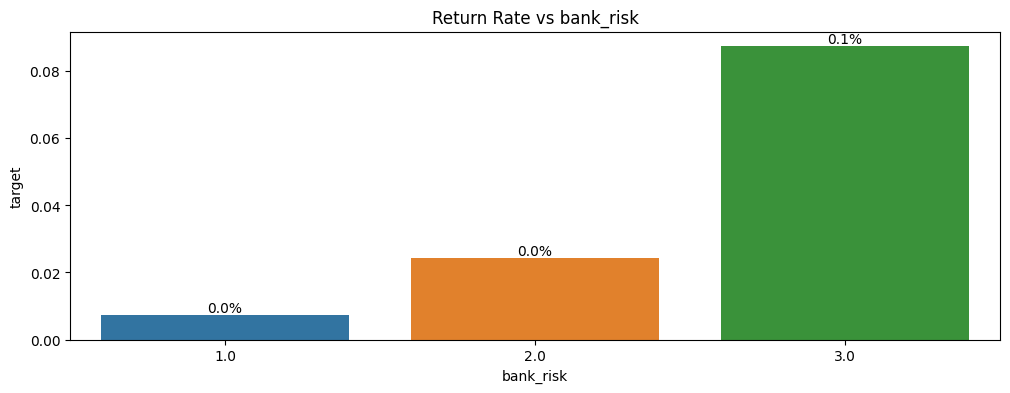

In [133]:
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(data=df1, x='bank_risk', y='target', ax=ax, ci=None)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')
ax.set(title='Return Rate vs bank_risk')
# fig.savefig('/Users/saliljain/Documents/salil/ACH_Pull/rnp/business_type.png')

In [134]:
df1.head(1)

,id,amount,created_at,target,business_type,estimated_monthly_revenue,incoming_ach_payments,check_deposit_amount,incoming_wire_transfer,outgoing_ach_and_checks,outgoing_wire_transfers,date_of_establishment,number_of_employees,ein_ssn,age_business_months,od_count_past30d,zero_balance_count_past30d,avg_running_balance_past30d,median_running_balance_past30d,stddev_running_balance_past30d,rb_at_deposit,od_count_past60d,zero_balance_count_past60d,avg_running_balance_past60d,median_running_balance_past60d,stddev_running_balance_past60d,past30d_ach_count,past30d_avg_ach_amount,past30d_completed_ach,past30d_returned_ach,past30d_rejected_ach,past30d_lessthan100_count,past30d_between100and250_count,past30d_between250and1200_count,past30d_greaterthan1200_count,returned_past30d_ach_count,returned_past30d_avg_ach_amount,returned_past30d_lessthan100_count,returned_past30d_between100and250_count,returned_past30d_between250and1200_count,returned_past30d_greaterthan1200_count,rejected_past30d_ach_count,rejected_past30d_avg_ach_amount,rejected_past30d_lessthan100_count,rejected_past30d_between100and250_count,rejected_past30d_between250and1200_count,rejected_past30d_greaterthan1200_count,completed_past30d_ach_count,completed_past30d_avg_ach_amount,completed_past30d_std_ach_amount,completed_past30d_vs_current_amount_score,completed_past30d_moving_avg_dev_amount,completed_past30d_lessthan100_count,completed_past30d_between100and250_count,completed_past30d_between250and1200_count,completed_past30d_greaterthan1200_count,past60d_ach_count,past60d_avg_ach_amount,past60d_completed_ach,past60d_returned_ach,past60d_rejected_ach,past60d_lessthan100_count,past60d_between100and250_count,past60d_between250and1200_count,past60d_greaterthan1200_count,returned_past60d_ach_count,returned_past60d_avg_ach_amount,returned_past60d_lessthan100_count,returned_past60d_between100and250_count,returned_past60d_between250and1200_count,returned_past60d_greaterthan1200_count,rejected_past60d_ach_count,rejected_past60d_avg_ach_amount,rejected_past60d_lessthan100_count,rejected_past60d_between100and250_count,rejected_past60d_between250and1200_count,rejected_past60d_greaterthan1200_count,completed_past60d_ach_count,completed_past60d_avg_ach_amount,completed_past60d_std_ach_amount,completed_past60d_vs_current_amount_score,completed_past60d_moving_avg_dev_amount,completed_past60d_lessthan100_count,completed_past60d_between100and250_count,completed_past60d_between250and1200_count,completed_past60d_greaterthan1200_count,past10d_ach_count,past10d_avg_ach_amount,past10d_completed_ach,past10d_returned_ach,past10d_rejected_ach,past10d_lessthan100_count,past10d_between100and250_count,past10d_between250and1200_count,past10d_greaterthan1200_count,returned_past10d_ach_count,returned_past10d_avg_ach_amount,returned_past10d_lessthan100_count,returned_past10d_between100and250_count,returned_past10d_between250and1200_count,returned_past10d_greaterthan1200_count,rejected_past10d_ach_count,rejected_past10d_avg_ach_amount,rejected_past10d_lessthan100_count,rejected_past10d_between100and250_count,rejected_past10d_between250and1200_count,rejected_past10d_greaterthan1200_count,completed_past10d_ach_count,completed_past10d_avg_ach_amount,completed_past10d_std_ach_amount,completed_past10d_vs_current_amount_score,completed_past10d_moving_avg_dev_amount,completed_past10d_lessthan100_count,completed_past10d_between100and250_count,completed_past10d_between250and1200_count,completed_past10d_greaterthan1200_count,past90d_ach_count,past90d_avg_ach_amount,past90d_completed_ach,past90d_returned_ach,past90d_rejected_ach,past90d_lessthan100_count,past90d_between100and250_count,past90d_between250and1200_count,past90d_greaterthan1200_count,returned_past90d_ach_count,returned_past90d_avg_ach_amount,returned_past90d_lessthan100_count,returned_past90d_between100and250_count,returned_past90d_between250and1200_count,returned_past90d_greaterthan1200_count,rejected_past90d_ach_count,rejected_past90d_avg_ach_amount,rejecte

# Correlation

In [29]:
# Removing categorical variables so that correlation can be run
df_corr = df1[['amount','target','number_of_employees','ein_ssn','age_business_months','od_count_past30d','zero_balance_count_past30d','avg_running_balance_past30d','median_running_balance_past30d','stddev_running_balance_past30d','rb_at_deposit','od_count_past60d','zero_balance_count_past60d','avg_running_balance_past60d','median_running_balance_past60d','stddev_running_balance_past60d','past30d_ach_count','past30d_avg_ach_amount','past30d_completed_ach','past30d_returned_ach','past30d_rejected_ach','past30d_lessthan100_count','past30d_between100and250_count','past30d_between250and1200_count','past30d_greaterthan1200_count','returned_past30d_ach_count','returned_past30d_avg_ach_amount','returned_past30d_lessthan100_count','returned_past30d_between100and250_count','returned_past30d_between250and1200_count','returned_past30d_greaterthan1200_count','rejected_past30d_ach_count','rejected_past30d_avg_ach_amount','rejected_past30d_lessthan100_count','rejected_past30d_between100and250_count','rejected_past30d_between250and1200_count','rejected_past30d_greaterthan1200_count','completed_past30d_ach_count','completed_past30d_avg_ach_amount','completed_past30d_std_ach_amount','completed_past30d_vs_current_amount_score','completed_past30d_moving_avg_dev_amount','completed_past30d_lessthan100_count','completed_past30d_between100and250_count','completed_past30d_between250and1200_count','completed_past30d_greaterthan1200_count','past60d_ach_count','past60d_avg_ach_amount','past60d_completed_ach','past60d_returned_ach','past60d_rejected_ach','past60d_lessthan100_count','past60d_between100and250_count','past60d_between250and1200_count','past60d_greaterthan1200_count','returned_past60d_ach_count','returned_past60d_avg_ach_amount','returned_past60d_lessthan100_count','returned_past60d_between100and250_count','returned_past60d_between250and1200_count','returned_past60d_greaterthan1200_count','rejected_past60d_ach_count','rejected_past60d_avg_ach_amount','rejected_past60d_lessthan100_count','rejected_past60d_between100and250_count','rejected_past60d_between250and1200_count','rejected_past60d_greaterthan1200_count','completed_past60d_ach_count','completed_past60d_avg_ach_amount','completed_past60d_std_ach_amount','completed_past60d_vs_current_amount_score','completed_past60d_moving_avg_dev_amount','completed_past60d_lessthan100_count','completed_past60d_between100and250_count','completed_past60d_between250and1200_count','completed_past60d_greaterthan1200_count','past10d_ach_count','past10d_avg_ach_amount','past10d_completed_ach','past10d_returned_ach','past10d_rejected_ach','past10d_lessthan100_count','past10d_between100and250_count','past10d_between250and1200_count','past10d_greaterthan1200_count','returned_past10d_ach_count','returned_past10d_avg_ach_amount','returned_past10d_lessthan100_count','returned_past10d_between100and250_count','returned_past10d_between250and1200_count','returned_past10d_greaterthan1200_count','rejected_past10d_ach_count','rejected_past10d_avg_ach_amount','rejected_past10d_lessthan100_count','rejected_past10d_between100and250_count','rejected_past10d_between250and1200_count','rejected_past10d_greaterthan1200_count','completed_past10d_ach_count','completed_past10d_avg_ach_amount','completed_past10d_std_ach_amount','completed_past10d_vs_current_amount_score','completed_past10d_moving_avg_dev_amount','completed_past10d_lessthan100_count','completed_past10d_between100and250_count','completed_past10d_between250and1200_count','completed_past10d_greaterthan1200_count','past90d_ach_count','past90d_avg_ach_amount','past90d_completed_ach','past90d_returned_ach','past90d_rejected_ach','past90d_lessthan100_count','past90d_between100and250_count','past90d_between250and1200_count','past90d_greaterthan1200_count','returned_past90d_ach_count','returned_past90d_avg_ach_amount','returned_past90d_lessthan100_count','returned_past90d_between100and250_count','returned_past90d_between250and1200_count','returned_past90d_greaterthan1200_count','rejected_past90d_ach_count','rejected_past90d_avg_ach_amount','rejected_past90d_lessthan100_count','rejected_past90d_between100and250_count','rejected_past90d_between250and1200_count','rejected_past90d_greaterthan1200_count','completed_past90d_ach_count','completed_past90d_avg_ach_amount','completed_past90d_std_ach_amount','completed_past90d_vs_current_amount_score','completed_past90d_moving_avg_dev_amount','completed_past90d_lessthan100_count','completed_past90d_between100and250_count','completed_past90d_between250and1200_count','completed_past90d_greaterthan1200_count','past_2d_ach_count','past_2d_avg_ach_amount','past_2d_lessthan100_count','past_2d_between100and250_count','past_2d_between250and1200_count','past_2d_greaterthan1200_count','card_txn_count_past30d','card_txn_median_past30d','card_txn_avg_past30d','card_txn_std_past30d','card_txn_amt_per_txn_past30d','ach_c_count_past30d','ach_c_median_past30d','ach_c_avg_past30d','ach_c_std_past30d','ach_c_amt_per_txn_past30d','ach_d_count_past30d','ach_d_median_past30d','ach_d_avg_past30d','ach_d_std_past30d','ach_d_amt_per_txn_past30d','mrdc_c_count_past30d','mrdc_c_avg_past30d','mrdc_c_amt_per_txn_past30d','credit_txn_count_past30d','debit_by_credit_past_30d','credit_txn_median_past30d','credit_txn_avg_past30d','credit_txn_std_past30d','credit_txn_amt_per_txn_past30d','debit_txn_count_past30d','debit_txn_median_past30d','debit_txn_avg_past30d','debit_txn_std_past30d','debit_txn_amt_per_txn_past30d','pd_count_past30d','pd_avg_past30d','pd_amt_per_txn_past30d','card_txn_count_past60d','card_txn_median_past60d','card_txn_avg_past60d','card_txn_std_past60d','card_txn_amt_per_txn_past60d','ach_c_count_past60d','ach_c_median_past60d','ach_c_avg_past60d','ach_c_std_past60d','ach_c_amt_per_txn_past60d','ach_d_count_past60d','ach_d_median_past60d','ach_d_avg_past60d','ach_d_std_past60d','ach_d_amt_per_txn_past60d','mrdc_c_count_past60d','mrdc_c_avg_past60d','mrdc_c_amt_per_txn_past60d','credit_txn_count_past60d','debit_by_credit_past_60d','credit_txn_median_past60d','credit_txn_avg_past60d','credit_txn_std_past60d','credit_txn_amt_per_txn_past60d','debit_txn_count_past60d','debit_txn_median_past60d','debit_txn_avg_past60d','debit_txn_std_past60d','debit_txn_amt_per_txn_past60d','pd_count_past60d','pd_median_past60d','pd_avg_past60d','pd_amt_per_txn_past60d','card_txn_count_past10d','card_txn_median_past10d','card_txn_avg_past10d','card_txn_std_past10d','card_txn_amt_per_txn_past10d','ach_c_count_past10d','ach_c_median_past10d','ach_c_avg_past10d','ach_c_std_past10d','ach_c_amt_per_txn_past10d','ach_d_count_past10d','ach_d_median_past10d','ach_d_avg_past10d','ach_d_std_past10d','ach_d_amt_per_txn_past10d','mrdc_c_count_past10d','mrdc_c_avg_past10d','mrdc_c_amt_per_txn_past10d','credit_txn_count_past10d','debit_by_credit_past_10d','credit_txn_median_past10d','credit_txn_avg_past10d','credit_txn_std_past10d','credit_txn_amt_per_txn_past10d','debit_txn_count_past10d','debit_txn_median_past10d','debit_txn_avg_past10d','debit_txn_std_past10d','debit_txn_amt_per_txn_past10d','pd_count_past10d','pd_avg_past10d','pd_amt_per_txn_past10d','card_txn_count_past2d','card_txn_median_past2d','card_txn_avg_past2d','card_txn_amt_per_txn_past2d','ach_c_count_past2d','ach_c_median_past2d','ach_c_avg_past2d','ach_c_amt_per_txn_past2d','ach_d_count_past2d','ach_d_median_past2d','ach_d_avg_past2d','ach_d_amt_per_txn_past2d','mrdc_c_count_past2d','mrdc_c_avg_past2d','mrdc_c_amt_per_txn_past2d','credit_txn_count_past2d','credit_txn_median_past2d','credit_txn_avg_past2d','credit_txn_amt_per_txn_past2d','debit_txn_count_past2d','debit_txn_median_past2d','debit_txn_avg_past2d','debit_txn_std_past2d','debit_txn_amt_per_txn_past2d','pd_count_past2d','pd_avg_past2d','pd_amt_per_txn_past2d','card_txn_count_past10by30d','card_txn_median_past10by30d','card_txn_avg_past10by30d','card_txn_std_past10by30d','card_txn_amt_per_txn_past10by30d','ach_c_count_past10by30d','ach_c_median_past10by30d','ach_c_avg_past10by30d','ach_c_std_past10by30d','ach_c_amt_per_txn_past10by30d','ach_d_count_past10by30d','ach_d_median_past10by30d','ach_d_avg_past10by30d','ach_d_std_past10by30d','ach_d_amt_per_txn_past10by30d','mrdc_c_count_past10by30d','mrdc_c_avg_past10by30d','mrdc_c_amt_per_txn_past10by30d','credit_txn_count_past10by30d','credit_txn_median_past10by30d','credit_txn_avg_past10by30d','credit_txn_std_past10by30d','credit_txn_amt_per_txn_past10by30d','debit_txn_count_past10by30d','debit_txn_median_past10by30d','debit_txn_avg_past10by30d','debit_txn_std_past10by30d','debit_txn_amt_per_txn_past10by30d','pd_count_past10by30d','pd_avg_past10by30d','pd_amt_per_txn_past10by30d','daily_limit','utilisation','avg_utilisation','cnt_max_utilisation','max_utilisation_by_num_ach_trxn','lending_customer','bank_risk']]


In [30]:
df1.shape
df_corr.shape


(119571, 303)

In [31]:
def trimm_correlated(df_in, threshold):
    df_corr = df_in.corr(method='pearson', min_periods=1)
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out


In [32]:
df_corr1 = trimm_correlated(df_corr, 0.7)
df_corr1.shape


(119571, 87)

In [33]:
df_corr1.head(1)

,amount,target,number_of_employees,ein_ssn,age_business_months,od_count_past30d,zero_balance_count_past30d,avg_running_balance_past30d,stddev_running_balance_past30d,past30d_ach_count,past30d_avg_ach_amount,past30d_returned_ach,past30d_rejected_ach,past30d_lessthan100_count,past30d_between100and250_count,past30d_greaterthan1200_count,returned_past30d_avg_ach_amount,returned_past30d_lessthan100_count,returned_past30d_between100and250_count,returned_past30d_between250and1200_count,rejected_past30d_avg_ach_amount,rejected_past30d_lessthan100_count,rejected_past30d_between100and250_count,rejected_past30d_between250and1200_count,rejected_past30d_greaterthan1200_count,completed_past30d_std_ach_amount,completed_past30d_vs_current_amount_score,past10d_rejected_ach,returned_past10d_lessthan100_count,returned_past10d_between100and250_count,rejected_past10d_between100and250_count,rejected_past10d_between250and1200_count,completed_past10d_std_ach_amount,past_2d_ach_count,past_2d_avg_ach_amount,past_2d_lessthan100_count,past_2d_between100and250_count,past_2d_between250and1200_count,past_2d_greaterthan1200_count,card_txn_count_past30d,card_txn_median_past30d,card_txn_avg_past30d,ach_c_count_past30d,ach_c_median_past30d,ach_c_avg_past30d,ach_c_std_past30d,ach_d_count_past30d,ach_d_median_past30d,ach_d_avg_past30d,mrdc_c_count_past30d,mrdc_c_avg_past30d,debit_by_credit_past_30d,pd_count_past30d,pd_avg_past30d,ach_c_std_past60d,debit_by_credit_past_60d,card_txn_avg_past10d,mrdc_c_avg_past10d,mrdc_c_amt_per_txn_past10d,debit_by_credit_past_10d,card_txn_median_past2d,ach_c_median_past2d,ach_d_count_past2d,ach_d_median_past2d,mrdc_c_count_past2d,mrdc_c_avg_past2d,pd_avg_past2d,card_txn_count_past10by30d,card_txn_median_past10by30d,card_txn_avg_past10by30d,card_txn_std_past10by30d,ach_c_count_past10by30d,ach_c_median_past10by30d,ach_c_avg_past10by30d,ach_c_std_past10by30d,ach_d_count_past10by30d,ach_d_median_past10by30d,ach_d_avg_past10by30d,ach_d_std_past10by30d,mrdc_c_count_past10by30d,debit_txn_count_past10by30d,debit_txn_avg_past10by30d,pd_count_past10by30d,daily_limit,utilisation,cnt_max_utilisation,lending_customer
1,100.0,0,5.0,0.0,9.612903,0.0,0.0,2716.934667,805.997828,3,1250.0,0,0,0,0,3,0.0,0,0,0,0.0,0,0,0,0,0.0,0.079936,0,0,0,0,0,0.0,1,100.0,0,1,0,0,3,25.14,10.912857,2,1250.0,357.142857,0.0,0,NaN,0.0,0,0.0,1.333333,0,0.0,0.0,2.333333,0.0,0.0,0.0,0.0,NaN,1250.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.5,1.0,3.5,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,1250.0,0.08,0,0


# Selecting variables after correlation

In [135]:
# >=6 months
df1 = df1[['id','created_at','bank_risk','amount','target','rb_at_deposit','ein_ssn','od_count_past30d','zero_balance_count_past30d','avg_running_balance_past30d','stddev_running_balance_past30d','past30d_ach_count','past30d_avg_ach_amount','past30d_returned_ach','past30d_rejected_ach','past30d_lessthan100_count','past30d_between100and250_count','past30d_greaterthan1200_count','returned_past30d_avg_ach_amount','returned_past30d_lessthan100_count','returned_past30d_between100and250_count','returned_past30d_between250and1200_count','rejected_past30d_avg_ach_amount','rejected_past30d_lessthan100_count','rejected_past30d_between100and250_count','rejected_past30d_between250and1200_count','rejected_past30d_greaterthan1200_count','completed_past30d_std_ach_amount','completed_past30d_vs_current_amount_score','past10d_rejected_ach','returned_past10d_lessthan100_count','returned_past10d_between100and250_count','rejected_past10d_between100and250_count','rejected_past10d_between250and1200_count','completed_past10d_std_ach_amount','past_2d_ach_count','past_2d_avg_ach_amount','past_2d_lessthan100_count','past_2d_between100and250_count','past_2d_between250and1200_count','past_2d_greaterthan1200_count','card_txn_count_past30d','card_txn_median_past30d','card_txn_avg_past30d','ach_c_count_past30d','ach_c_median_past30d','ach_c_avg_past30d','ach_c_std_past30d','ach_d_count_past30d','ach_d_median_past30d','ach_d_avg_past30d','mrdc_c_count_past30d','mrdc_c_avg_past30d','debit_by_credit_past_30d','pd_count_past30d','pd_avg_past30d','ach_c_std_past60d','debit_by_credit_past_60d','card_txn_avg_past10d','mrdc_c_avg_past10d','mrdc_c_amt_per_txn_past10d','debit_by_credit_past_10d','card_txn_median_past2d','ach_c_median_past2d','ach_d_count_past2d','ach_d_median_past2d','mrdc_c_count_past2d','mrdc_c_avg_past2d','pd_avg_past2d','card_txn_count_past10by30d','card_txn_median_past10by30d','card_txn_avg_past10by30d','card_txn_std_past10by30d','ach_c_count_past10by30d','ach_c_median_past10by30d','ach_c_avg_past10by30d','ach_c_std_past10by30d','ach_d_count_past10by30d','ach_d_median_past10by30d','ach_d_avg_past10by30d','ach_d_std_past10by30d','mrdc_c_count_past10by30d','debit_txn_count_past10by30d','debit_txn_avg_past10by30d','pd_count_past10by30d','utilisation','cnt_max_utilisation','lending_customer']]
# df1 = df1[['bank_risk','avg_running_balance_past30d','card_txn_count_past30d','completed_past30d_vs_current_amount_score','rb_at_deposit','ach_c_median_past30d','past30d_returned_ach','ach_d_avg_past30d','od_count_past30d','past30d_rejected_ach']]


# Modelling

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import model_selection
kfolds = model_selection.KFold(n_splits=3, shuffle=True, random_state=50)

import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
import warnings
warnings.filterwarnings("ignore")

# Classifier
from catboost import CatBoostClassifier

# Model selection
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, recall_score, precision_score,f1_score, accuracy_score, confusion_matrix
# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold

# PSI

In [430]:
# #PSI calculation
# import pandas as pd
# import numpy as np
# import math as math
# import sys as sys
# import logging


# name =['amount','target','number_of_employees','ein_ssn','age_business_months','od_count_past30d','zero_balance_count_past30d','avg_running_balance_past30d','stddev_running_balance_past30d','past30d_ach_count','past30d_avg_ach_amount','past30d_returned_ach','past30d_rejected_ach','past30d_lessthan100_count','past30d_between100and250_count','past30d_between250and1200_count','past30d_greaterthan1200_count','returned_past30d_avg_ach_amount','returned_past30d_lessthan100_count','returned_past30d_between100and250_count','returned_past30d_between250and1200_count','rejected_past30d_avg_ach_amount','rejected_past30d_lessthan100_count','rejected_past30d_between100and250_count','rejected_past30d_between250and1200_count','rejected_past30d_greaterthan1200_count','completed_past30d_std_ach_amount','completed_past30d_vs_current_amount_score','returned_past10d_lessthan100_count','returned_past10d_between100and250_count','rejected_past10d_between100and250_count','completed_past10d_std_ach_amount','past_2d_ach_count','past_2d_avg_ach_amount','past_2d_lessthan100_count','past_2d_between100and250_count','past_2d_between250and1200_count','past_2d_greaterthan1200_count','card_txn_count_past30d','card_txn_median_past30d','card_txn_avg_past30d','ach_c_count_past30d','ach_c_median_past30d','ach_c_avg_past30d','ach_c_std_past30d','ach_d_count_past30d','ach_d_median_past30d','ach_d_avg_past30d','mrdc_c_count_past30d','mrdc_c_avg_past30d','mrdc_c_amt_per_txn_past30d','debit_by_credit_past_30d','pd_count_past30d','pd_avg_past30d','debit_by_credit_past_60d','pd_median_past60d','card_txn_avg_past10d','mrdc_c_amt_per_txn_past10d','debit_by_credit_past_10d','card_txn_median_past2d','ach_c_median_past2d','ach_d_count_past2d','ach_d_median_past2d','mrdc_c_count_past2d','mrdc_c_avg_past2d','pd_avg_past2d','card_txn_count_past10by30d','card_txn_median_past10by30d','card_txn_avg_past10by30d','card_txn_std_past10by30d','ach_c_count_past10by30d','ach_c_median_past10by30d','ach_c_avg_past10by30d','ach_c_std_past10by30d','ach_d_count_past10by30d','ach_d_median_past10by30d','ach_d_avg_past10by30d','ach_d_std_past10by30d','mrdc_c_count_past10by30d','debit_txn_count_past10by30d','debit_txn_avg_past10by30d','pd_count_past10by30d','daily_limit','utilisation','cnt_max_utilisation','max_utilisation_by_num_ach_trxn','lending_customer']
# score_file_old = model_xgb.copy()
# score_file_new = oot_xgb.copy()


# for m in range(len(name)):
#     bin_count_input = 5

#     pred_score=pd.DataFrame()
#     pred_score["y_predict"]=score_file_old[name[m]]

#     Ndiv=int(bin_count_input)
#     N=len(pred_score)
#     bin_obs_1=[int(N/Ndiv)] * Ndiv
#     bin_obs_2=[1]*(N%Ndiv) + [0]*(Ndiv-(N%Ndiv))

#     dN=[]
#     for i in range(Ndiv):
#         dN.append(bin_obs_1[i] + bin_obs_2[i])

#     pred_score["sr_no"] = pred_score.index.tolist()  #0 indexed sr_no

#     pred_score_sorted = pred_score.sort_values(by=["y_predict","sr_no"],ascending=False).reset_index().drop(columns=["sr_no"])

#     istart=0
#     iend=0
#     pred_min_list=[]
#     pred_max_list=[]
#     for i in range(Ndiv):
#         iend=iend+dN[i]
#         pred_min_list.append(min(pred_score_sorted.iloc[istart:iend,pred_score_sorted.columns.get_loc("y_predict")]))
#         pred_max_list.append(max(pred_score_sorted.iloc[istart:iend,pred_score_sorted.columns.get_loc("y_predict")]))
#         istart=iend

#     pred_min_list[Ndiv-1]=float("-inf")

#     for i in range(Ndiv-1):
#         pred_max_list[i+1]=pred_min_list[i]

#     pred_max_list[0]=float("inf")

#     pred_score_new=pd.DataFrame()

#     pred_score_new["y_predict"]=score_file_new[name[m]]
#     pred_score_new = pred_score_new.fillna(-99999)
#     pred_score_new = pred_score_new[(pred_score_new.y_predict != -99999)]

#     obs_new_vs_old=pd.DataFrame(data=np.NaN,index=range(Ndiv),columns=["bin","min(inclusive)","max(exclusive)","new_obs","old_obs","PSI"])

#     for i in range(Ndiv):
#         obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("bin")]=str(int(i+1))
#         obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("min(inclusive)")]=pred_min_list[i]
#         obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("max(exclusive)")]=pred_max_list[i]
#         obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("old_obs")]=int(pred_score_sorted["y_predict"][(pred_score_sorted["y_predict"]>=pred_min_list[i]) & (pred_score_sorted["y_predict"]<pred_max_list[i])].count())
#         obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("new_obs")]=int(pred_score_new["y_predict"][(pred_score_new["y_predict"]>=pred_min_list[i]) & (pred_score_new["y_predict"]<pred_max_list[i])].count())

#     total_old=obs_new_vs_old.iloc[:,obs_new_vs_old.columns.get_loc("old_obs")].sum()
#     total_new=obs_new_vs_old.iloc[:,obs_new_vs_old.columns.get_loc("new_obs")].sum()
    

#     for i in range(Ndiv):
#         obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("PSI")]=(obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("old_obs")]/total_old-obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("new_obs")]/total_new)*math.log((obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("old_obs")]/total_old)/(obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("new_obs")]/total_new))


#     output={'Variable':name[m],'PSI':obs_new_vs_old.iloc[:,obs_new_vs_old.columns.get_loc("PSI")].sum()}
#     print(output)
    

# Defining Evaluation Metrics

In [4]:
def evaluate(y_train, y_pred_train, y_test, y_pred_test):
    print('Test Recall', recall_score(y_test, y_pred_test,pos_label=1))
    print('Test Precision', precision_score(y_test, y_pred_test,pos_label=1))
    print('Test F1', f1_score(y_test, y_pred_test,pos_label=1))
    print('Test ROC_AUC',roc_auc_score(y_test, y_pred_test))
    print('Test Accuracy',accuracy_score(y_test, y_pred_test))
    print('Test Confusion Matrix',confusion_matrix(y_test, y_pred_test))
    ConfusionMatrix = confusion_matrix(y_test, y_pred_test)
    defaulters = ConfusionMatrix[1,0]
    success = ConfusionMatrix[0,0]
    default_rate = (ConfusionMatrix[1,0]) / (ConfusionMatrix[1,0] + ConfusionMatrix[0,0])
    print('Test Default Rate : ', default_rate)
    ax = sns.heatmap(ConfusionMatrix, annot=True, cmap='BuPu',fmt=".1f",cbar=False)
    ax.set_title('Confusion Matrix for Test');
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Actual');
    ax.xaxis.set_ticklabels(['Completed','Return'])
    ax.yaxis.set_ticklabels(['Completed','Return'])
    plt.show()
    
    print()
    
    print('Train Recall', recall_score(y_train, y_pred_train,pos_label=1))
    print('Train Precision', precision_score(y_train, y_pred_train,pos_label=1))
    print('Train F1', f1_score(y_train, y_pred_train,pos_label=1))
    print('Train ROC_AUC',roc_auc_score(y_train, y_pred_train))
    print('Train Accuracy',accuracy_score(y_train, y_pred_train))
    print('Train Confusion Matrix',confusion_matrix(y_train, y_pred_train))
    ConfusionMatrix = confusion_matrix(y_train, y_pred_train)
    defaulters = ConfusionMatrix[1,0]
    success = ConfusionMatrix[0,0]
    default_rate = (ConfusionMatrix[1,0]) / (ConfusionMatrix[1,0] + ConfusionMatrix[0,0])
    print('Train Default Rate : ', default_rate)
    ax = sns.heatmap(ConfusionMatrix, annot=True, fmt=".1f", cmap='BuPu',cbar=False)
    ax.set_title('Confusion Matrix for Train');
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Actual');
    ax.xaxis.set_ticklabels(['Completed','Return'])
    ax.yaxis.set_ticklabels(['Completed','Return'])
    plt.show()

# CatBoost

### 2nd Iteration

In [107]:
values = {'bank_risk': 0}
df1.fillna(value=values, inplace=True)
df1.bank_risk = df1.bank_risk.astype(int)

In [42]:
# >=6 months, external_bank, iteration 2
df1 = df1.loc[df1['lending_customer']==1]
df1['amount_by_rb_at_deposit'] = df1['amount']/df1['rb_at_deposit']
df1['amount_by_rb_at_deposit'].replace([np.inf, -np.inf], np.nan, inplace=True)

df1 = df1[['id','created_at','bank_risk','amount_by_rb_at_deposit','amount','target','rb_at_deposit','ein_ssn','od_count_past30d','zero_balance_count_past30d','avg_running_balance_past30d','stddev_running_balance_past30d','past30d_ach_count','past30d_avg_ach_amount','past30d_returned_ach','past30d_rejected_ach','past30d_lessthan100_count','past30d_between100and250_count','past30d_greaterthan1200_count','returned_past30d_avg_ach_amount','returned_past30d_lessthan100_count','returned_past30d_between100and250_count','returned_past30d_between250and1200_count','rejected_past30d_avg_ach_amount','rejected_past30d_lessthan100_count','rejected_past30d_between100and250_count','rejected_past30d_between250and1200_count','rejected_past30d_greaterthan1200_count','completed_past30d_std_ach_amount','completed_past30d_vs_current_amount_score','past10d_rejected_ach','returned_past10d_lessthan100_count','returned_past10d_between100and250_count','rejected_past10d_between100and250_count','rejected_past10d_between250and1200_count','completed_past10d_std_ach_amount','past_2d_ach_count','past_2d_avg_ach_amount','past_2d_lessthan100_count','past_2d_between100and250_count','past_2d_between250and1200_count','past_2d_greaterthan1200_count','card_txn_count_past30d','card_txn_median_past30d','card_txn_avg_past30d','ach_c_count_past30d','ach_c_median_past30d','ach_c_avg_past30d','ach_c_std_past30d','ach_d_count_past30d','ach_d_median_past30d','ach_d_avg_past30d','mrdc_c_count_past30d','mrdc_c_avg_past30d','debit_by_credit_past_30d','pd_count_past30d','pd_avg_past30d','ach_c_std_past60d','debit_by_credit_past_60d','card_txn_avg_past10d','mrdc_c_avg_past10d','mrdc_c_amt_per_txn_past10d','debit_by_credit_past_10d','card_txn_median_past2d','ach_c_median_past2d','ach_d_count_past2d','ach_d_median_past2d','mrdc_c_count_past2d','mrdc_c_avg_past2d','pd_avg_past2d','card_txn_count_past10by30d','card_txn_median_past10by30d','card_txn_avg_past10by30d','card_txn_std_past10by30d','ach_c_count_past10by30d','ach_c_median_past10by30d','ach_c_avg_past10by30d','ach_c_std_past10by30d','ach_d_count_past10by30d','ach_d_median_past10by30d','ach_d_avg_past10by30d','ach_d_std_past10by30d','mrdc_c_count_past10by30d','debit_txn_count_past10by30d','debit_txn_avg_past10by30d','pd_count_past10by30d','utilisation','cnt_max_utilisation','lending_customer']]
# df2 = df1.loc[df1['lending_customer']==0]
df2 = df1.copy()

model_cat = df2.loc[(df2['created_at']>='2022-09-01') & (df2['created_at']<'2023-06-01')]
oot_cat = df2.loc[(df2['created_at']>='2023-06-01') & (df2['created_at']<'2023-10-01')]


# x_train = model_cat[['bank_risk','amount_by_rb_at_deposit','avg_running_balance_past30d','rb_at_deposit','card_txn_count_past30d','debit_by_credit_past_30d','ach_c_median_past30d','ach_c_avg_past30d','amount','od_count_past30d','returned_past30d_avg_ach_amount','ach_c_avg_past10by30d','completed_past30d_vs_current_amount_score','debit_by_credit_past_10d','past30d_ach_count','card_txn_median_past2d','ach_d_median_past30d','completed_past30d_std_ach_amount','card_txn_median_past30d','stddev_running_balance_past30d','ach_c_count_past30d','card_txn_avg_past10d','card_txn_median_past10by30d','ach_d_avg_past30d','past30d_avg_ach_amount','ach_c_count_past10by30d','zero_balance_count_past30d']]
# y_train = model_cat['target']

X = model_cat[['bank_risk','avg_running_balance_past30d','rb_at_deposit','card_txn_count_past30d','debit_by_credit_past_30d','ach_c_median_past30d','ach_c_avg_past30d','amount','od_count_past30d','returned_past30d_avg_ach_amount','ach_c_avg_past10by30d','completed_past30d_vs_current_amount_score','debit_by_credit_past_10d','past30d_ach_count','card_txn_median_past2d','ach_d_median_past30d','completed_past30d_std_ach_amount','card_txn_median_past30d','stddev_running_balance_past30d','ach_c_count_past30d','card_txn_avg_past10d','card_txn_median_past10by30d','ach_d_avg_past30d','past30d_avg_ach_amount','ach_c_count_past10by30d','zero_balance_count_past30d']]
y = model_cat['target']

from sklearn.model_selection import train_test_split
data_dmatrix = xgb.DMatrix(data=X,label=y)
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, 
                                                    random_state=42)

x_oot = oot_cat[['bank_risk','avg_running_balance_past30d','rb_at_deposit','card_txn_count_past30d','debit_by_credit_past_30d','ach_c_median_past30d','ach_c_avg_past30d','amount','od_count_past30d','returned_past30d_avg_ach_amount','ach_c_avg_past10by30d','completed_past30d_vs_current_amount_score','debit_by_credit_past_10d','past30d_ach_count','card_txn_median_past2d','ach_d_median_past30d','completed_past30d_std_ach_amount','card_txn_median_past30d','stddev_running_balance_past30d','ach_c_count_past30d','card_txn_avg_past10d','card_txn_median_past10by30d','ach_d_avg_past30d','past30d_avg_ach_amount','ach_c_count_past10by30d','zero_balance_count_past30d']]
y_oot = oot_cat['target']

# 'bank_risk','avg_running_balance_past30d','rb_at_deposit','card_txn_count_past30d','debit_by_credit_past_30d','ach_c_median_past30d','ach_c_avg_past30d','amount','od_count_past30d','returned_past30d_avg_ach_amount','ach_c_avg_past10by30d','completed_past30d_vs_current_amount_score','debit_by_credit_past_10d','past30d_ach_count','card_txn_median_past2d','ach_d_median_past30d','completed_past30d_std_ach_amount','card_txn_median_past30d','stddev_running_balance_past30d','utilisation','ach_c_count_past30d','card_txn_avg_past10d','card_txn_median_past10by30d','ach_d_avg_past30d','past30d_avg_ach_amount','ach_c_count_past10by30d','zero_balance_count_past30d'

In [43]:
x_oot.shape

(3887, 26)

In [97]:
#write data
# x_train.to_csv('x_train_greater_6_months.csv')
# y_train.to_csv('y_train_greater_6_months.csv')

# x_test.to_csv('x_test_greater_6_months.csv')
# y_test.to_csv('y_test_greater_6_months.csv')

# x_oot.to_csv('x_oot_greater_6_months.csv')
# y_oot.to_csv('y_oot_greater_6_months.csv')

In [1]:
# #Read data
# import pandas as pd
# x_train = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data_6_months/x_train_greater_6_months.csv')
# y_train = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data_6_months/y_train_greater_6_months.csv')

# x_test = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data_6_months/x_test_greater_6_months.csv')
# y_test = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data_6_months/y_test_greater_6_months.csv')

# x_oot = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data_6_months/x_oot_greater_6_months.csv')
# y_oot = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data_6_months/y_oot_greater_6_months.csv')

In [2]:
# x_train = x_train.drop("Unnamed: 0", axis=1)
# y_train = y_train.drop("Unnamed: 0", axis=1)

# x_test = x_test.drop("Unnamed: 0", axis=1)
# y_test = y_test.drop("Unnamed: 0", axis=1)

# x_oot = x_oot.drop("Unnamed: 0", axis=1)
# y_oot = y_oot.drop("Unnamed: 0", axis=1)

# Hyper Parameter Optimisation

In [505]:
import optuna

In [506]:
def hyper_eval(cb, x_train, x_test, y_test, y_train):
    y_train_pred = cb.predict_proba(x_train)
    y_test_pred = cb.predict_proba(x_test)

    y_train_pred1 = pd.DataFrame(data = y_train_pred, columns=['co_prob','canc_prob'])
    y_test_pred1 = pd.DataFrame(data = y_test_pred, columns=['co_prob','canc_prob'])
    
    y_test1 = pd.DataFrame(data = y_test, columns=['target'])
    y_train1 = pd.DataFrame(data = y_train, columns=['target'])
    
    # Test at different cutoffs
    prob_threshold =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    test_ls = []
    column_name = ['False_Positive', 'True_Positive','False_Negative',
                    'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                    'Precision_test', 'Recall_test']

    for bin in prob_threshold:
        test_ls.append(calculate_at_threshold(bin, y_test1['target'], y_test_pred1['canc_prob']))
    metric_df_test = pd.DataFrame(test_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
    metric_df_test.index.name = 'Threshold'
    metric_df_test = metric_df_test.reset_index()
    metric_df_test = metric_df_test[['Threshold','Precision_test','Recall_test']]


    # Train at different cutoffs
    prob_threshold =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    train_ls = []
    column_name = ['False_Positive', 'True_Positive','False_Negative',
                    'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                    'Precision_train', 'Recall_train']


    for bin in prob_threshold:
        train_ls.append(calculate_at_threshold(bin, y_train1['target'], y_train_pred1['canc_prob']))
    metric_df_train = pd.DataFrame(train_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
    metric_df_train.index.name = 'Threshold'
    metric_df_train = metric_df_train.reset_index()
    metric_df_train = metric_df_train[['Threshold','Precision_train','Recall_train']]
    
    final = pd.merge(metric_df_test,metric_df_train, on = 'Threshold')
    final = final.loc[final['Threshold']==0.1]
    
    return final


In [507]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.01, 0.2, 0.05)
#     param['depth'] = trial.suggest_int('depth', 2, 6) 
    param['depth'] = trial.suggest_discrete_uniform('depth', 2, 6, 1.0)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 40.0, 100.0, 30.0)
#     param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
#     param['grow_policy'] = 'Depthwise'
    param['iterations'] = trial.suggest_categorical('iterations', [400, 500, 700])
#     param['use_best_model'] = True
    param['eval_metric'] = 'AUC'
#     param['od_type'] = 'iter'
#     param['od_wait'] = 50
    param['random_state'] = 42
    param['logging_level'] = 'Silent'
    
    cb = CatBoostClassifier(**param)
    cb.fit(x_train.copy(), y_train.copy(),
                  eval_set=[(x_test.copy(), y_test.copy())],
                  early_stopping_rounds=100)
        
    
    return param,hyper_eval(cb, x_train, x_test, y_test, y_train)

In [508]:
%%time
study = optuna.create_study(study_name='catboost-seed')
study.optimize(objective, n_trials=100, n_jobs=-1, timeout=24000)

[I 2023-11-09 11:57:40,667] A new study created in memory with name: catboost-seed
[W 2023-11-09 11:57:48,076] Trial 1 failed with parameters: {'learning_rate': 0.11, 'depth': 4.0, 'l2_leaf_reg': 100.0, 'iterations': 700} because of the following error: The value {'learning_rate': 0.11, 'depth': 4.0, 'l2_leaf_reg': 100.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2023-11-09 11:57:48,081] Trial 1 failed with value ({'learning_rate': 0.11, 'depth': 4.0, 'l2_leaf_reg': 100.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.215947     0.232975         0.195829      0.202395).
[W 2023-11-09 11:57:50,440] Trial 5 failed with parameters: {'learning_rate': 0.060000000000000005, 'depth': 3.0, 'l2_leaf_reg': 40.0, 'iterations': 400} because of the following error: The value {'learning_r

[W 2023-11-09 11:58:02,086] Trial 10 failed with value ({'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 100.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.225806     0.250896         0.221983      0.246707).
[W 2023-11-09 11:58:03,701] Trial 12 failed with parameters: {'learning_rate': 0.060000000000000005, 'depth': 6.0, 'l2_leaf_reg': 100.0, 'iterations': 500} because of the following error: The value {'learning_rate': 0.060000000000000005, 'depth': 6.0, 'l2_leaf_reg': 100.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2023-11-09 11:58:03,704] Trial 12 failed with value ({'learning_rate': 0.060000000000000005, 'depth': 6.0, 'l2_leaf_reg': 100.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall

[W 2023-11-09 11:58:18,695] Trial 21 failed with parameters: {'learning_rate': 0.16, 'depth': 3.0, 'l2_leaf_reg': 70.0, 'iterations': 700} because of the following error: The value {'learning_rate': 0.16, 'depth': 3.0, 'l2_leaf_reg': 70.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2023-11-09 11:58:18,699] Trial 21 failed with value ({'learning_rate': 0.16, 'depth': 3.0, 'l2_leaf_reg': 70.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.216867     0.258065         0.239085      0.275449).
[W 2023-11-09 11:58:18,965] Trial 23 failed with parameters: {'learning_rate': 0.16, 'depth': 4.0, 'l2_leaf_reg': 40.0, 'iterations': 500} because of the following error: The value {'learning_rate': 0.16, 'depth': 4.0, 'l2_leaf_reg': 40.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_sta

[W 2023-11-09 11:58:34,091] Trial 36 failed with value ({'learning_rate': 0.060000000000000005, 'depth': 6.0, 'l2_leaf_reg': 100.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.227129     0.258065         0.210405      0.217964).
[W 2023-11-09 11:58:34,159] Trial 32 failed with parameters: {'learning_rate': 0.16, 'depth': 4.0, 'l2_leaf_reg': 70.0, 'iterations': 700} because of the following error: The value {'learning_rate': 0.16, 'depth': 4.0, 'l2_leaf_reg': 70.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2023-11-09 11:58:34,162] Trial 32 failed with value ({'learning_rate': 0.16, 'depth': 4.0, 'l2_leaf_reg': 70.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_trai

[W 2023-11-09 11:58:51,301] Trial 49 failed with parameters: {'learning_rate': 0.16, 'depth': 2.0, 'l2_leaf_reg': 70.0, 'iterations': 400} because of the following error: The value {'learning_rate': 0.16, 'depth': 2.0, 'l2_leaf_reg': 70.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2023-11-09 11:58:51,308] Trial 49 failed with value ({'learning_rate': 0.16, 'depth': 2.0, 'l2_leaf_reg': 70.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1         0.20625     0.236559         0.191332      0.216766).
[W 2023-11-09 11:58:51,955] Trial 47 failed with parameters: {'learning_rate': 0.11, 'depth': 6.0, 'l2_leaf_reg': 100.0, 'iterations': 700} because of the following error: The value {'learning_rate': 0.11, 'depth': 6.0, 'l2_leaf_reg': 100.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_s

[W 2023-11-09 11:59:04,208] Trial 58 failed with parameters: {'learning_rate': 0.01, 'depth': 3.0, 'l2_leaf_reg': 70.0, 'iterations': 500} because of the following error: The value {'learning_rate': 0.01, 'depth': 3.0, 'l2_leaf_reg': 70.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2023-11-09 11:59:04,214] Trial 58 failed with value ({'learning_rate': 0.01, 'depth': 3.0, 'l2_leaf_reg': 70.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.255682      0.16129         0.217726      0.135329).
[W 2023-11-09 11:59:11,176] Trial 60 failed with parameters: {'learning_rate': 0.01, 'depth': 6.0, 'l2_leaf_reg': 70.0, 'iterations': 500} because of the following error: The value {'learning_rate': 0.01, 'depth': 6.0, 'l2_leaf_reg': 70.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_sta

[W 2023-11-09 11:59:21,139] Trial 67 failed with value ({'learning_rate': 0.16, 'depth': 2.0, 'l2_leaf_reg': 100.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.221884     0.261649         0.194274      0.227545).
[W 2023-11-09 11:59:23,379] Trial 68 failed with parameters: {'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 500} because of the following error: The value {'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2023-11-09 11:59:23,381] Trial 68 failed with value ({'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1  

[W 2023-11-09 11:59:37,669] Trial 78 failed with parameters: {'learning_rate': 0.060000000000000005, 'depth': 2.0, 'l2_leaf_reg': 70.0, 'iterations': 700} because of the following error: The value {'learning_rate': 0.060000000000000005, 'depth': 2.0, 'l2_leaf_reg': 70.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2023-11-09 11:59:37,673] Trial 78 failed with value ({'learning_rate': 0.060000000000000005, 'depth': 2.0, 'l2_leaf_reg': 70.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.212219     0.236559         0.179679      0.201198).
[W 2023-11-09 11:59:40,594] Trial 83 failed with parameters: {'learning_rate': 0.16, 'depth': 6.0, 'l2_leaf_reg': 40.0, 'iterations': 500} because of the following error: The value {'learning_rate': 0.16, 'depth': 6.0, 'l2_leaf_reg': 40.0, 'ite

[W 2023-11-09 11:59:55,806] Trial 97 failed with value ({'learning_rate': 0.060000000000000005, 'depth': 2.0, 'l2_leaf_reg': 100.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.319328     0.136201         0.243402      0.099401).
[W 2023-11-09 11:59:56,134] Trial 95 failed with parameters: {'learning_rate': 0.060000000000000005, 'depth': 4.0, 'l2_leaf_reg': 100.0, 'iterations': 500} because of the following error: The value {'learning_rate': 0.060000000000000005, 'depth': 4.0, 'l2_leaf_reg': 100.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2023-11-09 11:59:56,139] Trial 95 failed with value ({'learning_rate': 0.060000000000000005, 'depth': 4.0, 'l2_leaf_reg': 100.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precis

CPU times: user 16min 41s, sys: 13.8 s, total: 16min 55s
Wall time: 2min 18s


In [198]:
# def report_perf(optimizer, X, y, title="model", callbacks=None):
#     start = time()
    
#     if callbacks is not None:
#         optimizer.fit(X, y, callback=callbacks)
#     else:
#         optimizer.fit(X, y)
        
#     d=pd.DataFrame(optimizer.cv_results_)
#     best_score = optimizer.best_score_
#     best_score_std = d.iloc[optimizer.best_index_].std_test_score
#     best_params = optimizer.best_params_
    
#     print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
#             + u"\u00B1"+" %.3f") % (time() - start, 
#                                    len(optimizer.cv_results_['params']),
#                                    best_score,
#                                    best_score_std))    
#     print('Best parameters:')
#     pprint.pprint(best_params)
#     print()
#     return best_params

In [201]:
# skf = KFold(n_splits=3, shuffle=True, random_state=0)
# cv_strategy = list(skf.split(x_train, y_train))

# # categoricals = ['business_type','estimated_monthly_revenue','incoming_ach_payments','check_deposit_amount',
# #                 'incoming_wire_transfer','outgoing_ach_and_checks','outgoing_wire_transfers','limit_categories']

# categoricals = ['external_bank']

# reg = CatBoostClassifier(cat_features=categoricals,
#                                 verbose = True,
# #                                 class_weights = (1, 45),
#                                 loss_function='Logloss',
#                                 eval_metric = 'AUC')

# search_spaces = {
#         'iterations': Integer(10, 2000),
#         'depth': Integer(2, 6),
#         'learning_rate': Real(0.01, 0.3, 'log-uniform'),
#         'l2_leaf_reg': Integer(10, 100), # L2 regularization
#             }

# opt = BayesSearchCV(estimator=reg,                                    
#                     search_spaces=search_spaces,                      
# #                    scoring=self.my_roc_auc_score,                                  
#                     cv=cv_strategy,                                           
#                     n_iter=10,     # max number of trials
#                     n_points=1,    # number of hyperparameter sets evaluated at the same time
#                     n_jobs=1,     # number of jobs
#                     iid=False,     # if not iid it optimizes on the cv score
#                     pre_dispatch=1,#Controls the number of jobs that get dispatched during parallel execution
#                     return_train_score=True,
#                     random_state=0)

# #overdone_control = DeltaYStopper(delta=0.0001) # We stop if the gain of the optimization becomes too small
# time_limit_control = DeadlineStopper(total_time=60* 60 * 4) # We impose a time limit 

# best_params_cat = report_perf(opt, X, y,'CatBoost_classifier', callbacks=[time_limit_control])
#                           #callbacks=[overdone_control, time_limit_control])
    

0:	total: 7.27ms	remaining: 9.84s
1:	total: 15.8ms	remaining: 10.7s
2:	total: 22ms	remaining: 9.89s
3:	total: 28.2ms	remaining: 9.53s
4:	total: 33.6ms	remaining: 9.08s
5:	total: 39.4ms	remaining: 8.86s
6:	total: 44.6ms	remaining: 8.59s
7:	total: 51.4ms	remaining: 8.65s
8:	total: 56.5ms	remaining: 8.45s
9:	total: 61.8ms	remaining: 8.3s
10:	total: 66.9ms	remaining: 8.17s
11:	total: 72.6ms	remaining: 8.12s
12:	total: 78.1ms	remaining: 8.06s
13:	total: 83.3ms	remaining: 7.98s
14:	total: 88.5ms	remaining: 7.91s
15:	total: 93.8ms	remaining: 7.85s
16:	total: 99.4ms	remaining: 7.82s
17:	total: 104ms	remaining: 7.76s
18:	total: 110ms	remaining: 7.71s
19:	total: 115ms	remaining: 7.69s
20:	total: 121ms	remaining: 7.69s
21:	total: 128ms	remaining: 7.74s
22:	total: 133ms	remaining: 7.7s
23:	total: 138ms	remaining: 7.67s
24:	total: 143ms	remaining: 7.63s
25:	total: 149ms	remaining: 7.61s
26:	total: 154ms	remaining: 7.59s
27:	total: 161ms	remaining: 7.62s
28:	total: 166ms	remaining: 7.59s
29:	total: 

245:	total: 1.42s	remaining: 6.41s
246:	total: 1.43s	remaining: 6.41s
247:	total: 1.44s	remaining: 6.41s
248:	total: 1.44s	remaining: 6.4s
249:	total: 1.45s	remaining: 6.39s
250:	total: 1.45s	remaining: 6.38s
251:	total: 1.46s	remaining: 6.37s
252:	total: 1.46s	remaining: 6.37s
253:	total: 1.47s	remaining: 6.36s
254:	total: 1.47s	remaining: 6.35s
255:	total: 1.48s	remaining: 6.34s
256:	total: 1.48s	remaining: 6.33s
257:	total: 1.49s	remaining: 6.33s
258:	total: 1.49s	remaining: 6.33s
259:	total: 1.5s	remaining: 6.32s
260:	total: 1.5s	remaining: 6.31s
261:	total: 1.51s	remaining: 6.3s
262:	total: 1.51s	remaining: 6.29s
263:	total: 1.52s	remaining: 6.28s
264:	total: 1.53s	remaining: 6.28s
265:	total: 1.53s	remaining: 6.27s
266:	total: 1.54s	remaining: 6.26s
267:	total: 1.54s	remaining: 6.25s
268:	total: 1.55s	remaining: 6.24s
269:	total: 1.55s	remaining: 6.24s
270:	total: 1.56s	remaining: 6.23s
271:	total: 1.56s	remaining: 6.22s
272:	total: 1.57s	remaining: 6.21s
273:	total: 1.57s	remain

509:	total: 2.82s	remaining: 4.67s
510:	total: 2.82s	remaining: 4.66s
511:	total: 2.83s	remaining: 4.66s
512:	total: 2.83s	remaining: 4.65s
513:	total: 2.84s	remaining: 4.64s
514:	total: 2.84s	remaining: 4.64s
515:	total: 2.85s	remaining: 4.63s
516:	total: 2.85s	remaining: 4.63s
517:	total: 2.86s	remaining: 4.62s
518:	total: 2.86s	remaining: 4.61s
519:	total: 2.87s	remaining: 4.61s
520:	total: 2.87s	remaining: 4.6s
521:	total: 2.88s	remaining: 4.6s
522:	total: 2.88s	remaining: 4.59s
523:	total: 2.89s	remaining: 4.58s
524:	total: 2.89s	remaining: 4.58s
525:	total: 2.9s	remaining: 4.57s
526:	total: 2.9s	remaining: 4.56s
527:	total: 2.91s	remaining: 4.56s
528:	total: 2.91s	remaining: 4.55s
529:	total: 2.92s	remaining: 4.54s
530:	total: 2.92s	remaining: 4.54s
531:	total: 2.93s	remaining: 4.53s
532:	total: 2.93s	remaining: 4.53s
533:	total: 2.94s	remaining: 4.52s
534:	total: 2.94s	remaining: 4.51s
535:	total: 2.95s	remaining: 4.51s
536:	total: 2.95s	remaining: 4.5s
537:	total: 2.96s	remaini

779:	total: 4.23s	remaining: 3.12s
780:	total: 4.23s	remaining: 3.11s
781:	total: 4.24s	remaining: 3.11s
782:	total: 4.25s	remaining: 3.1s
783:	total: 4.25s	remaining: 3.1s
784:	total: 4.25s	remaining: 3.09s
785:	total: 4.26s	remaining: 3.08s
786:	total: 4.27s	remaining: 3.08s
787:	total: 4.27s	remaining: 3.07s
788:	total: 4.28s	remaining: 3.07s
789:	total: 4.28s	remaining: 3.06s
790:	total: 4.29s	remaining: 3.06s
791:	total: 4.29s	remaining: 3.05s
792:	total: 4.3s	remaining: 3.04s
793:	total: 4.3s	remaining: 3.04s
794:	total: 4.31s	remaining: 3.04s
795:	total: 4.32s	remaining: 3.03s
796:	total: 4.32s	remaining: 3.02s
797:	total: 4.33s	remaining: 3.02s
798:	total: 4.33s	remaining: 3.01s
799:	total: 4.34s	remaining: 3.01s
800:	total: 4.34s	remaining: 3s
801:	total: 4.35s	remaining: 3s
802:	total: 4.35s	remaining: 2.99s
803:	total: 4.36s	remaining: 2.99s
804:	total: 4.36s	remaining: 2.98s
805:	total: 4.37s	remaining: 2.98s
806:	total: 4.37s	remaining: 2.97s
807:	total: 4.38s	remaining: 2

1043:	total: 5.64s	remaining: 1.68s
1044:	total: 5.64s	remaining: 1.67s
1045:	total: 5.65s	remaining: 1.67s
1046:	total: 5.66s	remaining: 1.66s
1047:	total: 5.66s	remaining: 1.66s
1048:	total: 5.67s	remaining: 1.65s
1049:	total: 5.67s	remaining: 1.65s
1050:	total: 5.68s	remaining: 1.64s
1051:	total: 5.68s	remaining: 1.64s
1052:	total: 5.69s	remaining: 1.63s
1053:	total: 5.69s	remaining: 1.63s
1054:	total: 5.7s	remaining: 1.62s
1055:	total: 5.71s	remaining: 1.61s
1056:	total: 5.71s	remaining: 1.61s
1057:	total: 5.71s	remaining: 1.6s
1058:	total: 5.72s	remaining: 1.6s
1059:	total: 5.72s	remaining: 1.59s
1060:	total: 5.73s	remaining: 1.59s
1061:	total: 5.74s	remaining: 1.58s
1062:	total: 5.74s	remaining: 1.58s
1063:	total: 5.75s	remaining: 1.57s
1064:	total: 5.75s	remaining: 1.57s
1065:	total: 5.76s	remaining: 1.56s
1066:	total: 5.76s	remaining: 1.56s
1067:	total: 5.77s	remaining: 1.55s
1068:	total: 5.78s	remaining: 1.54s
1069:	total: 5.78s	remaining: 1.54s
1070:	total: 5.79s	remaining: 1

1307:	total: 7.05s	remaining: 253ms
1308:	total: 7.06s	remaining: 248ms
1309:	total: 7.07s	remaining: 243ms
1310:	total: 7.07s	remaining: 237ms
1311:	total: 7.08s	remaining: 232ms
1312:	total: 7.08s	remaining: 227ms
1313:	total: 7.09s	remaining: 221ms
1314:	total: 7.09s	remaining: 216ms
1315:	total: 7.1s	remaining: 210ms
1316:	total: 7.1s	remaining: 205ms
1317:	total: 7.11s	remaining: 200ms
1318:	total: 7.11s	remaining: 194ms
1319:	total: 7.12s	remaining: 189ms
1320:	total: 7.13s	remaining: 183ms
1321:	total: 7.13s	remaining: 178ms
1322:	total: 7.14s	remaining: 173ms
1323:	total: 7.14s	remaining: 167ms
1324:	total: 7.15s	remaining: 162ms
1325:	total: 7.15s	remaining: 156ms
1326:	total: 7.16s	remaining: 151ms
1327:	total: 7.16s	remaining: 146ms
1328:	total: 7.17s	remaining: 140ms
1329:	total: 7.17s	remaining: 135ms
1330:	total: 7.18s	remaining: 129ms
1331:	total: 7.18s	remaining: 124ms
1332:	total: 7.19s	remaining: 119ms
1333:	total: 7.19s	remaining: 113ms
1334:	total: 7.2s	remaining: 1

210:	total: 1.14s	remaining: 6.16s
211:	total: 1.14s	remaining: 6.16s
212:	total: 1.15s	remaining: 6.15s
213:	total: 1.15s	remaining: 6.14s
214:	total: 1.16s	remaining: 6.14s
215:	total: 1.16s	remaining: 6.13s
216:	total: 1.17s	remaining: 6.12s
217:	total: 1.17s	remaining: 6.12s
218:	total: 1.18s	remaining: 6.11s
219:	total: 1.18s	remaining: 6.1s
220:	total: 1.19s	remaining: 6.09s
221:	total: 1.19s	remaining: 6.09s
222:	total: 1.2s	remaining: 6.08s
223:	total: 1.2s	remaining: 6.07s
224:	total: 1.21s	remaining: 6.07s
225:	total: 1.21s	remaining: 6.06s
226:	total: 1.22s	remaining: 6.05s
227:	total: 1.22s	remaining: 6.05s
228:	total: 1.23s	remaining: 6.04s
229:	total: 1.23s	remaining: 6.03s
230:	total: 1.24s	remaining: 6.03s
231:	total: 1.24s	remaining: 6.02s
232:	total: 1.25s	remaining: 6.01s
233:	total: 1.25s	remaining: 6.01s
234:	total: 1.26s	remaining: 6s
235:	total: 1.26s	remaining: 6s
236:	total: 1.27s	remaining: 6s
237:	total: 1.28s	remaining: 5.99s
238:	total: 1.28s	remaining: 5.9

481:	total: 2.55s	remaining: 4.62s
482:	total: 2.56s	remaining: 4.61s
483:	total: 2.56s	remaining: 4.61s
484:	total: 2.57s	remaining: 4.6s
485:	total: 2.57s	remaining: 4.6s
486:	total: 2.58s	remaining: 4.59s
487:	total: 2.58s	remaining: 4.59s
488:	total: 2.59s	remaining: 4.58s
489:	total: 2.59s	remaining: 4.58s
490:	total: 2.6s	remaining: 4.57s
491:	total: 2.6s	remaining: 4.56s
492:	total: 2.61s	remaining: 4.56s
493:	total: 2.61s	remaining: 4.55s
494:	total: 2.62s	remaining: 4.55s
495:	total: 2.62s	remaining: 4.54s
496:	total: 2.63s	remaining: 4.54s
497:	total: 2.63s	remaining: 4.53s
498:	total: 2.64s	remaining: 4.53s
499:	total: 2.64s	remaining: 4.52s
500:	total: 2.65s	remaining: 4.51s
501:	total: 2.65s	remaining: 4.51s
502:	total: 2.66s	remaining: 4.5s
503:	total: 2.66s	remaining: 4.5s
504:	total: 2.67s	remaining: 4.49s
505:	total: 2.67s	remaining: 4.49s
506:	total: 2.68s	remaining: 4.48s
507:	total: 2.68s	remaining: 4.47s
508:	total: 2.69s	remaining: 4.47s
509:	total: 2.69s	remainin

751:	total: 3.96s	remaining: 3.17s
752:	total: 3.96s	remaining: 3.17s
753:	total: 3.97s	remaining: 3.16s
754:	total: 3.98s	remaining: 3.16s
755:	total: 3.98s	remaining: 3.15s
756:	total: 3.98s	remaining: 3.15s
757:	total: 3.99s	remaining: 3.14s
758:	total: 4s	remaining: 3.14s
759:	total: 4s	remaining: 3.13s
760:	total: 4.01s	remaining: 3.13s
761:	total: 4.01s	remaining: 3.12s
762:	total: 4.02s	remaining: 3.12s
763:	total: 4.02s	remaining: 3.11s
764:	total: 4.03s	remaining: 3.11s
765:	total: 4.03s	remaining: 3.1s
766:	total: 4.04s	remaining: 3.1s
767:	total: 4.04s	remaining: 3.09s
768:	total: 4.05s	remaining: 3.08s
769:	total: 4.05s	remaining: 3.08s
770:	total: 4.06s	remaining: 3.07s
771:	total: 4.06s	remaining: 3.07s
772:	total: 4.07s	remaining: 3.06s
773:	total: 4.08s	remaining: 3.06s
774:	total: 4.08s	remaining: 3.05s
775:	total: 4.08s	remaining: 3.05s
776:	total: 4.09s	remaining: 3.04s
777:	total: 4.1s	remaining: 3.04s
778:	total: 4.1s	remaining: 3.03s
779:	total: 4.11s	remaining: 3

1021:	total: 5.37s	remaining: 1.75s
1022:	total: 5.37s	remaining: 1.74s
1023:	total: 5.38s	remaining: 1.74s
1024:	total: 5.38s	remaining: 1.73s
1025:	total: 5.39s	remaining: 1.73s
1026:	total: 5.39s	remaining: 1.72s
1027:	total: 5.4s	remaining: 1.72s
1028:	total: 5.4s	remaining: 1.71s
1029:	total: 5.41s	remaining: 1.71s
1030:	total: 5.41s	remaining: 1.7s
1031:	total: 5.42s	remaining: 1.7s
1032:	total: 5.42s	remaining: 1.69s
1033:	total: 5.43s	remaining: 1.69s
1034:	total: 5.43s	remaining: 1.68s
1035:	total: 5.44s	remaining: 1.67s
1036:	total: 5.45s	remaining: 1.67s
1037:	total: 5.45s	remaining: 1.66s
1038:	total: 5.46s	remaining: 1.66s
1039:	total: 5.46s	remaining: 1.65s
1040:	total: 5.46s	remaining: 1.65s
1041:	total: 5.47s	remaining: 1.64s
1042:	total: 5.47s	remaining: 1.64s
1043:	total: 5.48s	remaining: 1.63s
1044:	total: 5.49s	remaining: 1.63s
1045:	total: 5.49s	remaining: 1.62s
1046:	total: 5.5s	remaining: 1.62s
1047:	total: 5.5s	remaining: 1.61s
1048:	total: 5.5s	remaining: 1.61s

1253:	total: 6.58s	remaining: 530ms
1254:	total: 6.58s	remaining: 525ms
1255:	total: 6.59s	remaining: 519ms
1256:	total: 6.59s	remaining: 514ms
1257:	total: 6.6s	remaining: 509ms
1258:	total: 6.61s	remaining: 504ms
1259:	total: 6.61s	remaining: 498ms
1260:	total: 6.62s	remaining: 493ms
1261:	total: 6.62s	remaining: 488ms
1262:	total: 6.63s	remaining: 483ms
1263:	total: 6.63s	remaining: 477ms
1264:	total: 6.64s	remaining: 472ms
1265:	total: 6.64s	remaining: 467ms
1266:	total: 6.65s	remaining: 462ms
1267:	total: 6.65s	remaining: 456ms
1268:	total: 6.66s	remaining: 451ms
1269:	total: 6.66s	remaining: 446ms
1270:	total: 6.67s	remaining: 441ms
1271:	total: 6.67s	remaining: 435ms
1272:	total: 6.68s	remaining: 430ms
1273:	total: 6.68s	remaining: 425ms
1274:	total: 6.69s	remaining: 420ms
1275:	total: 6.7s	remaining: 415ms
1276:	total: 6.7s	remaining: 409ms
1277:	total: 6.71s	remaining: 404ms
1278:	total: 6.71s	remaining: 399ms
1279:	total: 6.72s	remaining: 394ms
1280:	total: 6.72s	remaining: 3

153:	total: 843ms	remaining: 6.57s
154:	total: 848ms	remaining: 6.57s
155:	total: 855ms	remaining: 6.57s
156:	total: 860ms	remaining: 6.56s
157:	total: 866ms	remaining: 6.56s
158:	total: 871ms	remaining: 6.55s
159:	total: 876ms	remaining: 6.54s
160:	total: 880ms	remaining: 6.53s
161:	total: 885ms	remaining: 6.52s
162:	total: 890ms	remaining: 6.51s
163:	total: 895ms	remaining: 6.5s
164:	total: 901ms	remaining: 6.49s
165:	total: 906ms	remaining: 6.49s
166:	total: 911ms	remaining: 6.48s
167:	total: 917ms	remaining: 6.48s
168:	total: 922ms	remaining: 6.47s
169:	total: 927ms	remaining: 6.46s
170:	total: 932ms	remaining: 6.45s
171:	total: 936ms	remaining: 6.44s
172:	total: 942ms	remaining: 6.43s
173:	total: 947ms	remaining: 6.43s
174:	total: 952ms	remaining: 6.42s
175:	total: 957ms	remaining: 6.41s
176:	total: 962ms	remaining: 6.4s
177:	total: 968ms	remaining: 6.4s
178:	total: 973ms	remaining: 6.39s
179:	total: 978ms	remaining: 6.38s
180:	total: 983ms	remaining: 6.38s
181:	total: 989ms	remai

420:	total: 2.25s	remaining: 5s
421:	total: 2.26s	remaining: 4.99s
422:	total: 2.26s	remaining: 4.99s
423:	total: 2.27s	remaining: 4.98s
424:	total: 2.27s	remaining: 4.98s
425:	total: 2.28s	remaining: 4.97s
426:	total: 2.29s	remaining: 4.97s
427:	total: 2.29s	remaining: 4.96s
428:	total: 2.29s	remaining: 4.96s
429:	total: 2.3s	remaining: 4.95s
430:	total: 2.31s	remaining: 4.95s
431:	total: 2.31s	remaining: 4.94s
432:	total: 2.32s	remaining: 4.93s
433:	total: 2.32s	remaining: 4.93s
434:	total: 2.33s	remaining: 4.92s
435:	total: 2.33s	remaining: 4.92s
436:	total: 2.34s	remaining: 4.91s
437:	total: 2.35s	remaining: 4.91s
438:	total: 2.35s	remaining: 4.91s
439:	total: 2.36s	remaining: 4.9s
440:	total: 2.36s	remaining: 4.9s
441:	total: 2.37s	remaining: 4.89s
442:	total: 2.37s	remaining: 4.89s
443:	total: 2.38s	remaining: 4.88s
444:	total: 2.38s	remaining: 4.88s
445:	total: 2.39s	remaining: 4.87s
446:	total: 2.4s	remaining: 4.87s
447:	total: 2.4s	remaining: 4.86s
448:	total: 2.4s	remaining: 

689:	total: 3.67s	remaining: 3.54s
690:	total: 3.68s	remaining: 3.53s
691:	total: 3.68s	remaining: 3.53s
692:	total: 3.69s	remaining: 3.52s
693:	total: 3.69s	remaining: 3.52s
694:	total: 3.7s	remaining: 3.51s
695:	total: 3.7s	remaining: 3.5s
696:	total: 3.71s	remaining: 3.5s
697:	total: 3.71s	remaining: 3.49s
698:	total: 3.72s	remaining: 3.49s
699:	total: 3.72s	remaining: 3.48s
700:	total: 3.73s	remaining: 3.48s
701:	total: 3.73s	remaining: 3.47s
702:	total: 3.74s	remaining: 3.47s
703:	total: 3.74s	remaining: 3.46s
704:	total: 3.75s	remaining: 3.46s
705:	total: 3.75s	remaining: 3.45s
706:	total: 3.76s	remaining: 3.44s
707:	total: 3.76s	remaining: 3.44s
708:	total: 3.77s	remaining: 3.43s
709:	total: 3.78s	remaining: 3.43s
710:	total: 3.78s	remaining: 3.42s
711:	total: 3.79s	remaining: 3.42s
712:	total: 3.79s	remaining: 3.41s
713:	total: 3.79s	remaining: 3.41s
714:	total: 3.8s	remaining: 3.4s
715:	total: 3.8s	remaining: 3.4s
716:	total: 3.81s	remaining: 3.39s
717:	total: 3.81s	remaining:

957:	total: 5.07s	remaining: 2.1s
958:	total: 5.08s	remaining: 2.1s
959:	total: 5.09s	remaining: 2.09s
960:	total: 5.09s	remaining: 2.09s
961:	total: 5.1s	remaining: 2.08s
962:	total: 5.1s	remaining: 2.08s
963:	total: 5.11s	remaining: 2.07s
964:	total: 5.11s	remaining: 2.07s
965:	total: 5.12s	remaining: 2.06s
966:	total: 5.12s	remaining: 2.06s
967:	total: 5.13s	remaining: 2.05s
968:	total: 5.13s	remaining: 2.04s
969:	total: 5.14s	remaining: 2.04s
970:	total: 5.14s	remaining: 2.03s
971:	total: 5.15s	remaining: 2.03s
972:	total: 5.15s	remaining: 2.02s
973:	total: 5.16s	remaining: 2.02s
974:	total: 5.16s	remaining: 2.01s
975:	total: 5.17s	remaining: 2.01s
976:	total: 5.17s	remaining: 2s
977:	total: 5.18s	remaining: 2s
978:	total: 5.18s	remaining: 1.99s
979:	total: 5.19s	remaining: 1.99s
980:	total: 5.2s	remaining: 1.98s
981:	total: 5.2s	remaining: 1.98s
982:	total: 5.2s	remaining: 1.97s
983:	total: 5.21s	remaining: 1.96s
984:	total: 5.21s	remaining: 1.96s
985:	total: 5.22s	remaining: 1.95

1224:	total: 6.48s	remaining: 688ms
1225:	total: 6.49s	remaining: 683ms
1226:	total: 6.49s	remaining: 677ms
1227:	total: 6.5s	remaining: 672ms
1228:	total: 6.5s	remaining: 667ms
1229:	total: 6.51s	remaining: 662ms
1230:	total: 6.51s	remaining: 656ms
1231:	total: 6.52s	remaining: 651ms
1232:	total: 6.52s	remaining: 646ms
1233:	total: 6.53s	remaining: 640ms
1234:	total: 6.54s	remaining: 635ms
1235:	total: 6.54s	remaining: 630ms
1236:	total: 6.54s	remaining: 624ms
1237:	total: 6.55s	remaining: 619ms
1238:	total: 6.56s	remaining: 614ms
1239:	total: 6.56s	remaining: 609ms
1240:	total: 6.57s	remaining: 603ms
1241:	total: 6.57s	remaining: 598ms
1242:	total: 6.58s	remaining: 593ms
1243:	total: 6.59s	remaining: 588ms
1244:	total: 6.59s	remaining: 582ms
1245:	total: 6.6s	remaining: 577ms
1246:	total: 6.6s	remaining: 572ms
1247:	total: 6.61s	remaining: 566ms
1248:	total: 6.61s	remaining: 561ms
1249:	total: 6.62s	remaining: 556ms
1250:	total: 6.62s	remaining: 551ms
1251:	total: 6.63s	remaining: 54

137:	total: 677ms	remaining: 8.93s
138:	total: 681ms	remaining: 8.91s
139:	total: 686ms	remaining: 8.9s
140:	total: 691ms	remaining: 8.91s
141:	total: 696ms	remaining: 8.9s
142:	total: 701ms	remaining: 8.89s
143:	total: 707ms	remaining: 8.91s
144:	total: 712ms	remaining: 8.9s
145:	total: 717ms	remaining: 8.9s
146:	total: 722ms	remaining: 8.89s
147:	total: 726ms	remaining: 8.88s
148:	total: 731ms	remaining: 8.88s
149:	total: 736ms	remaining: 8.87s
150:	total: 740ms	remaining: 8.86s
151:	total: 745ms	remaining: 8.85s
152:	total: 750ms	remaining: 8.85s
153:	total: 756ms	remaining: 8.85s
154:	total: 762ms	remaining: 8.86s
155:	total: 767ms	remaining: 8.86s
156:	total: 773ms	remaining: 8.87s
157:	total: 778ms	remaining: 8.86s
158:	total: 783ms	remaining: 8.85s
159:	total: 788ms	remaining: 8.86s
160:	total: 793ms	remaining: 8.85s
161:	total: 797ms	remaining: 8.84s
162:	total: 803ms	remaining: 8.84s
163:	total: 807ms	remaining: 8.83s
164:	total: 813ms	remaining: 8.84s
165:	total: 818ms	remain

387:	total: 1.89s	remaining: 7.64s
388:	total: 1.89s	remaining: 7.63s
389:	total: 1.9s	remaining: 7.63s
390:	total: 1.9s	remaining: 7.63s
391:	total: 1.91s	remaining: 7.63s
392:	total: 1.91s	remaining: 7.62s
393:	total: 1.92s	remaining: 7.62s
394:	total: 1.92s	remaining: 7.61s
395:	total: 1.93s	remaining: 7.6s
396:	total: 1.93s	remaining: 7.6s
397:	total: 1.94s	remaining: 7.59s
398:	total: 1.94s	remaining: 7.59s
399:	total: 1.95s	remaining: 7.58s
400:	total: 1.95s	remaining: 7.58s
401:	total: 1.96s	remaining: 7.57s
402:	total: 1.96s	remaining: 7.56s
403:	total: 1.96s	remaining: 7.56s
404:	total: 1.97s	remaining: 7.55s
405:	total: 1.97s	remaining: 7.55s
406:	total: 1.98s	remaining: 7.54s
407:	total: 1.98s	remaining: 7.54s
408:	total: 1.99s	remaining: 7.53s
409:	total: 1.99s	remaining: 7.52s
410:	total: 2s	remaining: 7.52s
411:	total: 2s	remaining: 7.51s
412:	total: 2.01s	remaining: 7.51s
413:	total: 2.01s	remaining: 7.5s
414:	total: 2.02s	remaining: 7.49s
415:	total: 2.02s	remaining: 7.

636:	total: 3.1s	remaining: 6.42s
637:	total: 3.1s	remaining: 6.42s
638:	total: 3.11s	remaining: 6.41s
639:	total: 3.11s	remaining: 6.41s
640:	total: 3.12s	remaining: 6.41s
641:	total: 3.12s	remaining: 6.4s
642:	total: 3.13s	remaining: 6.4s
643:	total: 3.13s	remaining: 6.39s
644:	total: 3.14s	remaining: 6.39s
645:	total: 3.14s	remaining: 6.38s
646:	total: 3.15s	remaining: 6.38s
647:	total: 3.15s	remaining: 6.38s
648:	total: 3.16s	remaining: 6.37s
649:	total: 3.16s	remaining: 6.37s
650:	total: 3.17s	remaining: 6.36s
651:	total: 3.17s	remaining: 6.36s
652:	total: 3.18s	remaining: 6.35s
653:	total: 3.18s	remaining: 6.35s
654:	total: 3.19s	remaining: 6.34s
655:	total: 3.19s	remaining: 6.34s
656:	total: 3.2s	remaining: 6.33s
657:	total: 3.2s	remaining: 6.33s
658:	total: 3.21s	remaining: 6.32s
659:	total: 3.21s	remaining: 6.32s
660:	total: 3.22s	remaining: 6.32s
661:	total: 3.22s	remaining: 6.31s
662:	total: 3.23s	remaining: 6.3s
663:	total: 3.23s	remaining: 6.3s
664:	total: 3.24s	remaining:

886:	total: 4.31s	remaining: 5.2s
887:	total: 4.31s	remaining: 5.2s
888:	total: 4.32s	remaining: 5.19s
889:	total: 4.32s	remaining: 5.19s
890:	total: 4.33s	remaining: 5.18s
891:	total: 4.33s	remaining: 5.18s
892:	total: 4.34s	remaining: 5.17s
893:	total: 4.34s	remaining: 5.17s
894:	total: 4.35s	remaining: 5.16s
895:	total: 4.35s	remaining: 5.16s
896:	total: 4.36s	remaining: 5.15s
897:	total: 4.36s	remaining: 5.15s
898:	total: 4.37s	remaining: 5.14s
899:	total: 4.37s	remaining: 5.14s
900:	total: 4.38s	remaining: 5.13s
901:	total: 4.38s	remaining: 5.13s
902:	total: 4.38s	remaining: 5.12s
903:	total: 4.39s	remaining: 5.12s
904:	total: 4.39s	remaining: 5.11s
905:	total: 4.4s	remaining: 5.11s
906:	total: 4.4s	remaining: 5.1s
907:	total: 4.41s	remaining: 5.1s
908:	total: 4.41s	remaining: 5.09s
909:	total: 4.42s	remaining: 5.09s
910:	total: 4.42s	remaining: 5.08s
911:	total: 4.43s	remaining: 5.08s
912:	total: 4.43s	remaining: 5.07s
913:	total: 4.44s	remaining: 5.07s
914:	total: 4.44s	remainin

1137:	total: 5.52s	remaining: 3.98s
1138:	total: 5.52s	remaining: 3.97s
1139:	total: 5.53s	remaining: 3.96s
1140:	total: 5.53s	remaining: 3.96s
1141:	total: 5.54s	remaining: 3.96s
1142:	total: 5.54s	remaining: 3.95s
1143:	total: 5.55s	remaining: 3.95s
1144:	total: 5.55s	remaining: 3.94s
1145:	total: 5.56s	remaining: 3.94s
1146:	total: 5.56s	remaining: 3.93s
1147:	total: 5.57s	remaining: 3.93s
1148:	total: 5.57s	remaining: 3.92s
1149:	total: 5.58s	remaining: 3.92s
1150:	total: 5.58s	remaining: 3.91s
1151:	total: 5.58s	remaining: 3.91s
1152:	total: 5.59s	remaining: 3.9s
1153:	total: 5.59s	remaining: 3.9s
1154:	total: 5.6s	remaining: 3.89s
1155:	total: 5.6s	remaining: 3.89s
1156:	total: 5.61s	remaining: 3.88s
1157:	total: 5.61s	remaining: 3.88s
1158:	total: 5.62s	remaining: 3.87s
1159:	total: 5.62s	remaining: 3.87s
1160:	total: 5.63s	remaining: 3.86s
1161:	total: 5.63s	remaining: 3.86s
1162:	total: 5.64s	remaining: 3.85s
1163:	total: 5.64s	remaining: 3.85s
1164:	total: 5.65s	remaining: 3.

1387:	total: 6.72s	remaining: 2.76s
1388:	total: 6.72s	remaining: 2.75s
1389:	total: 6.72s	remaining: 2.75s
1390:	total: 6.73s	remaining: 2.74s
1391:	total: 6.74s	remaining: 2.74s
1392:	total: 6.74s	remaining: 2.73s
1393:	total: 6.75s	remaining: 2.73s
1394:	total: 6.75s	remaining: 2.72s
1395:	total: 6.75s	remaining: 2.72s
1396:	total: 6.76s	remaining: 2.71s
1397:	total: 6.76s	remaining: 2.71s
1398:	total: 6.77s	remaining: 2.7s
1399:	total: 6.77s	remaining: 2.7s
1400:	total: 6.78s	remaining: 2.69s
1401:	total: 6.78s	remaining: 2.69s
1402:	total: 6.79s	remaining: 2.68s
1403:	total: 6.79s	remaining: 2.68s
1404:	total: 6.79s	remaining: 2.67s
1405:	total: 6.8s	remaining: 2.67s
1406:	total: 6.8s	remaining: 2.66s
1407:	total: 6.81s	remaining: 2.66s
1408:	total: 6.81s	remaining: 2.65s
1409:	total: 6.82s	remaining: 2.65s
1410:	total: 6.82s	remaining: 2.64s
1411:	total: 6.83s	remaining: 2.64s
1412:	total: 6.83s	remaining: 2.63s
1413:	total: 6.84s	remaining: 2.63s
1414:	total: 6.84s	remaining: 2.

1642:	total: 7.93s	remaining: 1.52s
1643:	total: 7.94s	remaining: 1.51s
1644:	total: 7.94s	remaining: 1.51s
1645:	total: 7.95s	remaining: 1.51s
1646:	total: 7.95s	remaining: 1.5s
1647:	total: 7.96s	remaining: 1.5s
1648:	total: 7.96s	remaining: 1.49s
1649:	total: 7.96s	remaining: 1.49s
1650:	total: 7.97s	remaining: 1.48s
1651:	total: 7.97s	remaining: 1.48s
1652:	total: 7.98s	remaining: 1.47s
1653:	total: 7.99s	remaining: 1.47s
1654:	total: 7.99s	remaining: 1.46s
1655:	total: 7.99s	remaining: 1.46s
1656:	total: 8s	remaining: 1.45s
1657:	total: 8s	remaining: 1.45s
1658:	total: 8.01s	remaining: 1.44s
1659:	total: 8.01s	remaining: 1.44s
1660:	total: 8.02s	remaining: 1.43s
1661:	total: 8.02s	remaining: 1.43s
1662:	total: 8.03s	remaining: 1.42s
1663:	total: 8.03s	remaining: 1.42s
1664:	total: 8.04s	remaining: 1.41s
1665:	total: 8.04s	remaining: 1.41s
1666:	total: 8.04s	remaining: 1.4s
1667:	total: 8.05s	remaining: 1.4s
1668:	total: 8.05s	remaining: 1.39s
1669:	total: 8.06s	remaining: 1.39s
16

1893:	total: 9.14s	remaining: 309ms
1894:	total: 9.15s	remaining: 304ms
1895:	total: 9.15s	remaining: 299ms
1896:	total: 9.16s	remaining: 294ms
1897:	total: 9.16s	remaining: 290ms
1898:	total: 9.17s	remaining: 285ms
1899:	total: 9.17s	remaining: 280ms
1900:	total: 9.18s	remaining: 275ms
1901:	total: 9.18s	remaining: 270ms
1902:	total: 9.19s	remaining: 265ms
1903:	total: 9.19s	remaining: 261ms
1904:	total: 9.2s	remaining: 256ms
1905:	total: 9.2s	remaining: 251ms
1906:	total: 9.21s	remaining: 246ms
1907:	total: 9.21s	remaining: 241ms
1908:	total: 9.21s	remaining: 237ms
1909:	total: 9.22s	remaining: 232ms
1910:	total: 9.22s	remaining: 227ms
1911:	total: 9.23s	remaining: 222ms
1912:	total: 9.23s	remaining: 217ms
1913:	total: 9.24s	remaining: 212ms
1914:	total: 9.24s	remaining: 208ms
1915:	total: 9.25s	remaining: 203ms
1916:	total: 9.25s	remaining: 198ms
1917:	total: 9.26s	remaining: 193ms
1918:	total: 9.26s	remaining: 188ms
1919:	total: 9.27s	remaining: 183ms
1920:	total: 9.27s	remaining: 

174:	total: 862ms	remaining: 8.78s
175:	total: 866ms	remaining: 8.77s
176:	total: 872ms	remaining: 8.78s
177:	total: 877ms	remaining: 8.77s
178:	total: 883ms	remaining: 8.77s
179:	total: 888ms	remaining: 8.77s
180:	total: 892ms	remaining: 8.76s
181:	total: 897ms	remaining: 8.75s
182:	total: 902ms	remaining: 8.75s
183:	total: 907ms	remaining: 8.74s
184:	total: 913ms	remaining: 8.75s
185:	total: 918ms	remaining: 8.74s
186:	total: 922ms	remaining: 8.73s
187:	total: 927ms	remaining: 8.73s
188:	total: 932ms	remaining: 8.72s
189:	total: 937ms	remaining: 8.71s
190:	total: 941ms	remaining: 8.71s
191:	total: 946ms	remaining: 8.7s
192:	total: 951ms	remaining: 8.7s
193:	total: 957ms	remaining: 8.7s
194:	total: 962ms	remaining: 8.69s
195:	total: 966ms	remaining: 8.69s
196:	total: 971ms	remaining: 8.68s
197:	total: 976ms	remaining: 8.67s
198:	total: 980ms	remaining: 8.66s
199:	total: 985ms	remaining: 8.66s
200:	total: 990ms	remaining: 8.65s
201:	total: 994ms	remaining: 8.64s
202:	total: 999ms	remai

420:	total: 2.06s	remaining: 7.54s
421:	total: 2.07s	remaining: 7.53s
422:	total: 2.07s	remaining: 7.53s
423:	total: 2.08s	remaining: 7.52s
424:	total: 2.08s	remaining: 7.52s
425:	total: 2.09s	remaining: 7.51s
426:	total: 2.09s	remaining: 7.51s
427:	total: 2.1s	remaining: 7.5s
428:	total: 2.1s	remaining: 7.5s
429:	total: 2.11s	remaining: 7.49s
430:	total: 2.11s	remaining: 7.49s
431:	total: 2.12s	remaining: 7.48s
432:	total: 2.12s	remaining: 7.48s
433:	total: 2.13s	remaining: 7.47s
434:	total: 2.13s	remaining: 7.47s
435:	total: 2.14s	remaining: 7.46s
436:	total: 2.14s	remaining: 7.45s
437:	total: 2.15s	remaining: 7.45s
438:	total: 2.15s	remaining: 7.44s
439:	total: 2.16s	remaining: 7.44s
440:	total: 2.16s	remaining: 7.43s
441:	total: 2.17s	remaining: 7.43s
442:	total: 2.17s	remaining: 7.42s
443:	total: 2.17s	remaining: 7.42s
444:	total: 2.18s	remaining: 7.42s
445:	total: 2.19s	remaining: 7.41s
446:	total: 2.19s	remaining: 7.41s
447:	total: 2.2s	remaining: 7.4s
448:	total: 2.2s	remaining

672:	total: 3.27s	remaining: 6.25s
673:	total: 3.28s	remaining: 6.24s
674:	total: 3.28s	remaining: 6.24s
675:	total: 3.29s	remaining: 6.23s
676:	total: 3.29s	remaining: 6.23s
677:	total: 3.3s	remaining: 6.22s
678:	total: 3.3s	remaining: 6.22s
679:	total: 3.31s	remaining: 6.21s
680:	total: 3.31s	remaining: 6.21s
681:	total: 3.32s	remaining: 6.21s
682:	total: 3.32s	remaining: 6.2s
683:	total: 3.33s	remaining: 6.2s
684:	total: 3.33s	remaining: 6.19s
685:	total: 3.33s	remaining: 6.18s
686:	total: 3.34s	remaining: 6.18s
687:	total: 3.34s	remaining: 6.17s
688:	total: 3.35s	remaining: 6.17s
689:	total: 3.35s	remaining: 6.16s
690:	total: 3.36s	remaining: 6.16s
691:	total: 3.36s	remaining: 6.15s
692:	total: 3.37s	remaining: 6.15s
693:	total: 3.37s	remaining: 6.14s
694:	total: 3.38s	remaining: 6.14s
695:	total: 3.38s	remaining: 6.13s
696:	total: 3.39s	remaining: 6.13s
697:	total: 3.39s	remaining: 6.12s
698:	total: 3.4s	remaining: 6.12s
699:	total: 3.4s	remaining: 6.11s
700:	total: 3.41s	remainin

922:	total: 4.48s	remaining: 5.02s
923:	total: 4.48s	remaining: 5.01s
924:	total: 4.49s	remaining: 5.01s
925:	total: 4.49s	remaining: 5.01s
926:	total: 4.5s	remaining: 5s
927:	total: 4.5s	remaining: 5s
928:	total: 4.51s	remaining: 4.99s
929:	total: 4.51s	remaining: 4.99s
930:	total: 4.52s	remaining: 4.98s
931:	total: 4.52s	remaining: 4.98s
932:	total: 4.53s	remaining: 4.97s
933:	total: 4.53s	remaining: 4.97s
934:	total: 4.53s	remaining: 4.96s
935:	total: 4.54s	remaining: 4.96s
936:	total: 4.54s	remaining: 4.95s
937:	total: 4.55s	remaining: 4.95s
938:	total: 4.55s	remaining: 4.94s
939:	total: 4.56s	remaining: 4.93s
940:	total: 4.56s	remaining: 4.93s
941:	total: 4.57s	remaining: 4.92s
942:	total: 4.57s	remaining: 4.92s
943:	total: 4.58s	remaining: 4.92s
944:	total: 4.58s	remaining: 4.91s
945:	total: 4.59s	remaining: 4.91s
946:	total: 4.59s	remaining: 4.9s
947:	total: 4.59s	remaining: 4.9s
948:	total: 4.6s	remaining: 4.89s
949:	total: 4.61s	remaining: 4.89s
950:	total: 4.61s	remaining: 4.

1171:	total: 5.69s	remaining: 3.81s
1172:	total: 5.69s	remaining: 3.81s
1173:	total: 5.7s	remaining: 3.8s
1174:	total: 5.7s	remaining: 3.8s
1175:	total: 5.71s	remaining: 3.79s
1176:	total: 5.71s	remaining: 3.79s
1177:	total: 5.72s	remaining: 3.79s
1178:	total: 5.72s	remaining: 3.78s
1179:	total: 5.73s	remaining: 3.77s
1180:	total: 5.73s	remaining: 3.77s
1181:	total: 5.73s	remaining: 3.77s
1182:	total: 5.74s	remaining: 3.76s
1183:	total: 5.74s	remaining: 3.75s
1184:	total: 5.75s	remaining: 3.75s
1185:	total: 5.75s	remaining: 3.75s
1186:	total: 5.76s	remaining: 3.74s
1187:	total: 5.76s	remaining: 3.73s
1188:	total: 5.77s	remaining: 3.73s
1189:	total: 5.77s	remaining: 3.73s
1190:	total: 5.78s	remaining: 3.72s
1191:	total: 5.78s	remaining: 3.72s
1192:	total: 5.79s	remaining: 3.71s
1193:	total: 5.79s	remaining: 3.71s
1194:	total: 5.8s	remaining: 3.7s
1195:	total: 5.8s	remaining: 3.7s
1196:	total: 5.81s	remaining: 3.69s
1197:	total: 5.81s	remaining: 3.69s
1198:	total: 5.82s	remaining: 3.68s


1422:	total: 6.89s	remaining: 2.59s
1423:	total: 6.9s	remaining: 2.59s
1424:	total: 6.9s	remaining: 2.58s
1425:	total: 6.91s	remaining: 2.58s
1426:	total: 6.91s	remaining: 2.57s
1427:	total: 6.92s	remaining: 2.57s
1428:	total: 6.92s	remaining: 2.56s
1429:	total: 6.93s	remaining: 2.56s
1430:	total: 6.93s	remaining: 2.55s
1431:	total: 6.94s	remaining: 2.55s
1432:	total: 6.94s	remaining: 2.54s
1433:	total: 6.95s	remaining: 2.54s
1434:	total: 6.95s	remaining: 2.53s
1435:	total: 6.96s	remaining: 2.53s
1436:	total: 6.96s	remaining: 2.52s
1437:	total: 6.96s	remaining: 2.52s
1438:	total: 6.97s	remaining: 2.51s
1439:	total: 6.97s	remaining: 2.51s
1440:	total: 6.98s	remaining: 2.5s
1441:	total: 6.98s	remaining: 2.5s
1442:	total: 6.99s	remaining: 2.49s
1443:	total: 6.99s	remaining: 2.49s
1444:	total: 7s	remaining: 2.48s
1445:	total: 7s	remaining: 2.48s
1446:	total: 7.01s	remaining: 2.47s
1447:	total: 7.01s	remaining: 2.47s
1448:	total: 7.02s	remaining: 2.46s
1449:	total: 7.02s	remaining: 2.46s
14

1672:	total: 8.1s	remaining: 1.38s
1673:	total: 8.1s	remaining: 1.37s
1674:	total: 8.11s	remaining: 1.37s
1675:	total: 8.11s	remaining: 1.36s
1676:	total: 8.12s	remaining: 1.36s
1677:	total: 8.12s	remaining: 1.35s
1678:	total: 8.13s	remaining: 1.35s
1679:	total: 8.13s	remaining: 1.34s
1680:	total: 8.14s	remaining: 1.34s
1681:	total: 8.14s	remaining: 1.33s
1682:	total: 8.15s	remaining: 1.33s
1683:	total: 8.15s	remaining: 1.33s
1684:	total: 8.15s	remaining: 1.32s
1685:	total: 8.16s	remaining: 1.32s
1686:	total: 8.16s	remaining: 1.31s
1687:	total: 8.17s	remaining: 1.31s
1688:	total: 8.17s	remaining: 1.3s
1689:	total: 8.18s	remaining: 1.3s
1690:	total: 8.19s	remaining: 1.29s
1691:	total: 8.19s	remaining: 1.29s
1692:	total: 8.2s	remaining: 1.28s
1693:	total: 8.2s	remaining: 1.28s
1694:	total: 8.21s	remaining: 1.27s
1695:	total: 8.21s	remaining: 1.27s
1696:	total: 8.21s	remaining: 1.26s
1697:	total: 8.22s	remaining: 1.26s
1698:	total: 8.22s	remaining: 1.25s
1699:	total: 8.23s	remaining: 1.25

1925:	total: 9.3s	remaining: 155ms
1926:	total: 9.31s	remaining: 150ms
1927:	total: 9.31s	remaining: 145ms
1928:	total: 9.32s	remaining: 140ms
1929:	total: 9.32s	remaining: 135ms
1930:	total: 9.33s	remaining: 130ms
1931:	total: 9.33s	remaining: 126ms
1932:	total: 9.34s	remaining: 121ms
1933:	total: 9.34s	remaining: 116ms
1934:	total: 9.35s	remaining: 111ms
1935:	total: 9.35s	remaining: 106ms
1936:	total: 9.36s	remaining: 101ms
1937:	total: 9.36s	remaining: 96.6ms
1938:	total: 9.37s	remaining: 91.8ms
1939:	total: 9.37s	remaining: 87ms
1940:	total: 9.38s	remaining: 82.1ms
1941:	total: 9.38s	remaining: 77.3ms
1942:	total: 9.39s	remaining: 72.5ms
1943:	total: 9.39s	remaining: 67.6ms
1944:	total: 9.39s	remaining: 62.8ms
1945:	total: 9.4s	remaining: 58ms
1946:	total: 9.4s	remaining: 53.1ms
1947:	total: 9.41s	remaining: 48.3ms
1948:	total: 9.41s	remaining: 43.5ms
1949:	total: 9.42s	remaining: 38.6ms
1950:	total: 9.42s	remaining: 33.8ms
1951:	total: 9.43s	remaining: 29ms
1952:	total: 9.43s	rem

209:	total: 1.03s	remaining: 8.58s
210:	total: 1.03s	remaining: 8.57s
211:	total: 1.04s	remaining: 8.56s
212:	total: 1.04s	remaining: 8.57s
213:	total: 1.05s	remaining: 8.56s
214:	total: 1.06s	remaining: 8.57s
215:	total: 1.06s	remaining: 8.56s
216:	total: 1.06s	remaining: 8.55s
217:	total: 1.07s	remaining: 8.54s
218:	total: 1.07s	remaining: 8.54s
219:	total: 1.08s	remaining: 8.53s
220:	total: 1.08s	remaining: 8.52s
221:	total: 1.09s	remaining: 8.52s
222:	total: 1.09s	remaining: 8.51s
223:	total: 1.1s	remaining: 8.5s
224:	total: 1.1s	remaining: 8.5s
225:	total: 1.11s	remaining: 8.5s
226:	total: 1.11s	remaining: 8.49s
227:	total: 1.12s	remaining: 8.48s
228:	total: 1.12s	remaining: 8.47s
229:	total: 1.13s	remaining: 8.46s
230:	total: 1.13s	remaining: 8.46s
231:	total: 1.14s	remaining: 8.45s
232:	total: 1.14s	remaining: 8.45s
233:	total: 1.15s	remaining: 8.44s
234:	total: 1.15s	remaining: 8.43s
235:	total: 1.16s	remaining: 8.43s
236:	total: 1.16s	remaining: 8.42s
237:	total: 1.16s	remaini

459:	total: 2.24s	remaining: 7.29s
460:	total: 2.24s	remaining: 7.29s
461:	total: 2.25s	remaining: 7.28s
462:	total: 2.25s	remaining: 7.28s
463:	total: 2.26s	remaining: 7.27s
464:	total: 2.26s	remaining: 7.27s
465:	total: 2.27s	remaining: 7.26s
466:	total: 2.27s	remaining: 7.25s
467:	total: 2.28s	remaining: 7.25s
468:	total: 2.28s	remaining: 7.24s
469:	total: 2.29s	remaining: 7.24s
470:	total: 2.29s	remaining: 7.23s
471:	total: 2.29s	remaining: 7.23s
472:	total: 2.3s	remaining: 7.22s
473:	total: 2.31s	remaining: 7.22s
474:	total: 2.31s	remaining: 7.22s
475:	total: 2.31s	remaining: 7.21s
476:	total: 2.32s	remaining: 7.21s
477:	total: 2.33s	remaining: 7.2s
478:	total: 2.33s	remaining: 7.2s
479:	total: 2.34s	remaining: 7.2s
480:	total: 2.34s	remaining: 7.19s
481:	total: 2.35s	remaining: 7.18s
482:	total: 2.35s	remaining: 7.18s
483:	total: 2.35s	remaining: 7.17s
484:	total: 2.36s	remaining: 7.17s
485:	total: 2.36s	remaining: 7.16s
486:	total: 2.37s	remaining: 7.15s
487:	total: 2.37s	remain

712:	total: 3.45s	remaining: 6.02s
713:	total: 3.45s	remaining: 6.01s
714:	total: 3.46s	remaining: 6.01s
715:	total: 3.46s	remaining: 6s
716:	total: 3.47s	remaining: 6s
717:	total: 3.47s	remaining: 5.99s
718:	total: 3.48s	remaining: 5.99s
719:	total: 3.48s	remaining: 5.98s
720:	total: 3.48s	remaining: 5.98s
721:	total: 3.49s	remaining: 5.97s
722:	total: 3.49s	remaining: 5.97s
723:	total: 3.5s	remaining: 5.96s
724:	total: 3.5s	remaining: 5.96s
725:	total: 3.51s	remaining: 5.95s
726:	total: 3.51s	remaining: 5.95s
727:	total: 3.52s	remaining: 5.94s
728:	total: 3.52s	remaining: 5.94s
729:	total: 3.53s	remaining: 5.93s
730:	total: 3.53s	remaining: 5.93s
731:	total: 3.54s	remaining: 5.92s
732:	total: 3.54s	remaining: 5.92s
733:	total: 3.54s	remaining: 5.91s
734:	total: 3.55s	remaining: 5.91s
735:	total: 3.56s	remaining: 5.9s
736:	total: 3.56s	remaining: 5.9s
737:	total: 3.56s	remaining: 5.89s
738:	total: 3.57s	remaining: 5.89s
739:	total: 3.57s	remaining: 5.88s
740:	total: 3.58s	remaining: 5

968:	total: 4.66s	remaining: 4.75s
969:	total: 4.66s	remaining: 4.75s
970:	total: 4.67s	remaining: 4.74s
971:	total: 4.67s	remaining: 4.74s
972:	total: 4.67s	remaining: 4.73s
973:	total: 4.68s	remaining: 4.73s
974:	total: 4.69s	remaining: 4.72s
975:	total: 4.69s	remaining: 4.72s
976:	total: 4.7s	remaining: 4.71s
977:	total: 4.7s	remaining: 4.71s
978:	total: 4.7s	remaining: 4.7s
979:	total: 4.71s	remaining: 4.7s
980:	total: 4.71s	remaining: 4.7s
981:	total: 4.72s	remaining: 4.69s
982:	total: 4.72s	remaining: 4.68s
983:	total: 4.73s	remaining: 4.68s
984:	total: 4.73s	remaining: 4.67s
985:	total: 4.74s	remaining: 4.67s
986:	total: 4.74s	remaining: 4.67s
987:	total: 4.75s	remaining: 4.66s
988:	total: 4.75s	remaining: 4.66s
989:	total: 4.76s	remaining: 4.65s
990:	total: 4.76s	remaining: 4.64s
991:	total: 4.76s	remaining: 4.64s
992:	total: 4.77s	remaining: 4.63s
993:	total: 4.77s	remaining: 4.63s
994:	total: 4.78s	remaining: 4.63s
995:	total: 4.78s	remaining: 4.62s
996:	total: 4.79s	remainin

1220:	total: 5.86s	remaining: 3.54s
1221:	total: 5.87s	remaining: 3.53s
1222:	total: 5.87s	remaining: 3.53s
1223:	total: 5.88s	remaining: 3.52s
1224:	total: 5.88s	remaining: 3.52s
1225:	total: 5.88s	remaining: 3.51s
1226:	total: 5.89s	remaining: 3.51s
1227:	total: 5.89s	remaining: 3.5s
1228:	total: 5.9s	remaining: 3.5s
1229:	total: 5.9s	remaining: 3.49s
1230:	total: 5.91s	remaining: 3.49s
1231:	total: 5.91s	remaining: 3.48s
1232:	total: 5.92s	remaining: 3.48s
1233:	total: 5.92s	remaining: 3.47s
1234:	total: 5.92s	remaining: 3.47s
1235:	total: 5.93s	remaining: 3.46s
1236:	total: 5.93s	remaining: 3.46s
1237:	total: 5.94s	remaining: 3.45s
1238:	total: 5.95s	remaining: 3.45s
1239:	total: 5.95s	remaining: 3.44s
1240:	total: 5.96s	remaining: 3.44s
1241:	total: 5.96s	remaining: 3.44s
1242:	total: 5.96s	remaining: 3.43s
1243:	total: 5.97s	remaining: 3.42s
1244:	total: 5.97s	remaining: 3.42s
1245:	total: 5.98s	remaining: 3.42s
1246:	total: 5.98s	remaining: 3.41s
1247:	total: 5.99s	remaining: 3.

1477:	total: 7.07s	remaining: 2.3s
1478:	total: 7.08s	remaining: 2.29s
1479:	total: 7.08s	remaining: 2.29s
1480:	total: 7.08s	remaining: 2.28s
1481:	total: 7.09s	remaining: 2.28s
1482:	total: 7.1s	remaining: 2.27s
1483:	total: 7.1s	remaining: 2.27s
1484:	total: 7.11s	remaining: 2.26s
1485:	total: 7.11s	remaining: 2.26s
1486:	total: 7.12s	remaining: 2.25s
1487:	total: 7.12s	remaining: 2.25s
1488:	total: 7.13s	remaining: 2.24s
1489:	total: 7.13s	remaining: 2.24s
1490:	total: 7.13s	remaining: 2.23s
1491:	total: 7.14s	remaining: 2.23s
1492:	total: 7.14s	remaining: 2.23s
1493:	total: 7.15s	remaining: 2.22s
1494:	total: 7.15s	remaining: 2.21s
1495:	total: 7.16s	remaining: 2.21s
1496:	total: 7.16s	remaining: 2.21s
1497:	total: 7.17s	remaining: 2.2s
1498:	total: 7.17s	remaining: 2.2s
1499:	total: 7.18s	remaining: 2.19s
1500:	total: 7.18s	remaining: 2.19s
1501:	total: 7.19s	remaining: 2.18s
1502:	total: 7.19s	remaining: 2.18s
1503:	total: 7.2s	remaining: 2.17s
1504:	total: 7.2s	remaining: 2.17s

1728:	total: 8.28s	remaining: 1.1s
1729:	total: 8.28s	remaining: 1.09s
1730:	total: 8.29s	remaining: 1.09s
1731:	total: 8.29s	remaining: 1.08s
1732:	total: 8.3s	remaining: 1.08s
1733:	total: 8.3s	remaining: 1.07s
1734:	total: 8.31s	remaining: 1.07s
1735:	total: 8.31s	remaining: 1.06s
1736:	total: 8.32s	remaining: 1.06s
1737:	total: 8.32s	remaining: 1.05s
1738:	total: 8.33s	remaining: 1.05s
1739:	total: 8.33s	remaining: 1.04s
1740:	total: 8.34s	remaining: 1.04s
1741:	total: 8.34s	remaining: 1.03s
1742:	total: 8.35s	remaining: 1.03s
1743:	total: 8.35s	remaining: 1.02s
1744:	total: 8.36s	remaining: 1.02s
1745:	total: 8.36s	remaining: 1.01s
1746:	total: 8.37s	remaining: 1.01s
1747:	total: 8.37s	remaining: 1s
1748:	total: 8.38s	remaining: 1s
1749:	total: 8.38s	remaining: 996ms
1750:	total: 8.38s	remaining: 991ms
1751:	total: 8.39s	remaining: 986ms
1752:	total: 8.39s	remaining: 982ms
1753:	total: 8.4s	remaining: 977ms
1754:	total: 8.4s	remaining: 972ms
1755:	total: 8.41s	remaining: 967ms
175

14:	total: 73.5ms	remaining: 539ms
15:	total: 77.8ms	remaining: 530ms
16:	total: 83.8ms	remaining: 532ms
17:	total: 89.3ms	remaining: 531ms
18:	total: 95.4ms	remaining: 532ms
19:	total: 100ms	remaining: 526ms
20:	total: 105ms	remaining: 520ms
21:	total: 110ms	remaining: 514ms
22:	total: 114ms	remaining: 507ms
23:	total: 119ms	remaining: 502ms
24:	total: 124ms	remaining: 495ms
25:	total: 128ms	remaining: 488ms
26:	total: 133ms	remaining: 483ms
27:	total: 139ms	remaining: 481ms
28:	total: 145ms	remaining: 481ms
29:	total: 150ms	remaining: 474ms
30:	total: 155ms	remaining: 469ms
31:	total: 160ms	remaining: 464ms
32:	total: 164ms	remaining: 458ms
33:	total: 169ms	remaining: 452ms
34:	total: 174ms	remaining: 448ms
35:	total: 180ms	remaining: 445ms
36:	total: 185ms	remaining: 441ms
37:	total: 190ms	remaining: 435ms
38:	total: 195ms	remaining: 430ms
39:	total: 199ms	remaining: 424ms
40:	total: 205ms	remaining: 420ms
41:	total: 211ms	remaining: 417ms
42:	total: 216ms	remaining: 412ms
43:	total

41:	total: 210ms	remaining: 414ms
42:	total: 215ms	remaining: 409ms
43:	total: 220ms	remaining: 406ms
44:	total: 226ms	remaining: 401ms
45:	total: 231ms	remaining: 396ms
46:	total: 235ms	remaining: 391ms
47:	total: 240ms	remaining: 385ms
48:	total: 245ms	remaining: 380ms
49:	total: 250ms	remaining: 375ms
50:	total: 255ms	remaining: 370ms
51:	total: 260ms	remaining: 364ms
52:	total: 265ms	remaining: 360ms
53:	total: 270ms	remaining: 355ms
54:	total: 276ms	remaining: 351ms
55:	total: 281ms	remaining: 347ms
56:	total: 286ms	remaining: 341ms
57:	total: 291ms	remaining: 336ms
58:	total: 296ms	remaining: 331ms
59:	total: 301ms	remaining: 326ms
60:	total: 305ms	remaining: 320ms
61:	total: 310ms	remaining: 315ms
62:	total: 315ms	remaining: 310ms
63:	total: 320ms	remaining: 305ms
64:	total: 326ms	remaining: 301ms
65:	total: 331ms	remaining: 296ms
66:	total: 336ms	remaining: 291ms
67:	total: 341ms	remaining: 286ms
68:	total: 346ms	remaining: 281ms
69:	total: 352ms	remaining: 276ms
70:	total: 357

155:	total: 776ms	remaining: 7.03s
156:	total: 781ms	remaining: 7.02s
157:	total: 786ms	remaining: 7.02s
158:	total: 791ms	remaining: 7.02s
159:	total: 796ms	remaining: 7.01s
160:	total: 801ms	remaining: 7s
161:	total: 806ms	remaining: 7s
162:	total: 812ms	remaining: 7s
163:	total: 817ms	remaining: 7s
164:	total: 823ms	remaining: 7s
165:	total: 829ms	remaining: 7s
166:	total: 834ms	remaining: 7s
167:	total: 840ms	remaining: 7s
168:	total: 845ms	remaining: 7s
169:	total: 851ms	remaining: 7s
170:	total: 856ms	remaining: 7s
171:	total: 861ms	remaining: 6.99s
172:	total: 866ms	remaining: 6.99s
173:	total: 871ms	remaining: 6.99s
174:	total: 876ms	remaining: 6.98s
175:	total: 881ms	remaining: 6.97s
176:	total: 886ms	remaining: 6.96s
177:	total: 892ms	remaining: 6.97s
178:	total: 897ms	remaining: 6.96s
179:	total: 903ms	remaining: 6.96s
180:	total: 908ms	remaining: 6.96s
181:	total: 913ms	remaining: 6.96s
182:	total: 917ms	remaining: 6.95s
183:	total: 922ms	remaining: 6.94s
184:	total: 927ms	

402:	total: 1.99s	remaining: 5.75s
403:	total: 1.99s	remaining: 5.74s
404:	total: 2s	remaining: 5.74s
405:	total: 2s	remaining: 5.74s
406:	total: 2.01s	remaining: 5.73s
407:	total: 2.01s	remaining: 5.73s
408:	total: 2.02s	remaining: 5.72s
409:	total: 2.02s	remaining: 5.72s
410:	total: 2.03s	remaining: 5.71s
411:	total: 2.03s	remaining: 5.71s
412:	total: 2.04s	remaining: 5.7s
413:	total: 2.04s	remaining: 5.7s
414:	total: 2.05s	remaining: 5.69s
415:	total: 2.05s	remaining: 5.68s
416:	total: 2.06s	remaining: 5.68s
417:	total: 2.06s	remaining: 5.67s
418:	total: 2.06s	remaining: 5.66s
419:	total: 2.07s	remaining: 5.66s
420:	total: 2.07s	remaining: 5.66s
421:	total: 2.08s	remaining: 5.65s
422:	total: 2.08s	remaining: 5.64s
423:	total: 2.09s	remaining: 5.64s
424:	total: 2.09s	remaining: 5.63s
425:	total: 2.1s	remaining: 5.63s
426:	total: 2.1s	remaining: 5.62s
427:	total: 2.11s	remaining: 5.62s
428:	total: 2.11s	remaining: 5.61s
429:	total: 2.12s	remaining: 5.61s
430:	total: 2.12s	remaining: 5

653:	total: 3.2s	remaining: 4.47s
654:	total: 3.2s	remaining: 4.47s
655:	total: 3.21s	remaining: 4.46s
656:	total: 3.21s	remaining: 4.46s
657:	total: 3.22s	remaining: 4.45s
658:	total: 3.22s	remaining: 4.45s
659:	total: 3.23s	remaining: 4.44s
660:	total: 3.23s	remaining: 4.44s
661:	total: 3.24s	remaining: 4.43s
662:	total: 3.24s	remaining: 4.43s
663:	total: 3.25s	remaining: 4.42s
664:	total: 3.25s	remaining: 4.42s
665:	total: 3.26s	remaining: 4.42s
666:	total: 3.26s	remaining: 4.41s
667:	total: 3.27s	remaining: 4.4s
668:	total: 3.27s	remaining: 4.4s
669:	total: 3.27s	remaining: 4.39s
670:	total: 3.28s	remaining: 4.39s
671:	total: 3.28s	remaining: 4.38s
672:	total: 3.29s	remaining: 4.38s
673:	total: 3.29s	remaining: 4.37s
674:	total: 3.3s	remaining: 4.37s
675:	total: 3.3s	remaining: 4.36s
676:	total: 3.31s	remaining: 4.36s
677:	total: 3.31s	remaining: 4.35s
678:	total: 3.32s	remaining: 4.35s
679:	total: 3.32s	remaining: 4.34s
680:	total: 3.33s	remaining: 4.34s
681:	total: 3.33s	remainin

900:	total: 4.4s	remaining: 3.26s
901:	total: 4.41s	remaining: 3.26s
902:	total: 4.41s	remaining: 3.25s
903:	total: 4.42s	remaining: 3.25s
904:	total: 4.42s	remaining: 3.24s
905:	total: 4.43s	remaining: 3.24s
906:	total: 4.43s	remaining: 3.23s
907:	total: 4.44s	remaining: 3.23s
908:	total: 4.44s	remaining: 3.22s
909:	total: 4.45s	remaining: 3.22s
910:	total: 4.45s	remaining: 3.21s
911:	total: 4.46s	remaining: 3.21s
912:	total: 4.46s	remaining: 3.2s
913:	total: 4.46s	remaining: 3.2s
914:	total: 4.47s	remaining: 3.19s
915:	total: 4.47s	remaining: 3.19s
916:	total: 4.48s	remaining: 3.18s
917:	total: 4.48s	remaining: 3.18s
918:	total: 4.49s	remaining: 3.17s
919:	total: 4.49s	remaining: 3.17s
920:	total: 4.5s	remaining: 3.16s
921:	total: 4.5s	remaining: 3.16s
922:	total: 4.51s	remaining: 3.15s
923:	total: 4.51s	remaining: 3.15s
924:	total: 4.51s	remaining: 3.14s
925:	total: 4.52s	remaining: 3.14s
926:	total: 4.53s	remaining: 3.13s
927:	total: 4.53s	remaining: 3.13s
928:	total: 4.54s	remaini

1150:	total: 5.61s	remaining: 2.04s
1151:	total: 5.62s	remaining: 2.03s
1152:	total: 5.62s	remaining: 2.03s
1153:	total: 5.63s	remaining: 2.02s
1154:	total: 5.63s	remaining: 2.02s
1155:	total: 5.64s	remaining: 2.01s
1156:	total: 5.64s	remaining: 2.01s
1157:	total: 5.65s	remaining: 2s
1158:	total: 5.65s	remaining: 2s
1159:	total: 5.66s	remaining: 1.99s
1160:	total: 5.66s	remaining: 1.99s
1161:	total: 5.67s	remaining: 1.98s
1162:	total: 5.67s	remaining: 1.98s
1163:	total: 5.67s	remaining: 1.97s
1164:	total: 5.68s	remaining: 1.97s
1165:	total: 5.69s	remaining: 1.97s
1166:	total: 5.69s	remaining: 1.96s
1167:	total: 5.7s	remaining: 1.96s
1168:	total: 5.7s	remaining: 1.95s
1169:	total: 5.71s	remaining: 1.95s
1170:	total: 5.71s	remaining: 1.94s
1171:	total: 5.71s	remaining: 1.94s
1172:	total: 5.72s	remaining: 1.93s
1173:	total: 5.72s	remaining: 1.93s
1174:	total: 5.73s	remaining: 1.92s
1175:	total: 5.73s	remaining: 1.92s
1176:	total: 5.74s	remaining: 1.91s
1177:	total: 5.74s	remaining: 1.91s


1397:	total: 6.82s	remaining: 834ms
1398:	total: 6.82s	remaining: 829ms
1399:	total: 6.83s	remaining: 824ms
1400:	total: 6.83s	remaining: 819ms
1401:	total: 6.83s	remaining: 814ms
1402:	total: 6.84s	remaining: 809ms
1403:	total: 6.84s	remaining: 804ms
1404:	total: 6.85s	remaining: 800ms
1405:	total: 6.85s	remaining: 795ms
1406:	total: 6.86s	remaining: 790ms
1407:	total: 6.86s	remaining: 785ms
1408:	total: 6.87s	remaining: 780ms
1409:	total: 6.87s	remaining: 775ms
1410:	total: 6.88s	remaining: 770ms
1411:	total: 6.88s	remaining: 765ms
1412:	total: 6.89s	remaining: 761ms
1413:	total: 6.89s	remaining: 756ms
1414:	total: 6.9s	remaining: 751ms
1415:	total: 6.9s	remaining: 746ms
1416:	total: 6.91s	remaining: 741ms
1417:	total: 6.91s	remaining: 736ms
1418:	total: 6.92s	remaining: 731ms
1419:	total: 6.92s	remaining: 726ms
1420:	total: 6.93s	remaining: 722ms
1421:	total: 6.93s	remaining: 717ms
1422:	total: 6.94s	remaining: 712ms
1423:	total: 6.94s	remaining: 707ms
1424:	total: 6.95s	remaining: 

66:	total: 337ms	remaining: 7.54s
67:	total: 342ms	remaining: 7.54s
68:	total: 346ms	remaining: 7.53s
69:	total: 351ms	remaining: 7.53s
70:	total: 357ms	remaining: 7.53s
71:	total: 362ms	remaining: 7.52s
72:	total: 368ms	remaining: 7.53s
73:	total: 373ms	remaining: 7.53s
74:	total: 378ms	remaining: 7.53s
75:	total: 383ms	remaining: 7.52s
76:	total: 388ms	remaining: 7.52s
77:	total: 393ms	remaining: 7.51s
78:	total: 398ms	remaining: 7.5s
79:	total: 403ms	remaining: 7.5s
80:	total: 408ms	remaining: 7.5s
81:	total: 415ms	remaining: 7.52s
82:	total: 420ms	remaining: 7.51s
83:	total: 426ms	remaining: 7.53s
84:	total: 430ms	remaining: 7.51s
85:	total: 435ms	remaining: 7.51s
86:	total: 440ms	remaining: 7.5s
87:	total: 446ms	remaining: 7.5s
88:	total: 451ms	remaining: 7.49s
89:	total: 455ms	remaining: 7.48s
90:	total: 460ms	remaining: 7.47s
91:	total: 465ms	remaining: 7.47s
92:	total: 470ms	remaining: 7.45s
93:	total: 475ms	remaining: 7.46s
94:	total: 480ms	remaining: 7.44s
95:	total: 486ms	re

308:	total: 1.54s	remaining: 6.26s
309:	total: 1.54s	remaining: 6.26s
310:	total: 1.54s	remaining: 6.25s
311:	total: 1.55s	remaining: 6.25s
312:	total: 1.56s	remaining: 6.25s
313:	total: 1.56s	remaining: 6.24s
314:	total: 1.57s	remaining: 6.24s
315:	total: 1.57s	remaining: 6.23s
316:	total: 1.57s	remaining: 6.22s
317:	total: 1.58s	remaining: 6.21s
318:	total: 1.58s	remaining: 6.21s
319:	total: 1.59s	remaining: 6.2s
320:	total: 1.59s	remaining: 6.19s
321:	total: 1.6s	remaining: 6.19s
322:	total: 1.6s	remaining: 6.18s
323:	total: 1.61s	remaining: 6.18s
324:	total: 1.61s	remaining: 6.18s
325:	total: 1.62s	remaining: 6.17s
326:	total: 1.62s	remaining: 6.16s
327:	total: 1.63s	remaining: 6.16s
328:	total: 1.63s	remaining: 6.15s
329:	total: 1.64s	remaining: 6.15s
330:	total: 1.64s	remaining: 6.14s
331:	total: 1.65s	remaining: 6.13s
332:	total: 1.65s	remaining: 6.13s
333:	total: 1.66s	remaining: 6.13s
334:	total: 1.66s	remaining: 6.12s
335:	total: 1.67s	remaining: 6.11s
336:	total: 1.67s	remai

558:	total: 2.74s	remaining: 4.95s
559:	total: 2.75s	remaining: 4.95s
560:	total: 2.75s	remaining: 4.94s
561:	total: 2.76s	remaining: 4.94s
562:	total: 2.76s	remaining: 4.93s
563:	total: 2.77s	remaining: 4.93s
564:	total: 2.77s	remaining: 4.92s
565:	total: 2.77s	remaining: 4.92s
566:	total: 2.78s	remaining: 4.91s
567:	total: 2.78s	remaining: 4.91s
568:	total: 2.79s	remaining: 4.9s
569:	total: 2.79s	remaining: 4.9s
570:	total: 2.8s	remaining: 4.89s
571:	total: 2.8s	remaining: 4.89s
572:	total: 2.81s	remaining: 4.88s
573:	total: 2.81s	remaining: 4.88s
574:	total: 2.82s	remaining: 4.88s
575:	total: 2.83s	remaining: 4.87s
576:	total: 2.83s	remaining: 4.87s
577:	total: 2.83s	remaining: 4.86s
578:	total: 2.84s	remaining: 4.86s
579:	total: 2.85s	remaining: 4.85s
580:	total: 2.85s	remaining: 4.85s
581:	total: 2.85s	remaining: 4.84s
582:	total: 2.86s	remaining: 4.84s
583:	total: 2.86s	remaining: 4.83s
584:	total: 2.87s	remaining: 4.83s
585:	total: 2.87s	remaining: 4.82s
586:	total: 2.88s	remain

808:	total: 3.94s	remaining: 3.71s
809:	total: 3.95s	remaining: 3.7s
810:	total: 3.95s	remaining: 3.7s
811:	total: 3.96s	remaining: 3.69s
812:	total: 3.96s	remaining: 3.69s
813:	total: 3.97s	remaining: 3.68s
814:	total: 3.98s	remaining: 3.68s
815:	total: 3.98s	remaining: 3.67s
816:	total: 3.98s	remaining: 3.67s
817:	total: 3.99s	remaining: 3.66s
818:	total: 3.99s	remaining: 3.66s
819:	total: 4s	remaining: 3.65s
820:	total: 4s	remaining: 3.65s
821:	total: 4.01s	remaining: 3.64s
822:	total: 4.01s	remaining: 3.64s
823:	total: 4.02s	remaining: 3.63s
824:	total: 4.02s	remaining: 3.63s
825:	total: 4.03s	remaining: 3.62s
826:	total: 4.03s	remaining: 3.62s
827:	total: 4.04s	remaining: 3.61s
828:	total: 4.04s	remaining: 3.61s
829:	total: 4.05s	remaining: 3.6s
830:	total: 4.05s	remaining: 3.6s
831:	total: 4.06s	remaining: 3.59s
832:	total: 4.06s	remaining: 3.59s
833:	total: 4.07s	remaining: 3.58s
834:	total: 4.07s	remaining: 3.58s
835:	total: 4.07s	remaining: 3.57s
836:	total: 4.08s	remaining: 3

1054:	total: 5.16s	remaining: 2.51s
1055:	total: 5.17s	remaining: 2.51s
1056:	total: 5.17s	remaining: 2.5s
1057:	total: 5.18s	remaining: 2.5s
1058:	total: 5.18s	remaining: 2.5s
1059:	total: 5.19s	remaining: 2.49s
1060:	total: 5.19s	remaining: 2.48s
1061:	total: 5.2s	remaining: 2.48s
1062:	total: 5.2s	remaining: 2.48s
1063:	total: 5.21s	remaining: 2.47s
1064:	total: 5.21s	remaining: 2.46s
1065:	total: 5.21s	remaining: 2.46s
1066:	total: 5.22s	remaining: 2.46s
1067:	total: 5.22s	remaining: 2.45s
1068:	total: 5.23s	remaining: 2.44s
1069:	total: 5.23s	remaining: 2.44s
1070:	total: 5.24s	remaining: 2.44s
1071:	total: 5.24s	remaining: 2.43s
1072:	total: 5.25s	remaining: 2.42s
1073:	total: 5.25s	remaining: 2.42s
1074:	total: 5.26s	remaining: 2.42s
1075:	total: 5.26s	remaining: 2.41s
1076:	total: 5.27s	remaining: 2.41s
1077:	total: 5.27s	remaining: 2.4s
1078:	total: 5.28s	remaining: 2.4s
1079:	total: 5.28s	remaining: 2.39s
1080:	total: 5.29s	remaining: 2.39s
1081:	total: 5.29s	remaining: 2.38s

1298:	total: 6.36s	remaining: 1.32s
1299:	total: 6.37s	remaining: 1.32s
1300:	total: 6.37s	remaining: 1.31s
1301:	total: 6.38s	remaining: 1.31s
1302:	total: 6.38s	remaining: 1.3s
1303:	total: 6.38s	remaining: 1.3s
1304:	total: 6.39s	remaining: 1.29s
1305:	total: 6.39s	remaining: 1.29s
1306:	total: 6.4s	remaining: 1.28s
1307:	total: 6.4s	remaining: 1.28s
1308:	total: 6.41s	remaining: 1.27s
1309:	total: 6.41s	remaining: 1.27s
1310:	total: 6.42s	remaining: 1.26s
1311:	total: 6.42s	remaining: 1.26s
1312:	total: 6.43s	remaining: 1.25s
1313:	total: 6.43s	remaining: 1.25s
1314:	total: 6.44s	remaining: 1.24s
1315:	total: 6.44s	remaining: 1.24s
1316:	total: 6.45s	remaining: 1.23s
1317:	total: 6.45s	remaining: 1.23s
1318:	total: 6.46s	remaining: 1.22s
1319:	total: 6.46s	remaining: 1.22s
1320:	total: 6.46s	remaining: 1.21s
1321:	total: 6.47s	remaining: 1.21s
1322:	total: 6.47s	remaining: 1.2s
1323:	total: 6.48s	remaining: 1.2s
1324:	total: 6.48s	remaining: 1.19s
1325:	total: 6.49s	remaining: 1.19

1551:	total: 7.56s	remaining: 82.9ms
1552:	total: 7.57s	remaining: 78ms
1553:	total: 7.57s	remaining: 73.1ms
1554:	total: 7.58s	remaining: 68.2ms
1555:	total: 7.58s	remaining: 63.4ms
1556:	total: 7.59s	remaining: 58.5ms
1557:	total: 7.59s	remaining: 53.6ms
1558:	total: 7.6s	remaining: 48.7ms
1559:	total: 7.6s	remaining: 43.9ms
1560:	total: 7.61s	remaining: 39ms
1561:	total: 7.61s	remaining: 34.1ms
1562:	total: 7.62s	remaining: 29.2ms
1563:	total: 7.62s	remaining: 24.4ms
1564:	total: 7.63s	remaining: 19.5ms
1565:	total: 7.63s	remaining: 14.6ms
1566:	total: 7.64s	remaining: 9.75ms
1567:	total: 7.64s	remaining: 4.87ms
1568:	total: 7.65s	remaining: 0us
0:	total: 4.97ms	remaining: 7.8s
1:	total: 9.73ms	remaining: 7.62s
2:	total: 14.7ms	remaining: 7.68s
3:	total: 19.6ms	remaining: 7.65s
4:	total: 24.6ms	remaining: 7.71s
5:	total: 29.7ms	remaining: 7.73s
6:	total: 34.4ms	remaining: 7.67s
7:	total: 39.5ms	remaining: 7.7s
8:	total: 44.7ms	remaining: 7.75s
9:	total: 49.6ms	remaining: 7.74s
10:	t

220:	total: 1.09s	remaining: 6.68s
221:	total: 1.1s	remaining: 6.67s
222:	total: 1.1s	remaining: 6.66s
223:	total: 1.11s	remaining: 6.66s
224:	total: 1.11s	remaining: 6.65s
225:	total: 1.12s	remaining: 6.65s
226:	total: 1.12s	remaining: 6.65s
227:	total: 1.13s	remaining: 6.64s
228:	total: 1.13s	remaining: 6.64s
229:	total: 1.14s	remaining: 6.64s
230:	total: 1.15s	remaining: 6.63s
231:	total: 1.15s	remaining: 6.63s
232:	total: 1.15s	remaining: 6.62s
233:	total: 1.16s	remaining: 6.61s
234:	total: 1.16s	remaining: 6.61s
235:	total: 1.17s	remaining: 6.6s
236:	total: 1.17s	remaining: 6.59s
237:	total: 1.18s	remaining: 6.59s
238:	total: 1.18s	remaining: 6.58s
239:	total: 1.19s	remaining: 6.57s
240:	total: 1.19s	remaining: 6.57s
241:	total: 1.2s	remaining: 6.56s
242:	total: 1.2s	remaining: 6.55s
243:	total: 1.21s	remaining: 6.54s
244:	total: 1.21s	remaining: 6.54s
245:	total: 1.22s	remaining: 6.54s
246:	total: 1.22s	remaining: 6.53s
247:	total: 1.23s	remaining: 6.53s
248:	total: 1.23s	remaini

470:	total: 2.31s	remaining: 5.38s
471:	total: 2.31s	remaining: 5.37s
472:	total: 2.31s	remaining: 5.37s
473:	total: 2.32s	remaining: 5.36s
474:	total: 2.33s	remaining: 5.36s
475:	total: 2.33s	remaining: 5.35s
476:	total: 2.34s	remaining: 5.35s
477:	total: 2.34s	remaining: 5.34s
478:	total: 2.35s	remaining: 5.34s
479:	total: 2.35s	remaining: 5.33s
480:	total: 2.35s	remaining: 5.33s
481:	total: 2.36s	remaining: 5.32s
482:	total: 2.36s	remaining: 5.32s
483:	total: 2.37s	remaining: 5.31s
484:	total: 2.37s	remaining: 5.3s
485:	total: 2.38s	remaining: 5.3s
486:	total: 2.38s	remaining: 5.3s
487:	total: 2.39s	remaining: 5.29s
488:	total: 2.39s	remaining: 5.29s
489:	total: 2.4s	remaining: 5.28s
490:	total: 2.4s	remaining: 5.28s
491:	total: 2.41s	remaining: 5.27s
492:	total: 2.41s	remaining: 5.26s
493:	total: 2.42s	remaining: 5.26s
494:	total: 2.42s	remaining: 5.25s
495:	total: 2.43s	remaining: 5.25s
496:	total: 2.43s	remaining: 5.25s
497:	total: 2.44s	remaining: 5.24s
498:	total: 2.44s	remaini

717:	total: 3.52s	remaining: 4.17s
718:	total: 3.52s	remaining: 4.17s
719:	total: 3.53s	remaining: 4.16s
720:	total: 3.53s	remaining: 4.16s
721:	total: 3.54s	remaining: 4.15s
722:	total: 3.54s	remaining: 4.15s
723:	total: 3.55s	remaining: 4.14s
724:	total: 3.56s	remaining: 4.14s
725:	total: 3.56s	remaining: 4.13s
726:	total: 3.56s	remaining: 4.13s
727:	total: 3.57s	remaining: 4.12s
728:	total: 3.58s	remaining: 4.12s
729:	total: 3.58s	remaining: 4.11s
730:	total: 3.58s	remaining: 4.11s
731:	total: 3.59s	remaining: 4.1s
732:	total: 3.59s	remaining: 4.1s
733:	total: 3.6s	remaining: 4.09s
734:	total: 3.6s	remaining: 4.09s
735:	total: 3.61s	remaining: 4.08s
736:	total: 3.61s	remaining: 4.08s
737:	total: 3.62s	remaining: 4.07s
738:	total: 3.62s	remaining: 4.07s
739:	total: 3.63s	remaining: 4.06s
740:	total: 3.63s	remaining: 4.06s
741:	total: 3.64s	remaining: 4.05s
742:	total: 3.64s	remaining: 4.05s
743:	total: 3.65s	remaining: 4.04s
744:	total: 3.65s	remaining: 4.04s
745:	total: 3.66s	remain

968:	total: 4.72s	remaining: 2.92s
969:	total: 4.73s	remaining: 2.92s
970:	total: 4.73s	remaining: 2.92s
971:	total: 4.74s	remaining: 2.91s
972:	total: 4.74s	remaining: 2.9s
973:	total: 4.75s	remaining: 2.9s
974:	total: 4.75s	remaining: 2.9s
975:	total: 4.76s	remaining: 2.89s
976:	total: 4.76s	remaining: 2.89s
977:	total: 4.77s	remaining: 2.88s
978:	total: 4.77s	remaining: 2.88s
979:	total: 4.78s	remaining: 2.87s
980:	total: 4.78s	remaining: 2.87s
981:	total: 4.79s	remaining: 2.86s
982:	total: 4.79s	remaining: 2.86s
983:	total: 4.8s	remaining: 2.85s
984:	total: 4.8s	remaining: 2.85s
985:	total: 4.81s	remaining: 2.84s
986:	total: 4.81s	remaining: 2.84s
987:	total: 4.82s	remaining: 2.83s
988:	total: 4.82s	remaining: 2.83s
989:	total: 4.83s	remaining: 2.82s
990:	total: 4.83s	remaining: 2.82s
991:	total: 4.83s	remaining: 2.81s
992:	total: 4.84s	remaining: 2.81s
993:	total: 4.84s	remaining: 2.8s
994:	total: 4.85s	remaining: 2.8s
995:	total: 4.85s	remaining: 2.79s
996:	total: 4.86s	remaining

1224:	total: 5.94s	remaining: 1.67s
1225:	total: 5.94s	remaining: 1.66s
1226:	total: 5.95s	remaining: 1.66s
1227:	total: 5.95s	remaining: 1.65s
1228:	total: 5.96s	remaining: 1.65s
1229:	total: 5.96s	remaining: 1.64s
1230:	total: 5.96s	remaining: 1.64s
1231:	total: 5.97s	remaining: 1.63s
1232:	total: 5.97s	remaining: 1.63s
1233:	total: 5.98s	remaining: 1.62s
1234:	total: 5.98s	remaining: 1.62s
1235:	total: 5.99s	remaining: 1.61s
1236:	total: 5.99s	remaining: 1.61s
1237:	total: 6s	remaining: 1.6s
1238:	total: 6s	remaining: 1.6s
1239:	total: 6.01s	remaining: 1.59s
1240:	total: 6.01s	remaining: 1.59s
1241:	total: 6.02s	remaining: 1.58s
1242:	total: 6.02s	remaining: 1.58s
1243:	total: 6.03s	remaining: 1.57s
1244:	total: 6.03s	remaining: 1.57s
1245:	total: 6.03s	remaining: 1.56s
1246:	total: 6.04s	remaining: 1.56s
1247:	total: 6.04s	remaining: 1.55s
1248:	total: 6.05s	remaining: 1.55s
1249:	total: 6.05s	remaining: 1.54s
1250:	total: 6.06s	remaining: 1.54s
1251:	total: 6.06s	remaining: 1.53s


1472:	total: 7.14s	remaining: 465ms
1473:	total: 7.15s	remaining: 461ms
1474:	total: 7.15s	remaining: 456ms
1475:	total: 7.16s	remaining: 451ms
1476:	total: 7.16s	remaining: 446ms
1477:	total: 7.17s	remaining: 441ms
1478:	total: 7.17s	remaining: 437ms
1479:	total: 7.18s	remaining: 432ms
1480:	total: 7.18s	remaining: 427ms
1481:	total: 7.19s	remaining: 422ms
1482:	total: 7.19s	remaining: 417ms
1483:	total: 7.2s	remaining: 412ms
1484:	total: 7.2s	remaining: 407ms
1485:	total: 7.21s	remaining: 403ms
1486:	total: 7.21s	remaining: 398ms
1487:	total: 7.22s	remaining: 393ms
1488:	total: 7.22s	remaining: 388ms
1489:	total: 7.23s	remaining: 383ms
1490:	total: 7.23s	remaining: 378ms
1491:	total: 7.24s	remaining: 374ms
1492:	total: 7.24s	remaining: 369ms
1493:	total: 7.25s	remaining: 364ms
1494:	total: 7.25s	remaining: 359ms
1495:	total: 7.26s	remaining: 354ms
1496:	total: 7.26s	remaining: 349ms
1497:	total: 7.26s	remaining: 344ms
1498:	total: 7.27s	remaining: 340ms
1499:	total: 7.28s	remaining: 

141:	total: 706ms	remaining: 1.75s
142:	total: 711ms	remaining: 1.74s
143:	total: 716ms	remaining: 1.74s
144:	total: 721ms	remaining: 1.74s
145:	total: 727ms	remaining: 1.73s
146:	total: 731ms	remaining: 1.73s
147:	total: 737ms	remaining: 1.72s
148:	total: 742ms	remaining: 1.72s
149:	total: 748ms	remaining: 1.72s
150:	total: 753ms	remaining: 1.71s
151:	total: 758ms	remaining: 1.71s
152:	total: 763ms	remaining: 1.7s
153:	total: 768ms	remaining: 1.7s
154:	total: 773ms	remaining: 1.69s
155:	total: 778ms	remaining: 1.69s
156:	total: 783ms	remaining: 1.68s
157:	total: 789ms	remaining: 1.68s
158:	total: 794ms	remaining: 1.67s
159:	total: 798ms	remaining: 1.67s
160:	total: 805ms	remaining: 1.66s
161:	total: 809ms	remaining: 1.66s
162:	total: 815ms	remaining: 1.65s
163:	total: 821ms	remaining: 1.65s
164:	total: 825ms	remaining: 1.65s
165:	total: 831ms	remaining: 1.64s
166:	total: 835ms	remaining: 1.64s
167:	total: 840ms	remaining: 1.63s
168:	total: 845ms	remaining: 1.63s
169:	total: 850ms	rema

383:	total: 1.91s	remaining: 548ms
384:	total: 1.92s	remaining: 543ms
385:	total: 1.92s	remaining: 538ms
386:	total: 1.93s	remaining: 533ms
387:	total: 1.93s	remaining: 528ms
388:	total: 1.94s	remaining: 523ms
389:	total: 1.94s	remaining: 518ms
390:	total: 1.95s	remaining: 513ms
391:	total: 1.95s	remaining: 508ms
392:	total: 1.96s	remaining: 503ms
393:	total: 1.96s	remaining: 498ms
394:	total: 1.97s	remaining: 493ms
395:	total: 1.97s	remaining: 488ms
396:	total: 1.98s	remaining: 483ms
397:	total: 1.98s	remaining: 478ms
398:	total: 1.99s	remaining: 473ms
399:	total: 1.99s	remaining: 468ms
400:	total: 2s	remaining: 463ms
401:	total: 2s	remaining: 458ms
402:	total: 2.01s	remaining: 453ms
403:	total: 2.01s	remaining: 448ms
404:	total: 2.02s	remaining: 444ms
405:	total: 2.02s	remaining: 439ms
406:	total: 2.03s	remaining: 434ms
407:	total: 2.03s	remaining: 428ms
408:	total: 2.04s	remaining: 423ms
409:	total: 2.04s	remaining: 418ms
410:	total: 2.05s	remaining: 413ms
411:	total: 2.05s	remainin

128:	total: 640ms	remaining: 1.81s
129:	total: 644ms	remaining: 1.8s
130:	total: 650ms	remaining: 1.8s
131:	total: 656ms	remaining: 1.8s
132:	total: 661ms	remaining: 1.79s
133:	total: 665ms	remaining: 1.79s
134:	total: 670ms	remaining: 1.78s
135:	total: 676ms	remaining: 1.78s
136:	total: 681ms	remaining: 1.77s
137:	total: 686ms	remaining: 1.77s
138:	total: 692ms	remaining: 1.77s
139:	total: 697ms	remaining: 1.76s
140:	total: 702ms	remaining: 1.76s
141:	total: 706ms	remaining: 1.75s
142:	total: 711ms	remaining: 1.75s
143:	total: 718ms	remaining: 1.75s
144:	total: 723ms	remaining: 1.74s
145:	total: 728ms	remaining: 1.73s
146:	total: 732ms	remaining: 1.73s
147:	total: 737ms	remaining: 1.72s
148:	total: 742ms	remaining: 1.72s
149:	total: 747ms	remaining: 1.71s
150:	total: 751ms	remaining: 1.71s
151:	total: 756ms	remaining: 1.7s
152:	total: 760ms	remaining: 1.69s
153:	total: 765ms	remaining: 1.69s
154:	total: 771ms	remaining: 1.69s
155:	total: 776ms	remaining: 1.68s
156:	total: 782ms	remain

369:	total: 1.84s	remaining: 619ms
370:	total: 1.85s	remaining: 613ms
371:	total: 1.85s	remaining: 608ms
372:	total: 1.86s	remaining: 604ms
373:	total: 1.87s	remaining: 599ms
374:	total: 1.87s	remaining: 594ms
375:	total: 1.88s	remaining: 589ms
376:	total: 1.88s	remaining: 584ms
377:	total: 1.89s	remaining: 579ms
378:	total: 1.89s	remaining: 574ms
379:	total: 1.9s	remaining: 569ms
380:	total: 1.9s	remaining: 563ms
381:	total: 1.9s	remaining: 558ms
382:	total: 1.91s	remaining: 553ms
383:	total: 1.91s	remaining: 548ms
384:	total: 1.92s	remaining: 543ms
385:	total: 1.92s	remaining: 539ms
386:	total: 1.93s	remaining: 534ms
387:	total: 1.93s	remaining: 529ms
388:	total: 1.94s	remaining: 524ms
389:	total: 1.95s	remaining: 519ms
390:	total: 1.95s	remaining: 514ms
391:	total: 1.96s	remaining: 509ms
392:	total: 1.96s	remaining: 504ms
393:	total: 1.97s	remaining: 499ms
394:	total: 1.97s	remaining: 494ms
395:	total: 1.98s	remaining: 489ms
396:	total: 1.98s	remaining: 484ms
397:	total: 1.98s	remai

119:	total: 608ms	remaining: 1.89s
120:	total: 612ms	remaining: 1.89s
121:	total: 617ms	remaining: 1.88s
122:	total: 623ms	remaining: 1.88s
123:	total: 628ms	remaining: 1.87s
124:	total: 633ms	remaining: 1.87s
125:	total: 637ms	remaining: 1.86s
126:	total: 642ms	remaining: 1.85s
127:	total: 647ms	remaining: 1.85s
128:	total: 652ms	remaining: 1.84s
129:	total: 659ms	remaining: 1.84s
130:	total: 665ms	remaining: 1.84s
131:	total: 669ms	remaining: 1.83s
132:	total: 674ms	remaining: 1.83s
133:	total: 679ms	remaining: 1.82s
134:	total: 684ms	remaining: 1.82s
135:	total: 689ms	remaining: 1.81s
136:	total: 694ms	remaining: 1.81s
137:	total: 699ms	remaining: 1.8s
138:	total: 705ms	remaining: 1.8s
139:	total: 711ms	remaining: 1.8s
140:	total: 715ms	remaining: 1.79s
141:	total: 721ms	remaining: 1.79s
142:	total: 726ms	remaining: 1.78s
143:	total: 731ms	remaining: 1.78s
144:	total: 736ms	remaining: 1.77s
145:	total: 742ms	remaining: 1.77s
146:	total: 747ms	remaining: 1.76s
147:	total: 751ms	remai

357:	total: 1.81s	remaining: 689ms
358:	total: 1.82s	remaining: 683ms
359:	total: 1.82s	remaining: 678ms
360:	total: 1.83s	remaining: 673ms
361:	total: 1.83s	remaining: 668ms
362:	total: 1.84s	remaining: 663ms
363:	total: 1.84s	remaining: 658ms
364:	total: 1.85s	remaining: 653ms
365:	total: 1.85s	remaining: 648ms
366:	total: 1.86s	remaining: 643ms
367:	total: 1.86s	remaining: 638ms
368:	total: 1.87s	remaining: 633ms
369:	total: 1.87s	remaining: 628ms
370:	total: 1.88s	remaining: 623ms
371:	total: 1.88s	remaining: 618ms
372:	total: 1.89s	remaining: 612ms
373:	total: 1.89s	remaining: 607ms
374:	total: 1.9s	remaining: 602ms
375:	total: 1.9s	remaining: 597ms
376:	total: 1.91s	remaining: 592ms
377:	total: 1.91s	remaining: 587ms
378:	total: 1.92s	remaining: 582ms
379:	total: 1.92s	remaining: 577ms
380:	total: 1.93s	remaining: 572ms
381:	total: 1.93s	remaining: 567ms
382:	total: 1.94s	remaining: 562ms
383:	total: 1.94s	remaining: 556ms
384:	total: 1.95s	remaining: 551ms
385:	total: 1.95s	rema

114:	total: 692ms	remaining: 11.2s
115:	total: 698ms	remaining: 11.2s
116:	total: 706ms	remaining: 11.3s
117:	total: 712ms	remaining: 11.3s
118:	total: 717ms	remaining: 11.2s
119:	total: 723ms	remaining: 11.2s
120:	total: 729ms	remaining: 11.2s
121:	total: 735ms	remaining: 11.2s
122:	total: 741ms	remaining: 11.2s
123:	total: 746ms	remaining: 11.2s
124:	total: 752ms	remaining: 11.2s
125:	total: 758ms	remaining: 11.2s
126:	total: 763ms	remaining: 11.2s
127:	total: 770ms	remaining: 11.2s
128:	total: 776ms	remaining: 11.2s
129:	total: 781ms	remaining: 11.1s
130:	total: 787ms	remaining: 11.1s
131:	total: 793ms	remaining: 11.1s
132:	total: 799ms	remaining: 11.1s
133:	total: 807ms	remaining: 11.1s
134:	total: 812ms	remaining: 11.1s
135:	total: 818ms	remaining: 11.1s
136:	total: 824ms	remaining: 11.1s
137:	total: 830ms	remaining: 11.1s
138:	total: 837ms	remaining: 11.1s
139:	total: 842ms	remaining: 11.1s
140:	total: 848ms	remaining: 11.1s
141:	total: 854ms	remaining: 11.1s
142:	total: 860ms	re

353:	total: 2.11s	remaining: 9.71s
354:	total: 2.12s	remaining: 9.7s
355:	total: 2.12s	remaining: 9.7s
356:	total: 2.13s	remaining: 9.69s
357:	total: 2.13s	remaining: 9.69s
358:	total: 2.14s	remaining: 9.69s
359:	total: 2.15s	remaining: 9.68s
360:	total: 2.15s	remaining: 9.67s
361:	total: 2.16s	remaining: 9.66s
362:	total: 2.16s	remaining: 9.65s
363:	total: 2.17s	remaining: 9.65s
364:	total: 2.17s	remaining: 9.64s
365:	total: 2.18s	remaining: 9.64s
366:	total: 2.19s	remaining: 9.63s
367:	total: 2.19s	remaining: 9.63s
368:	total: 2.2s	remaining: 9.62s
369:	total: 2.2s	remaining: 9.61s
370:	total: 2.21s	remaining: 9.6s
371:	total: 2.21s	remaining: 9.59s
372:	total: 2.22s	remaining: 9.59s
373:	total: 2.23s	remaining: 9.58s
374:	total: 2.23s	remaining: 9.57s
375:	total: 2.24s	remaining: 9.56s
376:	total: 2.24s	remaining: 9.56s
377:	total: 2.25s	remaining: 9.55s
378:	total: 2.25s	remaining: 9.54s
379:	total: 2.26s	remaining: 9.54s
380:	total: 2.27s	remaining: 9.53s
381:	total: 2.27s	remaini

596:	total: 3.52s	remaining: 8.18s
597:	total: 3.53s	remaining: 8.17s
598:	total: 3.53s	remaining: 8.16s
599:	total: 3.54s	remaining: 8.16s
600:	total: 3.54s	remaining: 8.15s
601:	total: 3.55s	remaining: 8.15s
602:	total: 3.56s	remaining: 8.14s
603:	total: 3.56s	remaining: 8.13s
604:	total: 3.57s	remaining: 8.13s
605:	total: 3.58s	remaining: 8.12s
606:	total: 3.58s	remaining: 8.12s
607:	total: 3.59s	remaining: 8.11s
608:	total: 3.59s	remaining: 8.11s
609:	total: 3.6s	remaining: 8.1s
610:	total: 3.6s	remaining: 8.09s
611:	total: 3.61s	remaining: 8.09s
612:	total: 3.62s	remaining: 8.08s
613:	total: 3.62s	remaining: 8.08s
614:	total: 3.63s	remaining: 8.07s
615:	total: 3.63s	remaining: 8.07s
616:	total: 3.64s	remaining: 8.06s
617:	total: 3.65s	remaining: 8.05s
618:	total: 3.65s	remaining: 8.05s
619:	total: 3.66s	remaining: 8.04s
620:	total: 3.66s	remaining: 8.03s
621:	total: 3.67s	remaining: 8.03s
622:	total: 3.67s	remaining: 8.02s
623:	total: 3.68s	remaining: 8.02s
624:	total: 3.69s	remai

841:	total: 4.93s	remaining: 6.68s
842:	total: 4.94s	remaining: 6.68s
843:	total: 4.95s	remaining: 6.67s
844:	total: 4.95s	remaining: 6.67s
845:	total: 4.96s	remaining: 6.66s
846:	total: 4.96s	remaining: 6.65s
847:	total: 4.97s	remaining: 6.65s
848:	total: 4.97s	remaining: 6.64s
849:	total: 4.98s	remaining: 6.64s
850:	total: 4.98s	remaining: 6.63s
851:	total: 4.99s	remaining: 6.63s
852:	total: 5s	remaining: 6.62s
853:	total: 5s	remaining: 6.61s
854:	total: 5.01s	remaining: 6.61s
855:	total: 5.01s	remaining: 6.6s
856:	total: 5.02s	remaining: 6.6s
857:	total: 5.03s	remaining: 6.59s
858:	total: 5.03s	remaining: 6.58s
859:	total: 5.04s	remaining: 6.58s
860:	total: 5.04s	remaining: 6.57s
861:	total: 5.05s	remaining: 6.57s
862:	total: 5.06s	remaining: 6.56s
863:	total: 5.06s	remaining: 6.55s
864:	total: 5.07s	remaining: 6.55s
865:	total: 5.07s	remaining: 6.54s
866:	total: 5.08s	remaining: 6.54s
867:	total: 5.08s	remaining: 6.53s
868:	total: 5.09s	remaining: 6.53s
869:	total: 5.1s	remaining: 

1086:	total: 6.34s	remaining: 5.23s
1087:	total: 6.35s	remaining: 5.22s
1088:	total: 6.35s	remaining: 5.22s
1089:	total: 6.36s	remaining: 5.21s
1090:	total: 6.37s	remaining: 5.21s
1091:	total: 6.37s	remaining: 5.2s
1092:	total: 6.38s	remaining: 5.19s
1093:	total: 6.38s	remaining: 5.19s
1094:	total: 6.39s	remaining: 5.18s
1095:	total: 6.39s	remaining: 5.17s
1096:	total: 6.4s	remaining: 5.17s
1097:	total: 6.41s	remaining: 5.16s
1098:	total: 6.41s	remaining: 5.16s
1099:	total: 6.42s	remaining: 5.15s
1100:	total: 6.42s	remaining: 5.15s
1101:	total: 6.43s	remaining: 5.14s
1102:	total: 6.44s	remaining: 5.13s
1103:	total: 6.44s	remaining: 5.13s
1104:	total: 6.45s	remaining: 5.12s
1105:	total: 6.45s	remaining: 5.12s
1106:	total: 6.46s	remaining: 5.11s
1107:	total: 6.46s	remaining: 5.11s
1108:	total: 6.47s	remaining: 5.1s
1109:	total: 6.48s	remaining: 5.09s
1110:	total: 6.48s	remaining: 5.09s
1111:	total: 6.49s	remaining: 5.08s
1112:	total: 6.5s	remaining: 5.08s
1113:	total: 6.5s	remaining: 5.0

1330:	total: 7.75s	remaining: 3.8s
1331:	total: 7.76s	remaining: 3.79s
1332:	total: 7.77s	remaining: 3.79s
1333:	total: 7.77s	remaining: 3.78s
1334:	total: 7.78s	remaining: 3.78s
1335:	total: 7.79s	remaining: 3.77s
1336:	total: 7.79s	remaining: 3.76s
1337:	total: 7.8s	remaining: 3.76s
1338:	total: 7.8s	remaining: 3.75s
1339:	total: 7.81s	remaining: 3.75s
1340:	total: 7.82s	remaining: 3.74s
1341:	total: 7.82s	remaining: 3.74s
1342:	total: 7.83s	remaining: 3.73s
1343:	total: 7.83s	remaining: 3.72s
1344:	total: 7.84s	remaining: 3.72s
1345:	total: 7.84s	remaining: 3.71s
1346:	total: 7.85s	remaining: 3.71s
1347:	total: 7.86s	remaining: 3.7s
1348:	total: 7.86s	remaining: 3.69s
1349:	total: 7.87s	remaining: 3.69s
1350:	total: 7.87s	remaining: 3.68s
1351:	total: 7.88s	remaining: 3.68s
1352:	total: 7.88s	remaining: 3.67s
1353:	total: 7.89s	remaining: 3.67s
1354:	total: 7.9s	remaining: 3.66s
1355:	total: 7.9s	remaining: 3.65s
1356:	total: 7.91s	remaining: 3.65s
1357:	total: 7.92s	remaining: 3.64

1578:	total: 9.17s	remaining: 2.35s
1579:	total: 9.18s	remaining: 2.34s
1580:	total: 9.18s	remaining: 2.33s
1581:	total: 9.19s	remaining: 2.33s
1582:	total: 9.2s	remaining: 2.32s
1583:	total: 9.2s	remaining: 2.32s
1584:	total: 9.21s	remaining: 2.31s
1585:	total: 9.21s	remaining: 2.31s
1586:	total: 9.22s	remaining: 2.3s
1587:	total: 9.22s	remaining: 2.29s
1588:	total: 9.23s	remaining: 2.29s
1589:	total: 9.23s	remaining: 2.28s
1590:	total: 9.24s	remaining: 2.28s
1591:	total: 9.24s	remaining: 2.27s
1592:	total: 9.25s	remaining: 2.26s
1593:	total: 9.26s	remaining: 2.26s
1594:	total: 9.26s	remaining: 2.25s
1595:	total: 9.27s	remaining: 2.25s
1596:	total: 9.27s	remaining: 2.24s
1597:	total: 9.28s	remaining: 2.23s
1598:	total: 9.29s	remaining: 2.23s
1599:	total: 9.29s	remaining: 2.22s
1600:	total: 9.3s	remaining: 2.22s
1601:	total: 9.3s	remaining: 2.21s
1602:	total: 9.31s	remaining: 2.21s
1603:	total: 9.31s	remaining: 2.2s
1604:	total: 9.32s	remaining: 2.19s
1605:	total: 9.33s	remaining: 2.19

1821:	total: 10.6s	remaining: 935ms
1822:	total: 10.6s	remaining: 929ms
1823:	total: 10.6s	remaining: 924ms
1824:	total: 10.6s	remaining: 918ms
1825:	total: 10.6s	remaining: 912ms
1826:	total: 10.6s	remaining: 906ms
1827:	total: 10.6s	remaining: 900ms
1828:	total: 10.6s	remaining: 895ms
1829:	total: 10.6s	remaining: 889ms
1830:	total: 10.6s	remaining: 883ms
1831:	total: 10.6s	remaining: 877ms
1832:	total: 10.7s	remaining: 872ms
1833:	total: 10.7s	remaining: 866ms
1834:	total: 10.7s	remaining: 860ms
1835:	total: 10.7s	remaining: 854ms
1836:	total: 10.7s	remaining: 848ms
1837:	total: 10.7s	remaining: 842ms
1838:	total: 10.7s	remaining: 837ms
1839:	total: 10.7s	remaining: 831ms
1840:	total: 10.7s	remaining: 825ms
1841:	total: 10.7s	remaining: 819ms
1842:	total: 10.7s	remaining: 813ms
1843:	total: 10.7s	remaining: 808ms
1844:	total: 10.7s	remaining: 802ms
1845:	total: 10.7s	remaining: 796ms
1846:	total: 10.7s	remaining: 790ms
1847:	total: 10.7s	remaining: 785ms
1848:	total: 10.7s	remaining

71:	total: 426ms	remaining: 11.3s
72:	total: 432ms	remaining: 11.3s
73:	total: 439ms	remaining: 11.3s
74:	total: 445ms	remaining: 11.3s
75:	total: 452ms	remaining: 11.3s
76:	total: 458ms	remaining: 11.3s
77:	total: 464ms	remaining: 11.3s
78:	total: 469ms	remaining: 11.3s
79:	total: 476ms	remaining: 11.3s
80:	total: 482ms	remaining: 11.3s
81:	total: 487ms	remaining: 11.3s
82:	total: 493ms	remaining: 11.3s
83:	total: 499ms	remaining: 11.3s
84:	total: 505ms	remaining: 11.3s
85:	total: 511ms	remaining: 11.3s
86:	total: 517ms	remaining: 11.3s
87:	total: 523ms	remaining: 11.3s
88:	total: 530ms	remaining: 11.3s
89:	total: 537ms	remaining: 11.3s
90:	total: 543ms	remaining: 11.3s
91:	total: 548ms	remaining: 11.3s
92:	total: 555ms	remaining: 11.3s
93:	total: 561ms	remaining: 11.3s
94:	total: 566ms	remaining: 11.3s
95:	total: 572ms	remaining: 11.2s
96:	total: 579ms	remaining: 11.3s
97:	total: 585ms	remaining: 11.3s
98:	total: 591ms	remaining: 11.2s
99:	total: 597ms	remaining: 11.2s
100:	total: 60

344:	total: 2.04s	remaining: 9.71s
345:	total: 2.05s	remaining: 9.71s
346:	total: 2.06s	remaining: 9.7s
347:	total: 2.06s	remaining: 9.69s
348:	total: 2.07s	remaining: 9.69s
349:	total: 2.07s	remaining: 9.68s
350:	total: 2.08s	remaining: 9.67s
351:	total: 2.08s	remaining: 9.66s
352:	total: 2.09s	remaining: 9.65s
353:	total: 2.1s	remaining: 9.65s
354:	total: 2.1s	remaining: 9.64s
355:	total: 2.11s	remaining: 9.63s
356:	total: 2.11s	remaining: 9.63s
357:	total: 2.12s	remaining: 9.62s
358:	total: 2.13s	remaining: 9.61s
359:	total: 2.13s	remaining: 9.61s
360:	total: 2.13s	remaining: 9.6s
361:	total: 2.14s	remaining: 9.59s
362:	total: 2.15s	remaining: 9.58s
363:	total: 2.15s	remaining: 9.57s
364:	total: 2.16s	remaining: 9.56s
365:	total: 2.16s	remaining: 9.55s
366:	total: 2.17s	remaining: 9.54s
367:	total: 2.17s	remaining: 9.53s
368:	total: 2.18s	remaining: 9.53s
369:	total: 2.18s	remaining: 9.52s
370:	total: 2.19s	remaining: 9.51s
371:	total: 2.19s	remaining: 9.51s
372:	total: 2.2s	remaini

600:	total: 3.46s	remaining: 7.95s
601:	total: 3.46s	remaining: 7.94s
602:	total: 3.47s	remaining: 7.93s
603:	total: 3.47s	remaining: 7.93s
604:	total: 3.48s	remaining: 7.92s
605:	total: 3.48s	remaining: 7.92s
606:	total: 3.49s	remaining: 7.91s
607:	total: 3.49s	remaining: 7.9s
608:	total: 3.5s	remaining: 7.89s
609:	total: 3.5s	remaining: 7.89s
610:	total: 3.51s	remaining: 7.88s
611:	total: 3.52s	remaining: 7.88s
612:	total: 3.52s	remaining: 7.87s
613:	total: 3.52s	remaining: 7.86s
614:	total: 3.53s	remaining: 7.85s
615:	total: 3.54s	remaining: 7.85s
616:	total: 3.54s	remaining: 7.84s
617:	total: 3.55s	remaining: 7.84s
618:	total: 3.55s	remaining: 7.83s
619:	total: 3.56s	remaining: 7.82s
620:	total: 3.56s	remaining: 7.82s
621:	total: 3.57s	remaining: 7.81s
622:	total: 3.57s	remaining: 7.8s
623:	total: 3.58s	remaining: 7.8s
624:	total: 3.58s	remaining: 7.79s
625:	total: 3.59s	remaining: 7.78s
626:	total: 3.6s	remaining: 7.78s
627:	total: 3.6s	remaining: 7.77s
628:	total: 3.61s	remaining

867:	total: 5s	remaining: 6.42s
868:	total: 5s	remaining: 6.42s
869:	total: 5.01s	remaining: 6.41s
870:	total: 5.02s	remaining: 6.4s
871:	total: 5.02s	remaining: 6.4s
872:	total: 5.03s	remaining: 6.39s
873:	total: 5.03s	remaining: 6.39s
874:	total: 5.04s	remaining: 6.38s
875:	total: 5.04s	remaining: 6.38s
876:	total: 5.05s	remaining: 6.37s
877:	total: 5.06s	remaining: 6.36s
878:	total: 5.06s	remaining: 6.36s
879:	total: 5.07s	remaining: 6.35s
880:	total: 5.07s	remaining: 6.34s
881:	total: 5.08s	remaining: 6.34s
882:	total: 5.08s	remaining: 6.33s
883:	total: 5.09s	remaining: 6.33s
884:	total: 5.1s	remaining: 6.32s
885:	total: 5.1s	remaining: 6.32s
886:	total: 5.11s	remaining: 6.31s
887:	total: 5.12s	remaining: 6.31s
888:	total: 5.12s	remaining: 6.3s
889:	total: 5.13s	remaining: 6.3s
890:	total: 5.13s	remaining: 6.29s
891:	total: 5.14s	remaining: 6.28s
892:	total: 5.14s	remaining: 6.28s
893:	total: 5.15s	remaining: 6.27s
894:	total: 5.16s	remaining: 6.27s
895:	total: 5.16s	remaining: 6.2

1119:	total: 6.4s	remaining: 4.93s
1120:	total: 6.41s	remaining: 4.93s
1121:	total: 6.42s	remaining: 4.92s
1122:	total: 6.42s	remaining: 4.92s
1123:	total: 6.43s	remaining: 4.91s
1124:	total: 6.43s	remaining: 4.91s
1125:	total: 6.44s	remaining: 4.9s
1126:	total: 6.44s	remaining: 4.89s
1127:	total: 6.45s	remaining: 4.89s
1128:	total: 6.45s	remaining: 4.88s
1129:	total: 6.46s	remaining: 4.88s
1130:	total: 6.46s	remaining: 4.87s
1131:	total: 6.47s	remaining: 4.86s
1132:	total: 6.47s	remaining: 4.86s
1133:	total: 6.48s	remaining: 4.85s
1134:	total: 6.49s	remaining: 4.84s
1135:	total: 6.49s	remaining: 4.84s
1136:	total: 6.5s	remaining: 4.83s
1137:	total: 6.5s	remaining: 4.83s
1138:	total: 6.51s	remaining: 4.82s
1139:	total: 6.51s	remaining: 4.82s
1140:	total: 6.52s	remaining: 4.81s
1141:	total: 6.52s	remaining: 4.8s
1142:	total: 6.53s	remaining: 4.8s
1143:	total: 6.54s	remaining: 4.79s
1144:	total: 6.54s	remaining: 4.79s
1145:	total: 6.54s	remaining: 4.78s
1146:	total: 6.55s	remaining: 4.78

1379:	total: 7.81s	remaining: 3.41s
1380:	total: 7.82s	remaining: 3.41s
1381:	total: 7.83s	remaining: 3.4s
1382:	total: 7.83s	remaining: 3.4s
1383:	total: 7.84s	remaining: 3.39s
1384:	total: 7.84s	remaining: 3.39s
1385:	total: 7.85s	remaining: 3.38s
1386:	total: 7.85s	remaining: 3.37s
1387:	total: 7.86s	remaining: 3.37s
1388:	total: 7.86s	remaining: 3.36s
1389:	total: 7.87s	remaining: 3.36s
1390:	total: 7.87s	remaining: 3.35s
1391:	total: 7.88s	remaining: 3.35s
1392:	total: 7.88s	remaining: 3.34s
1393:	total: 7.89s	remaining: 3.33s
1394:	total: 7.89s	remaining: 3.33s
1395:	total: 7.9s	remaining: 3.32s
1396:	total: 7.91s	remaining: 3.32s
1397:	total: 7.91s	remaining: 3.31s
1398:	total: 7.92s	remaining: 3.3s
1399:	total: 7.92s	remaining: 3.3s
1400:	total: 7.93s	remaining: 3.29s
1401:	total: 7.93s	remaining: 3.29s
1402:	total: 7.94s	remaining: 3.28s
1403:	total: 7.94s	remaining: 3.27s
1404:	total: 7.95s	remaining: 3.27s
1405:	total: 7.95s	remaining: 3.26s
1406:	total: 7.96s	remaining: 3.2

1642:	total: 9.22s	remaining: 1.91s
1643:	total: 9.23s	remaining: 1.9s
1644:	total: 9.23s	remaining: 1.9s
1645:	total: 9.24s	remaining: 1.89s
1646:	total: 9.24s	remaining: 1.89s
1647:	total: 9.25s	remaining: 1.88s
1648:	total: 9.25s	remaining: 1.87s
1649:	total: 9.26s	remaining: 1.87s
1650:	total: 9.26s	remaining: 1.86s
1651:	total: 9.27s	remaining: 1.86s
1652:	total: 9.28s	remaining: 1.85s
1653:	total: 9.28s	remaining: 1.85s
1654:	total: 9.29s	remaining: 1.84s
1655:	total: 9.29s	remaining: 1.83s
1656:	total: 9.3s	remaining: 1.83s
1657:	total: 9.3s	remaining: 1.82s
1658:	total: 9.31s	remaining: 1.82s
1659:	total: 9.31s	remaining: 1.81s
1660:	total: 9.32s	remaining: 1.81s
1661:	total: 9.32s	remaining: 1.8s
1662:	total: 9.33s	remaining: 1.79s
1663:	total: 9.34s	remaining: 1.79s
1664:	total: 9.34s	remaining: 1.78s
1665:	total: 9.35s	remaining: 1.78s
1666:	total: 9.35s	remaining: 1.77s
1667:	total: 9.36s	remaining: 1.77s
1668:	total: 9.36s	remaining: 1.76s
1669:	total: 9.37s	remaining: 1.7

1899:	total: 10.6s	remaining: 464ms
1900:	total: 10.6s	remaining: 459ms
1901:	total: 10.6s	remaining: 453ms
1902:	total: 10.6s	remaining: 448ms
1903:	total: 10.7s	remaining: 442ms
1904:	total: 10.7s	remaining: 436ms
1905:	total: 10.7s	remaining: 431ms
1906:	total: 10.7s	remaining: 425ms
1907:	total: 10.7s	remaining: 420ms
1908:	total: 10.7s	remaining: 414ms
1909:	total: 10.7s	remaining: 408ms
1910:	total: 10.7s	remaining: 403ms
1911:	total: 10.7s	remaining: 397ms
1912:	total: 10.7s	remaining: 392ms
1913:	total: 10.7s	remaining: 386ms
1914:	total: 10.7s	remaining: 380ms
1915:	total: 10.7s	remaining: 375ms
1916:	total: 10.7s	remaining: 369ms
1917:	total: 10.7s	remaining: 364ms
1918:	total: 10.7s	remaining: 358ms
1919:	total: 10.7s	remaining: 352ms
1920:	total: 10.7s	remaining: 347ms
1921:	total: 10.8s	remaining: 341ms
1922:	total: 10.8s	remaining: 336ms
1923:	total: 10.8s	remaining: 330ms
1924:	total: 10.8s	remaining: 324ms
1925:	total: 10.8s	remaining: 319ms
1926:	total: 10.8s	remaining

154:	total: 907ms	remaining: 10.7s
155:	total: 912ms	remaining: 10.7s
156:	total: 919ms	remaining: 10.7s
157:	total: 925ms	remaining: 10.7s
158:	total: 931ms	remaining: 10.7s
159:	total: 936ms	remaining: 10.7s
160:	total: 943ms	remaining: 10.7s
161:	total: 948ms	remaining: 10.7s
162:	total: 954ms	remaining: 10.7s
163:	total: 960ms	remaining: 10.6s
164:	total: 966ms	remaining: 10.6s
165:	total: 972ms	remaining: 10.6s
166:	total: 977ms	remaining: 10.6s
167:	total: 983ms	remaining: 10.6s
168:	total: 989ms	remaining: 10.6s
169:	total: 994ms	remaining: 10.6s
170:	total: 1000ms	remaining: 10.6s
171:	total: 1s	remaining: 10.6s
172:	total: 1.01s	remaining: 10.6s
173:	total: 1.02s	remaining: 10.6s
174:	total: 1.02s	remaining: 10.6s
175:	total: 1.03s	remaining: 10.5s
176:	total: 1.03s	remaining: 10.5s
177:	total: 1.04s	remaining: 10.5s
178:	total: 1.04s	remaining: 10.5s
179:	total: 1.05s	remaining: 10.5s
180:	total: 1.05s	remaining: 10.5s
181:	total: 1.06s	remaining: 10.5s
182:	total: 1.06s	rema

418:	total: 2.32s	remaining: 8.67s
419:	total: 2.33s	remaining: 8.66s
420:	total: 2.33s	remaining: 8.66s
421:	total: 2.34s	remaining: 8.66s
422:	total: 2.34s	remaining: 8.65s
423:	total: 2.35s	remaining: 8.64s
424:	total: 2.35s	remaining: 8.63s
425:	total: 2.36s	remaining: 8.63s
426:	total: 2.37s	remaining: 8.62s
427:	total: 2.37s	remaining: 8.61s
428:	total: 2.38s	remaining: 8.61s
429:	total: 2.38s	remaining: 8.6s
430:	total: 2.39s	remaining: 8.6s
431:	total: 2.39s	remaining: 8.59s
432:	total: 2.4s	remaining: 8.58s
433:	total: 2.4s	remaining: 8.58s
434:	total: 2.41s	remaining: 8.57s
435:	total: 2.41s	remaining: 8.57s
436:	total: 2.42s	remaining: 8.56s
437:	total: 2.43s	remaining: 8.56s
438:	total: 2.43s	remaining: 8.55s
439:	total: 2.44s	remaining: 8.55s
440:	total: 2.44s	remaining: 8.54s
441:	total: 2.45s	remaining: 8.54s
442:	total: 2.45s	remaining: 8.53s
443:	total: 2.46s	remaining: 8.52s
444:	total: 2.46s	remaining: 8.52s
445:	total: 2.47s	remaining: 8.51s
446:	total: 2.48s	remain

677:	total: 3.74s	remaining: 7.19s
678:	total: 3.74s	remaining: 7.19s
679:	total: 3.75s	remaining: 7.18s
680:	total: 3.76s	remaining: 7.18s
681:	total: 3.76s	remaining: 7.17s
682:	total: 3.77s	remaining: 7.17s
683:	total: 3.77s	remaining: 7.16s
684:	total: 3.78s	remaining: 7.16s
685:	total: 3.78s	remaining: 7.15s
686:	total: 3.79s	remaining: 7.14s
687:	total: 3.79s	remaining: 7.14s
688:	total: 3.8s	remaining: 7.13s
689:	total: 3.8s	remaining: 7.13s
690:	total: 3.81s	remaining: 7.12s
691:	total: 3.81s	remaining: 7.11s
692:	total: 3.82s	remaining: 7.11s
693:	total: 3.82s	remaining: 7.1s
694:	total: 3.83s	remaining: 7.1s
695:	total: 3.83s	remaining: 7.09s
696:	total: 3.84s	remaining: 7.09s
697:	total: 3.85s	remaining: 7.08s
698:	total: 3.85s	remaining: 7.08s
699:	total: 3.86s	remaining: 7.07s
700:	total: 3.86s	remaining: 7.06s
701:	total: 3.87s	remaining: 7.06s
702:	total: 3.87s	remaining: 7.05s
703:	total: 3.88s	remaining: 7.05s
704:	total: 3.88s	remaining: 7.04s
705:	total: 3.89s	remain

939:	total: 5.15s	remaining: 5.71s
940:	total: 5.16s	remaining: 5.71s
941:	total: 5.16s	remaining: 5.71s
942:	total: 5.17s	remaining: 5.7s
943:	total: 5.17s	remaining: 5.69s
944:	total: 5.18s	remaining: 5.69s
945:	total: 5.19s	remaining: 5.68s
946:	total: 5.19s	remaining: 5.68s
947:	total: 5.2s	remaining: 5.67s
948:	total: 5.2s	remaining: 5.67s
949:	total: 5.21s	remaining: 5.66s
950:	total: 5.21s	remaining: 5.66s
951:	total: 5.21s	remaining: 5.65s
952:	total: 5.22s	remaining: 5.64s
953:	total: 5.23s	remaining: 5.64s
954:	total: 5.23s	remaining: 5.63s
955:	total: 5.24s	remaining: 5.63s
956:	total: 5.24s	remaining: 5.62s
957:	total: 5.25s	remaining: 5.62s
958:	total: 5.25s	remaining: 5.61s
959:	total: 5.26s	remaining: 5.61s
960:	total: 5.27s	remaining: 5.6s
961:	total: 5.27s	remaining: 5.59s
962:	total: 5.28s	remaining: 5.59s
963:	total: 5.28s	remaining: 5.58s
964:	total: 5.29s	remaining: 5.58s
965:	total: 5.29s	remaining: 5.57s
966:	total: 5.3s	remaining: 5.57s
967:	total: 5.3s	remainin

1197:	total: 6.57s	remaining: 4.3s
1198:	total: 6.57s	remaining: 4.3s
1199:	total: 6.58s	remaining: 4.29s
1200:	total: 6.58s	remaining: 4.29s
1201:	total: 6.59s	remaining: 4.28s
1202:	total: 6.59s	remaining: 4.28s
1203:	total: 6.6s	remaining: 4.27s
1204:	total: 6.61s	remaining: 4.26s
1205:	total: 6.61s	remaining: 4.26s
1206:	total: 6.62s	remaining: 4.25s
1207:	total: 6.62s	remaining: 4.25s
1208:	total: 6.63s	remaining: 4.24s
1209:	total: 6.63s	remaining: 4.24s
1210:	total: 6.64s	remaining: 4.23s
1211:	total: 6.64s	remaining: 4.23s
1212:	total: 6.65s	remaining: 4.22s
1213:	total: 6.66s	remaining: 4.22s
1214:	total: 6.66s	remaining: 4.21s
1215:	total: 6.67s	remaining: 4.21s
1216:	total: 6.67s	remaining: 4.2s
1217:	total: 6.68s	remaining: 4.19s
1218:	total: 6.68s	remaining: 4.19s
1219:	total: 6.69s	remaining: 4.18s
1220:	total: 6.69s	remaining: 4.18s
1221:	total: 6.7s	remaining: 4.17s
1222:	total: 6.71s	remaining: 4.17s
1223:	total: 6.71s	remaining: 4.16s
1224:	total: 6.71s	remaining: 4.1

1454:	total: 7.98s	remaining: 2.9s
1455:	total: 7.99s	remaining: 2.89s
1456:	total: 7.99s	remaining: 2.88s
1457:	total: 8s	remaining: 2.88s
1458:	total: 8s	remaining: 2.87s
1459:	total: 8.01s	remaining: 2.87s
1460:	total: 8.02s	remaining: 2.86s
1461:	total: 8.02s	remaining: 2.86s
1462:	total: 8.03s	remaining: 2.85s
1463:	total: 8.03s	remaining: 2.85s
1464:	total: 8.04s	remaining: 2.84s
1465:	total: 8.04s	remaining: 2.84s
1466:	total: 8.05s	remaining: 2.83s
1467:	total: 8.05s	remaining: 2.83s
1468:	total: 8.06s	remaining: 2.82s
1469:	total: 8.06s	remaining: 2.81s
1470:	total: 8.07s	remaining: 2.81s
1471:	total: 8.08s	remaining: 2.8s
1472:	total: 8.08s	remaining: 2.8s
1473:	total: 8.09s	remaining: 2.79s
1474:	total: 8.09s	remaining: 2.79s
1475:	total: 8.1s	remaining: 2.78s
1476:	total: 8.1s	remaining: 2.78s
1477:	total: 8.11s	remaining: 2.77s
1478:	total: 8.11s	remaining: 2.77s
1479:	total: 8.12s	remaining: 2.76s
1480:	total: 8.13s	remaining: 2.75s
1481:	total: 8.13s	remaining: 2.75s
148

1702:	total: 9.39s	remaining: 1.54s
1703:	total: 9.4s	remaining: 1.54s
1704:	total: 9.4s	remaining: 1.53s
1705:	total: 9.41s	remaining: 1.53s
1706:	total: 9.42s	remaining: 1.52s
1707:	total: 9.42s	remaining: 1.52s
1708:	total: 9.43s	remaining: 1.51s
1709:	total: 9.43s	remaining: 1.51s
1710:	total: 9.44s	remaining: 1.5s
1711:	total: 9.44s	remaining: 1.49s
1712:	total: 9.45s	remaining: 1.49s
1713:	total: 9.46s	remaining: 1.48s
1714:	total: 9.46s	remaining: 1.48s
1715:	total: 9.47s	remaining: 1.47s
1716:	total: 9.47s	remaining: 1.47s
1717:	total: 9.48s	remaining: 1.46s
1718:	total: 9.48s	remaining: 1.46s
1719:	total: 9.49s	remaining: 1.45s
1720:	total: 9.5s	remaining: 1.45s
1721:	total: 9.5s	remaining: 1.44s
1722:	total: 9.51s	remaining: 1.43s
1723:	total: 9.51s	remaining: 1.43s
1724:	total: 9.52s	remaining: 1.42s
1725:	total: 9.52s	remaining: 1.42s
1726:	total: 9.53s	remaining: 1.41s
1727:	total: 9.54s	remaining: 1.41s
1728:	total: 9.54s	remaining: 1.4s
1729:	total: 9.55s	remaining: 1.4s

1945:	total: 10.8s	remaining: 205ms
1946:	total: 10.8s	remaining: 200ms
1947:	total: 10.8s	remaining: 194ms
1948:	total: 10.8s	remaining: 189ms
1949:	total: 10.8s	remaining: 183ms
1950:	total: 10.8s	remaining: 178ms
1951:	total: 10.8s	remaining: 172ms
1952:	total: 10.8s	remaining: 167ms
1953:	total: 10.9s	remaining: 161ms
1954:	total: 10.9s	remaining: 156ms
1955:	total: 10.9s	remaining: 150ms
1956:	total: 10.9s	remaining: 144ms
1957:	total: 10.9s	remaining: 139ms
1958:	total: 10.9s	remaining: 133ms
1959:	total: 10.9s	remaining: 128ms
1960:	total: 10.9s	remaining: 122ms
1961:	total: 10.9s	remaining: 117ms
1962:	total: 10.9s	remaining: 111ms
1963:	total: 10.9s	remaining: 106ms
1964:	total: 10.9s	remaining: 100ms
1965:	total: 10.9s	remaining: 94.4ms
1966:	total: 10.9s	remaining: 88.9ms
1967:	total: 10.9s	remaining: 83.3ms
1968:	total: 10.9s	remaining: 77.8ms
1969:	total: 10.9s	remaining: 72.2ms
1970:	total: 10.9s	remaining: 66.7ms
1971:	total: 11s	remaining: 61.1ms
1972:	total: 11s	remain

227:	total: 1.55s	remaining: 8.78s
228:	total: 1.56s	remaining: 8.79s
229:	total: 1.57s	remaining: 8.78s
230:	total: 1.58s	remaining: 8.78s
231:	total: 1.58s	remaining: 8.77s
232:	total: 1.59s	remaining: 8.76s
233:	total: 1.6s	remaining: 8.75s
234:	total: 1.6s	remaining: 8.74s
235:	total: 1.61s	remaining: 8.74s
236:	total: 1.62s	remaining: 8.73s
237:	total: 1.62s	remaining: 8.72s
238:	total: 1.63s	remaining: 8.71s
239:	total: 1.64s	remaining: 8.71s
240:	total: 1.64s	remaining: 8.7s
241:	total: 1.65s	remaining: 8.69s
242:	total: 1.66s	remaining: 8.68s
243:	total: 1.66s	remaining: 8.67s
244:	total: 1.67s	remaining: 8.67s
245:	total: 1.68s	remaining: 8.66s
246:	total: 1.68s	remaining: 8.65s
247:	total: 1.69s	remaining: 8.65s
248:	total: 1.7s	remaining: 8.64s
249:	total: 1.7s	remaining: 8.63s
250:	total: 1.71s	remaining: 8.62s
251:	total: 1.72s	remaining: 8.61s
252:	total: 1.72s	remaining: 8.61s
253:	total: 1.73s	remaining: 8.6s
254:	total: 1.74s	remaining: 8.59s
255:	total: 1.75s	remainin

488:	total: 3.36s	remaining: 7.07s
489:	total: 3.37s	remaining: 7.06s
490:	total: 3.38s	remaining: 7.05s
491:	total: 3.39s	remaining: 7.05s
492:	total: 3.39s	remaining: 7.04s
493:	total: 3.4s	remaining: 7.04s
494:	total: 3.41s	remaining: 7.03s
495:	total: 3.42s	remaining: 7.03s
496:	total: 3.42s	remaining: 7.02s
497:	total: 3.43s	remaining: 7.01s
498:	total: 3.44s	remaining: 7.01s
499:	total: 3.44s	remaining: 7s
500:	total: 3.45s	remaining: 6.99s
501:	total: 3.46s	remaining: 6.98s
502:	total: 3.46s	remaining: 6.98s
503:	total: 3.47s	remaining: 6.97s
504:	total: 3.48s	remaining: 6.96s
505:	total: 3.48s	remaining: 6.96s
506:	total: 3.49s	remaining: 6.95s
507:	total: 3.5s	remaining: 6.94s
508:	total: 3.5s	remaining: 6.93s
509:	total: 3.51s	remaining: 6.93s
510:	total: 3.52s	remaining: 6.92s
511:	total: 3.52s	remaining: 6.91s
512:	total: 3.53s	remaining: 6.9s
513:	total: 3.54s	remaining: 6.9s
514:	total: 3.54s	remaining: 6.89s
515:	total: 3.55s	remaining: 6.88s
516:	total: 3.56s	remaining:

753:	total: 5.18s	remaining: 5.23s
754:	total: 5.18s	remaining: 5.23s
755:	total: 5.19s	remaining: 5.22s
756:	total: 5.2s	remaining: 5.21s
757:	total: 5.21s	remaining: 5.21s
758:	total: 5.21s	remaining: 5.2s
759:	total: 5.22s	remaining: 5.19s
760:	total: 5.23s	remaining: 5.18s
761:	total: 5.23s	remaining: 5.18s
762:	total: 5.24s	remaining: 5.17s
763:	total: 5.25s	remaining: 5.17s
764:	total: 5.25s	remaining: 5.16s
765:	total: 5.26s	remaining: 5.15s
766:	total: 5.27s	remaining: 5.14s
767:	total: 5.27s	remaining: 5.14s
768:	total: 5.28s	remaining: 5.13s
769:	total: 5.29s	remaining: 5.12s
770:	total: 5.29s	remaining: 5.11s
771:	total: 5.3s	remaining: 5.11s
772:	total: 5.31s	remaining: 5.1s
773:	total: 5.31s	remaining: 5.09s
774:	total: 5.32s	remaining: 5.09s
775:	total: 5.33s	remaining: 5.08s
776:	total: 5.33s	remaining: 5.07s
777:	total: 5.34s	remaining: 5.06s
778:	total: 5.34s	remaining: 5.06s
779:	total: 5.35s	remaining: 5.05s
780:	total: 5.36s	remaining: 5.04s
781:	total: 5.37s	remain

993:	total: 6.8s	remaining: 3.57s
994:	total: 6.8s	remaining: 3.56s
995:	total: 6.81s	remaining: 3.56s
996:	total: 6.82s	remaining: 3.55s
997:	total: 6.82s	remaining: 3.54s
998:	total: 6.83s	remaining: 3.53s
999:	total: 6.84s	remaining: 3.53s
1000:	total: 6.84s	remaining: 3.52s
1001:	total: 6.85s	remaining: 3.51s
1002:	total: 6.86s	remaining: 3.51s
1003:	total: 6.86s	remaining: 3.5s
1004:	total: 6.87s	remaining: 3.49s
1005:	total: 6.88s	remaining: 3.49s
1006:	total: 6.88s	remaining: 3.48s
1007:	total: 6.89s	remaining: 3.47s
1008:	total: 6.9s	remaining: 3.46s
1009:	total: 6.9s	remaining: 3.46s
1010:	total: 6.91s	remaining: 3.45s
1011:	total: 6.92s	remaining: 3.44s
1012:	total: 6.92s	remaining: 3.44s
1013:	total: 6.93s	remaining: 3.43s
1014:	total: 6.94s	remaining: 3.42s
1015:	total: 6.94s	remaining: 3.42s
1016:	total: 6.95s	remaining: 3.41s
1017:	total: 6.96s	remaining: 3.4s
1018:	total: 6.96s	remaining: 3.4s
1019:	total: 6.97s	remaining: 3.39s
1020:	total: 6.97s	remaining: 3.38s
1021:	

1240:	total: 8.41s	remaining: 1.86s
1241:	total: 8.42s	remaining: 1.86s
1242:	total: 8.43s	remaining: 1.85s
1243:	total: 8.43s	remaining: 1.84s
1244:	total: 8.44s	remaining: 1.84s
1245:	total: 8.44s	remaining: 1.83s
1246:	total: 8.45s	remaining: 1.82s
1247:	total: 8.46s	remaining: 1.82s
1248:	total: 8.46s	remaining: 1.81s
1249:	total: 8.47s	remaining: 1.8s
1250:	total: 8.47s	remaining: 1.79s
1251:	total: 8.48s	remaining: 1.79s
1252:	total: 8.49s	remaining: 1.78s
1253:	total: 8.49s	remaining: 1.77s
1254:	total: 8.5s	remaining: 1.77s
1255:	total: 8.51s	remaining: 1.76s
1256:	total: 8.51s	remaining: 1.75s
1257:	total: 8.52s	remaining: 1.75s
1258:	total: 8.53s	remaining: 1.74s
1259:	total: 8.53s	remaining: 1.73s
1260:	total: 8.54s	remaining: 1.73s
1261:	total: 8.55s	remaining: 1.72s
1262:	total: 8.55s	remaining: 1.71s
1263:	total: 8.56s	remaining: 1.71s
1264:	total: 8.56s	remaining: 1.7s
1265:	total: 8.57s	remaining: 1.69s
1266:	total: 8.58s	remaining: 1.69s
1267:	total: 8.59s	remaining: 1

1489:	total: 10s	remaining: 175ms
1490:	total: 10s	remaining: 168ms
1491:	total: 10s	remaining: 161ms
1492:	total: 10s	remaining: 155ms
1493:	total: 10s	remaining: 148ms
1494:	total: 10.1s	remaining: 141ms
1495:	total: 10.1s	remaining: 134ms
1496:	total: 10.1s	remaining: 128ms
1497:	total: 10.1s	remaining: 121ms
1498:	total: 10.1s	remaining: 114ms
1499:	total: 10.1s	remaining: 108ms
1500:	total: 10.1s	remaining: 101ms
1501:	total: 10.1s	remaining: 94.1ms
1502:	total: 10.1s	remaining: 87.4ms
1503:	total: 10.1s	remaining: 80.6ms
1504:	total: 10.1s	remaining: 73.9ms
1505:	total: 10.1s	remaining: 67.2ms
1506:	total: 10.1s	remaining: 60.5ms
1507:	total: 10.1s	remaining: 53.8ms
1508:	total: 10.1s	remaining: 47ms
1509:	total: 10.1s	remaining: 40.3ms
1510:	total: 10.2s	remaining: 33.6ms
1511:	total: 10.2s	remaining: 26.9ms
1512:	total: 10.2s	remaining: 20.2ms
1513:	total: 10.2s	remaining: 13.4ms
1514:	total: 10.2s	remaining: 6.72ms
1515:	total: 10.2s	remaining: 0us
0:	total: 6.87ms	remaining: 

237:	total: 1.63s	remaining: 8.76s
238:	total: 1.64s	remaining: 8.75s
239:	total: 1.64s	remaining: 8.74s
240:	total: 1.65s	remaining: 8.73s
241:	total: 1.66s	remaining: 8.72s
242:	total: 1.67s	remaining: 8.73s
243:	total: 1.67s	remaining: 8.71s
244:	total: 1.68s	remaining: 8.7s
245:	total: 1.68s	remaining: 8.69s
246:	total: 1.69s	remaining: 8.69s
247:	total: 1.7s	remaining: 8.68s
248:	total: 1.7s	remaining: 8.67s
249:	total: 1.71s	remaining: 8.66s
250:	total: 1.72s	remaining: 8.66s
251:	total: 1.72s	remaining: 8.65s
252:	total: 1.73s	remaining: 8.64s
253:	total: 1.74s	remaining: 8.63s
254:	total: 1.74s	remaining: 8.63s
255:	total: 1.75s	remaining: 8.62s
256:	total: 1.76s	remaining: 8.61s
257:	total: 1.76s	remaining: 8.6s
258:	total: 1.77s	remaining: 8.59s
259:	total: 1.78s	remaining: 8.59s
260:	total: 1.78s	remaining: 8.58s
261:	total: 1.79s	remaining: 8.57s
262:	total: 1.8s	remaining: 8.56s
263:	total: 1.8s	remaining: 8.55s
264:	total: 1.81s	remaining: 8.55s
265:	total: 1.82s	remainin

474:	total: 3.25s	remaining: 7.12s
475:	total: 3.25s	remaining: 7.11s
476:	total: 3.26s	remaining: 7.11s
477:	total: 3.27s	remaining: 7.1s
478:	total: 3.28s	remaining: 7.1s
479:	total: 3.29s	remaining: 7.09s
480:	total: 3.29s	remaining: 7.09s
481:	total: 3.3s	remaining: 7.08s
482:	total: 3.31s	remaining: 7.07s
483:	total: 3.31s	remaining: 7.07s
484:	total: 3.32s	remaining: 7.06s
485:	total: 3.33s	remaining: 7.05s
486:	total: 3.33s	remaining: 7.05s
487:	total: 3.34s	remaining: 7.04s
488:	total: 3.35s	remaining: 7.04s
489:	total: 3.36s	remaining: 7.03s
490:	total: 3.36s	remaining: 7.02s
491:	total: 3.37s	remaining: 7.01s
492:	total: 3.38s	remaining: 7.01s
493:	total: 3.38s	remaining: 7s
494:	total: 3.39s	remaining: 7s
495:	total: 3.4s	remaining: 6.99s
496:	total: 3.41s	remaining: 6.98s
497:	total: 3.41s	remaining: 6.97s
498:	total: 3.42s	remaining: 6.97s
499:	total: 3.43s	remaining: 6.96s
500:	total: 3.43s	remaining: 6.96s
501:	total: 3.44s	remaining: 6.95s
502:	total: 3.45s	remaining: 6

715:	total: 4.85s	remaining: 5.42s
716:	total: 4.86s	remaining: 5.41s
717:	total: 4.86s	remaining: 5.41s
718:	total: 4.87s	remaining: 5.4s
719:	total: 4.88s	remaining: 5.39s
720:	total: 4.88s	remaining: 5.38s
721:	total: 4.89s	remaining: 5.38s
722:	total: 4.89s	remaining: 5.37s
723:	total: 4.9s	remaining: 5.36s
724:	total: 4.91s	remaining: 5.35s
725:	total: 4.91s	remaining: 5.34s
726:	total: 4.92s	remaining: 5.34s
727:	total: 4.92s	remaining: 5.33s
728:	total: 4.93s	remaining: 5.32s
729:	total: 4.94s	remaining: 5.32s
730:	total: 4.94s	remaining: 5.31s
731:	total: 4.95s	remaining: 5.3s
732:	total: 4.96s	remaining: 5.29s
733:	total: 4.96s	remaining: 5.29s
734:	total: 4.97s	remaining: 5.28s
735:	total: 4.97s	remaining: 5.27s
736:	total: 4.98s	remaining: 5.26s
737:	total: 4.99s	remaining: 5.26s
738:	total: 4.99s	remaining: 5.25s
739:	total: 5s	remaining: 5.24s
740:	total: 5s	remaining: 5.24s
741:	total: 5.01s	remaining: 5.23s
742:	total: 5.02s	remaining: 5.22s
743:	total: 5.02s	remaining: 

976:	total: 6.46s	remaining: 3.56s
977:	total: 6.47s	remaining: 3.56s
978:	total: 6.48s	remaining: 3.55s
979:	total: 6.48s	remaining: 3.55s
980:	total: 6.49s	remaining: 3.54s
981:	total: 6.5s	remaining: 3.53s
982:	total: 6.5s	remaining: 3.53s
983:	total: 6.51s	remaining: 3.52s
984:	total: 6.52s	remaining: 3.51s
985:	total: 6.52s	remaining: 3.51s
986:	total: 6.53s	remaining: 3.5s
987:	total: 6.54s	remaining: 3.49s
988:	total: 6.54s	remaining: 3.49s
989:	total: 6.55s	remaining: 3.48s
990:	total: 6.56s	remaining: 3.47s
991:	total: 6.56s	remaining: 3.47s
992:	total: 6.57s	remaining: 3.46s
993:	total: 6.57s	remaining: 3.45s
994:	total: 6.58s	remaining: 3.44s
995:	total: 6.59s	remaining: 3.44s
996:	total: 6.59s	remaining: 3.43s
997:	total: 6.6s	remaining: 3.43s
998:	total: 6.61s	remaining: 3.42s
999:	total: 6.61s	remaining: 3.41s
1000:	total: 6.62s	remaining: 3.41s
1001:	total: 6.63s	remaining: 3.4s
1002:	total: 6.63s	remaining: 3.39s
1003:	total: 6.64s	remaining: 3.39s
1004:	total: 6.65s	re

1228:	total: 8.07s	remaining: 1.89s
1229:	total: 8.08s	remaining: 1.88s
1230:	total: 8.09s	remaining: 1.87s
1231:	total: 8.1s	remaining: 1.87s
1232:	total: 8.1s	remaining: 1.86s
1233:	total: 8.11s	remaining: 1.85s
1234:	total: 8.11s	remaining: 1.85s
1235:	total: 8.12s	remaining: 1.84s
1236:	total: 8.13s	remaining: 1.83s
1237:	total: 8.13s	remaining: 1.83s
1238:	total: 8.14s	remaining: 1.82s
1239:	total: 8.15s	remaining: 1.81s
1240:	total: 8.15s	remaining: 1.81s
1241:	total: 8.16s	remaining: 1.8s
1242:	total: 8.17s	remaining: 1.79s
1243:	total: 8.17s	remaining: 1.79s
1244:	total: 8.18s	remaining: 1.78s
1245:	total: 8.19s	remaining: 1.77s
1246:	total: 8.19s	remaining: 1.77s
1247:	total: 8.2s	remaining: 1.76s
1248:	total: 8.21s	remaining: 1.75s
1249:	total: 8.21s	remaining: 1.75s
1250:	total: 8.22s	remaining: 1.74s
1251:	total: 8.22s	remaining: 1.73s
1252:	total: 8.23s	remaining: 1.73s
1253:	total: 8.24s	remaining: 1.72s
1254:	total: 8.24s	remaining: 1.71s
1255:	total: 8.25s	remaining: 1.

1479:	total: 9.68s	remaining: 236ms
1480:	total: 9.69s	remaining: 229ms
1481:	total: 9.7s	remaining: 222ms
1482:	total: 9.7s	remaining: 216ms
1483:	total: 9.71s	remaining: 209ms
1484:	total: 9.71s	remaining: 203ms
1485:	total: 9.72s	remaining: 196ms
1486:	total: 9.73s	remaining: 190ms
1487:	total: 9.73s	remaining: 183ms
1488:	total: 9.74s	remaining: 177ms
1489:	total: 9.74s	remaining: 170ms
1490:	total: 9.75s	remaining: 163ms
1491:	total: 9.76s	remaining: 157ms
1492:	total: 9.76s	remaining: 150ms
1493:	total: 9.77s	remaining: 144ms
1494:	total: 9.78s	remaining: 137ms
1495:	total: 9.78s	remaining: 131ms
1496:	total: 9.79s	remaining: 124ms
1497:	total: 9.8s	remaining: 118ms
1498:	total: 9.8s	remaining: 111ms
1499:	total: 9.81s	remaining: 105ms
1500:	total: 9.81s	remaining: 98.1ms
1501:	total: 9.82s	remaining: 91.6ms
1502:	total: 9.83s	remaining: 85ms
1503:	total: 9.84s	remaining: 78.5ms
1504:	total: 9.84s	remaining: 71.9ms
1505:	total: 9.85s	remaining: 65.4ms
1506:	total: 9.86s	remaining

222:	total: 1.55s	remaining: 8.96s
223:	total: 1.55s	remaining: 8.95s
224:	total: 1.56s	remaining: 8.95s
225:	total: 1.57s	remaining: 8.94s
226:	total: 1.57s	remaining: 8.93s
227:	total: 1.58s	remaining: 8.92s
228:	total: 1.59s	remaining: 8.91s
229:	total: 1.59s	remaining: 8.91s
230:	total: 1.6s	remaining: 8.9s
231:	total: 1.61s	remaining: 8.9s
232:	total: 1.61s	remaining: 8.89s
233:	total: 1.62s	remaining: 8.88s
234:	total: 1.63s	remaining: 8.87s
235:	total: 1.64s	remaining: 8.88s
236:	total: 1.64s	remaining: 8.87s
237:	total: 1.65s	remaining: 8.87s
238:	total: 1.66s	remaining: 8.86s
239:	total: 1.66s	remaining: 8.85s
240:	total: 1.67s	remaining: 8.85s
241:	total: 1.68s	remaining: 8.85s
242:	total: 1.69s	remaining: 8.84s
243:	total: 1.7s	remaining: 8.84s
244:	total: 1.7s	remaining: 8.83s
245:	total: 1.71s	remaining: 8.82s
246:	total: 1.72s	remaining: 8.82s
247:	total: 1.72s	remaining: 8.81s
248:	total: 1.73s	remaining: 8.8s
249:	total: 1.74s	remaining: 8.79s
250:	total: 1.74s	remainin

458:	total: 3.16s	remaining: 7.27s
459:	total: 3.16s	remaining: 7.26s
460:	total: 3.17s	remaining: 7.26s
461:	total: 3.18s	remaining: 7.25s
462:	total: 3.19s	remaining: 7.25s
463:	total: 3.19s	remaining: 7.24s
464:	total: 3.2s	remaining: 7.23s
465:	total: 3.21s	remaining: 7.23s
466:	total: 3.21s	remaining: 7.22s
467:	total: 3.22s	remaining: 7.21s
468:	total: 3.23s	remaining: 7.21s
469:	total: 3.23s	remaining: 7.2s
470:	total: 3.24s	remaining: 7.19s
471:	total: 3.25s	remaining: 7.18s
472:	total: 3.25s	remaining: 7.17s
473:	total: 3.26s	remaining: 7.16s
474:	total: 3.27s	remaining: 7.16s
475:	total: 3.27s	remaining: 7.15s
476:	total: 3.28s	remaining: 7.14s
477:	total: 3.29s	remaining: 7.13s
478:	total: 3.29s	remaining: 7.12s
479:	total: 3.3s	remaining: 7.12s
480:	total: 3.31s	remaining: 7.11s
481:	total: 3.31s	remaining: 7.11s
482:	total: 3.32s	remaining: 7.09s
483:	total: 3.32s	remaining: 7.09s
484:	total: 3.33s	remaining: 7.08s
485:	total: 3.34s	remaining: 7.07s
486:	total: 3.34s	remai

714:	total: 4.77s	remaining: 5.34s
715:	total: 4.77s	remaining: 5.33s
716:	total: 4.78s	remaining: 5.33s
717:	total: 4.79s	remaining: 5.32s
718:	total: 4.79s	remaining: 5.31s
719:	total: 4.8s	remaining: 5.3s
720:	total: 4.8s	remaining: 5.3s
721:	total: 4.81s	remaining: 5.29s
722:	total: 4.82s	remaining: 5.28s
723:	total: 4.82s	remaining: 5.27s
724:	total: 4.83s	remaining: 5.27s
725:	total: 4.83s	remaining: 5.26s
726:	total: 4.84s	remaining: 5.25s
727:	total: 4.84s	remaining: 5.24s
728:	total: 4.85s	remaining: 5.23s
729:	total: 4.85s	remaining: 5.23s
730:	total: 4.86s	remaining: 5.22s
731:	total: 4.87s	remaining: 5.21s
732:	total: 4.87s	remaining: 5.21s
733:	total: 4.88s	remaining: 5.2s
734:	total: 4.89s	remaining: 5.19s
735:	total: 4.89s	remaining: 5.18s
736:	total: 4.9s	remaining: 5.18s
737:	total: 4.9s	remaining: 5.17s
738:	total: 4.91s	remaining: 5.16s
739:	total: 4.92s	remaining: 5.15s
740:	total: 4.92s	remaining: 5.15s
741:	total: 4.93s	remaining: 5.14s
742:	total: 4.93s	remaining

968:	total: 6.39s	remaining: 3.61s
969:	total: 6.4s	remaining: 3.6s
970:	total: 6.41s	remaining: 3.6s
971:	total: 6.41s	remaining: 3.59s
972:	total: 6.42s	remaining: 3.58s
973:	total: 6.42s	remaining: 3.58s
974:	total: 6.43s	remaining: 3.57s
975:	total: 6.44s	remaining: 3.56s
976:	total: 6.45s	remaining: 3.56s
977:	total: 6.45s	remaining: 3.55s
978:	total: 6.46s	remaining: 3.54s
979:	total: 6.46s	remaining: 3.54s
980:	total: 6.47s	remaining: 3.53s
981:	total: 6.48s	remaining: 3.52s
982:	total: 6.48s	remaining: 3.52s
983:	total: 6.49s	remaining: 3.51s
984:	total: 6.5s	remaining: 3.5s
985:	total: 6.5s	remaining: 3.5s
986:	total: 6.51s	remaining: 3.49s
987:	total: 6.52s	remaining: 3.48s
988:	total: 6.52s	remaining: 3.48s
989:	total: 6.53s	remaining: 3.47s
990:	total: 6.54s	remaining: 3.46s
991:	total: 6.54s	remaining: 3.46s
992:	total: 6.55s	remaining: 3.45s
993:	total: 6.55s	remaining: 3.44s
994:	total: 6.56s	remaining: 3.44s
995:	total: 6.57s	remaining: 3.43s
996:	total: 6.57s	remaining

1209:	total: 8.01s	remaining: 2.02s
1210:	total: 8.01s	remaining: 2.02s
1211:	total: 8.02s	remaining: 2.01s
1212:	total: 8.02s	remaining: 2s
1213:	total: 8.03s	remaining: 2s
1214:	total: 8.04s	remaining: 1.99s
1215:	total: 8.04s	remaining: 1.98s
1216:	total: 8.05s	remaining: 1.98s
1217:	total: 8.06s	remaining: 1.97s
1218:	total: 8.06s	remaining: 1.96s
1219:	total: 8.07s	remaining: 1.96s
1220:	total: 8.08s	remaining: 1.95s
1221:	total: 8.08s	remaining: 1.94s
1222:	total: 8.09s	remaining: 1.94s
1223:	total: 8.09s	remaining: 1.93s
1224:	total: 8.1s	remaining: 1.92s
1225:	total: 8.11s	remaining: 1.92s
1226:	total: 8.11s	remaining: 1.91s
1227:	total: 8.12s	remaining: 1.9s
1228:	total: 8.13s	remaining: 1.9s
1229:	total: 8.13s	remaining: 1.89s
1230:	total: 8.14s	remaining: 1.88s
1231:	total: 8.15s	remaining: 1.88s
1232:	total: 8.15s	remaining: 1.87s
1233:	total: 8.16s	remaining: 1.86s
1234:	total: 8.17s	remaining: 1.86s
1235:	total: 8.17s	remaining: 1.85s
1236:	total: 8.18s	remaining: 1.84s
1

1456:	total: 9.62s	remaining: 390ms
1457:	total: 9.63s	remaining: 383ms
1458:	total: 9.63s	remaining: 376ms
1459:	total: 9.64s	remaining: 370ms
1460:	total: 9.65s	remaining: 363ms
1461:	total: 9.66s	remaining: 357ms
1462:	total: 9.66s	remaining: 350ms
1463:	total: 9.67s	remaining: 343ms
1464:	total: 9.68s	remaining: 337ms
1465:	total: 9.68s	remaining: 330ms
1466:	total: 9.69s	remaining: 324ms
1467:	total: 9.7s	remaining: 317ms
1468:	total: 9.7s	remaining: 310ms
1469:	total: 9.71s	remaining: 304ms
1470:	total: 9.72s	remaining: 297ms
1471:	total: 9.72s	remaining: 291ms
1472:	total: 9.73s	remaining: 284ms
1473:	total: 9.74s	remaining: 277ms
1474:	total: 9.74s	remaining: 271ms
1475:	total: 9.75s	remaining: 264ms
1476:	total: 9.76s	remaining: 258ms
1477:	total: 9.76s	remaining: 251ms
1478:	total: 9.77s	remaining: 244ms
1479:	total: 9.78s	remaining: 238ms
1480:	total: 9.78s	remaining: 231ms
1481:	total: 9.79s	remaining: 225ms
1482:	total: 9.8s	remaining: 218ms
1483:	total: 9.8s	remaining: 21

184:	total: 1.01s	remaining: 4.79s
185:	total: 1.02s	remaining: 4.79s
186:	total: 1.02s	remaining: 4.78s
187:	total: 1.03s	remaining: 4.78s
188:	total: 1.04s	remaining: 4.77s
189:	total: 1.04s	remaining: 4.76s
190:	total: 1.05s	remaining: 4.76s
191:	total: 1.05s	remaining: 4.76s
192:	total: 1.06s	remaining: 4.75s
193:	total: 1.06s	remaining: 4.75s
194:	total: 1.07s	remaining: 4.74s
195:	total: 1.07s	remaining: 4.74s
196:	total: 1.08s	remaining: 4.73s
197:	total: 1.08s	remaining: 4.72s
198:	total: 1.09s	remaining: 4.71s
199:	total: 1.1s	remaining: 4.71s
200:	total: 1.1s	remaining: 4.7s
201:	total: 1.11s	remaining: 4.7s
202:	total: 1.11s	remaining: 4.69s
203:	total: 1.12s	remaining: 4.68s
204:	total: 1.12s	remaining: 4.67s
205:	total: 1.13s	remaining: 4.67s
206:	total: 1.13s	remaining: 4.66s
207:	total: 1.14s	remaining: 4.65s
208:	total: 1.14s	remaining: 4.65s
209:	total: 1.15s	remaining: 4.64s
210:	total: 1.15s	remaining: 4.64s
211:	total: 1.16s	remaining: 4.63s
212:	total: 1.17s	remain

441:	total: 2.42s	remaining: 3.38s
442:	total: 2.43s	remaining: 3.38s
443:	total: 2.43s	remaining: 3.37s
444:	total: 2.44s	remaining: 3.37s
445:	total: 2.44s	remaining: 3.36s
446:	total: 2.45s	remaining: 3.36s
447:	total: 2.46s	remaining: 3.35s
448:	total: 2.46s	remaining: 3.35s
449:	total: 2.47s	remaining: 3.34s
450:	total: 2.48s	remaining: 3.34s
451:	total: 2.48s	remaining: 3.33s
452:	total: 2.49s	remaining: 3.33s
453:	total: 2.49s	remaining: 3.32s
454:	total: 2.5s	remaining: 3.32s
455:	total: 2.5s	remaining: 3.31s
456:	total: 2.51s	remaining: 3.31s
457:	total: 2.52s	remaining: 3.3s
458:	total: 2.52s	remaining: 3.3s
459:	total: 2.53s	remaining: 3.29s
460:	total: 2.53s	remaining: 3.28s
461:	total: 2.54s	remaining: 3.28s
462:	total: 2.54s	remaining: 3.27s
463:	total: 2.55s	remaining: 3.27s
464:	total: 2.55s	remaining: 3.26s
465:	total: 2.56s	remaining: 3.25s
466:	total: 2.56s	remaining: 3.25s
467:	total: 2.57s	remaining: 3.24s
468:	total: 2.57s	remaining: 3.24s
469:	total: 2.58s	remain

701:	total: 3.83s	remaining: 1.95s
702:	total: 3.84s	remaining: 1.95s
703:	total: 3.85s	remaining: 1.94s
704:	total: 3.85s	remaining: 1.93s
705:	total: 3.86s	remaining: 1.93s
706:	total: 3.87s	remaining: 1.92s
707:	total: 3.87s	remaining: 1.92s
708:	total: 3.88s	remaining: 1.91s
709:	total: 3.88s	remaining: 1.91s
710:	total: 3.89s	remaining: 1.9s
711:	total: 3.89s	remaining: 1.9s
712:	total: 3.9s	remaining: 1.89s
713:	total: 3.9s	remaining: 1.89s
714:	total: 3.91s	remaining: 1.88s
715:	total: 3.92s	remaining: 1.88s
716:	total: 3.92s	remaining: 1.87s
717:	total: 3.92s	remaining: 1.86s
718:	total: 3.93s	remaining: 1.86s
719:	total: 3.94s	remaining: 1.85s
720:	total: 3.94s	remaining: 1.85s
721:	total: 3.95s	remaining: 1.84s
722:	total: 3.95s	remaining: 1.84s
723:	total: 3.96s	remaining: 1.83s
724:	total: 3.96s	remaining: 1.82s
725:	total: 3.97s	remaining: 1.82s
726:	total: 3.97s	remaining: 1.81s
727:	total: 3.98s	remaining: 1.81s
728:	total: 3.98s	remaining: 1.8s
729:	total: 3.99s	remaini

958:	total: 5.24s	remaining: 547ms
959:	total: 5.25s	remaining: 541ms
960:	total: 5.25s	remaining: 536ms
961:	total: 5.26s	remaining: 531ms
962:	total: 5.27s	remaining: 525ms
963:	total: 5.27s	remaining: 520ms
964:	total: 5.28s	remaining: 514ms
965:	total: 5.28s	remaining: 509ms
966:	total: 5.29s	remaining: 503ms
967:	total: 5.29s	remaining: 498ms
968:	total: 5.3s	remaining: 492ms
969:	total: 5.31s	remaining: 487ms
970:	total: 5.31s	remaining: 481ms
971:	total: 5.32s	remaining: 476ms
972:	total: 5.32s	remaining: 470ms
973:	total: 5.33s	remaining: 465ms
974:	total: 5.33s	remaining: 460ms
975:	total: 5.34s	remaining: 454ms
976:	total: 5.34s	remaining: 449ms
977:	total: 5.35s	remaining: 443ms
978:	total: 5.36s	remaining: 438ms
979:	total: 5.36s	remaining: 432ms
980:	total: 5.37s	remaining: 427ms
981:	total: 5.37s	remaining: 421ms
982:	total: 5.38s	remaining: 416ms
983:	total: 5.38s	remaining: 410ms
984:	total: 5.39s	remaining: 405ms
985:	total: 5.39s	remaining: 399ms
986:	total: 5.4s	rema

138:	total: 835ms	remaining: 5.53s
139:	total: 841ms	remaining: 5.52s
140:	total: 848ms	remaining: 5.52s
141:	total: 854ms	remaining: 5.51s
142:	total: 860ms	remaining: 5.5s
143:	total: 865ms	remaining: 5.49s
144:	total: 870ms	remaining: 5.49s
145:	total: 877ms	remaining: 5.49s
146:	total: 883ms	remaining: 5.47s
147:	total: 888ms	remaining: 5.47s
148:	total: 894ms	remaining: 5.46s
149:	total: 899ms	remaining: 5.45s
150:	total: 904ms	remaining: 5.44s
151:	total: 909ms	remaining: 5.42s
152:	total: 914ms	remaining: 5.41s
153:	total: 920ms	remaining: 5.41s
154:	total: 925ms	remaining: 5.4s
155:	total: 931ms	remaining: 5.39s
156:	total: 936ms	remaining: 5.38s
157:	total: 942ms	remaining: 5.37s
158:	total: 947ms	remaining: 5.36s
159:	total: 952ms	remaining: 5.35s
160:	total: 957ms	remaining: 5.34s
161:	total: 962ms	remaining: 5.33s
162:	total: 968ms	remaining: 5.32s
163:	total: 973ms	remaining: 5.31s
164:	total: 978ms	remaining: 5.3s
165:	total: 985ms	remaining: 5.3s
166:	total: 990ms	remain

394:	total: 2.25s	remaining: 3.79s
395:	total: 2.26s	remaining: 3.78s
396:	total: 2.27s	remaining: 3.78s
397:	total: 2.27s	remaining: 3.77s
398:	total: 2.28s	remaining: 3.77s
399:	total: 2.28s	remaining: 3.76s
400:	total: 2.29s	remaining: 3.75s
401:	total: 2.29s	remaining: 3.75s
402:	total: 2.3s	remaining: 3.74s
403:	total: 2.3s	remaining: 3.73s
404:	total: 2.31s	remaining: 3.73s
405:	total: 2.31s	remaining: 3.72s
406:	total: 2.32s	remaining: 3.72s
407:	total: 2.32s	remaining: 3.71s
408:	total: 2.33s	remaining: 3.71s
409:	total: 2.34s	remaining: 3.7s
410:	total: 2.34s	remaining: 3.69s
411:	total: 2.35s	remaining: 3.69s
412:	total: 2.35s	remaining: 3.68s
413:	total: 2.36s	remaining: 3.67s
414:	total: 2.36s	remaining: 3.67s
415:	total: 2.37s	remaining: 3.66s
416:	total: 2.37s	remaining: 3.65s
417:	total: 2.38s	remaining: 3.65s
418:	total: 2.39s	remaining: 3.64s
419:	total: 2.39s	remaining: 3.64s
420:	total: 2.4s	remaining: 3.63s
421:	total: 2.4s	remaining: 3.63s
422:	total: 2.41s	remaini

650:	total: 3.66s	remaining: 2.29s
651:	total: 3.67s	remaining: 2.29s
652:	total: 3.67s	remaining: 2.28s
653:	total: 3.67s	remaining: 2.28s
654:	total: 3.68s	remaining: 2.27s
655:	total: 3.69s	remaining: 2.27s
656:	total: 3.69s	remaining: 2.26s
657:	total: 3.7s	remaining: 2.25s
658:	total: 3.7s	remaining: 2.25s
659:	total: 3.71s	remaining: 2.24s
660:	total: 3.71s	remaining: 2.24s
661:	total: 3.72s	remaining: 2.23s
662:	total: 3.73s	remaining: 2.23s
663:	total: 3.73s	remaining: 2.22s
664:	total: 3.74s	remaining: 2.21s
665:	total: 3.74s	remaining: 2.21s
666:	total: 3.75s	remaining: 2.2s
667:	total: 3.75s	remaining: 2.2s
668:	total: 3.76s	remaining: 2.19s
669:	total: 3.76s	remaining: 2.19s
670:	total: 3.77s	remaining: 2.18s
671:	total: 3.77s	remaining: 2.17s
672:	total: 3.78s	remaining: 2.17s
673:	total: 3.78s	remaining: 2.16s
674:	total: 3.79s	remaining: 2.16s
675:	total: 3.8s	remaining: 2.15s
676:	total: 3.8s	remaining: 2.15s
677:	total: 3.81s	remaining: 2.14s
678:	total: 3.81s	remainin

910:	total: 5.07s	remaining: 824ms
911:	total: 5.08s	remaining: 818ms
912:	total: 5.08s	remaining: 812ms
913:	total: 5.09s	remaining: 807ms
914:	total: 5.09s	remaining: 801ms
915:	total: 5.1s	remaining: 796ms
916:	total: 5.1s	remaining: 790ms
917:	total: 5.11s	remaining: 784ms
918:	total: 5.11s	remaining: 779ms
919:	total: 5.12s	remaining: 773ms
920:	total: 5.12s	remaining: 768ms
921:	total: 5.13s	remaining: 762ms
922:	total: 5.13s	remaining: 757ms
923:	total: 5.14s	remaining: 751ms
924:	total: 5.14s	remaining: 745ms
925:	total: 5.15s	remaining: 740ms
926:	total: 5.16s	remaining: 734ms
927:	total: 5.16s	remaining: 729ms
928:	total: 5.17s	remaining: 723ms
929:	total: 5.17s	remaining: 717ms
930:	total: 5.18s	remaining: 712ms
931:	total: 5.18s	remaining: 706ms
932:	total: 5.19s	remaining: 701ms
933:	total: 5.19s	remaining: 695ms
934:	total: 5.2s	remaining: 690ms
935:	total: 5.21s	remaining: 684ms
936:	total: 5.21s	remaining: 678ms
937:	total: 5.22s	remaining: 673ms
938:	total: 5.22s	remai

110:	total: 608ms	remaining: 5.19s
111:	total: 613ms	remaining: 5.18s
112:	total: 620ms	remaining: 5.19s
113:	total: 626ms	remaining: 5.18s
114:	total: 631ms	remaining: 5.18s
115:	total: 636ms	remaining: 5.17s
116:	total: 641ms	remaining: 5.16s
117:	total: 646ms	remaining: 5.15s
118:	total: 651ms	remaining: 5.14s
119:	total: 656ms	remaining: 5.13s
120:	total: 661ms	remaining: 5.12s
121:	total: 666ms	remaining: 5.12s
122:	total: 672ms	remaining: 5.11s
123:	total: 677ms	remaining: 5.1s
124:	total: 682ms	remaining: 5.1s
125:	total: 688ms	remaining: 5.09s
126:	total: 693ms	remaining: 5.09s
127:	total: 699ms	remaining: 5.09s
128:	total: 704ms	remaining: 5.08s
129:	total: 709ms	remaining: 5.07s
130:	total: 714ms	remaining: 5.06s
131:	total: 720ms	remaining: 5.05s
132:	total: 725ms	remaining: 5.05s
133:	total: 731ms	remaining: 5.04s
134:	total: 736ms	remaining: 5.04s
135:	total: 741ms	remaining: 5.03s
136:	total: 747ms	remaining: 5.02s
137:	total: 752ms	remaining: 5.02s
138:	total: 757ms	rema

365:	total: 2.01s	remaining: 3.81s
366:	total: 2.02s	remaining: 3.81s
367:	total: 2.02s	remaining: 3.8s
368:	total: 2.03s	remaining: 3.8s
369:	total: 2.04s	remaining: 3.79s
370:	total: 2.04s	remaining: 3.79s
371:	total: 2.05s	remaining: 3.78s
372:	total: 2.05s	remaining: 3.78s
373:	total: 2.06s	remaining: 3.77s
374:	total: 2.06s	remaining: 3.76s
375:	total: 2.07s	remaining: 3.76s
376:	total: 2.07s	remaining: 3.75s
377:	total: 2.08s	remaining: 3.75s
378:	total: 2.08s	remaining: 3.74s
379:	total: 2.09s	remaining: 3.74s
380:	total: 2.1s	remaining: 3.73s
381:	total: 2.1s	remaining: 3.73s
382:	total: 2.11s	remaining: 3.72s
383:	total: 2.11s	remaining: 3.72s
384:	total: 2.12s	remaining: 3.71s
385:	total: 2.13s	remaining: 3.71s
386:	total: 2.13s	remaining: 3.7s
387:	total: 2.14s	remaining: 3.7s
388:	total: 2.14s	remaining: 3.69s
389:	total: 2.15s	remaining: 3.69s
390:	total: 2.15s	remaining: 3.68s
391:	total: 2.16s	remaining: 3.67s
392:	total: 2.17s	remaining: 3.67s
393:	total: 2.17s	remainin

622:	total: 3.43s	remaining: 2.4s
623:	total: 3.43s	remaining: 2.39s
624:	total: 3.44s	remaining: 2.39s
625:	total: 3.44s	remaining: 2.38s
626:	total: 3.45s	remaining: 2.38s
627:	total: 3.46s	remaining: 2.37s
628:	total: 3.46s	remaining: 2.37s
629:	total: 3.47s	remaining: 2.36s
630:	total: 3.47s	remaining: 2.35s
631:	total: 3.48s	remaining: 2.35s
632:	total: 3.48s	remaining: 2.34s
633:	total: 3.49s	remaining: 2.34s
634:	total: 3.49s	remaining: 2.33s
635:	total: 3.5s	remaining: 2.33s
636:	total: 3.51s	remaining: 2.32s
637:	total: 3.51s	remaining: 2.32s
638:	total: 3.52s	remaining: 2.31s
639:	total: 3.52s	remaining: 2.31s
640:	total: 3.53s	remaining: 2.3s
641:	total: 3.53s	remaining: 2.29s
642:	total: 3.54s	remaining: 2.29s
643:	total: 3.54s	remaining: 2.28s
644:	total: 3.55s	remaining: 2.28s
645:	total: 3.56s	remaining: 2.27s
646:	total: 3.56s	remaining: 2.27s
647:	total: 3.57s	remaining: 2.26s
648:	total: 3.57s	remaining: 2.26s
649:	total: 3.58s	remaining: 2.25s
650:	total: 3.58s	remai

878:	total: 4.84s	remaining: 991ms
879:	total: 4.84s	remaining: 985ms
880:	total: 4.85s	remaining: 980ms
881:	total: 4.85s	remaining: 974ms
882:	total: 4.86s	remaining: 969ms
883:	total: 4.86s	remaining: 963ms
884:	total: 4.87s	remaining: 958ms
885:	total: 4.88s	remaining: 952ms
886:	total: 4.88s	remaining: 947ms
887:	total: 4.89s	remaining: 941ms
888:	total: 4.89s	remaining: 936ms
889:	total: 4.9s	remaining: 930ms
890:	total: 4.9s	remaining: 925ms
891:	total: 4.91s	remaining: 919ms
892:	total: 4.92s	remaining: 914ms
893:	total: 4.92s	remaining: 908ms
894:	total: 4.93s	remaining: 903ms
895:	total: 4.93s	remaining: 897ms
896:	total: 4.94s	remaining: 892ms
897:	total: 4.94s	remaining: 886ms
898:	total: 4.95s	remaining: 881ms
899:	total: 4.95s	remaining: 875ms
900:	total: 4.96s	remaining: 870ms
901:	total: 4.96s	remaining: 864ms
902:	total: 4.97s	remaining: 859ms
903:	total: 4.97s	remaining: 853ms
904:	total: 4.98s	remaining: 848ms
905:	total: 4.99s	remaining: 842ms
906:	total: 4.99s	rema

90:	total: 417ms	remaining: 7.79s
91:	total: 420ms	remaining: 7.77s
92:	total: 424ms	remaining: 7.76s
93:	total: 429ms	remaining: 7.75s
94:	total: 435ms	remaining: 7.77s
95:	total: 440ms	remaining: 7.77s
96:	total: 444ms	remaining: 7.76s
97:	total: 448ms	remaining: 7.75s
98:	total: 454ms	remaining: 7.76s
99:	total: 459ms	remaining: 7.77s
100:	total: 464ms	remaining: 7.77s
101:	total: 468ms	remaining: 7.76s
102:	total: 472ms	remaining: 7.75s
103:	total: 477ms	remaining: 7.74s
104:	total: 481ms	remaining: 7.73s
105:	total: 486ms	remaining: 7.73s
106:	total: 490ms	remaining: 7.72s
107:	total: 495ms	remaining: 7.72s
108:	total: 499ms	remaining: 7.71s
109:	total: 503ms	remaining: 7.69s
110:	total: 508ms	remaining: 7.7s
111:	total: 512ms	remaining: 7.68s
112:	total: 516ms	remaining: 7.68s
113:	total: 521ms	remaining: 7.67s
114:	total: 525ms	remaining: 7.66s
115:	total: 530ms	remaining: 7.66s
116:	total: 534ms	remaining: 7.65s
117:	total: 538ms	remaining: 7.64s
118:	total: 543ms	remaining: 7.

356:	total: 1.62s	remaining: 6.51s
357:	total: 1.62s	remaining: 6.5s
358:	total: 1.63s	remaining: 6.5s
359:	total: 1.63s	remaining: 6.5s
360:	total: 1.64s	remaining: 6.49s
361:	total: 1.64s	remaining: 6.49s
362:	total: 1.65s	remaining: 6.48s
363:	total: 1.65s	remaining: 6.47s
364:	total: 1.65s	remaining: 6.47s
365:	total: 1.66s	remaining: 6.47s
366:	total: 1.66s	remaining: 6.46s
367:	total: 1.67s	remaining: 6.45s
368:	total: 1.67s	remaining: 6.45s
369:	total: 1.68s	remaining: 6.45s
370:	total: 1.68s	remaining: 6.45s
371:	total: 1.69s	remaining: 6.44s
372:	total: 1.69s	remaining: 6.43s
373:	total: 1.69s	remaining: 6.43s
374:	total: 1.7s	remaining: 6.42s
375:	total: 1.7s	remaining: 6.42s
376:	total: 1.71s	remaining: 6.41s
377:	total: 1.71s	remaining: 6.41s
378:	total: 1.72s	remaining: 6.4s
379:	total: 1.72s	remaining: 6.4s
380:	total: 1.73s	remaining: 6.39s
381:	total: 1.73s	remaining: 6.39s
382:	total: 1.73s	remaining: 6.38s
383:	total: 1.74s	remaining: 6.38s
384:	total: 1.74s	remaining

620:	total: 2.82s	remaining: 5.32s
621:	total: 2.82s	remaining: 5.32s
622:	total: 2.83s	remaining: 5.31s
623:	total: 2.83s	remaining: 5.31s
624:	total: 2.84s	remaining: 5.31s
625:	total: 2.84s	remaining: 5.3s
626:	total: 2.85s	remaining: 5.3s
627:	total: 2.85s	remaining: 5.29s
628:	total: 2.86s	remaining: 5.29s
629:	total: 2.86s	remaining: 5.28s
630:	total: 2.87s	remaining: 5.28s
631:	total: 2.87s	remaining: 5.27s
632:	total: 2.87s	remaining: 5.27s
633:	total: 2.88s	remaining: 5.26s
634:	total: 2.88s	remaining: 5.26s
635:	total: 2.89s	remaining: 5.25s
636:	total: 2.89s	remaining: 5.25s
637:	total: 2.9s	remaining: 5.25s
638:	total: 2.9s	remaining: 5.24s
639:	total: 2.91s	remaining: 5.24s
640:	total: 2.91s	remaining: 5.23s
641:	total: 2.92s	remaining: 5.23s
642:	total: 2.92s	remaining: 5.22s
643:	total: 2.92s	remaining: 5.22s
644:	total: 2.93s	remaining: 5.21s
645:	total: 2.93s	remaining: 5.21s
646:	total: 2.94s	remaining: 5.2s
647:	total: 2.94s	remaining: 5.2s
648:	total: 2.95s	remainin

882:	total: 4.03s	remaining: 4.15s
883:	total: 4.03s	remaining: 4.14s
884:	total: 4.03s	remaining: 4.14s
885:	total: 4.04s	remaining: 4.13s
886:	total: 4.04s	remaining: 4.13s
887:	total: 4.05s	remaining: 4.13s
888:	total: 4.05s	remaining: 4.12s
889:	total: 4.06s	remaining: 4.12s
890:	total: 4.06s	remaining: 4.11s
891:	total: 4.07s	remaining: 4.11s
892:	total: 4.07s	remaining: 4.1s
893:	total: 4.08s	remaining: 4.1s
894:	total: 4.08s	remaining: 4.09s
895:	total: 4.08s	remaining: 4.09s
896:	total: 4.09s	remaining: 4.08s
897:	total: 4.09s	remaining: 4.08s
898:	total: 4.1s	remaining: 4.07s
899:	total: 4.1s	remaining: 4.07s
900:	total: 4.11s	remaining: 4.06s
901:	total: 4.11s	remaining: 4.06s
902:	total: 4.12s	remaining: 4.06s
903:	total: 4.12s	remaining: 4.05s
904:	total: 4.12s	remaining: 4.05s
905:	total: 4.13s	remaining: 4.04s
906:	total: 4.13s	remaining: 4.04s
907:	total: 4.14s	remaining: 4.03s
908:	total: 4.14s	remaining: 4.03s
909:	total: 4.15s	remaining: 4.02s
910:	total: 4.15s	remain

1145:	total: 5.23s	remaining: 2.95s
1146:	total: 5.23s	remaining: 2.95s
1147:	total: 5.24s	remaining: 2.94s
1148:	total: 5.24s	remaining: 2.94s
1149:	total: 5.25s	remaining: 2.93s
1150:	total: 5.25s	remaining: 2.93s
1151:	total: 5.26s	remaining: 2.92s
1152:	total: 5.26s	remaining: 2.92s
1153:	total: 5.26s	remaining: 2.92s
1154:	total: 5.27s	remaining: 2.91s
1155:	total: 5.27s	remaining: 2.91s
1156:	total: 5.28s	remaining: 2.9s
1157:	total: 5.28s	remaining: 2.9s
1158:	total: 5.29s	remaining: 2.89s
1159:	total: 5.29s	remaining: 2.89s
1160:	total: 5.3s	remaining: 2.88s
1161:	total: 5.3s	remaining: 2.88s
1162:	total: 5.3s	remaining: 2.87s
1163:	total: 5.31s	remaining: 2.87s
1164:	total: 5.32s	remaining: 2.87s
1165:	total: 5.32s	remaining: 2.86s
1166:	total: 5.32s	remaining: 2.86s
1167:	total: 5.33s	remaining: 2.85s
1168:	total: 5.33s	remaining: 2.85s
1169:	total: 5.34s	remaining: 2.84s
1170:	total: 5.34s	remaining: 2.84s
1171:	total: 5.35s	remaining: 2.83s
1172:	total: 5.35s	remaining: 2.8

1412:	total: 6.43s	remaining: 1.73s
1413:	total: 6.43s	remaining: 1.72s
1414:	total: 6.44s	remaining: 1.72s
1415:	total: 6.44s	remaining: 1.72s
1416:	total: 6.45s	remaining: 1.71s
1417:	total: 6.45s	remaining: 1.71s
1418:	total: 6.46s	remaining: 1.7s
1419:	total: 6.46s	remaining: 1.7s
1420:	total: 6.47s	remaining: 1.69s
1421:	total: 6.47s	remaining: 1.69s
1422:	total: 6.48s	remaining: 1.68s
1423:	total: 6.48s	remaining: 1.68s
1424:	total: 6.49s	remaining: 1.68s
1425:	total: 6.49s	remaining: 1.67s
1426:	total: 6.5s	remaining: 1.67s
1427:	total: 6.5s	remaining: 1.66s
1428:	total: 6.51s	remaining: 1.66s
1429:	total: 6.51s	remaining: 1.65s
1430:	total: 6.51s	remaining: 1.65s
1431:	total: 6.52s	remaining: 1.64s
1432:	total: 6.53s	remaining: 1.64s
1433:	total: 6.53s	remaining: 1.63s
1434:	total: 6.54s	remaining: 1.63s
1435:	total: 6.54s	remaining: 1.63s
1436:	total: 6.54s	remaining: 1.62s
1437:	total: 6.55s	remaining: 1.62s
1438:	total: 6.55s	remaining: 1.61s
1439:	total: 6.56s	remaining: 1.

1680:	total: 7.63s	remaining: 508ms
1681:	total: 7.63s	remaining: 504ms
1682:	total: 7.64s	remaining: 499ms
1683:	total: 7.64s	remaining: 495ms
1684:	total: 7.65s	remaining: 490ms
1685:	total: 7.66s	remaining: 486ms
1686:	total: 7.66s	remaining: 481ms
1687:	total: 7.66s	remaining: 477ms
1688:	total: 7.67s	remaining: 472ms
1689:	total: 7.67s	remaining: 468ms
1690:	total: 7.68s	remaining: 463ms
1691:	total: 7.68s	remaining: 458ms
1692:	total: 7.68s	remaining: 454ms
1693:	total: 7.69s	remaining: 449ms
1694:	total: 7.69s	remaining: 445ms
1695:	total: 7.7s	remaining: 440ms
1696:	total: 7.7s	remaining: 436ms
1697:	total: 7.71s	remaining: 431ms
1698:	total: 7.71s	remaining: 427ms
1699:	total: 7.72s	remaining: 422ms
1700:	total: 7.72s	remaining: 418ms
1701:	total: 7.72s	remaining: 413ms
1702:	total: 7.73s	remaining: 408ms
1703:	total: 7.74s	remaining: 404ms
1704:	total: 7.74s	remaining: 399ms
1705:	total: 7.74s	remaining: 395ms
1706:	total: 7.75s	remaining: 390ms
1707:	total: 7.75s	remaining: 

146:	total: 675ms	remaining: 7.56s
147:	total: 679ms	remaining: 7.55s
148:	total: 684ms	remaining: 7.54s
149:	total: 689ms	remaining: 7.55s
150:	total: 695ms	remaining: 7.56s
151:	total: 699ms	remaining: 7.55s
152:	total: 704ms	remaining: 7.55s
153:	total: 709ms	remaining: 7.55s
154:	total: 714ms	remaining: 7.54s
155:	total: 718ms	remaining: 7.53s
156:	total: 723ms	remaining: 7.54s
157:	total: 728ms	remaining: 7.53s
158:	total: 734ms	remaining: 7.54s
159:	total: 738ms	remaining: 7.53s
160:	total: 743ms	remaining: 7.53s
161:	total: 747ms	remaining: 7.52s
162:	total: 751ms	remaining: 7.51s
163:	total: 757ms	remaining: 7.51s
164:	total: 761ms	remaining: 7.51s
165:	total: 765ms	remaining: 7.5s
166:	total: 770ms	remaining: 7.5s
167:	total: 775ms	remaining: 7.49s
168:	total: 780ms	remaining: 7.5s
169:	total: 784ms	remaining: 7.49s
170:	total: 790ms	remaining: 7.49s
171:	total: 794ms	remaining: 7.48s
172:	total: 798ms	remaining: 7.47s
173:	total: 802ms	remaining: 7.47s
174:	total: 807ms	remai

408:	total: 1.88s	remaining: 6.36s
409:	total: 1.88s	remaining: 6.36s
410:	total: 1.89s	remaining: 6.35s
411:	total: 1.89s	remaining: 6.35s
412:	total: 1.9s	remaining: 6.34s
413:	total: 1.9s	remaining: 6.34s
414:	total: 1.91s	remaining: 6.33s
415:	total: 1.91s	remaining: 6.32s
416:	total: 1.91s	remaining: 6.32s
417:	total: 1.92s	remaining: 6.32s
418:	total: 1.92s	remaining: 6.31s
419:	total: 1.93s	remaining: 6.31s
420:	total: 1.94s	remaining: 6.31s
421:	total: 1.94s	remaining: 6.3s
422:	total: 1.94s	remaining: 6.29s
423:	total: 1.95s	remaining: 6.29s
424:	total: 1.95s	remaining: 6.29s
425:	total: 1.96s	remaining: 6.28s
426:	total: 1.96s	remaining: 6.27s
427:	total: 1.97s	remaining: 6.27s
428:	total: 1.97s	remaining: 6.27s
429:	total: 1.98s	remaining: 6.26s
430:	total: 1.98s	remaining: 6.26s
431:	total: 1.98s	remaining: 6.25s
432:	total: 1.99s	remaining: 6.25s
433:	total: 1.99s	remaining: 6.24s
434:	total: 2s	remaining: 6.24s
435:	total: 2s	remaining: 6.23s
436:	total: 2s	remaining: 6.2

675:	total: 3.09s	remaining: 5.1s
676:	total: 3.09s	remaining: 5.1s
677:	total: 3.1s	remaining: 5.09s
678:	total: 3.12s	remaining: 5.11s
679:	total: 3.13s	remaining: 5.12s
680:	total: 3.13s	remaining: 5.12s
681:	total: 3.14s	remaining: 5.12s
682:	total: 3.15s	remaining: 5.11s
683:	total: 3.15s	remaining: 5.11s
684:	total: 3.16s	remaining: 5.11s
685:	total: 3.16s	remaining: 5.11s
686:	total: 3.17s	remaining: 5.1s
687:	total: 3.17s	remaining: 5.09s
688:	total: 3.18s	remaining: 5.09s
689:	total: 3.18s	remaining: 5.08s
690:	total: 3.19s	remaining: 5.08s
691:	total: 3.19s	remaining: 5.08s
692:	total: 3.19s	remaining: 5.07s
693:	total: 3.2s	remaining: 5.07s
694:	total: 3.2s	remaining: 5.06s
695:	total: 3.21s	remaining: 5.06s
696:	total: 3.21s	remaining: 5.05s
697:	total: 3.22s	remaining: 5.05s
698:	total: 3.22s	remaining: 5.04s
699:	total: 3.23s	remaining: 5.04s
700:	total: 3.23s	remaining: 5.03s
701:	total: 3.24s	remaining: 5.03s
702:	total: 3.24s	remaining: 5.03s
703:	total: 3.25s	remainin

936:	total: 4.3s	remaining: 3.92s
937:	total: 4.3s	remaining: 3.92s
938:	total: 4.3s	remaining: 3.92s
939:	total: 4.31s	remaining: 3.91s
940:	total: 4.32s	remaining: 3.91s
941:	total: 4.32s	remaining: 3.9s
942:	total: 4.33s	remaining: 3.9s
943:	total: 4.33s	remaining: 3.89s
944:	total: 4.33s	remaining: 3.89s
945:	total: 4.34s	remaining: 3.88s
946:	total: 4.34s	remaining: 3.88s
947:	total: 4.35s	remaining: 3.88s
948:	total: 4.35s	remaining: 3.87s
949:	total: 4.36s	remaining: 3.87s
950:	total: 4.36s	remaining: 3.86s
951:	total: 4.37s	remaining: 3.86s
952:	total: 4.37s	remaining: 3.85s
953:	total: 4.38s	remaining: 3.85s
954:	total: 4.38s	remaining: 3.84s
955:	total: 4.38s	remaining: 3.84s
956:	total: 4.39s	remaining: 3.83s
957:	total: 4.39s	remaining: 3.83s
958:	total: 4.4s	remaining: 3.83s
959:	total: 4.4s	remaining: 3.82s
960:	total: 4.41s	remaining: 3.82s
961:	total: 4.41s	remaining: 3.81s
962:	total: 4.42s	remaining: 3.81s
963:	total: 4.42s	remaining: 3.8s
964:	total: 4.43s	remaining:

1199:	total: 5.5s	remaining: 2.72s
1200:	total: 5.5s	remaining: 2.71s
1201:	total: 5.51s	remaining: 2.71s
1202:	total: 5.52s	remaining: 2.71s
1203:	total: 5.52s	remaining: 2.7s
1204:	total: 5.53s	remaining: 2.7s
1205:	total: 5.53s	remaining: 2.69s
1206:	total: 5.54s	remaining: 2.69s
1207:	total: 5.54s	remaining: 2.68s
1208:	total: 5.54s	remaining: 2.68s
1209:	total: 5.55s	remaining: 2.67s
1210:	total: 5.56s	remaining: 2.67s
1211:	total: 5.56s	remaining: 2.67s
1212:	total: 5.57s	remaining: 2.66s
1213:	total: 5.57s	remaining: 2.66s
1214:	total: 5.57s	remaining: 2.65s
1215:	total: 5.58s	remaining: 2.65s
1216:	total: 5.58s	remaining: 2.64s
1217:	total: 5.59s	remaining: 2.64s
1218:	total: 5.59s	remaining: 2.63s
1219:	total: 5.6s	remaining: 2.63s
1220:	total: 5.6s	remaining: 2.62s
1221:	total: 5.61s	remaining: 2.62s
1222:	total: 5.61s	remaining: 2.62s
1223:	total: 5.62s	remaining: 2.61s
1224:	total: 5.62s	remaining: 2.61s
1225:	total: 5.63s	remaining: 2.6s
1226:	total: 5.63s	remaining: 2.6s


1463:	total: 6.71s	remaining: 1.51s
1464:	total: 6.71s	remaining: 1.5s
1465:	total: 6.72s	remaining: 1.5s
1466:	total: 6.72s	remaining: 1.49s
1467:	total: 6.73s	remaining: 1.49s
1468:	total: 6.73s	remaining: 1.48s
1469:	total: 6.74s	remaining: 1.48s
1470:	total: 6.74s	remaining: 1.48s
1471:	total: 6.74s	remaining: 1.47s
1472:	total: 6.75s	remaining: 1.47s
1473:	total: 6.75s	remaining: 1.46s
1474:	total: 6.76s	remaining: 1.46s
1475:	total: 6.76s	remaining: 1.45s
1476:	total: 6.77s	remaining: 1.45s
1477:	total: 6.77s	remaining: 1.44s
1478:	total: 6.77s	remaining: 1.44s
1479:	total: 6.78s	remaining: 1.43s
1480:	total: 6.78s	remaining: 1.43s
1481:	total: 6.79s	remaining: 1.42s
1482:	total: 6.79s	remaining: 1.42s
1483:	total: 6.79s	remaining: 1.41s
1484:	total: 6.8s	remaining: 1.41s
1485:	total: 6.8s	remaining: 1.41s
1486:	total: 6.81s	remaining: 1.4s
1487:	total: 6.81s	remaining: 1.4s
1488:	total: 6.82s	remaining: 1.39s
1489:	total: 6.82s	remaining: 1.39s
1490:	total: 6.83s	remaining: 1.38

1731:	total: 7.92s	remaining: 279ms
1732:	total: 7.92s	remaining: 274ms
1733:	total: 7.92s	remaining: 270ms
1734:	total: 7.93s	remaining: 265ms
1735:	total: 7.93s	remaining: 261ms
1736:	total: 7.94s	remaining: 256ms
1737:	total: 7.94s	remaining: 251ms
1738:	total: 7.95s	remaining: 247ms
1739:	total: 7.95s	remaining: 242ms
1740:	total: 7.96s	remaining: 238ms
1741:	total: 7.96s	remaining: 233ms
1742:	total: 7.97s	remaining: 229ms
1743:	total: 7.97s	remaining: 224ms
1744:	total: 7.97s	remaining: 219ms
1745:	total: 7.98s	remaining: 215ms
1746:	total: 7.99s	remaining: 210ms
1747:	total: 7.99s	remaining: 206ms
1748:	total: 7.99s	remaining: 201ms
1749:	total: 8s	remaining: 197ms
1750:	total: 8.01s	remaining: 192ms
1751:	total: 8.01s	remaining: 187ms
1752:	total: 8.01s	remaining: 183ms
1753:	total: 8.02s	remaining: 178ms
1754:	total: 8.02s	remaining: 174ms
1755:	total: 8.03s	remaining: 169ms
1756:	total: 8.03s	remaining: 165ms
1757:	total: 8.04s	remaining: 160ms
1758:	total: 8.04s	remaining: 1

198:	total: 897ms	remaining: 7.18s
199:	total: 900ms	remaining: 7.17s
200:	total: 905ms	remaining: 7.17s
201:	total: 910ms	remaining: 7.17s
202:	total: 914ms	remaining: 7.16s
203:	total: 919ms	remaining: 7.16s
204:	total: 923ms	remaining: 7.15s
205:	total: 927ms	remaining: 7.14s
206:	total: 930ms	remaining: 7.13s
207:	total: 934ms	remaining: 7.11s
208:	total: 937ms	remaining: 7.1s
209:	total: 941ms	remaining: 7.09s
210:	total: 945ms	remaining: 7.08s
211:	total: 949ms	remaining: 7.08s
212:	total: 953ms	remaining: 7.07s
213:	total: 957ms	remaining: 7.06s
214:	total: 962ms	remaining: 7.06s
215:	total: 966ms	remaining: 7.05s
216:	total: 970ms	remaining: 7.05s
217:	total: 975ms	remaining: 7.04s
218:	total: 979ms	remaining: 7.04s
219:	total: 985ms	remaining: 7.04s
220:	total: 989ms	remaining: 7.03s
221:	total: 994ms	remaining: 7.03s
222:	total: 999ms	remaining: 7.04s
223:	total: 1s	remaining: 7.03s
224:	total: 1.01s	remaining: 7.03s
225:	total: 1.01s	remaining: 7.02s
226:	total: 1.02s	remain

463:	total: 2.1s	remaining: 6.01s
464:	total: 2.1s	remaining: 6s
465:	total: 2.11s	remaining: 6s
466:	total: 2.11s	remaining: 5.99s
467:	total: 2.12s	remaining: 5.99s
468:	total: 2.12s	remaining: 5.99s
469:	total: 2.13s	remaining: 5.99s
470:	total: 2.13s	remaining: 5.98s
471:	total: 2.13s	remaining: 5.97s
472:	total: 2.14s	remaining: 5.97s
473:	total: 2.14s	remaining: 5.96s
474:	total: 2.15s	remaining: 5.96s
475:	total: 2.15s	remaining: 5.96s
476:	total: 2.16s	remaining: 5.95s
477:	total: 2.16s	remaining: 5.95s
478:	total: 2.17s	remaining: 5.95s
479:	total: 2.17s	remaining: 5.95s
480:	total: 2.18s	remaining: 5.94s
481:	total: 2.18s	remaining: 5.94s
482:	total: 2.19s	remaining: 5.93s
483:	total: 2.19s	remaining: 5.93s
484:	total: 2.19s	remaining: 5.92s
485:	total: 2.2s	remaining: 5.92s
486:	total: 2.2s	remaining: 5.91s
487:	total: 2.21s	remaining: 5.91s
488:	total: 2.21s	remaining: 5.9s
489:	total: 2.22s	remaining: 5.9s
490:	total: 2.22s	remaining: 5.89s
491:	total: 2.23s	remaining: 5.8

735:	total: 3.3s	remaining: 4.74s
736:	total: 3.3s	remaining: 4.73s
737:	total: 3.31s	remaining: 4.73s
738:	total: 3.31s	remaining: 4.72s
739:	total: 3.32s	remaining: 4.72s
740:	total: 3.32s	remaining: 4.72s
741:	total: 3.33s	remaining: 4.71s
742:	total: 3.33s	remaining: 4.71s
743:	total: 3.33s	remaining: 4.7s
744:	total: 3.34s	remaining: 4.7s
745:	total: 3.35s	remaining: 4.69s
746:	total: 3.35s	remaining: 4.69s
747:	total: 3.35s	remaining: 4.68s
748:	total: 3.36s	remaining: 4.68s
749:	total: 3.36s	remaining: 4.67s
750:	total: 3.37s	remaining: 4.67s
751:	total: 3.37s	remaining: 4.66s
752:	total: 3.37s	remaining: 4.66s
753:	total: 3.38s	remaining: 4.65s
754:	total: 3.38s	remaining: 4.65s
755:	total: 3.38s	remaining: 4.64s
756:	total: 3.39s	remaining: 4.64s
757:	total: 3.39s	remaining: 4.63s
758:	total: 3.4s	remaining: 4.63s
759:	total: 3.4s	remaining: 4.62s
760:	total: 3.41s	remaining: 4.62s
761:	total: 3.41s	remaining: 4.61s
762:	total: 3.41s	remaining: 4.61s
763:	total: 3.42s	remainin

1009:	total: 4.5s	remaining: 3.49s
1010:	total: 4.5s	remaining: 3.48s
1011:	total: 4.51s	remaining: 3.48s
1012:	total: 4.51s	remaining: 3.48s
1013:	total: 4.52s	remaining: 3.47s
1014:	total: 4.52s	remaining: 3.47s
1015:	total: 4.53s	remaining: 3.46s
1016:	total: 4.53s	remaining: 3.46s
1017:	total: 4.54s	remaining: 3.45s
1018:	total: 4.54s	remaining: 3.45s
1019:	total: 4.55s	remaining: 3.45s
1020:	total: 4.55s	remaining: 3.44s
1021:	total: 4.56s	remaining: 3.44s
1022:	total: 4.56s	remaining: 3.43s
1023:	total: 4.56s	remaining: 3.43s
1024:	total: 4.57s	remaining: 3.42s
1025:	total: 4.57s	remaining: 3.42s
1026:	total: 4.58s	remaining: 3.41s
1027:	total: 4.58s	remaining: 3.41s
1028:	total: 4.58s	remaining: 3.4s
1029:	total: 4.59s	remaining: 3.4s
1030:	total: 4.59s	remaining: 3.4s
1031:	total: 4.6s	remaining: 3.39s
1032:	total: 4.6s	remaining: 3.38s
1033:	total: 4.6s	remaining: 3.38s
1034:	total: 4.61s	remaining: 3.38s
1035:	total: 4.61s	remaining: 3.37s
1036:	total: 4.62s	remaining: 3.37s


1282:	total: 5.71s	remaining: 2.27s
1283:	total: 5.71s	remaining: 2.27s
1284:	total: 5.72s	remaining: 2.26s
1285:	total: 5.72s	remaining: 2.26s
1286:	total: 5.73s	remaining: 2.25s
1287:	total: 5.73s	remaining: 2.25s
1288:	total: 5.74s	remaining: 2.24s
1289:	total: 5.74s	remaining: 2.24s
1290:	total: 5.75s	remaining: 2.23s
1291:	total: 5.75s	remaining: 2.23s
1292:	total: 5.76s	remaining: 2.23s
1293:	total: 5.76s	remaining: 2.22s
1294:	total: 5.77s	remaining: 2.22s
1295:	total: 5.77s	remaining: 2.21s
1296:	total: 5.78s	remaining: 2.21s
1297:	total: 5.78s	remaining: 2.2s
1298:	total: 5.79s	remaining: 2.2s
1299:	total: 5.79s	remaining: 2.19s
1300:	total: 5.79s	remaining: 2.19s
1301:	total: 5.8s	remaining: 2.19s
1302:	total: 5.8s	remaining: 2.18s
1303:	total: 5.81s	remaining: 2.18s
1304:	total: 5.81s	remaining: 2.17s
1305:	total: 5.82s	remaining: 2.17s
1306:	total: 5.82s	remaining: 2.16s
1307:	total: 5.83s	remaining: 2.16s
1308:	total: 5.83s	remaining: 2.15s
1309:	total: 5.83s	remaining: 2.

1550:	total: 6.92s	remaining: 1.08s
1551:	total: 6.92s	remaining: 1.07s
1552:	total: 6.92s	remaining: 1.07s
1553:	total: 6.93s	remaining: 1.06s
1554:	total: 6.93s	remaining: 1.06s
1555:	total: 6.94s	remaining: 1.06s
1556:	total: 6.94s	remaining: 1.05s
1557:	total: 6.95s	remaining: 1.05s
1558:	total: 6.95s	remaining: 1.04s
1559:	total: 6.96s	remaining: 1.04s
1560:	total: 6.96s	remaining: 1.03s
1561:	total: 6.97s	remaining: 1.03s
1562:	total: 6.97s	remaining: 1.02s
1563:	total: 6.97s	remaining: 1.02s
1564:	total: 6.98s	remaining: 1.02s
1565:	total: 6.98s	remaining: 1.01s
1566:	total: 6.99s	remaining: 1.01s
1567:	total: 6.99s	remaining: 1s
1568:	total: 7s	remaining: 999ms
1569:	total: 7s	remaining: 995ms
1570:	total: 7s	remaining: 990ms
1571:	total: 7.01s	remaining: 986ms
1572:	total: 7.01s	remaining: 981ms
1573:	total: 7.02s	remaining: 977ms
1574:	total: 7.02s	remaining: 972ms
1575:	total: 7.03s	remaining: 968ms
1576:	total: 7.03s	remaining: 963ms
1577:	total: 7.04s	remaining: 959ms
1578

0:	total: 19.2ms	remaining: 17s
1:	total: 34.8ms	remaining: 15.4s
2:	total: 56.4ms	remaining: 16.6s
3:	total: 72.1ms	remaining: 15.9s
4:	total: 88.7ms	remaining: 15.6s
5:	total: 104ms	remaining: 15.3s
6:	total: 118ms	remaining: 14.8s
7:	total: 134ms	remaining: 14.7s
8:	total: 149ms	remaining: 14.6s
9:	total: 167ms	remaining: 14.6s
10:	total: 187ms	remaining: 14.9s
11:	total: 202ms	remaining: 14.7s
12:	total: 216ms	remaining: 14.5s
13:	total: 226ms	remaining: 14.1s
14:	total: 231ms	remaining: 13.4s
15:	total: 237ms	remaining: 12.9s
16:	total: 242ms	remaining: 12.4s
17:	total: 248ms	remaining: 12s
18:	total: 252ms	remaining: 11.5s
19:	total: 257ms	remaining: 11.1s
20:	total: 262ms	remaining: 10.8s
21:	total: 267ms	remaining: 10.5s
22:	total: 272ms	remaining: 10.2s
23:	total: 277ms	remaining: 9.93s
24:	total: 281ms	remaining: 9.68s
25:	total: 286ms	remaining: 9.46s
26:	total: 291ms	remaining: 9.26s
27:	total: 296ms	remaining: 9.08s
28:	total: 300ms	remaining: 8.88s
29:	total: 305ms	remain

258:	total: 1.44s	remaining: 3.48s
259:	total: 1.44s	remaining: 3.47s
260:	total: 1.45s	remaining: 3.46s
261:	total: 1.45s	remaining: 3.45s
262:	total: 1.46s	remaining: 3.45s
263:	total: 1.46s	remaining: 3.44s
264:	total: 1.47s	remaining: 3.44s
265:	total: 1.47s	remaining: 3.43s
266:	total: 1.48s	remaining: 3.42s
267:	total: 1.48s	remaining: 3.41s
268:	total: 1.49s	remaining: 3.41s
269:	total: 1.49s	remaining: 3.4s
270:	total: 1.49s	remaining: 3.39s
271:	total: 1.5s	remaining: 3.38s
272:	total: 1.5s	remaining: 3.38s
273:	total: 1.51s	remaining: 3.37s
274:	total: 1.51s	remaining: 3.36s
275:	total: 1.52s	remaining: 3.36s
276:	total: 1.52s	remaining: 3.35s
277:	total: 1.53s	remaining: 3.34s
278:	total: 1.53s	remaining: 3.33s
279:	total: 1.54s	remaining: 3.33s
280:	total: 1.54s	remaining: 3.32s
281:	total: 1.55s	remaining: 3.32s
282:	total: 1.55s	remaining: 3.31s
283:	total: 1.56s	remaining: 3.3s
284:	total: 1.56s	remaining: 3.29s
285:	total: 1.57s	remaining: 3.29s
286:	total: 1.57s	remain

507:	total: 2.64s	remaining: 1.97s
508:	total: 2.65s	remaining: 1.96s
509:	total: 2.65s	remaining: 1.96s
510:	total: 2.66s	remaining: 1.95s
511:	total: 2.67s	remaining: 1.95s
512:	total: 2.67s	remaining: 1.94s
513:	total: 2.68s	remaining: 1.94s
514:	total: 2.68s	remaining: 1.93s
515:	total: 2.69s	remaining: 1.93s
516:	total: 2.69s	remaining: 1.92s
517:	total: 2.7s	remaining: 1.92s
518:	total: 2.7s	remaining: 1.91s
519:	total: 2.71s	remaining: 1.9s
520:	total: 2.71s	remaining: 1.9s
521:	total: 2.71s	remaining: 1.89s
522:	total: 2.72s	remaining: 1.89s
523:	total: 2.72s	remaining: 1.88s
524:	total: 2.73s	remaining: 1.88s
525:	total: 2.73s	remaining: 1.87s
526:	total: 2.74s	remaining: 1.86s
527:	total: 2.74s	remaining: 1.86s
528:	total: 2.75s	remaining: 1.85s
529:	total: 2.75s	remaining: 1.85s
530:	total: 2.76s	remaining: 1.84s
531:	total: 2.76s	remaining: 1.84s
532:	total: 2.77s	remaining: 1.83s
533:	total: 2.77s	remaining: 1.83s
534:	total: 2.78s	remaining: 1.82s
535:	total: 2.78s	remain

750:	total: 3.85s	remaining: 692ms
751:	total: 3.85s	remaining: 687ms
752:	total: 3.86s	remaining: 681ms
753:	total: 3.86s	remaining: 676ms
754:	total: 3.87s	remaining: 671ms
755:	total: 3.87s	remaining: 666ms
756:	total: 3.88s	remaining: 661ms
757:	total: 3.89s	remaining: 656ms
758:	total: 3.89s	remaining: 651ms
759:	total: 3.9s	remaining: 646ms
760:	total: 3.9s	remaining: 641ms
761:	total: 3.91s	remaining: 636ms
762:	total: 3.91s	remaining: 631ms
763:	total: 3.92s	remaining: 625ms
764:	total: 3.92s	remaining: 620ms
765:	total: 3.92s	remaining: 615ms
766:	total: 3.93s	remaining: 610ms
767:	total: 3.94s	remaining: 605ms
768:	total: 3.94s	remaining: 599ms
769:	total: 3.94s	remaining: 594ms
770:	total: 3.95s	remaining: 589ms
771:	total: 3.95s	remaining: 584ms
772:	total: 3.96s	remaining: 579ms
773:	total: 3.96s	remaining: 574ms
774:	total: 3.97s	remaining: 568ms
775:	total: 3.97s	remaining: 563ms
776:	total: 3.98s	remaining: 558ms
777:	total: 3.98s	remaining: 553ms
778:	total: 3.99s	rema

102:	total: 511ms	remaining: 3.89s
103:	total: 516ms	remaining: 3.88s
104:	total: 520ms	remaining: 3.87s
105:	total: 525ms	remaining: 3.86s
106:	total: 531ms	remaining: 3.86s
107:	total: 536ms	remaining: 3.86s
108:	total: 541ms	remaining: 3.85s
109:	total: 546ms	remaining: 3.85s
110:	total: 552ms	remaining: 3.85s
111:	total: 557ms	remaining: 3.85s
112:	total: 561ms	remaining: 3.84s
113:	total: 567ms	remaining: 3.84s
114:	total: 573ms	remaining: 3.84s
115:	total: 578ms	remaining: 3.84s
116:	total: 584ms	remaining: 3.84s
117:	total: 588ms	remaining: 3.83s
118:	total: 593ms	remaining: 3.82s
119:	total: 599ms	remaining: 3.83s
120:	total: 604ms	remaining: 3.82s
121:	total: 609ms	remaining: 3.81s
122:	total: 613ms	remaining: 3.8s
123:	total: 618ms	remaining: 3.8s
124:	total: 624ms	remaining: 3.8s
125:	total: 628ms	remaining: 3.79s
126:	total: 633ms	remaining: 3.78s
127:	total: 637ms	remaining: 3.77s
128:	total: 642ms	remaining: 3.77s
129:	total: 648ms	remaining: 3.77s
130:	total: 653ms	remai

349:	total: 1.72s	remaining: 2.63s
350:	total: 1.73s	remaining: 2.63s
351:	total: 1.73s	remaining: 2.62s
352:	total: 1.73s	remaining: 2.62s
353:	total: 1.74s	remaining: 2.61s
354:	total: 1.74s	remaining: 2.61s
355:	total: 1.75s	remaining: 2.6s
356:	total: 1.75s	remaining: 2.6s
357:	total: 1.76s	remaining: 2.59s
358:	total: 1.76s	remaining: 2.59s
359:	total: 1.77s	remaining: 2.58s
360:	total: 1.77s	remaining: 2.58s
361:	total: 1.77s	remaining: 2.57s
362:	total: 1.78s	remaining: 2.56s
363:	total: 1.78s	remaining: 2.56s
364:	total: 1.79s	remaining: 2.55s
365:	total: 1.79s	remaining: 2.55s
366:	total: 1.8s	remaining: 2.54s
367:	total: 1.8s	remaining: 2.54s
368:	total: 1.81s	remaining: 2.54s
369:	total: 1.82s	remaining: 2.53s
370:	total: 1.82s	remaining: 2.53s
371:	total: 1.83s	remaining: 2.52s
372:	total: 1.83s	remaining: 2.52s
373:	total: 1.83s	remaining: 2.51s
374:	total: 1.84s	remaining: 2.51s
375:	total: 1.84s	remaining: 2.5s
376:	total: 1.85s	remaining: 2.5s
377:	total: 1.85s	remainin

598:	total: 2.93s	remaining: 1.4s
599:	total: 2.93s	remaining: 1.4s
600:	total: 2.94s	remaining: 1.39s
601:	total: 2.94s	remaining: 1.39s
602:	total: 2.95s	remaining: 1.38s
603:	total: 2.95s	remaining: 1.38s
604:	total: 2.96s	remaining: 1.37s
605:	total: 2.96s	remaining: 1.37s
606:	total: 2.97s	remaining: 1.36s
607:	total: 2.97s	remaining: 1.36s
608:	total: 2.98s	remaining: 1.35s
609:	total: 2.98s	remaining: 1.35s
610:	total: 2.99s	remaining: 1.34s
611:	total: 2.99s	remaining: 1.34s
612:	total: 3s	remaining: 1.33s
613:	total: 3s	remaining: 1.33s
614:	total: 3.01s	remaining: 1.32s
615:	total: 3.01s	remaining: 1.32s
616:	total: 3.02s	remaining: 1.31s
617:	total: 3.02s	remaining: 1.31s
618:	total: 3.03s	remaining: 1.3s
619:	total: 3.03s	remaining: 1.3s
620:	total: 3.04s	remaining: 1.3s
621:	total: 3.04s	remaining: 1.29s
622:	total: 3.05s	remaining: 1.29s
623:	total: 3.05s	remaining: 1.28s
624:	total: 3.06s	remaining: 1.28s
625:	total: 3.06s	remaining: 1.27s
626:	total: 3.07s	remaining: 1.

844:	total: 4.13s	remaining: 201ms
845:	total: 4.14s	remaining: 196ms
846:	total: 4.14s	remaining: 191ms
847:	total: 4.15s	remaining: 186ms
848:	total: 4.15s	remaining: 181ms
849:	total: 4.16s	remaining: 176ms
850:	total: 4.16s	remaining: 171ms
851:	total: 4.17s	remaining: 166ms
852:	total: 4.17s	remaining: 161ms
853:	total: 4.18s	remaining: 157ms
854:	total: 4.18s	remaining: 152ms
855:	total: 4.19s	remaining: 147ms
856:	total: 4.19s	remaining: 142ms
857:	total: 4.2s	remaining: 137ms
858:	total: 4.2s	remaining: 132ms
859:	total: 4.21s	remaining: 127ms
860:	total: 4.21s	remaining: 122ms
861:	total: 4.22s	remaining: 117ms
862:	total: 4.22s	remaining: 112ms
863:	total: 4.22s	remaining: 108ms
864:	total: 4.23s	remaining: 103ms
865:	total: 4.24s	remaining: 97.8ms
866:	total: 4.24s	remaining: 92.9ms
867:	total: 4.25s	remaining: 88ms
868:	total: 4.25s	remaining: 83.1ms
869:	total: 4.25s	remaining: 78.3ms
870:	total: 4.26s	remaining: 73.3ms
871:	total: 4.26s	remaining: 68.5ms
872:	total: 4.27s

205:	total: 1.01s	remaining: 3.35s
206:	total: 1.02s	remaining: 3.35s
207:	total: 1.02s	remaining: 3.34s
208:	total: 1.03s	remaining: 3.34s
209:	total: 1.03s	remaining: 3.33s
210:	total: 1.04s	remaining: 3.33s
211:	total: 1.04s	remaining: 3.32s
212:	total: 1.05s	remaining: 3.32s
213:	total: 1.05s	remaining: 3.31s
214:	total: 1.06s	remaining: 3.31s
215:	total: 1.06s	remaining: 3.3s
216:	total: 1.07s	remaining: 3.3s
217:	total: 1.07s	remaining: 3.29s
218:	total: 1.08s	remaining: 3.28s
219:	total: 1.08s	remaining: 3.28s
220:	total: 1.09s	remaining: 3.27s
221:	total: 1.09s	remaining: 3.27s
222:	total: 1.1s	remaining: 3.26s
223:	total: 1.1s	remaining: 3.25s
224:	total: 1.11s	remaining: 3.25s
225:	total: 1.11s	remaining: 3.24s
226:	total: 1.11s	remaining: 3.24s
227:	total: 1.12s	remaining: 3.23s
228:	total: 1.13s	remaining: 3.23s
229:	total: 1.13s	remaining: 3.22s
230:	total: 1.14s	remaining: 3.22s
231:	total: 1.14s	remaining: 3.21s
232:	total: 1.14s	remaining: 3.21s
233:	total: 1.15s	remain

455:	total: 2.22s	remaining: 2.09s
456:	total: 2.23s	remaining: 2.09s
457:	total: 2.23s	remaining: 2.08s
458:	total: 2.24s	remaining: 2.08s
459:	total: 2.24s	remaining: 2.08s
460:	total: 2.25s	remaining: 2.07s
461:	total: 2.25s	remaining: 2.06s
462:	total: 2.25s	remaining: 2.06s
463:	total: 2.26s	remaining: 2.05s
464:	total: 2.26s	remaining: 2.05s
465:	total: 2.27s	remaining: 2.04s
466:	total: 2.27s	remaining: 2.04s
467:	total: 2.28s	remaining: 2.03s
468:	total: 2.28s	remaining: 2.03s
469:	total: 2.29s	remaining: 2.02s
470:	total: 2.29s	remaining: 2.02s
471:	total: 2.3s	remaining: 2.02s
472:	total: 2.3s	remaining: 2.01s
473:	total: 2.31s	remaining: 2s
474:	total: 2.31s	remaining: 2s
475:	total: 2.31s	remaining: 1.99s
476:	total: 2.32s	remaining: 1.99s
477:	total: 2.33s	remaining: 1.98s
478:	total: 2.33s	remaining: 1.98s
479:	total: 2.33s	remaining: 1.97s
480:	total: 2.34s	remaining: 1.97s
481:	total: 2.34s	remaining: 1.96s
482:	total: 2.35s	remaining: 1.96s
483:	total: 2.35s	remaining:

707:	total: 3.43s	remaining: 863ms
708:	total: 3.44s	remaining: 858ms
709:	total: 3.44s	remaining: 853ms
710:	total: 3.45s	remaining: 849ms
711:	total: 3.45s	remaining: 844ms
712:	total: 3.46s	remaining: 839ms
713:	total: 3.46s	remaining: 834ms
714:	total: 3.47s	remaining: 830ms
715:	total: 3.47s	remaining: 825ms
716:	total: 3.48s	remaining: 820ms
717:	total: 3.48s	remaining: 815ms
718:	total: 3.49s	remaining: 810ms
719:	total: 3.49s	remaining: 806ms
720:	total: 3.5s	remaining: 801ms
721:	total: 3.5s	remaining: 796ms
722:	total: 3.51s	remaining: 791ms
723:	total: 3.51s	remaining: 786ms
724:	total: 3.52s	remaining: 781ms
725:	total: 3.52s	remaining: 777ms
726:	total: 3.53s	remaining: 772ms
727:	total: 3.53s	remaining: 767ms
728:	total: 3.54s	remaining: 762ms
729:	total: 3.54s	remaining: 757ms
730:	total: 3.55s	remaining: 752ms
731:	total: 3.55s	remaining: 747ms
732:	total: 3.56s	remaining: 742ms
733:	total: 3.56s	remaining: 738ms
734:	total: 3.57s	remaining: 733ms
735:	total: 3.57s	rema

73:	total: 648ms	remaining: 11.2s
74:	total: 655ms	remaining: 11.2s
75:	total: 663ms	remaining: 11.2s
76:	total: 670ms	remaining: 11.1s
77:	total: 676ms	remaining: 11.1s
78:	total: 683ms	remaining: 11s
79:	total: 690ms	remaining: 11s
80:	total: 696ms	remaining: 11s
81:	total: 703ms	remaining: 10.9s
82:	total: 710ms	remaining: 10.9s
83:	total: 716ms	remaining: 10.8s
84:	total: 723ms	remaining: 10.8s
85:	total: 729ms	remaining: 10.8s
86:	total: 735ms	remaining: 10.7s
87:	total: 741ms	remaining: 10.7s
88:	total: 748ms	remaining: 10.6s
89:	total: 754ms	remaining: 10.6s
90:	total: 760ms	remaining: 10.6s
91:	total: 767ms	remaining: 10.5s
92:	total: 774ms	remaining: 10.5s
93:	total: 780ms	remaining: 10.5s
94:	total: 786ms	remaining: 10.4s
95:	total: 792ms	remaining: 10.4s
96:	total: 799ms	remaining: 10.4s
97:	total: 805ms	remaining: 10.3s
98:	total: 811ms	remaining: 10.3s
99:	total: 818ms	remaining: 10.3s
100:	total: 824ms	remaining: 10.2s
101:	total: 830ms	remaining: 10.2s
102:	total: 836ms	

319:	total: 2.26s	remaining: 7.3s
320:	total: 2.26s	remaining: 7.29s
321:	total: 2.27s	remaining: 7.29s
322:	total: 2.28s	remaining: 7.28s
323:	total: 2.29s	remaining: 7.27s
324:	total: 2.29s	remaining: 7.26s
325:	total: 2.3s	remaining: 7.26s
326:	total: 2.31s	remaining: 7.25s
327:	total: 2.31s	remaining: 7.24s
328:	total: 2.32s	remaining: 7.23s
329:	total: 2.32s	remaining: 7.22s
330:	total: 2.33s	remaining: 7.21s
331:	total: 2.34s	remaining: 7.2s
332:	total: 2.34s	remaining: 7.19s
333:	total: 2.35s	remaining: 7.18s
334:	total: 2.36s	remaining: 7.17s
335:	total: 2.36s	remaining: 7.17s
336:	total: 2.37s	remaining: 7.16s
337:	total: 2.38s	remaining: 7.15s
338:	total: 2.38s	remaining: 7.14s
339:	total: 2.39s	remaining: 7.13s
340:	total: 2.39s	remaining: 7.12s
341:	total: 2.4s	remaining: 7.11s
342:	total: 2.41s	remaining: 7.1s
343:	total: 2.41s	remaining: 7.09s
344:	total: 2.42s	remaining: 7.08s
345:	total: 2.42s	remaining: 7.07s
346:	total: 2.43s	remaining: 7.06s
347:	total: 2.44s	remaini

573:	total: 3.88s	remaining: 5.28s
574:	total: 3.88s	remaining: 5.27s
575:	total: 3.89s	remaining: 5.27s
576:	total: 3.9s	remaining: 5.26s
577:	total: 3.91s	remaining: 5.25s
578:	total: 3.91s	remaining: 5.24s
579:	total: 3.92s	remaining: 5.24s
580:	total: 3.93s	remaining: 5.23s
581:	total: 3.93s	remaining: 5.22s
582:	total: 3.94s	remaining: 5.22s
583:	total: 3.95s	remaining: 5.21s
584:	total: 3.95s	remaining: 5.2s
585:	total: 3.96s	remaining: 5.2s
586:	total: 3.97s	remaining: 5.19s
587:	total: 3.97s	remaining: 5.18s
588:	total: 3.98s	remaining: 5.18s
589:	total: 3.99s	remaining: 5.17s
590:	total: 3.99s	remaining: 5.16s
591:	total: 4s	remaining: 5.15s
592:	total: 4s	remaining: 5.15s
593:	total: 4.01s	remaining: 5.14s
594:	total: 4.02s	remaining: 5.13s
595:	total: 4.02s	remaining: 5.12s
596:	total: 4.03s	remaining: 5.12s
597:	total: 4.04s	remaining: 5.11s
598:	total: 4.04s	remaining: 5.1s
599:	total: 4.05s	remaining: 5.1s
600:	total: 4.06s	remaining: 5.09s
601:	total: 4.06s	remaining: 5.

823:	total: 5.49s	remaining: 3.54s
824:	total: 5.5s	remaining: 3.53s
825:	total: 5.51s	remaining: 3.53s
826:	total: 5.51s	remaining: 3.52s
827:	total: 5.52s	remaining: 3.51s
828:	total: 5.53s	remaining: 3.51s
829:	total: 5.53s	remaining: 3.5s
830:	total: 5.54s	remaining: 3.49s
831:	total: 5.54s	remaining: 3.49s
832:	total: 5.55s	remaining: 3.48s
833:	total: 5.56s	remaining: 3.47s
834:	total: 5.56s	remaining: 3.46s
835:	total: 5.57s	remaining: 3.46s
836:	total: 5.58s	remaining: 3.45s
837:	total: 5.58s	remaining: 3.44s
838:	total: 5.59s	remaining: 3.44s
839:	total: 5.59s	remaining: 3.43s
840:	total: 5.6s	remaining: 3.42s
841:	total: 5.61s	remaining: 3.42s
842:	total: 5.61s	remaining: 3.41s
843:	total: 5.62s	remaining: 3.4s
844:	total: 5.63s	remaining: 3.4s
845:	total: 5.63s	remaining: 3.39s
846:	total: 5.64s	remaining: 3.38s
847:	total: 5.64s	remaining: 3.38s
848:	total: 5.65s	remaining: 3.37s
849:	total: 5.66s	remaining: 3.36s
850:	total: 5.66s	remaining: 3.35s
851:	total: 5.67s	remaini

1076:	total: 7.11s	remaining: 1.83s
1077:	total: 7.11s	remaining: 1.83s
1078:	total: 7.12s	remaining: 1.82s
1079:	total: 7.13s	remaining: 1.81s
1080:	total: 7.13s	remaining: 1.81s
1081:	total: 7.14s	remaining: 1.8s
1082:	total: 7.15s	remaining: 1.79s
1083:	total: 7.15s	remaining: 1.79s
1084:	total: 7.16s	remaining: 1.78s
1085:	total: 7.17s	remaining: 1.77s
1086:	total: 7.17s	remaining: 1.77s
1087:	total: 7.18s	remaining: 1.76s
1088:	total: 7.18s	remaining: 1.75s
1089:	total: 7.19s	remaining: 1.75s
1090:	total: 7.2s	remaining: 1.74s
1091:	total: 7.2s	remaining: 1.73s
1092:	total: 7.21s	remaining: 1.73s
1093:	total: 7.21s	remaining: 1.72s
1094:	total: 7.22s	remaining: 1.71s
1095:	total: 7.23s	remaining: 1.71s
1096:	total: 7.23s	remaining: 1.7s
1097:	total: 7.24s	remaining: 1.69s
1098:	total: 7.25s	remaining: 1.69s
1099:	total: 7.25s	remaining: 1.68s
1100:	total: 7.26s	remaining: 1.67s
1101:	total: 7.27s	remaining: 1.67s
1102:	total: 7.27s	remaining: 1.66s
1103:	total: 7.28s	remaining: 1.

1330:	total: 8.72s	remaining: 157ms
1331:	total: 8.73s	remaining: 151ms
1332:	total: 8.73s	remaining: 144ms
1333:	total: 8.74s	remaining: 138ms
1334:	total: 8.75s	remaining: 131ms
1335:	total: 8.76s	remaining: 125ms
1336:	total: 8.76s	remaining: 118ms
1337:	total: 8.77s	remaining: 111ms
1338:	total: 8.78s	remaining: 105ms
1339:	total: 8.78s	remaining: 98.3ms
1340:	total: 8.79s	remaining: 91.7ms
1341:	total: 8.79s	remaining: 85.2ms
1342:	total: 8.8s	remaining: 78.6ms
1343:	total: 8.81s	remaining: 72.1ms
1344:	total: 8.81s	remaining: 65.5ms
1345:	total: 8.82s	remaining: 59ms
1346:	total: 8.82s	remaining: 52.4ms
1347:	total: 8.83s	remaining: 45.9ms
1348:	total: 8.84s	remaining: 39.3ms
1349:	total: 8.84s	remaining: 32.7ms
1350:	total: 8.85s	remaining: 26.2ms
1351:	total: 8.85s	remaining: 19.6ms
1352:	total: 8.86s	remaining: 13.1ms
1353:	total: 8.87s	remaining: 6.55ms
1354:	total: 8.87s	remaining: 0us
CatBoost_classifier took 213.40 seconds,  candidates checked: 10, best CV score: 0.988 ± 0

In [6]:

categoricals = ['bank_risk']

cb = CatBoostClassifier(cat_features=categoricals,
                         eval_metric = 'AUC',
                         depth = 5,
                         iterations = 400,
                         l2_leaf_reg = 100,
                         learning_rate = 0.11,
                        random_state = 42,
                        use_best_model=True
                       )

cb.fit(x_train,
          y_train,
          verbose = 1,
          eval_set = (x_test, y_test),
         )

y_train_pred = cb.predict_proba(x_train)
y_test_pred = cb.predict_proba(x_test)

0:	test: 0.6856409	best: 0.6856409 (0)	total: 78.9ms	remaining: 31.5s
1:	test: 0.7046256	best: 0.7046256 (1)	total: 96.1ms	remaining: 19.1s
2:	test: 0.7257454	best: 0.7257454 (2)	total: 111ms	remaining: 14.7s
3:	test: 0.7277888	best: 0.7277888 (3)	total: 126ms	remaining: 12.5s
4:	test: 0.7253753	best: 0.7277888 (3)	total: 142ms	remaining: 11.2s
5:	test: 0.7233954	best: 0.7277888 (3)	total: 158ms	remaining: 10.4s
6:	test: 0.7243763	best: 0.7277888 (3)	total: 173ms	remaining: 9.69s
7:	test: 0.7295760	best: 0.7295760 (7)	total: 188ms	remaining: 9.2s
8:	test: 0.7315558	best: 0.7315558 (8)	total: 204ms	remaining: 8.86s
9:	test: 0.7460154	best: 0.7460154 (9)	total: 219ms	remaining: 8.52s
10:	test: 0.7734025	best: 0.7734025 (10)	total: 235ms	remaining: 8.3s
11:	test: 0.7883700	best: 0.7883700 (11)	total: 251ms	remaining: 8.11s
12:	test: 0.7897405	best: 0.7897405 (12)	total: 265ms	remaining: 7.88s
13:	test: 0.7925568	best: 0.7925568 (13)	total: 280ms	remaining: 7.71s
14:	test: 0.7945940	best: 

122:	test: 0.8151095	best: 0.8156158 (69)	total: 1.93s	remaining: 4.33s
123:	test: 0.8155946	best: 0.8156158 (69)	total: 1.95s	remaining: 4.34s
124:	test: 0.8161677	best: 0.8161677 (124)	total: 1.97s	remaining: 4.33s
125:	test: 0.8160673	best: 0.8161677 (124)	total: 1.98s	remaining: 4.31s
126:	test: 0.8159763	best: 0.8161677 (124)	total: 2s	remaining: 4.29s
127:	test: 0.8159518	best: 0.8161677 (124)	total: 2.01s	remaining: 4.27s
128:	test: 0.8159039	best: 0.8161677 (124)	total: 2.03s	remaining: 4.26s
129:	test: 0.8158482	best: 0.8161677 (124)	total: 2.04s	remaining: 4.24s
130:	test: 0.8157993	best: 0.8161677 (124)	total: 2.05s	remaining: 4.22s
131:	test: 0.8162066	best: 0.8162066 (131)	total: 2.07s	remaining: 4.21s
132:	test: 0.8161574	best: 0.8162066 (131)	total: 2.09s	remaining: 4.19s
133:	test: 0.8160880	best: 0.8162066 (131)	total: 2.1s	remaining: 4.17s
134:	test: 0.8160420	best: 0.8162066 (131)	total: 2.12s	remaining: 4.16s
135:	test: 0.8160283	best: 0.8162066 (131)	total: 2.13s	r

239:	test: 0.8194851	best: 0.8194851 (239)	total: 3.59s	remaining: 2.39s
240:	test: 0.8194908	best: 0.8194908 (240)	total: 3.6s	remaining: 2.38s
241:	test: 0.8196450	best: 0.8196450 (241)	total: 3.62s	remaining: 2.36s
242:	test: 0.8196664	best: 0.8196664 (242)	total: 3.63s	remaining: 2.35s
243:	test: 0.8196881	best: 0.8196881 (243)	total: 3.64s	remaining: 2.33s
244:	test: 0.8197138	best: 0.8197138 (244)	total: 3.65s	remaining: 2.31s
245:	test: 0.8197361	best: 0.8197361 (245)	total: 3.67s	remaining: 2.3s
246:	test: 0.8197173	best: 0.8197361 (245)	total: 3.68s	remaining: 2.28s
247:	test: 0.8197166	best: 0.8197361 (245)	total: 3.7s	remaining: 2.27s
248:	test: 0.8197327	best: 0.8197361 (245)	total: 3.72s	remaining: 2.25s
249:	test: 0.8197323	best: 0.8197361 (245)	total: 3.73s	remaining: 2.24s
250:	test: 0.8197325	best: 0.8197361 (245)	total: 3.75s	remaining: 2.22s
251:	test: 0.8197318	best: 0.8197361 (245)	total: 3.76s	remaining: 2.21s
252:	test: 0.8197498	best: 0.8197498 (252)	total: 3.77

359:	test: 0.8196652	best: 0.8203289 (297)	total: 5.25s	remaining: 583ms
360:	test: 0.8196611	best: 0.8203289 (297)	total: 5.26s	remaining: 568ms
361:	test: 0.8196558	best: 0.8203289 (297)	total: 5.27s	remaining: 554ms
362:	test: 0.8197146	best: 0.8203289 (297)	total: 5.29s	remaining: 539ms
363:	test: 0.8199500	best: 0.8203289 (297)	total: 5.31s	remaining: 525ms
364:	test: 0.8199739	best: 0.8203289 (297)	total: 5.32s	remaining: 510ms
365:	test: 0.8198693	best: 0.8203289 (297)	total: 5.33s	remaining: 496ms
366:	test: 0.8201966	best: 0.8203289 (297)	total: 5.35s	remaining: 481ms
367:	test: 0.8201868	best: 0.8203289 (297)	total: 5.37s	remaining: 467ms
368:	test: 0.8201855	best: 0.8203289 (297)	total: 5.38s	remaining: 452ms
369:	test: 0.8202165	best: 0.8203289 (297)	total: 5.39s	remaining: 437ms
370:	test: 0.8202254	best: 0.8203289 (297)	total: 5.4s	remaining: 422ms
371:	test: 0.8202224	best: 0.8203289 (297)	total: 5.42s	remaining: 408ms
372:	test: 0.8202093	best: 0.8203289 (297)	total: 5.

In [8]:
x_train['bank_risk'].drop_duplicates()

0     2
1     1
10    0
15    3
Name: bank_risk, dtype: int64

# Scoring All Datasets

In [9]:
y_train_pred = cb.predict_proba(x_train)
y_test_pred = cb.predict_proba(x_test)
y_oot_pred = cb.predict_proba(x_oot)

y_train_pred1 = pd.DataFrame(data = y_train_pred, columns=['co_prob','canc_prob'])
y_train_pred_fin = np.where((y_train_pred1["canc_prob"]<0.20),0,1)

y_test_pred1 = pd.DataFrame(data = y_test_pred, columns=['co_prob','canc_prob'])
y_test_pred_fin = np.where((y_test_pred1["canc_prob"]<0.20),0,1)

y_oot_pred1 = pd.DataFrame(data = y_oot_pred, columns=['co_prob','canc_prob'])
y_oot_pred_fin = np.where((y_oot_pred1["canc_prob"]<0.20),0,1)

# evaluate(y_train.to_numpy(), y_train_pred_fin, y_test.to_numpy(), y_test_pred_fin)


# Feature Importance

In [11]:
# cb.get_feature_importance()
print(cb.get_feature_importance())
arr_imp_cb = cb.get_feature_importance()
pd.DataFrame(arr_imp_cb)


[19.97882527 15.59106122 10.24077441  5.57382842  8.32963376  1.23881954
  2.43319143  1.9204849   1.97118194  3.55682409  0.92319134  4.90359481
  1.48850149  0.51230537  1.49625902  1.30012339  2.22855865  1.40625492
  4.2921646   1.53577584  1.16650892  1.45563554  2.31424591  0.60327085
  1.51352979  2.02545456]


,0
0,19.978825
1,15.591061
2,10.240774
3,5.573828
4,8.329634
5,1.238820
6,2.433191
7,1.920485
8,1.971182
9,3.556824


In [159]:
x_train.head(1)

,bank_risk,avg_running_balance_past30d,rb_at_deposit,card_txn_count_past30d,debit_by_credit_past_30d,ach_c_median_past30d,ach_c_avg_past30d,amount,od_count_past30d,returned_past30d_avg_ach_amount,ach_c_avg_past10by30d,completed_past30d_vs_current_amount_score,debit_by_credit_past_10d,past30d_ach_count,card_txn_median_past2d,ach_d_median_past30d,completed_past30d_std_ach_amount,card_txn_median_past30d,stddev_running_balance_past30d,ach_c_count_past30d,card_txn_avg_past10d,card_txn_median_past10by30d,ach_d_avg_past30d,past30d_avg_ach_amount,ach_c_count_past10by30d,zero_balance_count_past30d
0,2,1380.014667,827.2,0,6.0,916.0,130.857143,1250.0,0.0,0.0,0.0,NaN,0.0,0,NaN,229.0,0.0,NaN,285.664931,1,0.0,NaN,166.154286,0.0,0.0,0.0


In [16]:
from sklearn.metrics import precision_recall_curve,precision_score,confusion_matrix, recall_score, roc_curve, plot_roc_curve
def calculate_at_threshold(threshold, actual, predicted):
  p = np.where(predicted >= threshold, 1, 0)
  fp = np.sum((p == 1) & (actual == 0))
  tp = np.sum((p == 1) & (actual == 1))
  fn = np.sum((p == 0) & (actual == 1))
  tn = np.sum((p == 0) & (actual == 0))
  tpr = (tp)/(tp + fn)
  fpr = (fp)/(fp + tn)
  precision = (tp)/(tp + fp)
  recall = (tp)/(tp + fn)
  return fp,tp,fn,tn,tpr,fpr,precision, recall

In [ ]:
# R05, R07, R10, R11, R29

# select distinct a.id, a.status, EVENT, a.CREATED_AT, b.description, SUBSTR(b.description,10,3) as return_code
# from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a inner join "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS_EVENTS" b
# on a.id = b.PULL_FUNDS_REQUEST_ID
# WHERE date(a.CREATED_AT) >= '2023-11-01' and date(a.CREATED_AT) <= '2023-12-31'
# and date(b.CREATED_AT) >= '2023-11-01' and date(b.CREATED_AT) <= '2024-01-10'
# and status = 'returned'
# and EVENT = 'returned'

In [98]:
# return_code = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data/return_code_june_sep_23.csv')

# oot_cat_ind = oot_cat.reset_index()

# oot_pred = pd.merge(oot_cat_ind, y_oot_pred1, left_index=True,right_index=True)

# oot_return = pd.merge(oot_pred, return_code, left_on='id',right_on='ID')

# oot_return = oot_return[['id','bank_risk','RETURN_CODE','canc_prob']]

# # oot_return_pred.head()
# oot_return.shape


In [99]:
# oot_return.loc[oot_return['']]
# oot_return['flag'] = np.where((oot_return['canc_prob'] < 0.1), '1','0')
# oot_return.head()
# oot_return.groupby(['flag','RETURN_CODE']).count()

In [13]:
# x_oot.shape
oot_cat = pd.merge(x_oot,y_oot,left_index=True, right_index=True)
oot_cat.shape

(34004, 27)

### Metrics (OOT)

In [17]:
# OOT at different cutoffs
prob_threshold =[0.06,0.08,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
oot_ls = []
column_name = ['False_Positive', 'True_Positive','False_Negative',
                'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                'Precision', 'Recall']


for bin in prob_threshold:
    oot_ls.append(calculate_at_threshold(bin, oot_cat['target'], y_oot_pred1['canc_prob']))
metric_df_oot = pd.DataFrame(oot_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
metric_df_oot.index.name = 'Threshold'
metric_df_oot = metric_df_oot.reset_index()
metric_df_oot


,Threshold,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall
0,0.06,784,118,316,32786,0.271889,0.023354,0.130820,0.271889
1,0.08,519,93,341,33051,0.214286,0.015460,0.151961,0.214286
2,0.10,386,78,356,33184,0.179724,0.011498,0.168103,0.179724
3,0.15,187,47,387,33383,0.108295,0.005570,0.200855,0.108295
4,0.20,53,17,417,33517,0.039171,0.001579,0.242857,0.039171
5,0.30,7,9,425,33563,0.020737,0.000209,0.562500,0.020737
6,0.40,3,2,432,33567,0.004608,0.000089,0.400000,0.004608
7,0.50,2,2,432,33568,0.004608,0.000060,0.500000,0.004608
8,0.60,1,2,432,33569,0.004608,0.000030,0.666667,0.004608
9,0.70,0,2,432,33570,0.004608,0.000000,1.000000,0.004608


### Amount blocked at different cutoffs (OOT)

In [15]:
# OOT Data
dummy1 = oot_cat[['amount','target']]
dummy1 = dummy1.reset_index()
dummy2 = pd.merge(dummy1, y_oot_pred1, left_index=True, right_index=True)

# print('OOT')
# prob_threshold =[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# for bin in prob_threshold:
#     dummy3 = dummy2.loc[dummy2['canc_prob']>=bin]
#     print(dummy3.amount.sum())

print('OOT All')
print()
prob_threshold =[0.0,0.04,0.06,0.08,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
for bin in prob_threshold:
    dummy3 = dummy2.loc[dummy2['canc_prob']>=bin]
    print(dummy3.amount.sum())

print()    
print('OOT Fraud')
print()
for bin in prob_threshold:
    dummy3 = dummy2.loc[(dummy2['canc_prob']>=bin) & (dummy2['target']==1)]
    print(dummy3.amount.sum())

print()
print('OOT Non Fraud')
print()
for bin in prob_threshold:
    dummy3 = dummy2.loc[(dummy2['canc_prob']>=bin) & (dummy2['target']==0)]
    print(dummy3.amount.sum())

OOT All

19470708.73
488835.20999999996
266182.35
167370.7
114067.64000000001
47128.869999999995
22151.84
9857.0
464.0
451.0
405.0
355.0
55.0

OOT Fraud

183207.56
50049.7
38727.95
28443.29
24550.440000000002
12631.11
10298.0
9460.0
355.0
355.0
355.0
355.0
55.0

OOT Non Fraud

19287501.169999998
438785.51
227454.40000000002
138927.40999999997
89517.2
34497.759999999995
11853.84
397.0
109.0
96.0
50.0
0.0
0.0


### Capture Rate at different cutoffs (OOT)

In [158]:
dummy2['flag'] = np.where((dummy2['canc_prob'] >= 0) &(dummy2['canc_prob'] < 0.015), '1',
                          np.where((dummy2['canc_prob'] >= 0.015) &(dummy2['canc_prob'] < 0.03), '2',
                          np.where((dummy2['canc_prob'] >= 0.03) &(dummy2['canc_prob'] < 0.06), '3',
                          np.where((dummy2['canc_prob'] >= 0.06) &(dummy2['canc_prob'] < 0.1), '4',
#                           np.where((dummy2['canc_prob'] >= 0.08) &(dummy2['canc_prob'] < 0.1), '5',
                          np.where((dummy2['canc_prob'] >= 0.1) &(dummy2['canc_prob'] < 1), '6',
#                           np.where((dummy2['canc_prob'] >= 0.3) &(dummy2['canc_prob'] < 1), '7',
                          '0')))))


In [159]:
dummy2.groupby('flag').mean()

,index,amount,target,co_prob,canc_prob
flag,,,,,
1,100538.676770,628.085038,0.005278,0.994615,0.005385
2,102331.957129,367.936459,0.023928,0.977360,0.022640
3,102879.454545,277.276289,0.064757,0.952052,0.047948
4,100769.413242,347.293858,0.091324,0.924485,0.075515
6,98923.241379,245.835431,0.168103,0.836847,0.163153


In [90]:
dummy2.groupby('flag')['target'].sum()

flag
1    144
2    101
3     71
4     25
5     15
6     69
7      9
Name: target, dtype: int64

### Metrics (Train)

In [116]:
# Train at different cutoffs
prob_threshold =[0.04,0.08,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
train_ls = []
column_name = ['False_Positive', 'True_Positive','False_Negative',
                'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                'Precision', 'Recall']

y_train1 = pd.DataFrame(data = y_train, columns=['target'])


for bin in prob_threshold:
    train_ls.append(calculate_at_threshold(bin, y_train1['target'], y_train_pred1['canc_prob']))
metric_df_train = pd.DataFrame(train_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
metric_df_train.index.name = 'Threshold'
metric_df_train = metric_df_train.reset_index()
metric_df_train

,Threshold,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall
0,0.04,3100,392,444,57224,0.468900,0.051389,0.112257,0.468900
1,0.08,1110,244,592,59214,0.291866,0.018401,0.180207,0.291866
2,0.10,743,211,625,59581,0.252392,0.012317,0.221174,0.252392
3,0.15,348,162,674,59976,0.193780,0.005769,0.317647,0.193780
4,0.20,125,111,725,60199,0.132775,0.002072,0.470339,0.132775
5,0.30,48,79,757,60276,0.094498,0.000796,0.622047,0.094498
6,0.40,5,42,794,60319,0.050239,0.000083,0.893617,0.050239
7,0.50,1,35,801,60323,0.041866,0.000017,0.972222,0.041866
8,0.60,0,26,810,60324,0.031100,0.000000,1.000000,0.031100
9,0.70,0,22,814,60324,0.026316,0.000000,1.000000,0.026316


### Metrics (Test)

In [92]:
# Test at different cutoffs
prob_threshold =[0.04,0.08,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
test_ls = []
column_name = ['False_Positive', 'True_Positive','False_Negative',
                'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                'Precision', 'Recall']

y_test1 = pd.DataFrame(data = y_test, columns=['target'])

# model_cat_df = model_cat.copy()
for bin in prob_threshold:
    test_ls.append(calculate_at_threshold(bin, y_test1['target'], y_test_pred1['canc_prob']))
metric_df_test = pd.DataFrame(test_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
metric_df_test.index.name = 'Threshold'
metric_df_test = metric_df_test.reset_index()
metric_df_test

,Threshold,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall
0,0.04,1117,120,159,18991,0.430108,0.055550,0.097009,0.430108
1,0.08,355,59,220,19753,0.211470,0.017655,0.142512,0.211470
2,0.10,270,50,229,19838,0.179211,0.013427,0.156250,0.179211
3,0.15,139,39,240,19969,0.139785,0.006913,0.219101,0.139785
4,0.20,29,27,252,20079,0.096774,0.001442,0.482143,0.096774
5,0.30,9,15,264,20099,0.053763,0.000448,0.625000,0.053763
6,0.40,3,11,268,20105,0.039427,0.000149,0.785714,0.039427
7,0.50,2,8,271,20106,0.028674,0.000099,0.800000,0.028674
8,0.60,2,8,271,20106,0.028674,0.000099,0.800000,0.028674
9,0.70,1,5,274,20107,0.017921,0.000050,0.833333,0.017921


### Amount blocked at different cutoffs (Train)

In [522]:
# # Train Data
# dummy1 = model_cat[['amount','target']]
# dummy1 = dummy1.reset_index()
# dummy2 = pd.merge(dummy1, y_train_pred1, left_index=True, right_index=True)

# print('Train All')
# print()
# prob_threshold =[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# for bin in prob_threshold:
#     dummy3 = dummy2.loc[dummy2['canc_prob']>=bin]
#     print(dummy3.amount.sum())
    
# print()
# print('Train Fraud')
# print()
# for bin in prob_threshold:
#     dummy3 = dummy2.loc[(dummy2['canc_prob']>=bin) & (dummy2['target']==1)]
#     print(dummy3.amount.sum())

# print()
# print('Train Non Fraud')
# print()
# for bin in prob_threshold:
#     dummy3 = dummy2.loc[(dummy2['canc_prob']>=bin) & (dummy2['target']==0)]
#     print(dummy3.amount.sum())

In [523]:
# dummy2['flag'] = np.where((dummy2['canc_prob'] >= 0) &(dummy2['canc_prob'] < 0.03), '1',
#                           np.where((dummy2['canc_prob'] >= 0.03) &(dummy2['canc_prob'] < 0.06), '2',
#                           np.where((dummy2['canc_prob'] >= 0.06) &(dummy2['canc_prob'] < 0.1), '3',
#                           np.where((dummy2['canc_prob'] >= 0.1) &(dummy2['canc_prob'] < 0.3), '4',
#                           np.where((dummy2['canc_prob'] >= 0.3) &(dummy2['canc_prob'] < 0.5), '5',
#                           np.where((dummy2['canc_prob'] >= 0.5) &(dummy2['canc_prob'] < 1), '6',
#                           '0'))))))

In [524]:
# dummy2.groupby('flag').count()

In [525]:
# dummy2.groupby('flag')['target'].sum()

# ROC AUC

AUC = 0.83


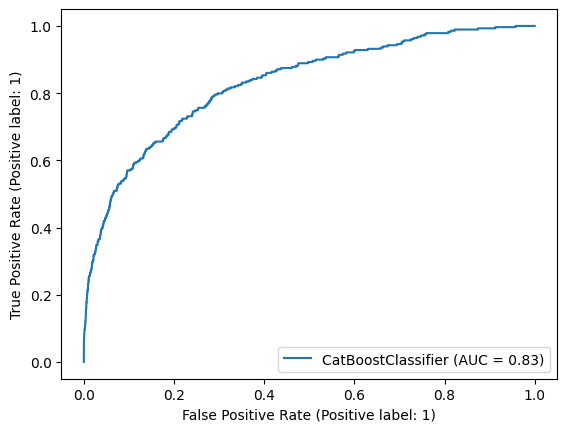

In [526]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer

# data = load_breast_cancer()
# X = data.data
# y = data.target

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12)

# svclassifier = SVC(kernel='rbf')
# svclassifier.fit(X_train, y_train)
# y_predicted = svclassifier.predict(X_test)

print('AUC = %.2f' % roc_auc_score(y_test.to_numpy(), y_test_pred1['canc_prob']))  #1


metrics.plot_roc_curve(cb, x_test, y_test, ax=plt.gca())  #2
plt.show()

(278661, 3)

## Scoring Rejected ACH Pulls

### OOT Time Period

In [16]:
df_reject0 = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data/rejected_ach_transactions_v3.csv')
df_reject_ext_bank = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data/ach_reject_bank_risk_ind.csv')

df_reject_all = pd.merge(df_reject0,df_reject_ext_bank, on ='ID')

df_reject_lending = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data/lending_rejected_oot.csv')

df_reject_lending = df_reject_lending[['ID']]

df_reject = pd.merge(df_reject_all, df_reject_lending,left_on='ID',right_on='ID')

values = {'BANK_RISK': 0}
df_reject.fillna(value=values, inplace=True)
df_reject.BANK_RISK = df_reject.BANK_RISK.astype(int)


# df_reject1 = df_reject.loc[(df_reject['AGE_BUSINESS_MONTHS']>2) & (df_reject['INDICATOR']==0)]
# df_reject1 = df_reject.loc[(df_reject['AGE_BUSINESS_MONTHS']>1) & (df_reject['AGE_BUSINESS_MONTHS']<6)]
df_reject1 = df_reject.loc[(df_reject['AGE_BUSINESS_MONTHS']>=6)]

df_reject1['INDICATOR'] = df_reject1['INDICATOR'].map({0: 1, 1: 1})

df_reject1.columns = [x.lower() for x in df_reject1.columns]

df_reject1 = df_reject1.loc[(df_reject1['created_at']>='2023-06-01') & (df_reject1['created_at']<'2023-10-01')]
df_reject1 = df_reject1.reset_index()



x_test = df_reject1[['bank_risk','avg_running_balance_past30d','rb_at_deposit','card_txn_count_past30d','debit_by_credit_past_30d','ach_c_median_past30d','ach_c_avg_past30d','amount','od_count_past30d','returned_past30d_avg_ach_amount','ach_c_avg_past10by30d','completed_past30d_vs_current_amount_score','debit_by_credit_past_10d','past30d_ach_count','card_txn_median_past2d','ach_d_median_past30d','completed_past30d_std_ach_amount','card_txn_median_past30d','stddev_running_balance_past30d','ach_c_count_past30d','card_txn_avg_past10d','card_txn_median_past10by30d','ach_d_avg_past30d','past30d_avg_ach_amount','ach_c_count_past10by30d','zero_balance_count_past30d']]


y_test = df_reject1['indicator']

y_test_pred = cb.predict_proba(x_test)

y_test_pred1 = pd.DataFrame(data = y_test_pred, columns=['co_prob','canc_prob'])


# Rejected Population at different cutoffs
prob_threshold =[0.015,0.03,0.08,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8]
reject_ls = []
column_name = ['False_Positive', 'True_Positive','False_Negative',
                'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                'Precision', 'Recall']


for bin in prob_threshold:
    reject_ls.append(calculate_at_threshold(bin, df_reject1['indicator'], y_test_pred1['canc_prob']))
metric_df_reject = pd.DataFrame(reject_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
metric_df_reject.index.name = 'Threshold'
metric_df_reject = metric_df_reject.reset_index()
metric_df_reject



,Threshold,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall
0,0.015,0,139,11,0,0.926667,NaN,1.0,0.926667
1,0.030,0,121,29,0,0.806667,NaN,1.0,0.806667
2,0.080,0,49,101,0,0.326667,NaN,1.0,0.326667
3,0.100,0,39,111,0,0.260000,NaN,1.0,0.260000
4,0.150,0,17,133,0,0.113333,NaN,1.0,0.113333
5,0.200,0,9,141,0,0.060000,NaN,1.0,0.060000
6,0.250,0,6,144,0,0.040000,NaN,1.0,0.040000
7,0.300,0,1,149,0,0.006667,NaN,1.0,0.006667
8,0.400,0,0,150,0,0.000000,NaN,NaN,0.000000
9,0.500,0,0,150,0,0.000000,NaN,NaN,0.000000


In [45]:
# df_reject = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data/rejected_ach_transactions_v3.csv')

# EXTERNAL BANK
# df_reject0 = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data/rejected_ach_transactions_v3.csv')
# df_reject_ext_bank = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data/ach_reject_external_bank.csv')

# df_reject = pd.merge(df_reject0,df_reject_ext_bank, on ='ID')

# BANK RISK IND
df_reject0 = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data/rejected_ach_transactions_external_account_not_linked.csv')
df_reject_ext_bank = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data/ach_reject_bank_risk_ind.csv')

df_reject = pd.merge(df_reject0,df_reject_ext_bank, on ='ID')

values = {'BANK_RISK': 0}
df_reject.fillna(value=values, inplace=True)
df_reject.BANK_RISK = df_reject.BANK_RISK.astype(int)


# df_reject1 = df_reject.loc[(df_reject['AGE_BUSINESS_MONTHS']>2) & (df_reject['INDICATOR']==0)]
# df_reject1 = df_reject.loc[(df_reject['AGE_BUSINESS_MONTHS']>1) & (df_reject['AGE_BUSINESS_MONTHS']<6)]
df_reject1 = df_reject.loc[(df_reject['AGE_BUSINESS_MONTHS']>=6)]

df_reject1['INDICATOR'] = df_reject1['INDICATOR'].map({0: 1, 1: 1})

df_reject1.columns = [x.lower() for x in df_reject1.columns]

df_reject1 = df_reject1.loc[(df_reject1['created_at']>='2023-06-01') & (df_reject1['created_at']<'2023-10-01')]
df_reject1 = df_reject1.reset_index()


x_test = df_reject1[['bank_risk','avg_running_balance_past30d','rb_at_deposit','card_txn_count_past30d','debit_by_credit_past_30d','ach_c_median_past30d','ach_c_avg_past30d','amount','od_count_past30d','returned_past30d_avg_ach_amount','ach_c_avg_past10by30d','completed_past30d_vs_current_amount_score','debit_by_credit_past_10d','past30d_ach_count','card_txn_median_past2d','ach_d_median_past30d','completed_past30d_std_ach_amount','card_txn_median_past30d','stddev_running_balance_past30d','ach_c_count_past30d','card_txn_avg_past10d','card_txn_median_past10by30d','ach_d_avg_past30d','past30d_avg_ach_amount','ach_c_count_past10by30d','zero_balance_count_past30d']]

y_test = df_reject1['indicator']

y_test_pred = cb.predict_proba(x_test)

y_test_pred1 = pd.DataFrame(data = y_test_pred, columns=['co_prob','canc_prob'])
# y_test_pred_fin = np.where((y_test_pred1["canc_prob"]<0.30),0,1)


# Rejected Population at different cutoffs
prob_threshold =[0.015,0.04,0.06,0.08,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
reject_ls = []
column_name = ['False_Positive', 'True_Positive','False_Negative',
                'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                'Precision', 'Recall']


for bin in prob_threshold:
    reject_ls.append(calculate_at_threshold(bin, df_reject1['indicator'], y_test_pred1['canc_prob']))
metric_df_reject = pd.DataFrame(reject_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
metric_df_reject.index.name = 'Threshold'
metric_df_reject = metric_df_reject.reset_index()
metric_df_reject


,Threshold,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall
0,0.015,0,286,12,0,0.959732,NaN,1.0,0.959732
1,0.040,0,202,96,0,0.677852,NaN,1.0,0.677852
2,0.060,0,162,136,0,0.543624,NaN,1.0,0.543624
3,0.080,0,139,159,0,0.466443,NaN,1.0,0.466443
4,0.100,0,125,173,0,0.419463,NaN,1.0,0.419463
5,0.150,0,50,248,0,0.167785,NaN,1.0,0.167785
6,0.200,0,20,278,0,0.067114,NaN,1.0,0.067114
7,0.300,0,11,287,0,0.036913,NaN,1.0,0.036913
8,0.400,0,1,297,0,0.003356,NaN,1.0,0.003356
9,0.500,0,1,297,0,0.003356,NaN,1.0,0.003356


In [569]:
x_test = x_test.reset_index()
test1 = pd.merge(y_test_pred1,x_test, left_index=True, right_index=True)
test2 = test1[['canc_prob','amount']]
print(test1.amount.sum())
for bin in prob_threshold:
    test3 = test2.loc[(test2['canc_prob']>=bin)]
    print(test3.amount.sum())

563022.69
523153.98000000004
276778.31
191481.62
139210.86000000002
107246.16
75782.84
63557.5
49651.25
48801.25
48646.25
45300.0
40950.0
24400.0


In [529]:
test2.shape

(621, 2)

### Train Time Period

In [530]:
df_reject0 = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data/rejected_ach_transactions_v3.csv')
df_reject_ext_bank = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull/data/ach_reject_bank_risk_ind.csv')

df_reject = pd.merge(df_reject0,df_reject_ext_bank, on ='ID')

values = {'BANK_RISK': 0}
df_reject.fillna(value=values, inplace=True)
df_reject.BANK_RISK = df_reject.BANK_RISK.astype(int)

# df_reject1 = df_reject.loc[(df_reject['AGE_BUSINESS_MONTHS']>2) & (df_reject['INDICATOR']==0)]
# df_reject1 = df_reject.loc[(df_reject['AGE_BUSINESS_MONTHS']>1) & (df_reject['AGE_BUSINESS_MONTHS']<6)]
df_reject1 = df_reject.loc[(df_reject['AGE_BUSINESS_MONTHS']>=6)]

df_reject1['INDICATOR'] = df_reject1['INDICATOR'].map({0: 1, 1: 1})

df_reject1.columns = [x.lower() for x in df_reject1.columns]

df_reject1 = df_reject1.loc[(df_reject1['created_at']>='2022-09-01') & (df_reject1['created_at']<'2023-06-01')]

x_test = df_reject1[['bank_risk','avg_running_balance_past30d','rb_at_deposit','card_txn_count_past30d','debit_by_credit_past_30d','ach_c_median_past30d','ach_c_avg_past30d','amount','od_count_past30d','returned_past30d_avg_ach_amount','ach_c_avg_past10by30d','completed_past30d_vs_current_amount_score','debit_by_credit_past_10d','past30d_ach_count','card_txn_median_past2d','ach_d_median_past30d','completed_past30d_std_ach_amount','card_txn_median_past30d','stddev_running_balance_past30d','ach_c_count_past30d','card_txn_avg_past10d','card_txn_median_past10by30d','ach_d_avg_past30d','past30d_avg_ach_amount','ach_c_count_past10by30d','zero_balance_count_past30d']]
y_test = df_reject1['indicator']

y_test_pred = cb.predict_proba(x_test)

y_test_pred1 = pd.DataFrame(data = y_test_pred, columns=['co_prob','canc_prob'])
# y_test_pred_fin = np.where((y_test_pred1["canc_prob"]<0.30),0,1)


# Rejected Population at different cutoffs
prob_threshold =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
reject_ls = []
column_name = ['False_Positive', 'True_Positive','False_Negative',
                'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                'Precision', 'Recall']


for bin in prob_threshold:
    reject_ls.append(calculate_at_threshold(bin, df_reject1['indicator'], y_test_pred1['canc_prob']))
metric_df_reject = pd.DataFrame(reject_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
metric_df_reject.index.name = 'Threshold'
metric_df_reject = metric_df_reject.reset_index()
metric_df_reject


,Threshold,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall
0,0.1,0,825,934,0,0.469016,NaN,1.0,0.469016
1,0.2,0,246,1513,0,0.139852,NaN,1.0,0.139852
2,0.3,0,93,1666,0,0.052871,NaN,1.0,0.052871
3,0.4,0,56,1703,0,0.031836,NaN,1.0,0.031836
4,0.5,0,43,1716,0,0.024446,NaN,1.0,0.024446
5,0.6,0,33,1726,0,0.018761,NaN,1.0,0.018761
6,0.7,0,18,1741,0,0.010233,NaN,1.0,0.010233
7,0.8,0,17,1742,0,0.009665,NaN,1.0,0.009665
8,0.9,0,5,1754,0,0.002843,NaN,1.0,0.002843


In [531]:
x_test = x_test.reset_index()
test1 = pd.merge(y_test_pred1,x_test, left_index=True, right_index=True)
test2 = test1[['canc_prob','amount']]
print(test1.amount.sum())
for bin in prob_threshold:
    test3 = test2.loc[(test2['canc_prob']>=bin)]
    print(test3.amount.sum())


1029731.1499999999
320801.5
143598.25
101286.44
95404.62
91914.62
86263.0
83330.0
82130.0
21000.0


### Inactive accounts

In [327]:
filtered_oot = x_oot[x_oot['avg_running_balance_past30d'].isna()]

y_filtered_oot = cb.predict_proba(filtered_oot)
y_filtered_oot1 = pd.DataFrame(data = y_filtered_oot, columns=['co_prob','canc_prob'])

# filtered_df = x_oot[x_oot['card_txn_count_past30d'].isna()]
y_filtered_oot1

,co_prob,canc_prob
0,0.958660,0.041340
1,0.666398,0.333602
2,0.896579,0.103421
3,0.896998,0.103002
4,0.900600,0.099400
5,0.979119,0.020881
6,0.958734,0.041266
7,0.965103,0.034897
8,0.954449,0.045551
9,0.957566,0.042434


In [329]:
filtered_oot.to_csv('greater_6_inactive_acc.csv')

In [352]:
reset_x_oot = x_oot.reset_index()
reset_y_oot = pd.DataFrame(data = y_oot, columns=['target']).reset_index()

filtered_oot = reset_x_oot[reset_x_oot['avg_running_balance_past30d'].isna()].reset_index()

y_filtered_oot = cb.predict_proba(filtered_oot)
y_filtered_oot1 = pd.DataFrame(data = y_filtered_oot, columns=['co_prob','canc_prob'])


# SHAP Testing

In [457]:
import shap

In [458]:
from catboost import CatBoostClassifier, Pool

In [459]:
shap.initjs()

In [461]:
explainer = shap.TreeExplainer(cb)
shap_values = explainer.shap_values(Pool(x_train, y_train, cat_features=categoricals))

In [373]:
filter_x_oot = x_oot[x_oot.index == 62453]
filter_y_oot = y_oot[y_oot.index == 62453]
filter_x_oot.head()

,bank_risk,avg_running_balance_past30d,rb_at_deposit,card_txn_count_past30d,debit_by_credit_past_30d,ach_c_median_past30d,ach_c_avg_past30d,amount,od_count_past30d,returned_past30d_avg_ach_amount,ach_c_avg_past10by30d,completed_past30d_vs_current_amount_score,debit_by_credit_past_10d,past30d_ach_count,card_txn_median_past2d,ach_d_median_past30d,completed_past30d_std_ach_amount,card_txn_median_past30d,stddev_running_balance_past30d,ach_c_count_past30d,card_txn_avg_past10d,card_txn_median_past10by30d,ach_d_avg_past30d,past30d_avg_ach_amount,ach_c_count_past10by30d,zero_balance_count_past30d
62453,2,NaN,500.0,0,0.0,NaN,NaN,50.0,0.0,0.0,NaN,NaN,NaN,0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,0.0,NaN,0.0


In [374]:
shap_values = explainer.shap_values(Pool(filter_x_oot, filter_y_oot, cat_features=categoricals))
shap.force_plot(explainer.expected_value, shap_values[0,:], filter_x_oot.iloc[0,:])

In [106]:
# test = x_train.head(1)
# shap_values = explainer.shap_values(test)
# shap_values
# pd.DataFrame(shap_values)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,-0.456075,-0.085486,-0.015142,-0.024976,0.114273,-0.16515,0.125072,-0.166094,0.06324,-0.008396,-0.019594,0.108546,0.02816,0.091848,-0.021913,-0.020348,-0.023153,0.027819,0.20998,0.068506,0.015304,-0.044993,-0.008662,-0.040562,-0.032107,0.008798,0.12721,-0.072927,0.292149,-0.126379,-0.017985,0.030195,-0.052868,0.04844,-0.013462,-0.010977,-0.013178,0.066316,-0.027441,0.003944


array([[-3.56255419e-01,  1.12440642e+00,  1.82035577e-01, ...,
         6.41889995e-02, -7.01863017e-03,  5.67328974e-01],
       [-3.08050506e-01,  5.56084363e-01,  1.59979049e-01, ...,
        -3.54473600e-02, -9.36791607e-03,  4.85759797e-04],
       [-2.38159223e-01, -2.17308919e-01, -8.88811108e-02, ...,
         7.23161688e-02, -7.01863017e-03, -6.54730998e-04],
       ...,
       [ 4.93543750e-01, -1.70234792e-01, -4.56517062e-02, ...,
        -5.25801696e-02, -1.48583434e-03,  3.30618049e-04],
       [-2.30334670e-01, -5.87263746e-01, -7.34600155e-02, ...,
         6.31538207e-02, -7.01863017e-03,  8.76738303e-04],
       [ 4.74300009e-01,  4.53191995e-01,  1.59128432e-01, ...,
         6.96071420e-02, -7.01863017e-03,  1.56621333e-03]])

In [364]:
#Reject
shap.force_plot(explainer.expected_value, shap_values[0,:], filter_x_oot.iloc[0,:])

In [98]:
#Reject
shap.force_plot(explainer.expected_value, shap_values[95,:], x_train.iloc[95,:])

In [99]:
#Accept
shap.force_plot(explainer.expected_value, shap_values[5,:], x_train.iloc[5,:])

In [100]:
#Accept
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

In [159]:
# shap.summary_plot(shap_values, max_display=15, show=False)

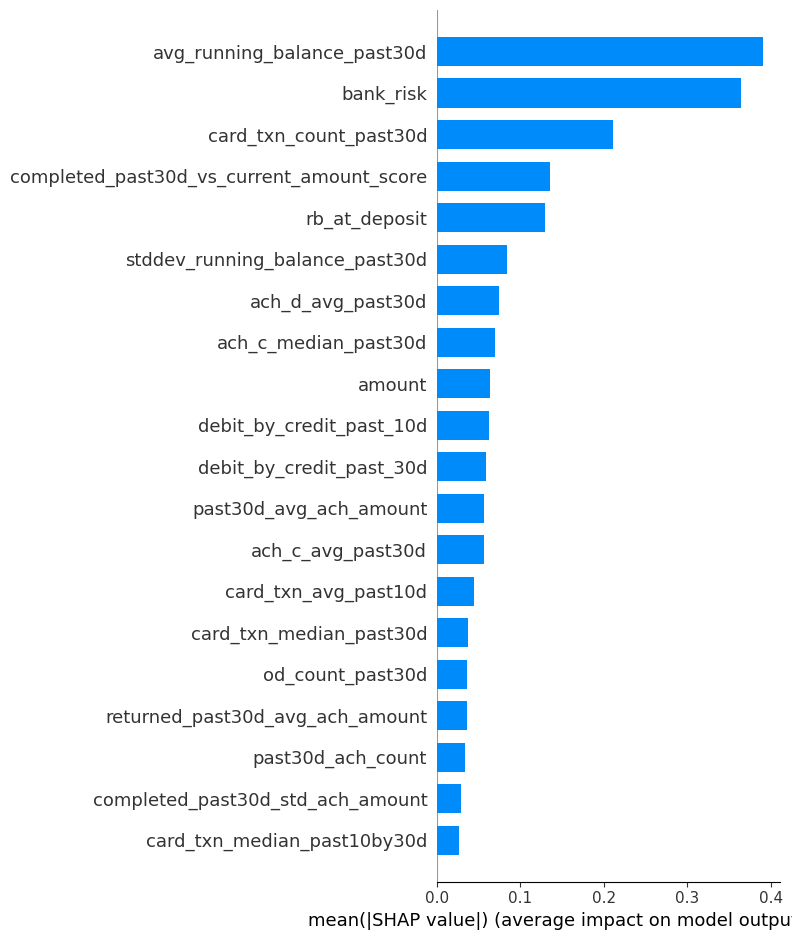

In [462]:
shap.summary_plot(shap_values, x_train, plot_type="bar")
# shap.plots.waterfall(shap_values[0])

In [117]:
# x_train.loc[x_train['index']==13]
pd.DataFrame(shap_values[13,:])

,0
0,0.039895
1,0.819432
2,-0.016213
3,-0.018094
4,0.695446
5,-0.176156
6,0.190528
7,0.071781
8,-0.035266
9,-0.005253


In [409]:
pwd

'/Users/saliljain/Documents/salil/ACH_Pull/scripts'

In [122]:
df_reject1.shape

(902, 373)

In [124]:
df_reject1.shape

(4822, 373)

In [411]:
df1 = pd.read_csv('/Users/saliljain/Downloads/Sardine_ACH_POC_data.csv')
df1.isnull().sum()

SESSIONKEY             0
ENQUIRYTIMEINMILLIS    0
INSIGHTS               0
ENQUIRYLOOKBACKDAYS    0
BANK_NAME              0
ACCOUNT_NUMBER         0
ROUTING_NUMBER         0
NAME                   0
dtype: int64